In [1]:
import gym
import numpy as np
import torch
import torchkit.pytorch_utils as ptu
import torchsde
from torch.nn import functional as F
import random as rnd
import copy as cp
# import environments
import envs.pomdp
import pdb
# import recurrent model-free RL (separate architecture)
from policies.models.policy_rnn import ModelFreeOffPolicy_Separate_RNN as Policy_RNN
from policies.models.policy_rnn_shared import ModelFreeOffPolicy_Shared_RNN as Policy_Shared_RNN
from policies.models.policy_mlp import ModelFreeOffPolicy_MLP as Policy_MLP
from tqdm import tqdm
# import the replay buffer
from buffers.seq_replay_buffer_vanilla import SeqReplayBuffer
from buffers.simple_replay_buffer import SimpleReplayBuffer 
from utils import helpers as utl
from typing import Sequence
from read_ini import read_ini
conf =read_ini("C:/Users/alexander.vasilyev/pomdp-baselines-main/configfile.ini")

C:\Users\alexander.vasilyev\Anaconda3\lib\site-packages\gym\envs\registration.py:505: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1` with the environment ID `CartPole-v1`.
  logger.warn(
C:\Users\alexander.vasilyev\pomdp-baselines-main\utils\logger.py:9: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import OrderedDict, Set
C:\Users\alexander.vasilyev\Anaconda3\lib\site-packages\torch\utils\tensorboard\__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(


## Build a POMDP environment: Pendulum-V (only observe the velocity)

In [2]:
cuda_id = 0  # -1 if using cpu
ptu.set_gpu_mode(torch.cuda.is_available() and cuda_id >= 0, cuda_id)

env = gym.make(conf["env_name"])
max_trajectory_len = env._max_episode_steps
act_dim = env.action_space.shape[0]
obs_dim = env.observation_space.shape[0]

shared = False
markov = False

if markov:
    agent = Policy_MLP(
        obs_dim=obs_dim,
        action_dim=act_dim,
        algo_name=conf["algo_name"],
        dqn_layers=[128, 128],
        policy_layers=[128, 128],
        lr=3e-4,
        gamma=0.99,
        tau=5e-3,
    ).to(ptu.device)
    encoder="Nan"
else:
    if shared:
        agent = Policy_Shared_RNN(
            obs_dim=obs_dim,
            action_dim=act_dim,
            encoder=conf["encoder"],
            algo_name=conf["algo_name"],
            action_embedding_size=int(conf["action_embedding_size"]),
            observ_embedding_size=int(conf["observ_embedding_size"]),
            reward_embedding_size=int(conf["reward_embedding_size"]),
            rnn_hidden_size=int(conf["hidden_size"]),
            dqn_layers=[128, 128],
            policy_layers=[128, 128],
            lr=float(conf["lr"]),
            gamma=0.9,
            tau=0.005,
        ).to(ptu.device)
    else: 
        agent = Policy_RNN(
            obs_dim=obs_dim,
            action_dim=act_dim,
            encoder=conf["encoder"],
            algo_name=conf["algo_name"],
            action_embedding_size=int(conf["action_embedding_size"]),
            observ_embedding_size=int(conf["observ_embedding_size"]),
            reward_embedding_size=int(conf["reward_embedding_size"]),
            rnn_hidden_size=int(conf["hidden_size"]),
            dqn_layers=[128, 128],
            policy_layers=[128, 128],
            lr=float(conf["lr"]),
            gamma=0.9,
            tau=0.005,
            radii=60,
            embed=False,
            activation = conf["activation"],
        ).to(ptu.device)
    
print(agent)
lr=float(conf["lr"])
encoder=conf["encoder"]
num_updates_per_iter = int(conf["num_updates_per_iter"])  # training frequency
sampled_seq_len = int(conf["sampled_seq_len"])  # context length
buffer_size = int(float(conf["buffer_size"]))
batch_size = int(conf["batch_size"])
dropout_rate=float(conf["dropout_rate"])
num_iters = int(conf["num_iters"])
num_init_rollouts_pool = int(conf["num_init_rollouts_pool"])
num_rollouts_per_iter = int(conf["num_rollouts_per_iter"])
total_rollouts = num_init_rollouts_pool + num_iters * num_rollouts_per_iter
n_env_steps_total = max_trajectory_len * total_rollouts
_n_env_steps_total = 0
print("total env episodes", total_rollouts, "total env steps", n_env_steps_total)


ModelFreeOffPolicy_Separate_RNN(
  (critic): Critic_RNN(
    (observ_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=2, bias=True)
    )
    (action_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=2, bias=True)
    )
    (reward_embedder): FeatureExtractor(
      (fc): Linear(in_features=1, out_features=2, bias=True)
    )
    (rnn): LSTM(7, 32)
    (current_shortcut_embedder): FeatureExtractor(
      (fc): Linear(in_features=2, out_features=6, bias=True)
    )
    (qf1): FlattenMlp(
      (fc0): Linear(in_features=38, out_features=128, bias=True)
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (last_fc): Linear(in_features=128, out_features=1, bias=True)
    )
    (qf2): FlattenMlp(
      (fc0): Linear(in_features=38, out_features=128, bias=True)
      (fc1): Linear(in_features=128, out_features=128, bias=True)
      (last_fc): Linear(in_features=128, out_features=1, bias=True)
    )
  )
  (critic_target):

In [3]:
act_dim

1

## Build a recurent model-free RL agent: separate architecture, `lstm` encoder, `oar` policy input space, `td3` RL algorithm (context length set later)

## Define other training parameters such as context length and training frequency

## Define key functions: collect rollouts and policy update

In [4]:
def create_ncde_row(obs, next_obs, prev_action, action, prev_reward, reward, steps,non_drops,init, drop=True):
    
    if init:
        obs_row= obs
        rew_row = prev_reward
        act_row = prev_action
    else:
        obs_row=torch.cat((obs, next_obs),0)
        rew_row=torch.cat((prev_reward, reward),0)
        act_row=torch.cat((prev_action, action),0)
    #pdb.set_trace()
    if shared: 
        obs_row=agent.observ_embedder(obs_row)
        rew_row=agent.reward_embedder(rew_row)
        act_row=agent.action_embedder(act_row)
    else: 
        obs_row=agent.actor.observ_embedder(obs_row)
        rew_row=agent.actor.reward_embedder(rew_row)
        act_row=agent.actor.action_embedder(act_row)
        #pdb.set_trace()
    if init:
        time_tensor=torch.tensor([[steps]]).to(ptu.device)
        drop_tensor=torch.tensor([[non_drops]]).to(ptu.device)
    else:
        time_tensor=torch.tensor([[steps],[steps+1]]).to(ptu.device)
        if drop:
            drop_tensor=torch.tensor([[non_drops],[non_drops+1]]).to(ptu.device)
        else:
            drop_tensor=torch.tensor([[non_drops],[non_drops]]).to(ptu.device)
    ncde_row=torch.cat((time_tensor,drop_tensor,act_row,obs_row,rew_row),1)
    ncde_row=ncde_row[None,:]
    #pdb.set_trace()
    return ncde_row



@torch.no_grad()
def collect_rollouts(
    num_rollouts, random_actions=False, deterministic=True, train_mode=True
):
    """collect num_rollouts of trajectories in task and save into policy buffer
    :param
        random_actions: whether to use policy to sample actions, or randomly sample action space
        deterministic: deterministic action selection?
        train_mode: whether to train (stored to buffer) or test
    """
    if not train_mode:
        assert random_actions == False and deterministic == True

    total_steps = 0
    total_rewards = 0.0
    trewards =[]
    for idx in range(num_rollouts):
        steps = 0
        rewards = 0.0
        energy = 0.0
        non_drops=0
        obs = ptu.from_numpy(env.reset())
        obs = obs.reshape(1, obs.shape[-1])
        done_rollout = False
        init=True
        drop=True
        # get hidden state at timestep=0, None for mlp
        
        if not markov:
            action, reward, internal_state = agent.get_initial_info()

            if encoder == "ncde":
                internal_state= None
                ncde_row= create_ncde_row(obs, obs, action, action, reward, reward, steps,non_drops,init, drop)
                prev_action= action.clone()
                prev_reward= reward.clone()
                next_obs= obs.clone()
        
        
        if train_mode:
            # temporary storage
            obs_list, act_list, rew_list, next_obs_list, term_list, drop_list = (
                [],
                [],
                [],
                [],
                [],
                [],
            )
                           

        while not done_rollout:
            if markov: 
                action = agent.act(obs=obs, 
                                   deterministic=deterministic)[0]
            else:
                if encoder == "ncde":
                    (action,_,_,_), internal_state= agent.ncde_act(ncde_row=ncde_row,
                                                                   prev_internal_state=internal_state,
                                                                   obs=obs,
                                                                   deterministic=deterministic,)
                else:
                    (action, _, _, _), internal_state = agent.act(
                        prev_internal_state=internal_state,
                        prev_action=action,
                        reward=reward,
                        obs=obs,
                        drop=drop,
                        deterministic=deterministic,
                    )
            # observe reward and next obs (B=1, dim)
            #pdb.set_trace()
        
            #print(torch.norm(internal_state))
            next_obs, reward, done, info = utl.env_step(env, action.squeeze(dim=0))
            done_rollout = False if ptu.get_numpy(done[0][0]) == 0.0 else True
            init=False
     
            #switch on/off dropouts
            if dropout_rate>0:
                drop_trigger=rnd.uniform(0,1)
                if drop_trigger<dropout_rate:
                    next_obs= obs.clone()
                    drop=False
                else:
                    drop=True
                    
                    
            if not markov:
                if encoder == "ncde":  
                    ncde_row= create_ncde_row(obs, next_obs, prev_action, action, prev_reward, reward, steps,non_drops,init, drop)
            
            #switch on/off dropouts

            # update statistics
           
            rewards += reward.item()
            energy += action*action
           
            # early stopping env: such as rmdp, pomdp, generalize tasks. term ignores timeout
            term = (
                False
                if "TimeLimit.truncated" in info or steps >= max_trajectory_len
                else done_rollout
            )

            if train_mode:
                # append tensors to temporary storage
                obs_list.append(obs)  # (1, dim)
                act_list.append(action)  # (1, dim)
                rew_list.append(reward)  # (1, dim)
                term_list.append(term)  # bool
                next_obs_list.append(next_obs)  # (1, dim)
            steps += 1
            # set: obs <- next_obs
            obs = next_obs.clone()
            prev_reward= reward.clone()
            prev_action= action.clone()
            if drop:
                non_drops +=1
        if train_mode:
            # add collected sequence to buffer
            policy_storage.add_episode(
                observations=ptu.get_numpy(torch.cat(obs_list, dim=0)),  # (L, dim)
                actions=ptu.get_numpy(torch.cat(act_list, dim=0)),  # (L, dim)
                rewards=ptu.get_numpy(torch.cat(rew_list, dim=0)),  # (L, dim)
                terminals=np.array(term_list).reshape(-1, 1),  # (L, 1)
                next_observations=ptu.get_numpy(
                    torch.cat(next_obs_list, dim=0)
                ),  # (L, dim)
            )
        print(
            "Mode:",
            "Train" if train_mode else "Test",
            "env_steps",
            steps,
            "total rewards",
            rewards,
            "total energy",
            energy,
        )
        total_steps += steps
        total_rewards += rewards
        trewards.append(rewards)
    if train_mode:
        return total_steps
    else:
        return total_rewards / num_rollouts, np.std(trewards)


def update(num_updates, factor):
    rl_losses_agg = {}
    # print(num_updates)
    for update in tqdm(range(num_updates), leave=True):
        # sample random RL batch: in transitions
        batch = ptu.np_to_pytorch_batch(policy_storage.random_episodes(batch_size))
        # RL update
        
        rl_losses = agent.update(batch, factor)

        for k, v in rl_losses.items():
            if update == 0:  # first iterate - create list
                rl_losses_agg[k] = [v]
            else:  # append values
                rl_losses_agg[k].append(v)
    # statistics
    for k in rl_losses_agg:
        rl_losses_agg[k] = np.mean(rl_losses_agg[k])
    return rl_losses_agg

## Train and Evaluate the agent: only costs < 20 min

In [5]:
policy_storage = SeqReplayBuffer(
    max_replay_buffer_size=buffer_size,
    observation_dim=obs_dim,
    action_dim=act_dim,
    sampled_seq_len=sampled_seq_len,
    sample_weight_baseline=0.0,
)

env_steps = collect_rollouts(
    num_rollouts=num_init_rollouts_pool, random_actions=False, train_mode=True
)
_n_env_steps_total += env_steps

# evaluation parameters
last_eval_num_iters = 10
log_interval = 5
eval_num_rollouts = 10
learning_curve = {
    "x": [],
    "y": [],
    "z": [],
}
epoch=0
lambda_pat = 0.65

while _n_env_steps_total < n_env_steps_total:

    env_steps = collect_rollouts(num_rollouts=num_rollouts_per_iter, train_mode=True)
    _n_env_steps_total += env_steps

    #train_stats = update(int(num_updates_per_iter * env_steps))
    factor= lambda_pat **(epoch )
    #train_stats = update(int(num_updates_per_iter * env_steps))
    train_stats = update(25, lr)
    
    epoch += 1
    current_num_iters = _n_env_steps_total // (
        num_rollouts_per_iter * max_trajectory_len
    )
    if (
        current_num_iters != last_eval_num_iters
        and current_num_iters % log_interval == 0
    ):
        last_eval_num_iters = current_num_iters
        average_returns, std_returns = collect_rollouts(
            num_rollouts=eval_num_rollouts,
            train_mode=False,
            random_actions=False,
            deterministic=True,
        )
        learning_curve["x"].append(_n_env_steps_total)
        learning_curve["y"].append(average_returns)
        learning_curve["z"].append(std_returns)
        print(_n_env_steps_total, average_returns)

buffer RAM usage: 0.02 GB
Mode: Train env_steps 200 total rewards -1266.1032178401947 total energy tensor([[0.0009]])
Mode: Train env_steps 200 total rewards -955.4806178808212 total energy tensor([[0.0011]])
Mode: Train env_steps 200 total rewards -862.8014444708824 total energy tensor([[0.0011]])
Mode: Train env_steps 200 total rewards -1424.9835186004639 total energy tensor([[0.0008]])
Mode: Train env_steps 200 total rewards -1165.8994575738907 total energy tensor([[0.0010]])
Mode: Train env_steps 200 total rewards -1058.92392039299 total energy tensor([[0.0011]])
Mode: Train env_steps 200 total rewards -1352.227710723877 total energy tensor([[0.0008]])
Mode: Train env_steps 200 total rewards -627.6349791716784 total energy tensor([[0.0011]])
Mode: Train env_steps 200 total rewards -1784.7223949432373 total energy tensor([[0.0007]])
Mode: Train env_steps 200 total rewards -972.681733250618 total energy tensor([[0.0011]])


  0%|          | 0/25 [00:00<?, ?it/s]C:\Users\alexander.vasilyev\pomdp-baselines-main\torchkit\pytorch_utils.py:73: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if v.dtype == np.bool:
100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


Mode: Train env_steps 200 total rewards -745.4394948931877 total energy tensor([[0.2399]])
Mode: Train env_steps 200 total rewards -1370.3971552848816 total energy tensor([[0.2566]])
Mode: Train env_steps 200 total rewards -1130.7549986839294 total energy tensor([[0.3970]])
Mode: Train env_steps 200 total rewards -1031.1541621088982 total energy tensor([[0.9517]])
Mode: Train env_steps 200 total rewards -938.956279411912 total energy tensor([[0.8823]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1407.2947022914886 total energy tensor([[66.5538]])
Mode: Train env_steps 200 total rewards -1472.5919048786163 total energy tensor([[75.0713]])
Mode: Train env_steps 200 total rewards -1494.2014050483704 total energy tensor([[76.2145]])
Mode: Train env_steps 200 total rewards -1447.227728229016 total energy tensor([[74.3460]])
Mode: Train env_steps 200 total rewards -1317.773431301117 total energy tensor([[52.5192]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -1642.1364649385214 total energy tensor([[197.4670]])
Mode: Train env_steps 200 total rewards -1399.8091060519218 total energy tensor([[182.6105]])
Mode: Train env_steps 200 total rewards -1465.3074345588684 total energy tensor([[182.9073]])
Mode: Train env_steps 200 total rewards -1212.1661685705185 total energy tensor([[175.4355]])
Mode: Train env_steps 200 total rewards -1653.6114396452904 total energy tensor([[197.3728]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -1412.2457513809204 total energy tensor([[198.6373]])
Mode: Test env_steps 200 total rewards -832.3886241465807 total energy tensor([[196.2916]])
Mode: Test env_steps 200 total rewards -1043.3463160395622 total energy tensor([[197.1967]])
Mode: Test env_steps 200 total rewards -1352.7229974716902 total energy tensor([[196.8167]])
Mode: Test env_steps 200 total rewards -1508.132583141327 total energy tensor([[198.6217]])
Mode: Test env_steps 200 total rewards -1679.6459266543388 total energy tensor([[199.3996]])
Mode: Test env_steps 200 total rewards -1032.0644156336784 total energy tensor([[197.3182]])
Mode: Test env_steps 200 total rewards -1680.3823629021645 total energy tensor([[199.5375]])
Mode: Test env_steps 200 total rewards -1411.7163172215223 total energy tensor([[197.5592]])
Mode: Test env_steps 200 total rewards -1548.0150758624077 total energy tensor([[199.5434]])
5000 -1350.0660370454193
Mode: Train env_steps 200 total rewards -1605.3

100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Train env_steps 200 total rewards -1271.4919345378876 total energy tensor([[198.8471]])
Mode: Train env_steps 200 total rewards -1482.859855413437 total energy tensor([[198.0862]])
Mode: Train env_steps 200 total rewards -1683.914175093174 total energy tensor([[199.5924]])
Mode: Train env_steps 200 total rewards -1584.5608720183372 total energy tensor([[199.4838]])
Mode: Train env_steps 200 total rewards -1628.0921262577176 total energy tensor([[199.1134]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1352.0138755738735 total energy tensor([[197.0666]])
Mode: Train env_steps 200 total rewards -1391.7349678054452 total energy tensor([[198.1162]])
Mode: Train env_steps 200 total rewards -1492.0025906562805 total energy tensor([[198.8007]])
Mode: Train env_steps 200 total rewards -1186.998430132866 total energy tensor([[198.4724]])
Mode: Train env_steps 200 total rewards -1590.564728308469 total energy tensor([[198.3417]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1580.4169337153435 total energy tensor([[199.2807]])
Mode: Train env_steps 200 total rewards -1404.8856769502163 total energy tensor([[195.2835]])
Mode: Train env_steps 200 total rewards -1687.544506430626 total energy tensor([[199.4664]])
Mode: Train env_steps 200 total rewards -1649.8054435253143 total energy tensor([[199.2884]])
Mode: Train env_steps 200 total rewards -1391.3501802384853 total energy tensor([[195.6767]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1515.0758662223816 total energy tensor([[188.4180]])
Mode: Train env_steps 200 total rewards -1607.932655673474 total energy tensor([[197.9095]])
Mode: Train env_steps 200 total rewards -1296.360965847969 total energy tensor([[180.7026]])
Mode: Train env_steps 200 total rewards -1492.3549126386642 total energy tensor([[190.9469]])
Mode: Train env_steps 200 total rewards -1491.4034979641438 total energy tensor([[196.0132]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Test env_steps 200 total rewards -1454.4792093634605 total energy tensor([[71.3837]])
Mode: Test env_steps 200 total rewards -1660.2703498005867 total energy tensor([[198.9892]])
Mode: Test env_steps 200 total rewards -1675.2624131441116 total energy tensor([[197.9421]])
Mode: Test env_steps 200 total rewards -1573.6739860773087 total energy tensor([[194.2730]])
Mode: Test env_steps 200 total rewards -1434.8367967307568 total energy tensor([[67.7697]])
Mode: Test env_steps 200 total rewards -1405.548364341259 total energy tensor([[72.1515]])
Mode: Test env_steps 200 total rewards -1479.8275136351585 total energy tensor([[70.1393]])
Mode: Test env_steps 200 total rewards -1538.9457586407661 total energy tensor([[177.6209]])
Mode: Test env_steps 200 total rewards -1578.3108928203583 total energy tensor([[179.5811]])
Mode: Test env_steps 200 total rewards -1445.20378780365 total energy tensor([[69.9165]])
10000 -1524.6359072357416
Mode: Train env_steps 200 total rewards -1394.231258

100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1602.3421037197113 total energy tensor([[184.7877]])
Mode: Train env_steps 200 total rewards -1678.4937700033188 total energy tensor([[198.7389]])
Mode: Train env_steps 200 total rewards -1550.7978823781013 total energy tensor([[185.2731]])
Mode: Train env_steps 200 total rewards -1517.2755988836288 total energy tensor([[126.0720]])
Mode: Train env_steps 200 total rewards -1665.5678864121437 total energy tensor([[198.5598]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1654.5346485376358 total energy tensor([[198.5914]])
Mode: Train env_steps 200 total rewards -1577.667482495308 total energy tensor([[188.6028]])
Mode: Train env_steps 200 total rewards -1663.6938548088074 total energy tensor([[199.2301]])
Mode: Train env_steps 200 total rewards -1585.2330627441406 total energy tensor([[177.2346]])
Mode: Train env_steps 200 total rewards -1614.2117842435837 total energy tensor([[155.0553]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1579.0495737791061 total energy tensor([[187.2083]])
Mode: Train env_steps 200 total rewards -1593.5824725972489 total energy tensor([[196.2128]])
Mode: Train env_steps 200 total rewards -1595.2952589988708 total energy tensor([[153.9596]])
Mode: Train env_steps 200 total rewards -1590.2059395313263 total energy tensor([[153.5440]])
Mode: Train env_steps 200 total rewards -1532.900784343481 total energy tensor([[184.1861]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -1389.4426416754723 total energy tensor([[65.6375]])
Mode: Train env_steps 200 total rewards -1577.3379502296448 total energy tensor([[183.3214]])
Mode: Train env_steps 200 total rewards -1625.413148328662 total energy tensor([[198.3628]])
Mode: Train env_steps 200 total rewards -1660.7480478584766 total energy tensor([[199.5076]])
Mode: Train env_steps 200 total rewards -1625.524412509054 total energy tensor([[198.9566]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -1630.7515150606632 total energy tensor([[199.0047]])
Mode: Test env_steps 200 total rewards -1549.060254573822 total energy tensor([[181.9688]])
Mode: Test env_steps 200 total rewards -1221.450868293643 total energy tensor([[30.7332]])
Mode: Test env_steps 200 total rewards -1621.9233932867646 total energy tensor([[199.6548]])
Mode: Test env_steps 200 total rewards -1658.3833540081978 total energy tensor([[198.6699]])
Mode: Test env_steps 200 total rewards -1518.8483078181744 total energy tensor([[181.6026]])
Mode: Test env_steps 200 total rewards -1650.0146043151617 total energy tensor([[199.5349]])
Mode: Test env_steps 200 total rewards -1496.7032185941935 total energy tensor([[172.6518]])
Mode: Test env_steps 200 total rewards -1621.714300017804 total energy tensor([[199.0247]])
Mode: Test env_steps 200 total rewards -1269.9404256939888 total energy tensor([[25.8106]])
15000 -1523.8790241662414
Mode: Train env_steps 200 total rewards -1476.560

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1483.2371554970741 total energy tensor([[173.5244]])
Mode: Train env_steps 200 total rewards -1391.2895731925964 total energy tensor([[145.2523]])
Mode: Train env_steps 200 total rewards -1576.954830646515 total energy tensor([[199.4675]])
Mode: Train env_steps 200 total rewards -1589.7652681916952 total energy tensor([[198.4163]])
Mode: Train env_steps 200 total rewards -1511.756674528122 total energy tensor([[182.3341]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -1638.2325066626072 total energy tensor([[198.8541]])
Mode: Train env_steps 200 total rewards -1646.0247204005718 total energy tensor([[199.4642]])
Mode: Train env_steps 200 total rewards -1647.7917731106281 total energy tensor([[199.4945]])
Mode: Train env_steps 200 total rewards -1594.898830242455 total energy tensor([[199.2954]])
Mode: Train env_steps 200 total rewards -1653.2135748267174 total energy tensor([[198.5499]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1106.7457323670387 total energy tensor([[184.4204]])
Mode: Train env_steps 200 total rewards -1662.3932470679283 total energy tensor([[198.9176]])
Mode: Train env_steps 200 total rewards -1615.148795440793 total energy tensor([[199.7877]])
Mode: Train env_steps 200 total rewards -1564.3615357279778 total energy tensor([[199.3132]])
Mode: Train env_steps 200 total rewards -1680.0347829461098 total energy tensor([[199.7757]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1485.0444779396057 total energy tensor([[192.2813]])
Mode: Train env_steps 200 total rewards -1633.3472737520933 total energy tensor([[199.4179]])
Mode: Train env_steps 200 total rewards -1196.8244746923447 total energy tensor([[191.9990]])
Mode: Train env_steps 200 total rewards -1232.5266478061676 total energy tensor([[192.8147]])
Mode: Train env_steps 200 total rewards -1364.6176898479462 total energy tensor([[193.3060]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Test env_steps 200 total rewards -1505.1244101524353 total energy tensor([[191.8208]])
Mode: Test env_steps 200 total rewards -1224.0558891296387 total energy tensor([[196.0982]])
Mode: Test env_steps 200 total rewards -1154.487779378891 total energy tensor([[194.8320]])
Mode: Test env_steps 200 total rewards -1501.370517730713 total energy tensor([[191.4195]])
Mode: Test env_steps 200 total rewards -1670.9482768774033 total energy tensor([[199.5760]])
Mode: Test env_steps 200 total rewards -1523.6864337921143 total energy tensor([[194.8612]])
Mode: Test env_steps 200 total rewards -1599.1602135784924 total energy tensor([[199.4140]])
Mode: Test env_steps 200 total rewards -1651.807949140668 total energy tensor([[199.8835]])
Mode: Test env_steps 200 total rewards -1673.8713010549545 total energy tensor([[199.2299]])
Mode: Test env_steps 200 total rewards -1084.0653425455093 total energy tensor([[194.2650]])
20000 -1458.857811338082
Mode: Train env_steps 200 total rewards -1345.44

100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -1670.1362590789795 total energy tensor([[199.8146]])
Mode: Train env_steps 200 total rewards -1682.346642255783 total energy tensor([[199.9587]])
Mode: Train env_steps 200 total rewards -1509.314582824707 total energy tensor([[196.7484]])
Mode: Train env_steps 200 total rewards -1518.9615278244019 total energy tensor([[197.7870]])
Mode: Train env_steps 200 total rewards -1013.0647417902946 total energy tensor([[195.0798]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Train env_steps 200 total rewards -1404.925960302353 total energy tensor([[198.8258]])
Mode: Train env_steps 200 total rewards -1497.598994731903 total energy tensor([[197.6800]])
Mode: Train env_steps 200 total rewards -1495.6865773200989 total energy tensor([[197.8716]])
Mode: Train env_steps 200 total rewards -1689.045777797699 total energy tensor([[199.9716]])
Mode: Train env_steps 200 total rewards -1357.9571468532085 total energy tensor([[198.3447]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1235.2039222717285 total energy tensor([[199.0975]])
Mode: Train env_steps 200 total rewards -1326.4377510547638 total energy tensor([[199.5251]])
Mode: Train env_steps 200 total rewards -1587.6370636969805 total energy tensor([[199.1599]])
Mode: Train env_steps 200 total rewards -1421.5634412765503 total energy tensor([[199.5343]])
Mode: Train env_steps 200 total rewards -1233.145367383957 total energy tensor([[199.1394]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1183.511828303337 total energy tensor([[199.3243]])
Mode: Train env_steps 200 total rewards -1495.3042569160461 total energy tensor([[199.6133]])
Mode: Train env_steps 200 total rewards -1162.8155246973038 total energy tensor([[199.4505]])
Mode: Train env_steps 200 total rewards -1345.2410154342651 total energy tensor([[199.7019]])
Mode: Train env_steps 200 total rewards -1347.0836617946625 total energy tensor([[199.7306]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Test env_steps 200 total rewards -1140.2662566900253 total energy tensor([[199.5968]])
Mode: Test env_steps 200 total rewards -1615.8416526317596 total energy tensor([[199.9240]])
Mode: Test env_steps 200 total rewards -1408.0935144424438 total energy tensor([[199.8532]])
Mode: Test env_steps 200 total rewards -960.4921075105667 total energy tensor([[199.3360]])
Mode: Test env_steps 200 total rewards -1504.893720626831 total energy tensor([[199.8060]])
Mode: Test env_steps 200 total rewards -1493.018424987793 total energy tensor([[199.7431]])
Mode: Test env_steps 200 total rewards -1670.3698768615723 total energy tensor([[199.7676]])
Mode: Test env_steps 200 total rewards -1251.8315210342407 total energy tensor([[199.8423]])
Mode: Test env_steps 200 total rewards -1652.8169970810413 total energy tensor([[199.9264]])
Mode: Test env_steps 200 total rewards -1196.1124505996704 total energy tensor([[199.7485]])
25000 -1389.3736522465945
Mode: Train env_steps 200 total rewards -1438.4

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1441.049060344696 total energy tensor([[199.9100]])
Mode: Train env_steps 200 total rewards -1392.5812227725983 total energy tensor([[199.8830]])
Mode: Train env_steps 200 total rewards -1204.471231341362 total energy tensor([[199.8599]])
Mode: Train env_steps 200 total rewards -1566.238950997591 total energy tensor([[199.9424]])
Mode: Train env_steps 200 total rewards -1565.1496470496058 total energy tensor([[199.7192]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -832.7950612008572 total energy tensor([[199.5603]])
Mode: Train env_steps 200 total rewards -1423.7232241630554 total energy tensor([[199.9442]])
Mode: Train env_steps 200 total rewards -1263.5860845670104 total energy tensor([[199.7297]])
Mode: Train env_steps 200 total rewards -1084.5817527770996 total energy tensor([[199.7957]])
Mode: Train env_steps 200 total rewards -1596.9802463054657 total energy tensor([[199.9561]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1664.561577796936 total energy tensor([[199.9179]])
Mode: Train env_steps 200 total rewards -1187.120155930519 total energy tensor([[199.9215]])
Mode: Train env_steps 200 total rewards -1501.221995830536 total energy tensor([[199.9615]])
Mode: Train env_steps 200 total rewards -1523.667757987976 total energy tensor([[199.9524]])
Mode: Train env_steps 200 total rewards -1668.5079122781754 total energy tensor([[199.9633]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1077.1409693956375 total energy tensor([[199.9343]])
Mode: Train env_steps 200 total rewards -1513.10697555542 total energy tensor([[199.9884]])
Mode: Train env_steps 200 total rewards -1557.5344946682453 total energy tensor([[199.9911]])
Mode: Train env_steps 200 total rewards -1653.652096271515 total energy tensor([[199.9917]])
Mode: Train env_steps 200 total rewards -1207.9643207788467 total energy tensor([[199.9847]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -1312.1466953754425 total energy tensor([[199.9888]])
Mode: Test env_steps 200 total rewards -1475.8241620063782 total energy tensor([[199.9789]])
Mode: Test env_steps 200 total rewards -1678.1111772060394 total energy tensor([[199.9799]])
Mode: Test env_steps 200 total rewards -1495.4573984146118 total energy tensor([[199.9940]])
Mode: Test env_steps 200 total rewards -1497.8867716789246 total energy tensor([[199.9764]])
Mode: Test env_steps 200 total rewards -1340.4810583591461 total energy tensor([[199.9750]])
Mode: Test env_steps 200 total rewards -1679.7156145572662 total energy tensor([[199.9789]])
Mode: Test env_steps 200 total rewards -1610.0311988592148 total energy tensor([[199.9804]])
Mode: Test env_steps 200 total rewards -1660.1723017692566 total energy tensor([[199.9978]])
Mode: Test env_steps 200 total rewards -1278.9289042949677 total energy tensor([[199.9736]])
30000 -1502.8755282521247
Mode: Train env_steps 200 total rewards -104

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1621.7762657403946 total energy tensor([[199.9822]])
Mode: Train env_steps 200 total rewards -1150.6118421554565 total energy tensor([[199.9789]])
Mode: Train env_steps 200 total rewards -1666.3287794589996 total energy tensor([[199.9988]])
Mode: Train env_steps 200 total rewards -1255.9651010036469 total energy tensor([[199.9816]])
Mode: Train env_steps 200 total rewards -1175.000884771347 total energy tensor([[199.9706]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -977.8770486712456 total energy tensor([[199.9546]])
Mode: Train env_steps 200 total rewards -1664.50289401412 total energy tensor([[199.9991]])
Mode: Train env_steps 200 total rewards -1492.8841528892517 total energy tensor([[199.9926]])
Mode: Train env_steps 200 total rewards -1541.3662210553885 total energy tensor([[199.9982]])
Mode: Train env_steps 200 total rewards -1688.8213678598404 total energy tensor([[199.9980]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1230.3509459495544 total energy tensor([[199.9844]])
Mode: Train env_steps 200 total rewards -1658.490702867508 total energy tensor([[199.9918]])
Mode: Train env_steps 200 total rewards -1679.1355129480362 total energy tensor([[199.9888]])
Mode: Train env_steps 200 total rewards -1642.720082089305 total energy tensor([[199.9986]])
Mode: Train env_steps 200 total rewards -1673.5562325716019 total energy tensor([[199.9982]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1499.462905883789 total energy tensor([[199.9904]])
Mode: Train env_steps 200 total rewards -1502.2091064453125 total energy tensor([[199.9910]])
Mode: Train env_steps 200 total rewards -1210.8853055238724 total energy tensor([[199.9899]])
Mode: Train env_steps 200 total rewards -1563.9940296038985 total energy tensor([[199.9708]])
Mode: Train env_steps 200 total rewards -1668.9499224424362 total energy tensor([[199.9889]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Test env_steps 200 total rewards -1388.1520850658417 total energy tensor([[199.9920]])
Mode: Test env_steps 200 total rewards -1608.4742287397385 total energy tensor([[199.9912]])
Mode: Test env_steps 200 total rewards -1374.294907093048 total energy tensor([[199.9917]])
Mode: Test env_steps 200 total rewards -949.2272599339485 total energy tensor([[199.9831]])
Mode: Test env_steps 200 total rewards -1095.0985223054886 total energy tensor([[199.9867]])
Mode: Test env_steps 200 total rewards -1650.4921867251396 total energy tensor([[199.9887]])
Mode: Test env_steps 200 total rewards -1686.4327584505081 total energy tensor([[199.9985]])
Mode: Test env_steps 200 total rewards -1661.4647495746613 total energy tensor([[199.9963]])
Mode: Test env_steps 200 total rewards -1673.048825263977 total energy tensor([[199.9866]])
Mode: Test env_steps 200 total rewards -1676.7878551483154 total energy tensor([[199.9971]])
35000 -1476.3473378300666
Mode: Train env_steps 200 total rewards -1369.6

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1505.2196712493896 total energy tensor([[199.9942]])
Mode: Train env_steps 200 total rewards -1408.7239925861359 total energy tensor([[199.9922]])
Mode: Train env_steps 200 total rewards -1664.6920804977417 total energy tensor([[199.9919]])
Mode: Train env_steps 200 total rewards -1647.7067001461983 total energy tensor([[199.9916]])
Mode: Train env_steps 200 total rewards -1655.1771059036255 total energy tensor([[199.9925]])


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


Mode: Train env_steps 200 total rewards -1355.0828077793121 total energy tensor([[199.9939]])
Mode: Train env_steps 200 total rewards -1681.1251593828201 total energy tensor([[199.9994]])
Mode: Train env_steps 200 total rewards -1648.1687834262848 total energy tensor([[199.9942]])
Mode: Train env_steps 200 total rewards -1625.9458014667034 total energy tensor([[199.9994]])
Mode: Train env_steps 200 total rewards -1391.3478527069092 total energy tensor([[199.9978]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -1280.553349494934 total energy tensor([[199.9952]])
Mode: Train env_steps 200 total rewards -1597.4876094390638 total energy tensor([[199.9880]])
Mode: Train env_steps 200 total rewards -1638.1601209640503 total energy tensor([[199.9972]])
Mode: Train env_steps 200 total rewards -1628.2936036586761 total energy tensor([[199.9968]])
Mode: Train env_steps 200 total rewards -1669.2199448049068 total energy tensor([[199.9995]])


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


Mode: Train env_steps 200 total rewards -973.964187681675 total energy tensor([[199.9879]])
Mode: Train env_steps 200 total rewards -931.6142643094063 total energy tensor([[199.9881]])
Mode: Train env_steps 200 total rewards -1679.3283888101578 total energy tensor([[199.9993]])
Mode: Train env_steps 200 total rewards -1596.8605261072516 total energy tensor([[199.9944]])
Mode: Train env_steps 200 total rewards -1644.8936446011066 total energy tensor([[199.9946]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Test env_steps 200 total rewards -1195.6576508283615 total energy tensor([[199.9939]])
Mode: Test env_steps 200 total rewards -1498.2434978485107 total energy tensor([[199.9995]])
Mode: Test env_steps 200 total rewards -1524.3434572219849 total energy tensor([[199.9960]])
Mode: Test env_steps 200 total rewards -1493.7804408073425 total energy tensor([[199.9993]])
Mode: Test env_steps 200 total rewards -1068.9897611737251 total energy tensor([[199.9969]])
Mode: Test env_steps 200 total rewards -1506.8369879722595 total energy tensor([[199.9958]])
Mode: Test env_steps 200 total rewards -1482.7776083946228 total energy tensor([[199.9996]])
Mode: Test env_steps 200 total rewards -1162.3160774707794 total energy tensor([[199.9966]])
Mode: Test env_steps 200 total rewards -1252.3169767856598 total energy tensor([[199.9957]])
Mode: Test env_steps 200 total rewards -945.2130107581615 total energy tensor([[199.9845]])
40000 -1313.0475469261407
Mode: Train env_steps 200 total rewards -1113

100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1500.5103178024292 total energy tensor([[199.9969]])
Mode: Train env_steps 200 total rewards -1292.7310818359256 total energy tensor([[199.9900]])
Mode: Train env_steps 200 total rewards -1491.9150524139404 total energy tensor([[199.9960]])
Mode: Train env_steps 200 total rewards -1323.6500606536865 total energy tensor([[199.9991]])
Mode: Train env_steps 200 total rewards -1509.2255792617798 total energy tensor([[199.9958]])


100%|██████████| 25/25 [00:03<00:00,  6.38it/s]


Mode: Train env_steps 200 total rewards -1251.009034395218 total energy tensor([[199.9992]])
Mode: Train env_steps 200 total rewards -1370.9236330986023 total energy tensor([[199.9988]])
Mode: Train env_steps 200 total rewards -1499.7920370101929 total energy tensor([[199.9967]])
Mode: Train env_steps 200 total rewards -1653.207740008831 total energy tensor([[199.9960]])
Mode: Train env_steps 200 total rewards -1500.777262210846 total energy tensor([[199.9964]])


100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Train env_steps 200 total rewards -1684.3491314649582 total energy tensor([[199.9974]])
Mode: Train env_steps 200 total rewards -1666.3429582118988 total energy tensor([[199.9996]])
Mode: Train env_steps 200 total rewards -1652.860550403595 total energy tensor([[199.9946]])
Mode: Train env_steps 200 total rewards -1334.9100432395935 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -1548.084429346025 total energy tensor([[199.9977]])


100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Train env_steps 200 total rewards -1464.4195914268494 total energy tensor([[199.9994]])
Mode: Train env_steps 200 total rewards -1560.9094248116016 total energy tensor([[199.9987]])
Mode: Train env_steps 200 total rewards -1515.7458028793335 total energy tensor([[199.9970]])
Mode: Train env_steps 200 total rewards -1200.9550482034683 total energy tensor([[199.9987]])
Mode: Train env_steps 200 total rewards -1156.9174021482468 total energy tensor([[199.9956]])


100%|██████████| 25/25 [00:03<00:00,  6.48it/s]


Mode: Test env_steps 200 total rewards -1496.8609075546265 total energy tensor([[199.9998]])
Mode: Test env_steps 200 total rewards -794.8983184173703 total energy tensor([[199.9714]])
Mode: Test env_steps 200 total rewards -1563.2521070539951 total energy tensor([[199.9978]])
Mode: Test env_steps 200 total rewards -1596.93084359169 total energy tensor([[199.9980]])
Mode: Test env_steps 200 total rewards -1217.861046552658 total energy tensor([[199.9969]])
Mode: Test env_steps 200 total rewards -972.6681600436568 total energy tensor([[199.9775]])
Mode: Test env_steps 200 total rewards -1673.5130657553673 total energy tensor([[199.9996]])
Mode: Test env_steps 200 total rewards -1340.531399011612 total energy tensor([[199.9995]])
Mode: Test env_steps 200 total rewards -1071.3514208197594 total energy tensor([[199.9973]])
Mode: Test env_steps 200 total rewards -1178.7463898658752 total energy tensor([[199.9970]])
45000 -1290.661365866661
Mode: Train env_steps 200 total rewards -1500.46722

100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Train env_steps 200 total rewards -1388.1135678738356 total energy tensor([[199.9968]])
Mode: Train env_steps 200 total rewards -1618.8663100004196 total energy tensor([[199.9984]])
Mode: Train env_steps 200 total rewards -1686.7706550359726 total energy tensor([[199.9978]])
Mode: Train env_steps 200 total rewards -1633.6566032469273 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1681.4429312944412 total energy tensor([[199.9987]])


100%|██████████| 25/25 [00:04<00:00,  6.17it/s]


Mode: Train env_steps 200 total rewards -1272.8588626384735 total energy tensor([[199.9992]])
Mode: Train env_steps 200 total rewards -1308.2248179912567 total energy tensor([[199.9964]])
Mode: Train env_steps 200 total rewards -1219.3238949775696 total energy tensor([[199.9974]])
Mode: Train env_steps 200 total rewards -1512.098126411438 total energy tensor([[199.9986]])
Mode: Train env_steps 200 total rewards -1100.1102995872498 total energy tensor([[199.9978]])


100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


Mode: Train env_steps 200 total rewards -1200.2293775081635 total energy tensor([[199.9984]])
Mode: Train env_steps 200 total rewards -1346.8127670288086 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1621.8230969905853 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1609.3177372217178 total energy tensor([[199.9994]])
Mode: Train env_steps 200 total rewards -1598.3933140672743 total energy tensor([[199.9959]])


100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


Mode: Train env_steps 200 total rewards -1511.588449448347 total energy tensor([[199.9983]])
Mode: Train env_steps 200 total rewards -1270.9688808918 total energy tensor([[199.9979]])
Mode: Train env_steps 200 total rewards -1183.02930021286 total energy tensor([[199.9982]])
Mode: Train env_steps 200 total rewards -1021.2014227509499 total energy tensor([[199.9960]])
Mode: Train env_steps 200 total rewards -1335.4632613658905 total energy tensor([[199.9972]])


100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Mode: Test env_steps 200 total rewards -969.0741534233093 total energy tensor([[199.9977]])
Mode: Test env_steps 200 total rewards -1075.626902937889 total energy tensor([[199.9972]])
Mode: Test env_steps 200 total rewards -1492.9069724082947 total energy tensor([[199.9973]])
Mode: Test env_steps 200 total rewards -1491.8234543800354 total energy tensor([[199.9974]])
Mode: Test env_steps 200 total rewards -1493.3139657974243 total energy tensor([[199.9997]])
Mode: Test env_steps 200 total rewards -1491.2876462936401 total energy tensor([[199.9974]])
Mode: Test env_steps 200 total rewards -1502.7706518173218 total energy tensor([[199.9981]])
Mode: Test env_steps 200 total rewards -1383.2164659500122 total energy tensor([[199.9976]])
Mode: Test env_steps 200 total rewards -1625.208112962544 total energy tensor([[199.9998]])
Mode: Test env_steps 200 total rewards -1504.2246775627136 total energy tensor([[199.9998]])
50000 -1402.9453003533185
Mode: Train env_steps 200 total rewards -1161.0

100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


Mode: Train env_steps 200 total rewards -1259.0052201747894 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -1463.1776723861694 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1680.6171278953552 total energy tensor([[199.9974]])
Mode: Train env_steps 200 total rewards -1680.8755593299866 total energy tensor([[199.9978]])
Mode: Train env_steps 200 total rewards -1374.3895440101624 total energy tensor([[199.9970]])


100%|██████████| 25/25 [00:04<00:00,  5.85it/s]


Mode: Train env_steps 200 total rewards -1632.908742427826 total energy tensor([[199.9979]])
Mode: Train env_steps 200 total rewards -1358.4771497249603 total energy tensor([[199.9996]])
Mode: Train env_steps 200 total rewards -1649.3176794052124 total energy tensor([[199.9993]])
Mode: Train env_steps 200 total rewards -1617.3641269207 total energy tensor([[199.9971]])
Mode: Train env_steps 200 total rewards -959.2532904148102 total energy tensor([[199.9975]])


100%|██████████| 25/25 [00:04<00:00,  6.12it/s]


Mode: Train env_steps 200 total rewards -1493.7042875289917 total energy tensor([[199.9976]])
Mode: Train env_steps 200 total rewards -842.8147929906845 total energy tensor([[199.9942]])
Mode: Train env_steps 200 total rewards -1494.5204634666443 total energy tensor([[199.9987]])
Mode: Train env_steps 200 total rewards -1689.1266149282455 total energy tensor([[199.9997]])
Mode: Train env_steps 200 total rewards -1518.049497127533 total energy tensor([[199.9992]])


100%|██████████| 25/25 [00:04<00:00,  6.18it/s]


Mode: Train env_steps 200 total rewards -1610.951325662434 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1675.4858977794647 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1481.3263716697693 total energy tensor([[199.9984]])
Mode: Train env_steps 200 total rewards -1487.183897972107 total energy tensor([[199.9989]])
Mode: Train env_steps 200 total rewards -1301.4425456523895 total energy tensor([[199.9998]])


100%|██████████| 25/25 [00:03<00:00,  6.97it/s]


Mode: Test env_steps 200 total rewards -1217.223337173462 total energy tensor([[199.9982]])
Mode: Test env_steps 200 total rewards -1688.6779663562775 total energy tensor([[199.9998]])
Mode: Test env_steps 200 total rewards -1689.300441980362 total energy tensor([[199.9998]])
Mode: Test env_steps 200 total rewards -1688.8026411533356 total energy tensor([[199.9996]])
Mode: Test env_steps 200 total rewards -1469.6276869773865 total energy tensor([[199.9999]])
Mode: Test env_steps 200 total rewards -1306.1004614830017 total energy tensor([[199.9980]])
Mode: Test env_steps 200 total rewards -933.5028009712696 total energy tensor([[199.9937]])
Mode: Test env_steps 200 total rewards -1494.3249197006226 total energy tensor([[199.9984]])
Mode: Test env_steps 200 total rewards -1494.154848575592 total energy tensor([[199.9975]])
Mode: Test env_steps 200 total rewards -1501.5444502830505 total energy tensor([[199.9997]])
55000 -1448.325955465436
Mode: Train env_steps 200 total rewards -1147.171

100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


Mode: Train env_steps 200 total rewards -1637.2101482152939 total energy tensor([[199.9984]])
Mode: Train env_steps 200 total rewards -1307.0600583553314 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -1441.5840215682983 total energy tensor([[199.9980]])
Mode: Train env_steps 200 total rewards -1069.7466745376587 total energy tensor([[199.9973]])
Mode: Train env_steps 200 total rewards -1492.9095544815063 total energy tensor([[199.9977]])


100%|██████████| 25/25 [00:03<00:00,  6.92it/s]


Mode: Train env_steps 200 total rewards -1524.05988407135 total energy tensor([[199.9983]])
Mode: Train env_steps 200 total rewards -751.1580202579498 total energy tensor([[199.9911]])
Mode: Train env_steps 200 total rewards -1423.0095002651215 total energy tensor([[199.9994]])
Mode: Train env_steps 200 total rewards -1652.5621783733368 total energy tensor([[199.9977]])
Mode: Train env_steps 200 total rewards -1491.010823726654 total energy tensor([[199.9977]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -1649.3001118004322 total energy tensor([[199.9975]])
Mode: Train env_steps 200 total rewards -1656.6681365966797 total energy tensor([[199.9977]])
Mode: Train env_steps 200 total rewards -1678.6939542293549 total energy tensor([[199.9990]])
Mode: Train env_steps 200 total rewards -1649.3299385607243 total energy tensor([[199.9974]])
Mode: Train env_steps 200 total rewards -918.441921710968 total energy tensor([[199.9923]])


100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


Mode: Train env_steps 200 total rewards -1671.3276159763336 total energy tensor([[199.9975]])
Mode: Train env_steps 200 total rewards -1280.3549659252167 total energy tensor([[199.9975]])
Mode: Train env_steps 200 total rewards -963.5887731909752 total energy tensor([[199.9947]])
Mode: Train env_steps 200 total rewards -1507.7766399383545 total energy tensor([[199.9982]])
Mode: Train env_steps 200 total rewards -1200.5335562229156 total energy tensor([[199.9973]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Test env_steps 200 total rewards -1091.6643450260162 total energy tensor([[199.9973]])
Mode: Test env_steps 200 total rewards -986.1349374651909 total energy tensor([[199.9989]])
Mode: Test env_steps 200 total rewards -1668.996858626604 total energy tensor([[199.9995]])
Mode: Test env_steps 200 total rewards -1666.94416731596 total energy tensor([[199.9965]])
Mode: Test env_steps 200 total rewards -1628.4376340657473 total energy tensor([[199.9955]])
Mode: Test env_steps 200 total rewards -1273.988744020462 total energy tensor([[199.9977]])
Mode: Test env_steps 200 total rewards -973.9623159766197 total energy tensor([[199.9964]])
Mode: Test env_steps 200 total rewards -1499.6038193702698 total energy tensor([[199.9977]])
Mode: Test env_steps 200 total rewards -1604.0454503297806 total energy tensor([[199.9975]])
Mode: Test env_steps 200 total rewards -1592.8922138214111 total energy tensor([[199.9991]])
60000 -1398.667048601806
Mode: Train env_steps 200 total rewards -1660.22930

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1615.54456182383 total energy tensor([[199.9970]])
Mode: Train env_steps 200 total rewards -1509.6387271881104 total energy tensor([[199.9990]])
Mode: Train env_steps 200 total rewards -1504.7639317512512 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1497.6439232826233 total energy tensor([[199.9984]])
Mode: Train env_steps 200 total rewards -1494.4799599647522 total energy tensor([[199.9991]])


100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


Mode: Train env_steps 200 total rewards -1679.3406236171722 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1183.323408126831 total energy tensor([[199.9987]])
Mode: Train env_steps 200 total rewards -1490.529795654118 total energy tensor([[199.9926]])
Mode: Train env_steps 200 total rewards -1666.4033662080765 total energy tensor([[199.9973]])
Mode: Train env_steps 200 total rewards -1413.2559397220612 total energy tensor([[199.9978]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1313.511645078659 total energy tensor([[199.9985]])
Mode: Train env_steps 200 total rewards -1339.3698074817657 total energy tensor([[199.9982]])
Mode: Train env_steps 200 total rewards -1666.268928527832 total energy tensor([[199.9979]])
Mode: Train env_steps 200 total rewards -1598.326678276062 total energy tensor([[199.9929]])
Mode: Train env_steps 200 total rewards -1667.720749616623 total energy tensor([[199.9998]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1354.2088664397597 total energy tensor([[199.9966]])
Mode: Train env_steps 200 total rewards -1497.4490189552307 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -1158.7703385353088 total energy tensor([[199.9989]])
Mode: Train env_steps 200 total rewards -1260.4970960617065 total energy tensor([[199.9977]])
Mode: Train env_steps 200 total rewards -1491.2791810035706 total energy tensor([[199.9982]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -1494.9791073799133 total energy tensor([[199.9974]])
Mode: Test env_steps 200 total rewards -1210.5640358924866 total energy tensor([[199.9993]])
Mode: Test env_steps 200 total rewards -1587.1812379006296 total energy tensor([[199.9955]])
Mode: Test env_steps 200 total rewards -1497.8418374061584 total energy tensor([[199.9998]])
Mode: Test env_steps 200 total rewards -1001.10765427351 total energy tensor([[199.9950]])
Mode: Test env_steps 200 total rewards -1069.9727810621262 total energy tensor([[199.9971]])
Mode: Test env_steps 200 total rewards -1298.9409067630768 total energy tensor([[199.9995]])
Mode: Test env_steps 200 total rewards -937.2189037501812 total energy tensor([[199.9930]])
Mode: Test env_steps 200 total rewards -1312.067440032959 total energy tensor([[199.9975]])
Mode: Test env_steps 200 total rewards -1156.730772137642 total energy tensor([[199.9996]])
65000 -1256.6604676598683
Mode: Train env_steps 200 total rewards -1185.837

100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1510.5143675804138 total energy tensor([[199.9980]])
Mode: Train env_steps 200 total rewards -1655.4265387356281 total energy tensor([[199.9988]])
Mode: Train env_steps 200 total rewards -1657.5805449485779 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -1322.3476622104645 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -1675.5319817066193 total energy tensor([[199.9973]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1642.873752295971 total energy tensor([[199.9972]])
Mode: Train env_steps 200 total rewards -1587.5058978013694 total energy tensor([[199.9936]])
Mode: Train env_steps 200 total rewards -1386.5033688545227 total energy tensor([[199.9988]])
Mode: Train env_steps 200 total rewards -1658.2204737961292 total energy tensor([[199.9997]])
Mode: Train env_steps 200 total rewards -1648.0666880607605 total energy tensor([[199.9989]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1194.7155040502548 total energy tensor([[199.9968]])
Mode: Train env_steps 200 total rewards -1629.3338688611984 total energy tensor([[199.9997]])
Mode: Train env_steps 200 total rewards -1651.6293561160564 total energy tensor([[199.9996]])
Mode: Train env_steps 200 total rewards -1588.6283738911152 total energy tensor([[199.9991]])
Mode: Train env_steps 200 total rewards -1602.5964632295072 total energy tensor([[199.9972]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -1404.4265563488007 total energy tensor([[199.9972]])
Mode: Train env_steps 200 total rewards -1184.644969701767 total energy tensor([[199.9960]])
Mode: Train env_steps 200 total rewards -1511.787045955658 total energy tensor([[199.9972]])
Mode: Train env_steps 200 total rewards -1590.8756765029393 total energy tensor([[199.9942]])
Mode: Train env_steps 200 total rewards -1665.7051194906235 total energy tensor([[199.9978]])


100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Test env_steps 200 total rewards -1457.3776440620422 total energy tensor([[199.9976]])
Mode: Test env_steps 200 total rewards -1496.5770173072815 total energy tensor([[199.9976]])
Mode: Test env_steps 200 total rewards -1506.2079615592957 total energy tensor([[199.9980]])
Mode: Test env_steps 200 total rewards -952.2161429524422 total energy tensor([[199.9958]])
Mode: Test env_steps 200 total rewards -1235.737960577011 total energy tensor([[199.9981]])
Mode: Test env_steps 200 total rewards -1308.773549079895 total energy tensor([[199.9977]])
Mode: Test env_steps 200 total rewards -1491.5861859321594 total energy tensor([[199.9991]])
Mode: Test env_steps 200 total rewards -1659.3830867409706 total energy tensor([[199.9996]])
Mode: Test env_steps 200 total rewards -1505.1744632720947 total energy tensor([[199.9990]])
Mode: Test env_steps 200 total rewards -1416.5501668453217 total energy tensor([[199.9993]])
70000 -1402.9584178328514
Mode: Train env_steps 200 total rewards -1080.2

100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Mode: Train env_steps 200 total rewards -1491.3366794586182 total energy tensor([[199.9989]])
Mode: Train env_steps 200 total rewards -1410.5068991184235 total energy tensor([[199.9980]])
Mode: Train env_steps 200 total rewards -1507.7194361686707 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -1199.985726594925 total energy tensor([[199.9994]])
Mode: Train env_steps 200 total rewards -1496.4020981788635 total energy tensor([[199.9974]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -1587.9048010110855 total energy tensor([[199.9972]])
Mode: Train env_steps 200 total rewards -1566.504534803331 total energy tensor([[199.9922]])
Mode: Train env_steps 200 total rewards -1252.763991355896 total energy tensor([[199.9965]])
Mode: Train env_steps 200 total rewards -1482.7526569366455 total energy tensor([[199.9977]])
Mode: Train env_steps 200 total rewards -1602.5389449894428 total energy tensor([[199.9996]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1678.38569521904 total energy tensor([[199.9956]])
Mode: Train env_steps 200 total rewards -1502.1680598258972 total energy tensor([[199.9976]])
Mode: Train env_steps 200 total rewards -952.8116298913956 total energy tensor([[199.9960]])
Mode: Train env_steps 200 total rewards -1497.050108909607 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -1499.6809167861938 total energy tensor([[199.9993]])


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Mode: Train env_steps 200 total rewards -1552.0384425520897 total energy tensor([[199.9971]])
Mode: Train env_steps 200 total rewards -1303.249993801117 total energy tensor([[199.9973]])
Mode: Train env_steps 200 total rewards -1129.5858110189438 total energy tensor([[199.9951]])
Mode: Train env_steps 200 total rewards -1405.1059143543243 total energy tensor([[199.9970]])
Mode: Train env_steps 200 total rewards -1559.5683838948607 total energy tensor([[199.9935]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Test env_steps 200 total rewards -1269.5877120494843 total energy tensor([[199.9995]])
Mode: Test env_steps 200 total rewards -1680.059804201126 total energy tensor([[199.9957]])
Mode: Test env_steps 200 total rewards -1323.0827236175537 total energy tensor([[199.9972]])
Mode: Test env_steps 200 total rewards -1637.9279330074787 total energy tensor([[199.9956]])
Mode: Test env_steps 200 total rewards -1589.155936524272 total energy tensor([[199.9988]])
Mode: Test env_steps 200 total rewards -1569.1782476902008 total energy tensor([[199.9996]])
Mode: Test env_steps 200 total rewards -1477.1636447906494 total energy tensor([[199.9995]])
Mode: Test env_steps 200 total rewards -1421.1135494709015 total energy tensor([[199.9983]])
Mode: Test env_steps 200 total rewards -1604.5317882597446 total energy tensor([[199.9952]])
Mode: Test env_steps 200 total rewards -1358.2028503417969 total energy tensor([[199.9967]])
75000 -1493.0004189953208
Mode: Train env_steps 200 total rewards -1679.

100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -1579.7170934677124 total energy tensor([[199.9993]])
Mode: Train env_steps 200 total rewards -1499.9878544807434 total energy tensor([[199.9966]])
Mode: Train env_steps 200 total rewards -1365.363942861557 total energy tensor([[199.9961]])
Mode: Train env_steps 200 total rewards -1489.4364624023438 total energy tensor([[199.9997]])
Mode: Train env_steps 200 total rewards -1617.5535191111267 total energy tensor([[199.9946]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1395.8486609458923 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -1263.803406715393 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -1635.7485250234604 total energy tensor([[199.9966]])
Mode: Train env_steps 200 total rewards -1373.8340959250927 total energy tensor([[199.9937]])
Mode: Train env_steps 200 total rewards -1614.9815384224057 total energy tensor([[199.9992]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1345.6914954185486 total energy tensor([[199.9971]])
Mode: Train env_steps 200 total rewards -1632.8076770305634 total energy tensor([[199.9963]])
Mode: Train env_steps 200 total rewards -1084.2739055156708 total energy tensor([[199.9936]])
Mode: Train env_steps 200 total rewards -1170.000255703926 total energy tensor([[199.9993]])
Mode: Train env_steps 200 total rewards -1670.5058901309967 total energy tensor([[199.9991]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1065.726881146431 total energy tensor([[199.9938]])
Mode: Train env_steps 200 total rewards -730.4271808564663 total energy tensor([[199.9847]])
Mode: Train env_steps 200 total rewards -1637.0235328376293 total energy tensor([[199.9895]])
Mode: Train env_steps 200 total rewards -1603.2647770643234 total energy tensor([[199.9968]])
Mode: Train env_steps 200 total rewards -1678.3051844835281 total energy tensor([[199.9957]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Test env_steps 200 total rewards -1636.6428180336952 total energy tensor([[199.9997]])
Mode: Test env_steps 200 total rewards -1321.1514904499054 total energy tensor([[199.9987]])
Mode: Test env_steps 200 total rewards -1323.5651819705963 total energy tensor([[199.9995]])
Mode: Test env_steps 200 total rewards -1659.5194628834724 total energy tensor([[199.9940]])
Mode: Test env_steps 200 total rewards -1589.243667513132 total energy tensor([[199.9990]])
Mode: Test env_steps 200 total rewards -1492.178822517395 total energy tensor([[199.9961]])
Mode: Test env_steps 200 total rewards -1529.4310246184468 total energy tensor([[199.9944]])
Mode: Test env_steps 200 total rewards -1392.6007165908813 total energy tensor([[199.9972]])
Mode: Test env_steps 200 total rewards -1208.9075771570206 total energy tensor([[199.9957]])
Mode: Test env_steps 200 total rewards -1662.9300646781921 total energy tensor([[199.9960]])
80000 -1481.6170826412738
Mode: Train env_steps 200 total rewards -1115.

100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -1584.3963132202625 total energy tensor([[199.9996]])
Mode: Train env_steps 200 total rewards -938.9147481024265 total energy tensor([[199.9882]])
Mode: Train env_steps 200 total rewards -1497.2816562652588 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1151.283664226532 total energy tensor([[199.9978]])
Mode: Train env_steps 200 total rewards -1257.6393411159515 total energy tensor([[199.9967]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -1591.2557193785906 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -1598.321126868017 total energy tensor([[199.9931]])
Mode: Train env_steps 200 total rewards -1480.146312713623 total energy tensor([[199.9962]])
Mode: Train env_steps 200 total rewards -1670.953956067562 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -1591.6457941215485 total energy tensor([[199.9930]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Train env_steps 200 total rewards -1671.2584300637245 total energy tensor([[199.9992]])
Mode: Train env_steps 200 total rewards -1609.5488986894488 total energy tensor([[199.9991]])
Mode: Train env_steps 200 total rewards -1521.8019456863403 total energy tensor([[199.9963]])
Mode: Train env_steps 200 total rewards -1652.5894998908043 total energy tensor([[199.9934]])
Mode: Train env_steps 200 total rewards -1484.7314958199859 total energy tensor([[199.9867]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1647.652215898037 total energy tensor([[199.9952]])
Mode: Train env_steps 200 total rewards -1495.8866391181946 total energy tensor([[199.9987]])
Mode: Train env_steps 200 total rewards -1356.7311370372772 total energy tensor([[199.9951]])
Mode: Train env_steps 200 total rewards -1618.5188158750534 total energy tensor([[199.9959]])
Mode: Train env_steps 200 total rewards -1115.145268715918 total energy tensor([[199.9786]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -1620.0535328313708 total energy tensor([[199.9995]])
Mode: Test env_steps 200 total rewards -1269.8902980089188 total energy tensor([[199.9901]])
Mode: Test env_steps 200 total rewards -1491.9424414634705 total energy tensor([[199.9951]])
Mode: Test env_steps 200 total rewards -1671.5846000611782 total energy tensor([[199.9996]])
Mode: Test env_steps 200 total rewards -1630.5903231352568 total energy tensor([[199.9980]])
Mode: Test env_steps 200 total rewards -1496.989188671112 total energy tensor([[199.9987]])
Mode: Test env_steps 200 total rewards -1493.565330028534 total energy tensor([[199.9952]])
Mode: Test env_steps 200 total rewards -1357.2842381000519 total energy tensor([[199.9959]])
Mode: Test env_steps 200 total rewards -1630.797107771039 total energy tensor([[199.9989]])
Mode: Test env_steps 200 total rewards -1364.234213411808 total energy tensor([[199.9923]])
85000 -1502.693127348274
Mode: Train env_steps 200 total rewards -1499.530

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1497.832842350006 total energy tensor([[199.9950]])
Mode: Train env_steps 200 total rewards -1478.4930057525635 total energy tensor([[199.9984]])
Mode: Train env_steps 200 total rewards -1656.6761260032654 total energy tensor([[199.9981]])
Mode: Train env_steps 200 total rewards -1356.3247754573822 total energy tensor([[199.9961]])
Mode: Train env_steps 200 total rewards -1682.753021121025 total energy tensor([[199.9950]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1059.0911942720413 total energy tensor([[199.9882]])
Mode: Train env_steps 200 total rewards -1385.47092294693 total energy tensor([[199.9990]])
Mode: Train env_steps 200 total rewards -967.1065868139267 total energy tensor([[199.9920]])
Mode: Train env_steps 200 total rewards -1498.4343724250793 total energy tensor([[199.9949]])
Mode: Train env_steps 200 total rewards -1658.1515638232231 total energy tensor([[199.9944]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1660.1899073123932 total energy tensor([[199.9980]])
Mode: Train env_steps 200 total rewards -1278.8382351398468 total energy tensor([[199.9931]])
Mode: Train env_steps 200 total rewards -1500.1006875038147 total energy tensor([[199.9963]])
Mode: Train env_steps 200 total rewards -1517.92525100708 total energy tensor([[199.9956]])
Mode: Train env_steps 200 total rewards -1644.0702232718468 total energy tensor([[199.9947]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1497.5254049301147 total energy tensor([[199.9957]])
Mode: Train env_steps 200 total rewards -1638.7594712674618 total energy tensor([[199.9915]])
Mode: Train env_steps 200 total rewards -1244.2044234275818 total energy tensor([[199.9947]])
Mode: Train env_steps 200 total rewards -1505.479564189911 total energy tensor([[199.9993]])
Mode: Train env_steps 200 total rewards -1392.3005151748657 total energy tensor([[199.9984]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Test env_steps 200 total rewards -1510.75288438797 total energy tensor([[199.9958]])
Mode: Test env_steps 200 total rewards -1171.3471574783325 total energy tensor([[199.9962]])
Mode: Test env_steps 200 total rewards -1588.8856306523085 total energy tensor([[199.9915]])
Mode: Test env_steps 200 total rewards -1450.1171050071716 total energy tensor([[199.9988]])
Mode: Test env_steps 200 total rewards -1491.1695637702942 total energy tensor([[199.9969]])
Mode: Test env_steps 200 total rewards -1193.6674551963806 total energy tensor([[199.9969]])
Mode: Test env_steps 200 total rewards -1016.7302953600883 total energy tensor([[199.9849]])
Mode: Test env_steps 200 total rewards -1651.829237908125 total energy tensor([[199.9917]])
Mode: Test env_steps 200 total rewards -1186.0470000505447 total energy tensor([[199.9937]])
Mode: Test env_steps 200 total rewards -1624.7181492224336 total energy tensor([[199.9992]])
90000 -1388.526447903365
Mode: Train env_steps 200 total rewards -1326.86

100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Train env_steps 200 total rewards -1387.6597130298615 total energy tensor([[199.9989]])
Mode: Train env_steps 200 total rewards -950.9504310488701 total energy tensor([[199.9916]])
Mode: Train env_steps 200 total rewards -1313.880345582962 total energy tensor([[199.9927]])
Mode: Train env_steps 200 total rewards -1592.2329761832952 total energy tensor([[199.9951]])
Mode: Train env_steps 200 total rewards -1631.0385032892227 total energy tensor([[199.9960]])


100%|██████████| 25/25 [00:04<00:00,  5.75it/s]


Mode: Train env_steps 200 total rewards -1642.3066219091415 total energy tensor([[199.9900]])
Mode: Train env_steps 200 total rewards -1493.9905667304993 total energy tensor([[199.9967]])
Mode: Train env_steps 200 total rewards -1488.0461382865906 total energy tensor([[199.9982]])
Mode: Train env_steps 200 total rewards -1041.3892121315002 total energy tensor([[199.9872]])
Mode: Train env_steps 200 total rewards -1514.8616967201233 total energy tensor([[199.9928]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -1306.0598621368408 total energy tensor([[199.9936]])
Mode: Train env_steps 200 total rewards -1605.0068282335997 total energy tensor([[199.9880]])
Mode: Train env_steps 200 total rewards -1490.9448266029358 total energy tensor([[199.9947]])
Mode: Train env_steps 200 total rewards -1176.0618500709534 total energy tensor([[199.9974]])
Mode: Train env_steps 200 total rewards -1198.0306679010391 total energy tensor([[199.9916]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Train env_steps 200 total rewards -1653.4990727901459 total energy tensor([[199.9929]])
Mode: Train env_steps 200 total rewards -1646.760972738266 total energy tensor([[199.9937]])
Mode: Train env_steps 200 total rewards -1503.1588296890259 total energy tensor([[199.9917]])
Mode: Train env_steps 200 total rewards -1276.6869566440582 total energy tensor([[199.9939]])
Mode: Train env_steps 200 total rewards -836.0595854818821 total energy tensor([[199.9779]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -1478.8804187774658 total energy tensor([[199.9975]])
Mode: Test env_steps 200 total rewards -1669.301013290882 total energy tensor([[199.9908]])
Mode: Test env_steps 200 total rewards -1237.2315762043 total energy tensor([[199.9914]])
Mode: Test env_steps 200 total rewards -832.2004709541798 total energy tensor([[199.9758]])
Mode: Test env_steps 200 total rewards -1495.357587814331 total energy tensor([[199.9986]])
Mode: Test env_steps 200 total rewards -1676.3037178516388 total energy tensor([[199.9909]])
Mode: Test env_steps 200 total rewards -1619.9481779150665 total energy tensor([[199.9948]])
Mode: Test env_steps 200 total rewards -1062.7186697125435 total energy tensor([[199.9930]])
Mode: Test env_steps 200 total rewards -1500.194531917572 total energy tensor([[199.9909]])
Mode: Test env_steps 200 total rewards -1456.3774261176586 total energy tensor([[199.9979]])
95000 -1402.8513590555638
Mode: Train env_steps 200 total rewards -963.229635

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1397.3134324550629 total energy tensor([[199.9908]])
Mode: Train env_steps 200 total rewards -1046.2831370830536 total energy tensor([[199.9823]])
Mode: Train env_steps 200 total rewards -1674.4413771629333 total energy tensor([[199.9963]])
Mode: Train env_steps 200 total rewards -1405.4602615833282 total energy tensor([[199.9984]])
Mode: Train env_steps 200 total rewards -1456.4579429626465 total energy tensor([[199.9887]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -958.3920542597771 total energy tensor([[199.9682]])
Mode: Train env_steps 200 total rewards -1257.086107492447 total energy tensor([[199.9818]])
Mode: Train env_steps 200 total rewards -1616.1626107692719 total energy tensor([[199.9985]])
Mode: Train env_steps 200 total rewards -1510.1338210105896 total energy tensor([[199.9914]])
Mode: Train env_steps 200 total rewards -1620.9332959651947 total energy tensor([[199.9905]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1489.7205204963684 total energy tensor([[199.9956]])
Mode: Train env_steps 200 total rewards -1497.4949927330017 total energy tensor([[199.9866]])
Mode: Train env_steps 200 total rewards -1300.3292503356934 total energy tensor([[199.9870]])
Mode: Train env_steps 200 total rewards -1420.9752428531647 total energy tensor([[199.9979]])
Mode: Train env_steps 200 total rewards -1633.264283530414 total energy tensor([[199.9878]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1498.1862092018127 total energy tensor([[199.9868]])
Mode: Train env_steps 200 total rewards -1622.039652787149 total energy tensor([[199.9950]])
Mode: Train env_steps 200 total rewards -1498.3174529075623 total energy tensor([[199.9845]])
Mode: Train env_steps 200 total rewards -1293.9528975486755 total energy tensor([[199.9911]])
Mode: Train env_steps 200 total rewards -1171.9688559770584 total energy tensor([[199.9835]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -1648.845348894596 total energy tensor([[199.9909]])
Mode: Test env_steps 200 total rewards -1221.5002615451813 total energy tensor([[199.9713]])
Mode: Test env_steps 200 total rewards -1593.770003091544 total energy tensor([[199.9584]])
Mode: Test env_steps 200 total rewards -1600.1157553195953 total energy tensor([[199.9783]])
Mode: Test env_steps 200 total rewards -1641.295146279037 total energy tensor([[199.9843]])
Mode: Test env_steps 200 total rewards -946.4041870236397 total energy tensor([[199.9309]])
Mode: Test env_steps 200 total rewards -1515.9711589813232 total energy tensor([[199.9769]])
Mode: Test env_steps 200 total rewards -1508.5370349884033 total energy tensor([[199.9835]])
Mode: Test env_steps 200 total rewards -1666.9727593064308 total energy tensor([[199.9788]])
Mode: Test env_steps 200 total rewards -1271.015745639801 total energy tensor([[199.9838]])
100000 -1461.4427401069552
Mode: Train env_steps 200 total rewards -1658.94

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1081.0094875097275 total energy tensor([[199.9622]])
Mode: Train env_steps 200 total rewards -1455.0371351242065 total energy tensor([[199.9921]])
Mode: Train env_steps 200 total rewards -1645.0174117982388 total energy tensor([[199.9872]])
Mode: Train env_steps 200 total rewards -1637.1050110161304 total energy tensor([[199.9681]])
Mode: Train env_steps 200 total rewards -1495.5895533561707 total energy tensor([[199.9820]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1393.2913019657135 total energy tensor([[199.9688]])
Mode: Train env_steps 200 total rewards -1175.004182934761 total energy tensor([[199.9535]])
Mode: Train env_steps 200 total rewards -1681.140311896801 total energy tensor([[199.9962]])
Mode: Train env_steps 200 total rewards -1619.395474910736 total energy tensor([[199.9683]])
Mode: Train env_steps 200 total rewards -1394.8465296924114 total energy tensor([[199.9415]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1295.2599296569824 total energy tensor([[199.9411]])
Mode: Train env_steps 200 total rewards -1397.5882733762264 total energy tensor([[199.9252]])
Mode: Train env_steps 200 total rewards -1283.761854171753 total energy tensor([[199.9369]])
Mode: Train env_steps 200 total rewards -1220.3040745258331 total energy tensor([[199.9097]])
Mode: Train env_steps 200 total rewards -1586.7121049761772 total energy tensor([[199.9507]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1511.1328792572021 total energy tensor([[199.9512]])
Mode: Train env_steps 200 total rewards -1503.3730549812317 total energy tensor([[199.9187]])
Mode: Train env_steps 200 total rewards -1494.8144760131836 total energy tensor([[199.9415]])
Mode: Train env_steps 200 total rewards -1318.8574743270874 total energy tensor([[199.8831]])
Mode: Train env_steps 200 total rewards -1603.7135345079005 total energy tensor([[199.7972]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -1087.1496735811234 total energy tensor([[199.0015]])
Mode: Test env_steps 200 total rewards -1568.0835922956467 total energy tensor([[199.9014]])
Mode: Test env_steps 200 total rewards -1511.5125494003296 total energy tensor([[199.8144]])
Mode: Test env_steps 200 total rewards -1356.3849520683289 total energy tensor([[199.7020]])
Mode: Test env_steps 200 total rewards -1660.6369596123695 total energy tensor([[199.8701]])
Mode: Test env_steps 200 total rewards -1497.2043919563293 total energy tensor([[199.8328]])
Mode: Test env_steps 200 total rewards -1069.4452503323555 total energy tensor([[199.0681]])
Mode: Test env_steps 200 total rewards -1640.4832417592406 total energy tensor([[199.9380]])
Mode: Test env_steps 200 total rewards -1497.958028793335 total energy tensor([[199.7539]])
Mode: Test env_steps 200 total rewards -1690.1530299186707 total energy tensor([[199.9760]])
105000 -1457.901166971773
Mode: Train env_steps 200 total rewards -1450

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1223.4251472726464 total energy tensor([[187.8892]])
Mode: Train env_steps 200 total rewards -1199.0490460395813 total energy tensor([[190.1397]])
Mode: Train env_steps 200 total rewards -1184.575214266777 total energy tensor([[191.6974]])
Mode: Train env_steps 200 total rewards -1304.8996703624725 total energy tensor([[193.9258]])
Mode: Train env_steps 200 total rewards -1490.4623289108276 total energy tensor([[191.8302]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1534.3259906768799 total energy tensor([[167.8575]])
Mode: Train env_steps 200 total rewards -1524.2080926895142 total energy tensor([[171.8212]])
Mode: Train env_steps 200 total rewards -1431.0284895598888 total energy tensor([[172.6544]])
Mode: Train env_steps 200 total rewards -1521.868052482605 total energy tensor([[172.4999]])
Mode: Train env_steps 200 total rewards -1521.6528885364532 total energy tensor([[170.4037]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1498.634660243988 total energy tensor([[193.6559]])
Mode: Train env_steps 200 total rewards -1516.330816745758 total energy tensor([[193.6997]])
Mode: Train env_steps 200 total rewards -1414.3639944642782 total energy tensor([[193.6057]])
Mode: Train env_steps 200 total rewards -1524.4016380310059 total energy tensor([[193.8033]])
Mode: Train env_steps 200 total rewards -1491.2087944746017 total energy tensor([[197.2505]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1450.0260972976685 total energy tensor([[193.4924]])
Mode: Train env_steps 200 total rewards -1508.5530591011047 total energy tensor([[191.5374]])
Mode: Train env_steps 200 total rewards -1535.6273317337036 total energy tensor([[191.0459]])
Mode: Train env_steps 200 total rewards -1446.4988713860512 total energy tensor([[197.8020]])
Mode: Train env_steps 200 total rewards -1468.6948491334915 total energy tensor([[195.7917]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -1487.5159649848938 total energy tensor([[195.2072]])
Mode: Test env_steps 200 total rewards -1511.8328227996826 total energy tensor([[187.4336]])
Mode: Test env_steps 200 total rewards -1498.8753056526184 total energy tensor([[197.2854]])
Mode: Test env_steps 200 total rewards -1446.213492155075 total energy tensor([[199.6655]])
Mode: Test env_steps 200 total rewards -1510.1905331611633 total energy tensor([[198.0098]])
Mode: Test env_steps 200 total rewards -1492.1844642162323 total energy tensor([[199.0655]])
Mode: Test env_steps 200 total rewards -1475.4190187454224 total energy tensor([[198.4899]])
Mode: Test env_steps 200 total rewards -1504.1815609931946 total energy tensor([[196.8636]])
Mode: Test env_steps 200 total rewards -1491.8313019275665 total energy tensor([[197.8047]])
Mode: Test env_steps 200 total rewards -1456.7057178914547 total energy tensor([[194.9039]])
110000 -1487.4950182527305
Mode: Train env_steps 200 total rewards -148

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -1390.380482763052 total energy tensor([[197.8962]])
Mode: Train env_steps 200 total rewards -1510.799590587616 total energy tensor([[193.3197]])
Mode: Train env_steps 200 total rewards -1478.368654847145 total energy tensor([[199.6501]])
Mode: Train env_steps 200 total rewards -1552.9657349586487 total energy tensor([[193.6569]])
Mode: Train env_steps 200 total rewards -1506.5962100028992 total energy tensor([[198.0999]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1472.4744110107422 total energy tensor([[198.5474]])
Mode: Train env_steps 200 total rewards -1489.1758313179016 total energy tensor([[196.0966]])
Mode: Train env_steps 200 total rewards -1474.4564332962036 total energy tensor([[198.6969]])
Mode: Train env_steps 200 total rewards -1412.8573459237814 total energy tensor([[199.5456]])
Mode: Train env_steps 200 total rewards -1470.6202540397644 total energy tensor([[197.8362]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1491.8625531196594 total energy tensor([[197.5023]])
Mode: Train env_steps 200 total rewards -1410.2431552559137 total energy tensor([[196.8327]])
Mode: Train env_steps 200 total rewards -1413.0242966711521 total energy tensor([[198.5933]])
Mode: Train env_steps 200 total rewards -1441.356077849865 total energy tensor([[197.9146]])
Mode: Train env_steps 200 total rewards -1491.6802153587341 total energy tensor([[198.9604]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -1504.9650864601135 total energy tensor([[197.4157]])
Mode: Train env_steps 200 total rewards -1459.7302463054657 total energy tensor([[199.0515]])
Mode: Train env_steps 200 total rewards -1487.589868068695 total energy tensor([[199.5052]])
Mode: Train env_steps 200 total rewards -1476.0781631469727 total energy tensor([[199.3118]])
Mode: Train env_steps 200 total rewards -1498.8462495803833 total energy tensor([[191.1869]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Test env_steps 200 total rewards -1516.255560874939 total energy tensor([[199.8663]])
Mode: Test env_steps 200 total rewards -1464.5768611431122 total energy tensor([[199.8685]])
Mode: Test env_steps 200 total rewards -1366.3244861662388 total energy tensor([[199.6397]])
Mode: Test env_steps 200 total rewards -1468.0432537198067 total energy tensor([[198.4142]])
Mode: Test env_steps 200 total rewards -1500.7854223251343 total energy tensor([[198.3792]])
Mode: Test env_steps 200 total rewards -1435.708176791668 total energy tensor([[195.5204]])
Mode: Test env_steps 200 total rewards -1410.1610661745071 total energy tensor([[195.8454]])
Mode: Test env_steps 200 total rewards -1456.0324918031693 total energy tensor([[198.5642]])
Mode: Test env_steps 200 total rewards -1514.0105695724487 total energy tensor([[199.9512]])
Mode: Test env_steps 200 total rewards -1495.9185256958008 total energy tensor([[199.5691]])
115000 -1462.7816414266824
Mode: Train env_steps 200 total rewards -1459

100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1493.7256531715393 total energy tensor([[199.4470]])
Mode: Train env_steps 200 total rewards -1381.7161178588867 total energy tensor([[193.6235]])
Mode: Train env_steps 200 total rewards -1357.3059329390526 total energy tensor([[198.0520]])
Mode: Train env_steps 200 total rewards -1412.0195729732513 total energy tensor([[196.9838]])
Mode: Train env_steps 200 total rewards -1325.317861456424 total energy tensor([[198.1633]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -1375.580507516861 total energy tensor([[199.8423]])
Mode: Train env_steps 200 total rewards -1317.2508626580238 total energy tensor([[199.0243]])
Mode: Train env_steps 200 total rewards -1277.6970015764236 total energy tensor([[199.5395]])
Mode: Train env_steps 200 total rewards -1307.4049532413483 total energy tensor([[199.9834]])
Mode: Train env_steps 200 total rewards -1358.3408072590828 total energy tensor([[194.8432]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -728.9359467923641 total energy tensor([[199.9658]])
Mode: Train env_steps 200 total rewards -1390.6010694503784 total energy tensor([[199.8931]])
Mode: Train env_steps 200 total rewards -1138.7996619343758 total energy tensor([[195.7342]])
Mode: Train env_steps 200 total rewards -1065.1741364598274 total energy tensor([[198.1951]])
Mode: Train env_steps 200 total rewards -1194.1818805336952 total energy tensor([[195.9557]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1516.158043384552 total energy tensor([[199.9979]])
Mode: Train env_steps 200 total rewards -1031.4164558649063 total energy tensor([[193.8322]])
Mode: Train env_steps 200 total rewards -1300.6995210647583 total energy tensor([[199.9954]])
Mode: Train env_steps 200 total rewards -1503.6296639442444 total energy tensor([[199.9962]])
Mode: Train env_steps 200 total rewards -1291.265947341919 total energy tensor([[200.]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Test env_steps 200 total rewards -1221.3042347431183 total energy tensor([[187.3374]])
Mode: Test env_steps 200 total rewards -1040.3034601807594 total energy tensor([[200.0000]])
Mode: Test env_steps 200 total rewards -1213.2041879296303 total energy tensor([[191.3495]])
Mode: Test env_steps 200 total rewards -950.6013915538788 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1234.6547719091177 total energy tensor([[180.3654]])
Mode: Test env_steps 200 total rewards -1257.4177608788013 total energy tensor([[186.7427]])
Mode: Test env_steps 200 total rewards -1433.9735300540924 total energy tensor([[199.9999]])
Mode: Test env_steps 200 total rewards -1206.6445749253035 total energy tensor([[189.1494]])
Mode: Test env_steps 200 total rewards -1196.4010808467865 total energy tensor([[200.0000]])
Mode: Test env_steps 200 total rewards -1232.279715001583 total energy tensor([[183.7511]])
120000 -1198.6784708023072
Mode: Train env_steps 200 total rewards -1294.878

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -1164.2413637042046 total energy tensor([[182.7659]])
Mode: Train env_steps 200 total rewards -824.291601061821 total energy tensor([[199.9749]])
Mode: Train env_steps 200 total rewards -1245.9710365012288 total energy tensor([[181.7164]])
Mode: Train env_steps 200 total rewards -1516.2779302597046 total energy tensor([[199.9944]])
Mode: Train env_steps 200 total rewards -1237.8189336061478 total energy tensor([[183.0880]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1166.6576184034348 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -1393.2796976566315 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -1625.6281731128693 total energy tensor([[174.1898]])
Mode: Train env_steps 200 total rewards -946.4330916106701 total energy tensor([[199.9996]])
Mode: Train env_steps 200 total rewards -1497.2032203674316 total energy tensor([[199.9757]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1617.9246408026665 total energy tensor([[173.9437]])
Mode: Train env_steps 200 total rewards -1493.035807609558 total energy tensor([[199.9970]])
Mode: Train env_steps 200 total rewards -1473.4478969573975 total energy tensor([[199.9997]])
Mode: Train env_steps 200 total rewards -1666.2195870876312 total energy tensor([[175.0883]])
Mode: Train env_steps 200 total rewards -1389.401985168457 total energy tensor([[200.]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1526.2508428096771 total energy tensor([[182.5913]])
Mode: Train env_steps 200 total rewards -1381.0016136169434 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1557.3005497455597 total energy tensor([[183.3602]])
Mode: Train env_steps 200 total rewards -1434.2299213409424 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1439.9755976200104 total energy tensor([[199.9998]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -1364.3183898925781 total energy tensor([[199.9999]])
Mode: Test env_steps 200 total rewards -1194.9932292699814 total energy tensor([[199.9919]])
Mode: Test env_steps 200 total rewards -1373.2089202404022 total energy tensor([[199.9997]])
Mode: Test env_steps 200 total rewards -1132.363171339035 total energy tensor([[199.9894]])
Mode: Test env_steps 200 total rewards -1386.6674390826374 total energy tensor([[182.9294]])
Mode: Test env_steps 200 total rewards -1432.3611562252045 total energy tensor([[183.3367]])
Mode: Test env_steps 200 total rewards -1501.3203263282776 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1075.2256534844637 total energy tensor([[186.8126]])
Mode: Test env_steps 200 total rewards -1483.0219985842705 total energy tensor([[181.2092]])
Mode: Test env_steps 200 total rewards -889.1505627036095 total energy tensor([[199.9838]])
125000 -1283.263084715046
Mode: Train env_steps 200 total rewards -1147.1104

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1607.4412484243512 total energy tensor([[177.0314]])
Mode: Train env_steps 200 total rewards -819.2521966397762 total energy tensor([[199.9942]])
Mode: Train env_steps 200 total rewards -1683.782281279564 total energy tensor([[175.7483]])
Mode: Train env_steps 200 total rewards -1599.698936700821 total energy tensor([[176.2449]])
Mode: Train env_steps 200 total rewards -1664.436095237732 total energy tensor([[172.6689]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1086.6626813411713 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1497.9897046089172 total energy tensor([[199.9994]])
Mode: Train env_steps 200 total rewards -1579.1245091557503 total energy tensor([[180.3533]])
Mode: Train env_steps 200 total rewards -1500.4258289337158 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1337.2110290527344 total energy tensor([[200.]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1471.8326172828674 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1293.113489151001 total energy tensor([[199.9963]])
Mode: Train env_steps 200 total rewards -1442.4731887727976 total energy tensor([[183.7961]])
Mode: Train env_steps 200 total rewards -1469.645830154419 total energy tensor([[199.9995]])
Mode: Train env_steps 200 total rewards -949.5916957855225 total energy tensor([[199.9837]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1368.7382502555847 total energy tensor([[199.9993]])
Mode: Train env_steps 200 total rewards -1380.9034152030945 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1313.1443212106824 total energy tensor([[181.7296]])
Mode: Train env_steps 200 total rewards -1355.3683893680573 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1548.5358346700668 total energy tensor([[182.9238]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Test env_steps 200 total rewards -1104.1701321005821 total energy tensor([[198.7392]])
Mode: Test env_steps 200 total rewards -1059.6477122306824 total energy tensor([[199.9997]])
Mode: Test env_steps 200 total rewards -951.1589290499687 total energy tensor([[199.9999]])
Mode: Test env_steps 200 total rewards -1465.9642726778984 total energy tensor([[182.2274]])
Mode: Test env_steps 200 total rewards -1347.7684733513743 total energy tensor([[183.7871]])
Mode: Test env_steps 200 total rewards -1240.185977973044 total energy tensor([[183.3214]])
Mode: Test env_steps 200 total rewards -1443.8682126551867 total energy tensor([[182.6652]])
Mode: Test env_steps 200 total rewards -1413.5503015518188 total energy tensor([[200.0000]])
Mode: Test env_steps 200 total rewards -1404.1716634854674 total energy tensor([[186.6173]])
Mode: Test env_steps 200 total rewards -1190.6003764867783 total energy tensor([[199.9847]])
130000 -1262.1086051562802
Mode: Train env_steps 200 total rewards -1004

100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -1435.599678993225 total energy tensor([[199.9689]])
Mode: Train env_steps 200 total rewards -1490.4525413513184 total energy tensor([[199.9736]])
Mode: Train env_steps 200 total rewards -1491.3173966407776 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -911.6520352065563 total energy tensor([[199.5894]])
Mode: Train env_steps 200 total rewards -1366.2127175331116 total energy tensor([[200.0000]])


100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


Mode: Train env_steps 200 total rewards -1262.872022151947 total energy tensor([[199.9998]])
Mode: Train env_steps 200 total rewards -1504.8769903182983 total energy tensor([[183.7039]])
Mode: Train env_steps 200 total rewards -1245.2996139526367 total energy tensor([[199.9990]])
Mode: Train env_steps 200 total rewards -1484.909577101469 total energy tensor([[185.9978]])
Mode: Train env_steps 200 total rewards -932.1853188574314 total energy tensor([[199.9998]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1086.2237019836903 total energy tensor([[177.1072]])
Mode: Train env_steps 200 total rewards -1310.4021944105625 total energy tensor([[186.5581]])
Mode: Train env_steps 200 total rewards -951.6844694018364 total energy tensor([[199.9881]])
Mode: Train env_steps 200 total rewards -1214.6551303863525 total energy tensor([[199.9864]])
Mode: Train env_steps 200 total rewards -1492.0319142341614 total energy tensor([[199.9988]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -1092.5089814662933 total energy tensor([[185.1425]])
Mode: Train env_steps 200 total rewards -894.747876917012 total energy tensor([[186.6076]])
Mode: Train env_steps 200 total rewards -1494.4679918289185 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -921.5554185658693 total energy tensor([[182.9025]])
Mode: Train env_steps 200 total rewards -1392.3279297351837 total energy tensor([[200.]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -1435.282383441925 total energy tensor([[200.0000]])
Mode: Test env_steps 200 total rewards -1367.3991978168488 total energy tensor([[199.9999]])
Mode: Test env_steps 200 total rewards -1491.3298354148865 total energy tensor([[199.9992]])
Mode: Test env_steps 200 total rewards -1459.4786777496338 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1501.6329498291016 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1494.6272459030151 total energy tensor([[199.9734]])
Mode: Test env_steps 200 total rewards -1070.1360580921173 total energy tensor([[199.8146]])
Mode: Test env_steps 200 total rewards -797.1244123131037 total energy tensor([[180.2339]])
Mode: Test env_steps 200 total rewards -1436.5743255615234 total energy tensor([[199.9998]])
Mode: Test env_steps 200 total rewards -869.4345254972577 total energy tensor([[185.5726]])
135000 -1292.3019611619413
Mode: Train env_steps 200 total rewards -955.731215082

100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -1135.942491889 total energy tensor([[199.9743]])
Mode: Train env_steps 200 total rewards -846.0211351588368 total energy tensor([[193.7211]])
Mode: Train env_steps 200 total rewards -773.4772506151348 total energy tensor([[177.2073]])
Mode: Train env_steps 200 total rewards -1124.1443938016891 total energy tensor([[199.9308]])
Mode: Train env_steps 200 total rewards -827.6059014499187 total energy tensor([[186.5674]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -1060.020820260048 total energy tensor([[194.1940]])
Mode: Train env_steps 200 total rewards -1502.2723317146301 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1109.5039728879929 total energy tensor([[198.7024]])
Mode: Train env_steps 200 total rewards -1437.669394493103 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -1183.3535721302032 total energy tensor([[196.3531]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1080.4456617832184 total energy tensor([[196.1345]])
Mode: Train env_steps 200 total rewards -1494.223596572876 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -968.5891003608704 total energy tensor([[198.2925]])
Mode: Train env_steps 200 total rewards -1089.7361139655113 total energy tensor([[195.0158]])
Mode: Train env_steps 200 total rewards -1085.4136664271355 total energy tensor([[192.7356]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1100.7981362342834 total energy tensor([[196.6087]])
Mode: Train env_steps 200 total rewards -1206.486082315445 total energy tensor([[195.4880]])
Mode: Train env_steps 200 total rewards -1231.4825344085693 total energy tensor([[199.4779]])
Mode: Train env_steps 200 total rewards -1475.3964233398438 total energy tensor([[199.9698]])
Mode: Train env_steps 200 total rewards -1062.3399686217308 total energy tensor([[193.7898]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1349.8099555969238 total energy tensor([[199.9997]])
Mode: Test env_steps 200 total rewards -1298.8374438285828 total energy tensor([[198.5363]])
Mode: Test env_steps 200 total rewards -1073.1279026269913 total energy tensor([[194.8763]])
Mode: Test env_steps 200 total rewards -1165.4756513834 total energy tensor([[198.5454]])
Mode: Test env_steps 200 total rewards -1163.2900831699371 total energy tensor([[194.8274]])
Mode: Test env_steps 200 total rewards -1125.3171513080597 total energy tensor([[195.5400]])
Mode: Test env_steps 200 total rewards -1241.0629403591156 total energy tensor([[195.4485]])
Mode: Test env_steps 200 total rewards -1262.0224952697754 total energy tensor([[199.6591]])
Mode: Test env_steps 200 total rewards -1128.8203501105309 total energy tensor([[197.5692]])
Mode: Test env_steps 200 total rewards -1092.896516084671 total energy tensor([[190.5211]])
140000 -1190.0660489737988
Mode: Train env_steps 200 total rewards -1072.5

100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -1489.3892288208008 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1334.6165838241577 total energy tensor([[199.9880]])
Mode: Train env_steps 200 total rewards -1184.2276586294174 total energy tensor([[192.7789]])
Mode: Train env_steps 200 total rewards -1317.7137522697449 total energy tensor([[195.8391]])
Mode: Train env_steps 200 total rewards -1165.6323837041855 total energy tensor([[192.1641]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1204.4175544977188 total energy tensor([[194.5299]])
Mode: Train env_steps 200 total rewards -1247.9622212350368 total energy tensor([[193.6776]])
Mode: Train env_steps 200 total rewards -1211.0704500675201 total energy tensor([[195.5447]])
Mode: Train env_steps 200 total rewards -1495.040165901184 total energy tensor([[199.9878]])
Mode: Train env_steps 200 total rewards -1321.0755890794098 total energy tensor([[199.7625]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1256.003487944603 total energy tensor([[196.7664]])
Mode: Train env_steps 200 total rewards -1515.0171489715576 total energy tensor([[199.8722]])
Mode: Train env_steps 200 total rewards -1187.4627605872229 total energy tensor([[194.9697]])
Mode: Train env_steps 200 total rewards -1226.7457526922226 total energy tensor([[195.4121]])
Mode: Train env_steps 200 total rewards -1219.4225639104843 total energy tensor([[195.4363]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1235.6698063611984 total energy tensor([[196.6936]])
Mode: Train env_steps 200 total rewards -1260.1287637352943 total energy tensor([[192.6424]])
Mode: Train env_steps 200 total rewards -1223.779553949833 total energy tensor([[194.6947]])
Mode: Train env_steps 200 total rewards -1495.3936524391174 total energy tensor([[199.8629]])
Mode: Train env_steps 200 total rewards -1498.8749523162842 total energy tensor([[199.9996]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1217.5023401528597 total energy tensor([[195.0232]])
Mode: Test env_steps 200 total rewards -1280.1090648174286 total energy tensor([[194.2554]])
Mode: Test env_steps 200 total rewards -1222.218023777008 total energy tensor([[194.0357]])
Mode: Test env_steps 200 total rewards -1245.1414391994476 total energy tensor([[194.3525]])
Mode: Test env_steps 200 total rewards -1329.5044338703156 total energy tensor([[199.9909]])
Mode: Test env_steps 200 total rewards -1236.5634749531746 total energy tensor([[192.0885]])
Mode: Test env_steps 200 total rewards -1495.013659954071 total energy tensor([[200.]])
Mode: Test env_steps 200 total rewards -1344.811325788498 total energy tensor([[196.5501]])
Mode: Test env_steps 200 total rewards -1230.9578331708908 total energy tensor([[193.2818]])
Mode: Test env_steps 200 total rewards -1106.4320034310222 total energy tensor([[195.4894]])
145000 -1270.8253599114717
Mode: Train env_steps 200 total rewards -1277.2039

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1197.7976177930832 total energy tensor([[193.0257]])
Mode: Train env_steps 200 total rewards -1366.907223701477 total energy tensor([[199.9982]])
Mode: Train env_steps 200 total rewards -1428.674488544464 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1223.0468291044235 total energy tensor([[195.7647]])
Mode: Train env_steps 200 total rewards -1277.0522351264954 total energy tensor([[185.1843]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -1192.7800264656544 total energy tensor([[195.3929]])
Mode: Train env_steps 200 total rewards -1522.4272756576538 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1252.692203760147 total energy tensor([[193.2298]])
Mode: Train env_steps 200 total rewards -1222.102464556694 total energy tensor([[194.6581]])
Mode: Train env_steps 200 total rewards -1222.533384501934 total energy tensor([[192.7971]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1478.5697293281555 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -1296.8826756477356 total energy tensor([[199.6016]])
Mode: Train env_steps 200 total rewards -1203.1145631074905 total energy tensor([[195.6337]])
Mode: Train env_steps 200 total rewards -1506.4941215515137 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -1250.9480775594711 total energy tensor([[195.5809]])


100%|██████████| 25/25 [00:03<00:00,  7.52it/s]


Mode: Train env_steps 200 total rewards -1468.978687286377 total energy tensor([[199.9931]])
Mode: Train env_steps 200 total rewards -1258.9129198789597 total energy tensor([[194.9503]])
Mode: Train env_steps 200 total rewards -1497.1583151817322 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1416.0714429616928 total energy tensor([[196.3109]])
Mode: Train env_steps 200 total rewards -1313.8739223480225 total energy tensor([[197.5901]])


100%|██████████| 25/25 [00:03<00:00,  7.56it/s]


Mode: Test env_steps 200 total rewards -1367.7410662174225 total energy tensor([[199.9869]])
Mode: Test env_steps 200 total rewards -1500.0140600204468 total energy tensor([[199.9999]])
Mode: Test env_steps 200 total rewards -1173.093946814537 total energy tensor([[192.5175]])
Mode: Test env_steps 200 total rewards -1205.3220827132463 total energy tensor([[194.8962]])
Mode: Test env_steps 200 total rewards -1397.4654223918915 total energy tensor([[199.9137]])
Mode: Test env_steps 200 total rewards -1145.1997573673725 total energy tensor([[193.4176]])
Mode: Test env_steps 200 total rewards -1101.02830109559 total energy tensor([[192.2123]])
Mode: Test env_steps 200 total rewards -1491.5173797607422 total energy tensor([[199.9999]])
Mode: Test env_steps 200 total rewards -1295.5476458072662 total energy tensor([[192.6435]])
Mode: Test env_steps 200 total rewards -1293.4121885299683 total energy tensor([[199.6210]])
150000 -1297.0341850718482
Mode: Train env_steps 200 total rewards -1506.

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1274.164618730545 total energy tensor([[199.1001]])
Mode: Train env_steps 200 total rewards -1135.1546868681908 total energy tensor([[190.0511]])
Mode: Train env_steps 200 total rewards -1134.689827427268 total energy tensor([[190.5110]])
Mode: Train env_steps 200 total rewards -1491.9485597610474 total energy tensor([[199.9999]])
Mode: Train env_steps 200 total rewards -1203.6830061674118 total energy tensor([[192.8577]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1281.298837684095 total energy tensor([[195.7683]])
Mode: Train env_steps 200 total rewards -1497.1305317878723 total energy tensor([[200.]])
Mode: Train env_steps 200 total rewards -1206.1636700555682 total energy tensor([[194.8540]])
Mode: Train env_steps 200 total rewards -1405.290472984314 total energy tensor([[199.9779]])
Mode: Train env_steps 200 total rewards -1288.7697460651398 total energy tensor([[193.7460]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1194.1293681263924 total energy tensor([[194.2230]])
Mode: Train env_steps 200 total rewards -1242.5549309253693 total energy tensor([[197.2442]])
Mode: Train env_steps 200 total rewards -1274.3126286268234 total energy tensor([[192.9216]])
Mode: Train env_steps 200 total rewards -1215.3291413784027 total energy tensor([[198.7170]])
Mode: Train env_steps 200 total rewards -1524.7601571083069 total energy tensor([[200.0000]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1197.9078840017319 total energy tensor([[197.8556]])
Mode: Train env_steps 200 total rewards -1497.1468439102173 total energy tensor([[200.0000]])
Mode: Train env_steps 200 total rewards -1228.770652294159 total energy tensor([[194.1826]])
Mode: Train env_steps 200 total rewards -1174.9441180229187 total energy tensor([[190.9668]])
Mode: Train env_steps 200 total rewards -1232.2244971096516 total energy tensor([[191.1402]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -1269.3000855445862 total energy tensor([[195.5002]])
Mode: Test env_steps 200 total rewards -1258.2243707180023 total energy tensor([[194.8407]])
Mode: Test env_steps 200 total rewards -1347.2311058044434 total energy tensor([[199.9484]])
Mode: Test env_steps 200 total rewards -1209.437981247902 total energy tensor([[196.1091]])
Mode: Test env_steps 200 total rewards -1328.012736491859 total energy tensor([[194.7475]])
Mode: Test env_steps 200 total rewards -1505.6536540985107 total energy tensor([[199.9966]])
Mode: Test env_steps 200 total rewards -1519.1827607154846 total energy tensor([[199.9998]])
Mode: Test env_steps 200 total rewards -1095.4326583743095 total energy tensor([[193.8342]])
Mode: Test env_steps 200 total rewards -1212.8279589414597 total energy tensor([[191.7516]])
Mode: Test env_steps 200 total rewards -1086.7017039507627 total energy tensor([[194.2208]])
155000 -1283.200501588732
Mode: Train env_steps 200 total rewards -1255.

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1214.8726725578308 total energy tensor([[194.2666]])
Mode: Train env_steps 200 total rewards -1215.6866039037704 total energy tensor([[192.9310]])
Mode: Train env_steps 200 total rewards -1257.6080412864685 total energy tensor([[196.1856]])
Mode: Train env_steps 200 total rewards -1493.1631917953491 total energy tensor([[198.5675]])
Mode: Train env_steps 200 total rewards -1204.5422089099884 total energy tensor([[191.9614]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -1355.8496816158295 total energy tensor([[199.9440]])
Mode: Train env_steps 200 total rewards -1397.7456047534943 total energy tensor([[199.9883]])
Mode: Train env_steps 200 total rewards -1495.9377937316895 total energy tensor([[199.1826]])
Mode: Train env_steps 200 total rewards -1486.504228591919 total energy tensor([[199.5717]])
Mode: Train env_steps 200 total rewards -1140.3342722076923 total energy tensor([[188.3289]])


100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


Mode: Train env_steps 200 total rewards -1217.846444606781 total energy tensor([[191.3942]])
Mode: Train env_steps 200 total rewards -1277.4686094522476 total energy tensor([[194.6556]])
Mode: Train env_steps 200 total rewards -1313.6287398338318 total energy tensor([[199.4038]])
Mode: Train env_steps 200 total rewards -1212.2626484632492 total energy tensor([[194.1146]])
Mode: Train env_steps 200 total rewards -1506.6223139762878 total energy tensor([[198.8463]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1339.0260422229767 total energy tensor([[198.7110]])
Mode: Train env_steps 200 total rewards -1205.6816935539246 total energy tensor([[189.4382]])
Mode: Train env_steps 200 total rewards -1520.5874571800232 total energy tensor([[199.2967]])
Mode: Train env_steps 200 total rewards -1375.0844435691833 total energy tensor([[199.2477]])
Mode: Train env_steps 200 total rewards -1198.6547330617905 total energy tensor([[190.9906]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -1292.498122215271 total energy tensor([[198.7358]])
Mode: Test env_steps 200 total rewards -1201.0120975971222 total energy tensor([[195.0578]])
Mode: Test env_steps 200 total rewards -1102.3953097462654 total energy tensor([[188.5832]])
Mode: Test env_steps 200 total rewards -1244.5026557445526 total energy tensor([[194.3928]])
Mode: Test env_steps 200 total rewards -1187.1029244363308 total energy tensor([[191.0154]])
Mode: Test env_steps 200 total rewards -1436.1550331115723 total energy tensor([[199.7541]])
Mode: Test env_steps 200 total rewards -1196.2551987171173 total energy tensor([[188.0260]])
Mode: Test env_steps 200 total rewards -1255.0952858924866 total energy tensor([[193.4024]])
Mode: Test env_steps 200 total rewards -1235.6819744110107 total energy tensor([[197.5141]])
Mode: Test env_steps 200 total rewards -1492.3860969543457 total energy tensor([[199.9202]])
160000 -1264.3084698826074
Mode: Train env_steps 200 total rewards -119

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1396.6163418293 total energy tensor([[199.8002]])
Mode: Train env_steps 200 total rewards -1274.764731645584 total energy tensor([[186.3760]])
Mode: Train env_steps 200 total rewards -1305.9310536384583 total energy tensor([[197.9782]])
Mode: Train env_steps 200 total rewards -1237.1196374893188 total energy tensor([[193.2006]])
Mode: Train env_steps 200 total rewards -1324.6344397068024 total energy tensor([[198.0076]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -1409.2537689208984 total energy tensor([[198.7885]])
Mode: Train env_steps 200 total rewards -1306.6803017444909 total energy tensor([[194.8027]])
Mode: Train env_steps 200 total rewards -1520.6893849372864 total energy tensor([[199.9270]])
Mode: Train env_steps 200 total rewards -1253.3504084348679 total energy tensor([[192.2968]])
Mode: Train env_steps 200 total rewards -1214.0649027824402 total energy tensor([[191.0730]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -1506.2991290092468 total energy tensor([[199.2139]])
Mode: Train env_steps 200 total rewards -1439.8372247219086 total energy tensor([[198.7206]])
Mode: Train env_steps 200 total rewards -1293.738433599472 total energy tensor([[198.6217]])
Mode: Train env_steps 200 total rewards -1334.3766953349113 total energy tensor([[196.3578]])
Mode: Train env_steps 200 total rewards -1359.9373261928558 total energy tensor([[199.1615]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -1193.2023031413555 total energy tensor([[191.5816]])
Mode: Train env_steps 200 total rewards -1282.0715889930725 total energy tensor([[195.8726]])
Mode: Train env_steps 200 total rewards -1255.9188467264175 total energy tensor([[190.1733]])
Mode: Train env_steps 200 total rewards -1394.7652380466461 total energy tensor([[199.1111]])
Mode: Train env_steps 200 total rewards -1205.582056760788 total energy tensor([[192.8900]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1193.7320363521576 total energy tensor([[194.0765]])
Mode: Test env_steps 200 total rewards -1498.3894424438477 total energy tensor([[199.4262]])
Mode: Test env_steps 200 total rewards -1166.471993535757 total energy tensor([[187.4452]])
Mode: Test env_steps 200 total rewards -1299.7452821731567 total energy tensor([[195.0860]])
Mode: Test env_steps 200 total rewards -1108.034414716065 total energy tensor([[189.2900]])
Mode: Test env_steps 200 total rewards -1336.6248116493225 total energy tensor([[198.3788]])
Mode: Test env_steps 200 total rewards -1144.8146947026253 total energy tensor([[189.6514]])
Mode: Test env_steps 200 total rewards -1186.597383081913 total energy tensor([[189.6810]])
Mode: Test env_steps 200 total rewards -1280.2121942043304 total energy tensor([[197.8852]])
Mode: Test env_steps 200 total rewards -1187.9737658500671 total energy tensor([[193.3208]])
165000 -1240.2596018709241
Mode: Train env_steps 200 total rewards -1163.

100%|██████████| 25/25 [00:03<00:00,  7.54it/s]


Mode: Train env_steps 200 total rewards -1135.8155380003154 total energy tensor([[189.0822]])
Mode: Train env_steps 200 total rewards -1500.1912446022034 total energy tensor([[199.9482]])
Mode: Train env_steps 200 total rewards -1436.5616054534912 total energy tensor([[199.2847]])
Mode: Train env_steps 200 total rewards -1381.0341582298279 total energy tensor([[199.5751]])
Mode: Train env_steps 200 total rewards -1203.3643416166306 total energy tensor([[194.2019]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -1259.1523246765137 total energy tensor([[195.9515]])
Mode: Train env_steps 200 total rewards -1199.724407583475 total energy tensor([[192.7305]])
Mode: Train env_steps 200 total rewards -1496.79509973526 total energy tensor([[199.2515]])
Mode: Train env_steps 200 total rewards -1507.0629563331604 total energy tensor([[199.0135]])
Mode: Train env_steps 200 total rewards -1163.8253518044949 total energy tensor([[190.8560]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -1460.18523478508 total energy tensor([[199.4639]])
Mode: Train env_steps 200 total rewards -1305.0400669574738 total energy tensor([[198.1703]])
Mode: Train env_steps 200 total rewards -1179.063544869423 total energy tensor([[190.3497]])
Mode: Train env_steps 200 total rewards -1217.2558974027634 total energy tensor([[192.9851]])
Mode: Train env_steps 200 total rewards -1311.8056888580322 total energy tensor([[197.9427]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1298.0506792366505 total energy tensor([[193.1141]])
Mode: Train env_steps 200 total rewards -1094.177959740162 total energy tensor([[175.9041]])
Mode: Train env_steps 200 total rewards -1238.926501095295 total energy tensor([[190.0323]])
Mode: Train env_steps 200 total rewards -1105.9447570890188 total energy tensor([[168.0674]])
Mode: Train env_steps 200 total rewards -1210.780827343464 total energy tensor([[183.4982]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -1175.391093492508 total energy tensor([[184.5333]])
Mode: Test env_steps 200 total rewards -1097.1754974126816 total energy tensor([[188.7660]])
Mode: Test env_steps 200 total rewards -1089.6291925311089 total energy tensor([[174.3305]])
Mode: Test env_steps 200 total rewards -1095.7279385626316 total energy tensor([[180.9971]])
Mode: Test env_steps 200 total rewards -1180.4920725822449 total energy tensor([[189.0428]])
Mode: Test env_steps 200 total rewards -1294.4012342095375 total energy tensor([[196.4503]])
Mode: Test env_steps 200 total rewards -1181.1592346429825 total energy tensor([[186.6669]])
Mode: Test env_steps 200 total rewards -1072.2127181775868 total energy tensor([[187.0559]])
Mode: Test env_steps 200 total rewards -1252.9642913341522 total energy tensor([[189.2801]])
Mode: Test env_steps 200 total rewards -1188.7322297096252 total energy tensor([[187.0726]])
170000 -1162.7885502655058
Mode: Train env_steps 200 total rewards -110

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1184.5808350741863 total energy tensor([[186.4169]])
Mode: Train env_steps 200 total rewards -1193.6580959558487 total energy tensor([[190.4963]])
Mode: Train env_steps 200 total rewards -1238.0353646278381 total energy tensor([[194.9619]])
Mode: Train env_steps 200 total rewards -1127.1904871598817 total energy tensor([[190.4354]])
Mode: Train env_steps 200 total rewards -1097.9168262705207 total energy tensor([[190.8104]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -1076.7305605262518 total energy tensor([[182.4993]])
Mode: Train env_steps 200 total rewards -1308.8429470062256 total energy tensor([[195.6019]])
Mode: Train env_steps 200 total rewards -1097.2596424594522 total energy tensor([[193.0918]])
Mode: Train env_steps 200 total rewards -1180.8930872678757 total energy tensor([[190.9399]])
Mode: Train env_steps 200 total rewards -1126.5776869654655 total energy tensor([[186.7886]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -1187.9234383106232 total energy tensor([[185.9096]])
Mode: Train env_steps 200 total rewards -1283.188155889511 total energy tensor([[190.3574]])
Mode: Train env_steps 200 total rewards -1105.137451827526 total energy tensor([[181.0694]])
Mode: Train env_steps 200 total rewards -1261.636152267456 total energy tensor([[191.0589]])
Mode: Train env_steps 200 total rewards -1181.9307661056519 total energy tensor([[189.7484]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -1161.4581601917744 total energy tensor([[181.4527]])
Mode: Train env_steps 200 total rewards -1225.1836373806 total energy tensor([[187.3023]])
Mode: Train env_steps 200 total rewards -1162.5099411010742 total energy tensor([[193.7725]])
Mode: Train env_steps 200 total rewards -1201.0345202684402 total energy tensor([[191.6666]])
Mode: Train env_steps 200 total rewards -1280.2895658016205 total energy tensor([[197.8928]])


100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


Mode: Test env_steps 200 total rewards -1186.609844326973 total energy tensor([[192.7715]])
Mode: Test env_steps 200 total rewards -1513.863934993744 total energy tensor([[198.7523]])
Mode: Test env_steps 200 total rewards -1173.6369539499283 total energy tensor([[192.1102]])
Mode: Test env_steps 200 total rewards -1199.4173908233643 total energy tensor([[193.3041]])
Mode: Test env_steps 200 total rewards -1165.567742884159 total energy tensor([[183.2057]])
Mode: Test env_steps 200 total rewards -1180.2579602599144 total energy tensor([[184.3162]])
Mode: Test env_steps 200 total rewards -1195.2434616088867 total energy tensor([[188.5248]])
Mode: Test env_steps 200 total rewards -1228.8090987205505 total energy tensor([[198.1230]])
Mode: Test env_steps 200 total rewards -1366.4251046180725 total energy tensor([[190.8548]])
Mode: Test env_steps 200 total rewards -1080.0986451767385 total energy tensor([[188.9306]])
175000 -1228.993013736233
Mode: Train env_steps 200 total rewards -1165.8

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1187.073567867279 total energy tensor([[194.3228]])
Mode: Train env_steps 200 total rewards -1283.474282503128 total energy tensor([[189.0819]])
Mode: Train env_steps 200 total rewards -1305.7441518306732 total energy tensor([[197.6590]])
Mode: Train env_steps 200 total rewards -1433.5080161094666 total energy tensor([[198.8173]])
Mode: Train env_steps 200 total rewards -1191.6343232393265 total energy tensor([[190.2300]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -1252.7595037221909 total energy tensor([[189.8695]])
Mode: Train env_steps 200 total rewards -1196.039692401886 total energy tensor([[182.6001]])
Mode: Train env_steps 200 total rewards -1297.002469778061 total energy tensor([[198.8084]])
Mode: Train env_steps 200 total rewards -1145.5054767783731 total energy tensor([[194.1977]])
Mode: Train env_steps 200 total rewards -1270.8610579967499 total energy tensor([[189.8040]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1518.837556362152 total energy tensor([[199.1458]])
Mode: Train env_steps 200 total rewards -1267.172988653183 total energy tensor([[189.7265]])
Mode: Train env_steps 200 total rewards -1233.5208673477173 total energy tensor([[195.2239]])
Mode: Train env_steps 200 total rewards -1174.57679271698 total energy tensor([[191.9696]])
Mode: Train env_steps 200 total rewards -1152.4891436100006 total energy tensor([[182.1093]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -1099.8786642104387 total energy tensor([[191.5032]])
Mode: Train env_steps 200 total rewards -1156.332700163126 total energy tensor([[191.7601]])
Mode: Train env_steps 200 total rewards -1128.484104162082 total energy tensor([[187.2259]])
Mode: Train env_steps 200 total rewards -1077.0983043164015 total energy tensor([[192.0500]])
Mode: Train env_steps 200 total rewards -862.3808751199394 total energy tensor([[184.3934]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -1166.9466708898544 total energy tensor([[194.8203]])
Mode: Test env_steps 200 total rewards -1265.0872721672058 total energy tensor([[193.5574]])
Mode: Test env_steps 200 total rewards -1216.8668112307787 total energy tensor([[195.7032]])
Mode: Test env_steps 200 total rewards -1161.3269301652908 total energy tensor([[190.4715]])
Mode: Test env_steps 200 total rewards -1154.864709854126 total energy tensor([[183.9777]])
Mode: Test env_steps 200 total rewards -1198.498508632183 total energy tensor([[188.2716]])
Mode: Test env_steps 200 total rewards -1050.1957724243402 total energy tensor([[186.4893]])
Mode: Test env_steps 200 total rewards -1223.4327070713043 total energy tensor([[192.3478]])
Mode: Test env_steps 200 total rewards -1144.7173980027437 total energy tensor([[183.9792]])
Mode: Test env_steps 200 total rewards -1210.6121912896633 total energy tensor([[190.7579]])
180000 -1179.254897172749
Mode: Train env_steps 200 total rewards -1102.

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -1236.0317202806473 total energy tensor([[188.0296]])
Mode: Train env_steps 200 total rewards -1219.4556032419205 total energy tensor([[190.8566]])
Mode: Train env_steps 200 total rewards -1194.038639307022 total energy tensor([[191.0620]])
Mode: Train env_steps 200 total rewards -1288.4112632274628 total energy tensor([[185.5917]])
Mode: Train env_steps 200 total rewards -889.1335699111223 total energy tensor([[177.0147]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -990.0119791775942 total energy tensor([[183.5072]])
Mode: Train env_steps 200 total rewards -1077.6939941048622 total energy tensor([[174.3811]])
Mode: Train env_steps 200 total rewards -1144.4521073251963 total energy tensor([[163.6243]])
Mode: Train env_steps 200 total rewards -1073.8546623587608 total energy tensor([[162.7648]])
Mode: Train env_steps 200 total rewards -1059.5009086355567 total energy tensor([[163.3101]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1071.5027508437634 total energy tensor([[190.0380]])
Mode: Train env_steps 200 total rewards -1041.3236402869225 total energy tensor([[183.6833]])
Mode: Train env_steps 200 total rewards -1001.9403390437365 total energy tensor([[188.5098]])
Mode: Train env_steps 200 total rewards -1080.8813707828522 total energy tensor([[178.3055]])
Mode: Train env_steps 200 total rewards -1088.1796569824219 total energy tensor([[180.0999]])


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Mode: Train env_steps 200 total rewards -1080.5311288312078 total energy tensor([[169.4091]])
Mode: Train env_steps 200 total rewards -1060.4143352527171 total energy tensor([[168.2453]])
Mode: Train env_steps 200 total rewards -1025.7875015437603 total energy tensor([[170.9546]])
Mode: Train env_steps 200 total rewards -1084.8698563501239 total energy tensor([[172.7207]])
Mode: Train env_steps 200 total rewards -1062.079106643796 total energy tensor([[170.6683]])


100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Mode: Test env_steps 200 total rewards -1162.913660734892 total energy tensor([[188.4172]])
Mode: Test env_steps 200 total rewards -1151.5892605781555 total energy tensor([[182.7766]])
Mode: Test env_steps 200 total rewards -1063.9210673123598 total energy tensor([[168.2715]])
Mode: Test env_steps 200 total rewards -1143.418890684843 total energy tensor([[176.7225]])
Mode: Test env_steps 200 total rewards -1153.0671754479408 total energy tensor([[171.0773]])
Mode: Test env_steps 200 total rewards -1102.7911367416382 total energy tensor([[185.5228]])
Mode: Test env_steps 200 total rewards -1169.8101547956467 total energy tensor([[184.9501]])
Mode: Test env_steps 200 total rewards -1117.3409711569548 total energy tensor([[175.7136]])
Mode: Test env_steps 200 total rewards -1129.1248328089714 total energy tensor([[187.5965]])
Mode: Test env_steps 200 total rewards -1260.0144608318806 total energy tensor([[173.8964]])
185000 -1145.3991611093284
Mode: Train env_steps 200 total rewards -1175

100%|██████████| 25/25 [00:04<00:00,  6.15it/s]


Mode: Train env_steps 200 total rewards -1102.7550347745419 total energy tensor([[184.0764]])
Mode: Train env_steps 200 total rewards -1029.6167029934004 total energy tensor([[178.4720]])
Mode: Train env_steps 200 total rewards -934.1289097815752 total energy tensor([[181.4107]])
Mode: Train env_steps 200 total rewards -1084.9075194271281 total energy tensor([[182.7245]])
Mode: Train env_steps 200 total rewards -1047.0931994579732 total energy tensor([[168.1713]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Train env_steps 200 total rewards -1077.1700114309788 total energy tensor([[171.6094]])
Mode: Train env_steps 200 total rewards -1176.3893518447876 total energy tensor([[181.6925]])
Mode: Train env_steps 200 total rewards -1089.106725692749 total energy tensor([[178.3902]])
Mode: Train env_steps 200 total rewards -1171.2639891654253 total energy tensor([[173.1757]])
Mode: Train env_steps 200 total rewards -1084.8229917436838 total energy tensor([[182.1661]])


100%|██████████| 25/25 [00:03<00:00,  7.07it/s]


Mode: Train env_steps 200 total rewards -1054.5144835412502 total energy tensor([[191.3042]])
Mode: Train env_steps 200 total rewards -1101.4129588156939 total energy tensor([[186.8456]])
Mode: Train env_steps 200 total rewards -1075.0915622711182 total energy tensor([[166.8880]])
Mode: Train env_steps 200 total rewards -975.489032689482 total energy tensor([[177.6952]])
Mode: Train env_steps 200 total rewards -1076.0309019684792 total energy tensor([[162.1472]])


100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


Mode: Train env_steps 200 total rewards -1057.8493452691473 total energy tensor([[177.0974]])
Mode: Train env_steps 200 total rewards -1063.752105327323 total energy tensor([[170.9164]])
Mode: Train env_steps 200 total rewards -1113.1192061901093 total energy tensor([[177.5396]])
Mode: Train env_steps 200 total rewards -1067.4583117961884 total energy tensor([[167.2163]])
Mode: Train env_steps 200 total rewards -1169.312375664711 total energy tensor([[186.3565]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -1080.9328283965588 total energy tensor([[153.0133]])
Mode: Test env_steps 200 total rewards -1085.1190213561058 total energy tensor([[172.1996]])
Mode: Test env_steps 200 total rewards -1051.3591279387474 total energy tensor([[162.6477]])
Mode: Test env_steps 200 total rewards -1168.5009249448776 total energy tensor([[187.4273]])
Mode: Test env_steps 200 total rewards -1059.5284377932549 total energy tensor([[182.2847]])
Mode: Test env_steps 200 total rewards -1067.9976453315467 total energy tensor([[179.8626]])
Mode: Test env_steps 200 total rewards -1086.3123061954975 total energy tensor([[188.9883]])
Mode: Test env_steps 200 total rewards -1065.9579053521156 total energy tensor([[184.4338]])
Mode: Test env_steps 200 total rewards -1493.6815958023071 total energy tensor([[199.1311]])
Mode: Test env_steps 200 total rewards -1079.9249089956284 total energy tensor([[175.0368]])
190000 -1123.931470210664
Mode: Train env_steps 200 total rewards -108

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1128.664901793003 total energy tensor([[179.1944]])
Mode: Train env_steps 200 total rewards -1150.3360221982002 total energy tensor([[188.0206]])
Mode: Train env_steps 200 total rewards -1150.1567044258118 total energy tensor([[186.1271]])
Mode: Train env_steps 200 total rewards -1073.9788060188293 total energy tensor([[163.7228]])
Mode: Train env_steps 200 total rewards -1158.9655094146729 total energy tensor([[175.8160]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1096.1243033707142 total energy tensor([[170.1939]])
Mode: Train env_steps 200 total rewards -1111.418048709631 total energy tensor([[176.4990]])
Mode: Train env_steps 200 total rewards -1065.1194328609854 total energy tensor([[170.4850]])
Mode: Train env_steps 200 total rewards -1039.4722666703165 total energy tensor([[167.4249]])
Mode: Train env_steps 200 total rewards -1084.9309946745634 total energy tensor([[180.0131]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1003.6332256644964 total energy tensor([[174.2655]])
Mode: Train env_steps 200 total rewards -1107.9298849105835 total energy tensor([[170.3631]])
Mode: Train env_steps 200 total rewards -1074.04265537858 total energy tensor([[174.0476]])
Mode: Train env_steps 200 total rewards -991.610499419272 total energy tensor([[173.2596]])
Mode: Train env_steps 200 total rewards -1172.5954888612032 total energy tensor([[170.2773]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1139.8458515405655 total energy tensor([[175.7603]])
Mode: Train env_steps 200 total rewards -1120.6034730374813 total energy tensor([[179.2014]])
Mode: Train env_steps 200 total rewards -1103.158420085907 total energy tensor([[173.8814]])
Mode: Train env_steps 200 total rewards -907.7598282396793 total energy tensor([[173.0512]])
Mode: Train env_steps 200 total rewards -1175.9376145601273 total energy tensor([[177.5858]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1166.2050685882568 total energy tensor([[172.7755]])
Mode: Test env_steps 200 total rewards -1078.3821805119514 total energy tensor([[183.8242]])
Mode: Test env_steps 200 total rewards -1090.5281137228012 total energy tensor([[171.4276]])
Mode: Test env_steps 200 total rewards -1066.515900642611 total energy tensor([[191.4241]])
Mode: Test env_steps 200 total rewards -1090.7567392587662 total energy tensor([[186.5465]])
Mode: Test env_steps 200 total rewards -995.2857269053347 total energy tensor([[173.6221]])
Mode: Test env_steps 200 total rewards -986.3235020367429 total energy tensor([[172.0042]])
Mode: Test env_steps 200 total rewards -1088.5165262967348 total energy tensor([[176.0674]])
Mode: Test env_steps 200 total rewards -1104.6496951580048 total energy tensor([[179.5149]])
Mode: Test env_steps 200 total rewards -1100.8099650144577 total energy tensor([[185.5172]])
195000 -1076.7973418135662
Mode: Train env_steps 200 total rewards -1117.

100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1261.0686563253403 total energy tensor([[184.3539]])
Mode: Train env_steps 200 total rewards -1161.680992513895 total energy tensor([[171.9248]])
Mode: Train env_steps 200 total rewards -1074.8503598049283 total energy tensor([[175.4670]])
Mode: Train env_steps 200 total rewards -1061.9523916244507 total energy tensor([[184.7524]])
Mode: Train env_steps 200 total rewards -1057.3475937657058 total energy tensor([[184.2748]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1070.1331421015784 total energy tensor([[179.8532]])
Mode: Train env_steps 200 total rewards -1146.8062151670456 total energy tensor([[157.9658]])
Mode: Train env_steps 200 total rewards -1101.8170517385006 total energy tensor([[173.6166]])
Mode: Train env_steps 200 total rewards -1049.0802394673228 total energy tensor([[176.3556]])
Mode: Train env_steps 200 total rewards -1090.2489869445562 total energy tensor([[165.9285]])


100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


Mode: Train env_steps 200 total rewards -1162.8182510137558 total energy tensor([[172.4169]])
Mode: Train env_steps 200 total rewards -1185.2965752482414 total energy tensor([[176.0066]])
Mode: Train env_steps 200 total rewards -1128.4608929157257 total energy tensor([[172.6040]])
Mode: Train env_steps 200 total rewards -1083.5183147192001 total energy tensor([[177.1790]])
Mode: Train env_steps 200 total rewards -1180.021729707718 total energy tensor([[162.1062]])


100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


Mode: Train env_steps 200 total rewards -1088.0188049674034 total energy tensor([[176.2041]])
Mode: Train env_steps 200 total rewards -1093.8311430588365 total energy tensor([[186.2321]])
Mode: Train env_steps 200 total rewards -1046.9853870384395 total energy tensor([[177.5131]])
Mode: Train env_steps 200 total rewards -1153.678702712059 total energy tensor([[170.3694]])
Mode: Train env_steps 200 total rewards -1045.0600804835558 total energy tensor([[180.5759]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Test env_steps 200 total rewards -1091.2284200191498 total energy tensor([[172.9058]])
Mode: Test env_steps 200 total rewards -1094.810110732913 total energy tensor([[189.2409]])
Mode: Test env_steps 200 total rewards -1069.7953085154295 total energy tensor([[177.3315]])
Mode: Test env_steps 200 total rewards -1097.8791095912457 total energy tensor([[186.0815]])
Mode: Test env_steps 200 total rewards -1188.5426733493805 total energy tensor([[171.5743]])
Mode: Test env_steps 200 total rewards -1174.1682525277138 total energy tensor([[177.0825]])
Mode: Test env_steps 200 total rewards -1182.3632510900497 total energy tensor([[192.5168]])
Mode: Test env_steps 200 total rewards -1222.655997633934 total energy tensor([[185.6638]])
Mode: Test env_steps 200 total rewards -1070.5749558885582 total energy tensor([[181.2791]])
Mode: Test env_steps 200 total rewards -1147.1938542872667 total energy tensor([[176.4591]])
200000 -1133.921193363564
Mode: Train env_steps 200 total rewards -981.6

100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1070.9233490806073 total energy tensor([[182.6863]])
Mode: Train env_steps 200 total rewards -1100.7424784302711 total energy tensor([[174.6755]])
Mode: Train env_steps 200 total rewards -1177.110964179039 total energy tensor([[186.3588]])
Mode: Train env_steps 200 total rewards -1075.1581133641303 total energy tensor([[186.4967]])
Mode: Train env_steps 200 total rewards -1075.6744101643562 total energy tensor([[170.6784]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -1167.352599620819 total energy tensor([[189.6037]])
Mode: Train env_steps 200 total rewards -1020.7467832714319 total energy tensor([[189.0959]])
Mode: Train env_steps 200 total rewards -1165.3828443288803 total energy tensor([[187.7609]])
Mode: Train env_steps 200 total rewards -1168.439864397049 total energy tensor([[167.9979]])
Mode: Train env_steps 200 total rewards -1078.4114637970924 total energy tensor([[150.9027]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1171.3110844492912 total energy tensor([[179.7591]])
Mode: Train env_steps 200 total rewards -1083.3998811244965 total energy tensor([[165.3129]])
Mode: Train env_steps 200 total rewards -1118.6052398756146 total energy tensor([[175.6389]])
Mode: Train env_steps 200 total rewards -1161.7706748247147 total energy tensor([[190.6564]])
Mode: Train env_steps 200 total rewards -1137.3064901828766 total energy tensor([[185.8480]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -1182.6989562511444 total energy tensor([[190.5260]])
Mode: Train env_steps 200 total rewards -1180.1398133039474 total energy tensor([[182.4694]])
Mode: Train env_steps 200 total rewards -1125.971797823906 total energy tensor([[187.5753]])
Mode: Train env_steps 200 total rewards -1081.4389372989535 total energy tensor([[181.1737]])
Mode: Train env_steps 200 total rewards -1076.8544588834047 total energy tensor([[181.3090]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Test env_steps 200 total rewards -1081.5095628201962 total energy tensor([[177.3069]])
Mode: Test env_steps 200 total rewards -1229.2951673269272 total energy tensor([[183.0339]])
Mode: Test env_steps 200 total rewards -1168.8345512151718 total energy tensor([[180.7154]])
Mode: Test env_steps 200 total rewards -1069.0578685700893 total energy tensor([[169.8129]])
Mode: Test env_steps 200 total rewards -1094.8010294884443 total energy tensor([[184.2565]])
Mode: Test env_steps 200 total rewards -1070.0783277451992 total energy tensor([[164.0720]])
Mode: Test env_steps 200 total rewards -1135.7639419138432 total energy tensor([[174.6088]])
Mode: Test env_steps 200 total rewards -1198.7426791489124 total energy tensor([[166.2576]])
Mode: Test env_steps 200 total rewards -1171.8290269970894 total energy tensor([[154.5941]])
Mode: Test env_steps 200 total rewards -1099.1946612596512 total energy tensor([[171.3349]])
205000 -1131.9106816485523
Mode: Train env_steps 200 total rewards -10

100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1018.4656758029014 total energy tensor([[175.6589]])
Mode: Train env_steps 200 total rewards -1098.654821574688 total energy tensor([[177.9361]])
Mode: Train env_steps 200 total rewards -943.3364925384521 total energy tensor([[168.5871]])
Mode: Train env_steps 200 total rewards -1097.1523256059736 total energy tensor([[175.1868]])
Mode: Train env_steps 200 total rewards -1087.4329500198364 total energy tensor([[174.4679]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1096.99719530344 total energy tensor([[169.2986]])
Mode: Train env_steps 200 total rewards -1237.5362302064896 total energy tensor([[173.1252]])
Mode: Train env_steps 200 total rewards -1183.473421573639 total energy tensor([[179.4373]])
Mode: Train env_steps 200 total rewards -1197.8334214687347 total energy tensor([[169.4642]])
Mode: Train env_steps 200 total rewards -1158.1643825769424 total energy tensor([[174.3707]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -1206.6260812282562 total energy tensor([[188.8963]])
Mode: Train env_steps 200 total rewards -1123.086721420288 total energy tensor([[158.2547]])
Mode: Train env_steps 200 total rewards -1062.5968303568661 total energy tensor([[171.9106]])
Mode: Train env_steps 200 total rewards -1186.0556089878082 total energy tensor([[174.2357]])
Mode: Train env_steps 200 total rewards -1098.4519879817963 total energy tensor([[173.8889]])


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Train env_steps 200 total rewards -1164.963205575943 total energy tensor([[163.8994]])
Mode: Train env_steps 200 total rewards -1175.2302113175392 total energy tensor([[151.3763]])
Mode: Train env_steps 200 total rewards -1110.9205778241158 total energy tensor([[172.9646]])
Mode: Train env_steps 200 total rewards -1124.2037618160248 total energy tensor([[184.0273]])
Mode: Train env_steps 200 total rewards -1150.650002002716 total energy tensor([[163.6384]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Test env_steps 200 total rewards -1168.051226735115 total energy tensor([[176.0066]])
Mode: Test env_steps 200 total rewards -1099.6022177934647 total energy tensor([[178.8802]])
Mode: Test env_steps 200 total rewards -1184.3136577606201 total energy tensor([[166.5344]])
Mode: Test env_steps 200 total rewards -1167.8009757995605 total energy tensor([[185.0857]])
Mode: Test env_steps 200 total rewards -1082.2773386240005 total energy tensor([[183.2988]])
Mode: Test env_steps 200 total rewards -1188.1486719846725 total energy tensor([[191.2780]])
Mode: Test env_steps 200 total rewards -1120.4305382370949 total energy tensor([[177.5027]])
Mode: Test env_steps 200 total rewards -1182.8459040522575 total energy tensor([[180.5394]])
Mode: Test env_steps 200 total rewards -1151.275489807129 total energy tensor([[178.3277]])
Mode: Test env_steps 200 total rewards -1171.4118036031723 total energy tensor([[173.8539]])
210000 -1151.6157824397087
Mode: Train env_steps 200 total rewards -1103

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1171.9826406240463 total energy tensor([[182.3826]])
Mode: Train env_steps 200 total rewards -1104.8385137319565 total energy tensor([[178.5727]])
Mode: Train env_steps 200 total rewards -1035.676494449377 total energy tensor([[177.3826]])
Mode: Train env_steps 200 total rewards -1159.3835754692554 total energy tensor([[180.6308]])
Mode: Train env_steps 200 total rewards -1165.4355055689812 total energy tensor([[165.0312]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -1084.4978803098202 total energy tensor([[174.1601]])
Mode: Train env_steps 200 total rewards -1060.4810759723186 total energy tensor([[194.6559]])
Mode: Train env_steps 200 total rewards -1194.9069250822067 total energy tensor([[174.3500]])
Mode: Train env_steps 200 total rewards -1080.2963872551918 total energy tensor([[181.9261]])
Mode: Train env_steps 200 total rewards -1061.3875336647034 total energy tensor([[172.0235]])


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Mode: Train env_steps 200 total rewards -1159.1013637781143 total energy tensor([[157.8790]])
Mode: Train env_steps 200 total rewards -1083.9445116519928 total energy tensor([[172.3515]])
Mode: Train env_steps 200 total rewards -975.7090590340085 total energy tensor([[181.8852]])
Mode: Train env_steps 200 total rewards -1080.0916162133217 total energy tensor([[157.0685]])
Mode: Train env_steps 200 total rewards -997.9978777319193 total energy tensor([[182.6609]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -1158.5891734361649 total energy tensor([[166.9660]])
Mode: Train env_steps 200 total rewards -1077.7901400327682 total energy tensor([[160.8360]])
Mode: Train env_steps 200 total rewards -1116.1832230687141 total energy tensor([[174.7455]])
Mode: Train env_steps 200 total rewards -1006.7254254221916 total energy tensor([[174.0546]])
Mode: Train env_steps 200 total rewards -945.2277722973377 total energy tensor([[162.2836]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1074.818065725267 total energy tensor([[189.1133]])
Mode: Test env_steps 200 total rewards -1063.4401492280886 total energy tensor([[174.2719]])
Mode: Test env_steps 200 total rewards -1070.289329122752 total energy tensor([[183.7662]])
Mode: Test env_steps 200 total rewards -1114.8732554912567 total energy tensor([[149.5628]])
Mode: Test env_steps 200 total rewards -1056.7324318783358 total energy tensor([[167.9502]])
Mode: Test env_steps 200 total rewards -1157.4795455932617 total energy tensor([[188.1756]])
Mode: Test env_steps 200 total rewards -968.1226004213095 total energy tensor([[174.5293]])
Mode: Test env_steps 200 total rewards -1189.4370877742767 total energy tensor([[166.9226]])
Mode: Test env_steps 200 total rewards -1094.1387528181076 total energy tensor([[165.8372]])
Mode: Test env_steps 200 total rewards -1143.8413999080658 total energy tensor([[175.2458]])
215000 -1093.3172617960722
Mode: Train env_steps 200 total rewards -1036.

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -1083.4365568608046 total energy tensor([[167.5766]])
Mode: Train env_steps 200 total rewards -1161.1007344722748 total energy tensor([[179.9831]])
Mode: Train env_steps 200 total rewards -1044.3015372753143 total energy tensor([[175.6298]])
Mode: Train env_steps 200 total rewards -1078.5039552003145 total energy tensor([[182.1748]])
Mode: Train env_steps 200 total rewards -1134.665281176567 total energy tensor([[170.3346]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -975.9149915240705 total energy tensor([[172.9303]])
Mode: Train env_steps 200 total rewards -1130.1702736020088 total energy tensor([[170.7048]])
Mode: Train env_steps 200 total rewards -1067.342470407486 total energy tensor([[171.5925]])
Mode: Train env_steps 200 total rewards -1160.7194347381592 total energy tensor([[178.4505]])
Mode: Train env_steps 200 total rewards -1157.0989515781403 total energy tensor([[164.5467]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -1151.1279346942902 total energy tensor([[186.1437]])
Mode: Train env_steps 200 total rewards -1077.1291646957397 total energy tensor([[181.7268]])
Mode: Train env_steps 200 total rewards -1080.7587631940842 total energy tensor([[174.0508]])
Mode: Train env_steps 200 total rewards -1150.2824296951294 total energy tensor([[167.3633]])
Mode: Train env_steps 200 total rewards -1156.920153617859 total energy tensor([[174.7488]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -1114.972812652588 total energy tensor([[179.1354]])
Mode: Train env_steps 200 total rewards -1102.7917548418045 total energy tensor([[175.1570]])
Mode: Train env_steps 200 total rewards -1077.8413842320442 total energy tensor([[175.9619]])
Mode: Train env_steps 200 total rewards -1082.4546558260918 total energy tensor([[172.0610]])
Mode: Train env_steps 200 total rewards -1153.367573440075 total energy tensor([[179.1906]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -1129.5220378935337 total energy tensor([[187.1562]])
Mode: Test env_steps 200 total rewards -1082.582565933466 total energy tensor([[157.4610]])
Mode: Test env_steps 200 total rewards -1065.6890728250146 total energy tensor([[163.8587]])
Mode: Test env_steps 200 total rewards -1168.4633569717407 total energy tensor([[173.6707]])
Mode: Test env_steps 200 total rewards -1079.1455795764923 total energy tensor([[158.9704]])
Mode: Test env_steps 200 total rewards -1176.6977962255478 total energy tensor([[162.1780]])
Mode: Test env_steps 200 total rewards -1195.2648483514786 total energy tensor([[177.7518]])
Mode: Test env_steps 200 total rewards -1127.041797876358 total energy tensor([[172.6410]])
Mode: Test env_steps 200 total rewards -1124.8633405566216 total energy tensor([[172.1560]])
Mode: Test env_steps 200 total rewards -1071.1896574795246 total energy tensor([[169.1142]])
220000 -1122.0460053689778
Mode: Train env_steps 200 total rewards -1095

100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -1139.7088931798935 total energy tensor([[178.8365]])
Mode: Train env_steps 200 total rewards -1086.8210798501968 total energy tensor([[185.0428]])
Mode: Train env_steps 200 total rewards -1167.98384141922 total energy tensor([[184.8727]])
Mode: Train env_steps 200 total rewards -1079.8491959273815 total energy tensor([[172.7082]])
Mode: Train env_steps 200 total rewards -1157.214112341404 total energy tensor([[180.1838]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1056.4007757753134 total energy tensor([[174.4741]])
Mode: Train env_steps 200 total rewards -1166.8895546197891 total energy tensor([[186.8954]])
Mode: Train env_steps 200 total rewards -1149.8828175067902 total energy tensor([[178.7837]])
Mode: Train env_steps 200 total rewards -1162.1621432304382 total energy tensor([[174.3835]])
Mode: Train env_steps 200 total rewards -1075.6362580657005 total energy tensor([[176.8453]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -1058.250891506672 total energy tensor([[153.8232]])
Mode: Train env_steps 200 total rewards -1092.8344219326973 total energy tensor([[161.0723]])
Mode: Train env_steps 200 total rewards -1101.5394116938114 total energy tensor([[163.1899]])
Mode: Train env_steps 200 total rewards -1116.7947943508625 total energy tensor([[154.7698]])
Mode: Train env_steps 200 total rewards -1186.9696905612946 total energy tensor([[153.2648]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -1092.5818556547165 total energy tensor([[156.2695]])
Mode: Train env_steps 200 total rewards -1044.6750093102455 total energy tensor([[165.3710]])
Mode: Train env_steps 200 total rewards -937.6551801562309 total energy tensor([[164.1532]])
Mode: Train env_steps 200 total rewards -1087.6825944185257 total energy tensor([[166.2309]])
Mode: Train env_steps 200 total rewards -1037.2014945149422 total energy tensor([[155.2487]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -962.6692582815886 total energy tensor([[150.6989]])
Mode: Test env_steps 200 total rewards -1000.7394057512283 total energy tensor([[167.6536]])
Mode: Test env_steps 200 total rewards -982.0308073312044 total energy tensor([[153.3947]])
Mode: Test env_steps 200 total rewards -1077.7866038680077 total energy tensor([[157.0469]])
Mode: Test env_steps 200 total rewards -964.6341302841902 total energy tensor([[157.4862]])
Mode: Test env_steps 200 total rewards -1105.249532878399 total energy tensor([[158.2709]])
Mode: Test env_steps 200 total rewards -1062.1339977383614 total energy tensor([[161.7434]])
Mode: Test env_steps 200 total rewards -1067.7992316186428 total energy tensor([[147.9989]])
Mode: Test env_steps 200 total rewards -1059.7473680973053 total energy tensor([[167.7627]])
Mode: Test env_steps 200 total rewards -1129.5736656188965 total energy tensor([[166.1171]])
225000 -1041.2364001467824
Mode: Train env_steps 200 total rewards -1107.6

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -1149.3663843870163 total energy tensor([[162.1686]])
Mode: Train env_steps 200 total rewards -977.0547297075391 total energy tensor([[149.6894]])
Mode: Train env_steps 200 total rewards -1069.1925007030368 total energy tensor([[150.4815]])
Mode: Train env_steps 200 total rewards -1143.1757817268372 total energy tensor([[163.5908]])
Mode: Train env_steps 200 total rewards -1078.4686005711555 total energy tensor([[166.6793]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1052.2104722559452 total energy tensor([[171.8859]])
Mode: Train env_steps 200 total rewards -1090.0531859397888 total energy tensor([[174.1450]])
Mode: Train env_steps 200 total rewards -1059.9999130368233 total energy tensor([[169.5790]])
Mode: Train env_steps 200 total rewards -994.4186662137508 total energy tensor([[151.6086]])
Mode: Train env_steps 200 total rewards -1154.0890951156616 total energy tensor([[171.7696]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -850.2938257791102 total energy tensor([[167.4113]])
Mode: Train env_steps 200 total rewards -994.8556766808033 total energy tensor([[162.3509]])
Mode: Train env_steps 200 total rewards -992.6658490300179 total energy tensor([[158.7777]])
Mode: Train env_steps 200 total rewards -1083.3483437299728 total energy tensor([[163.0164]])
Mode: Train env_steps 200 total rewards -883.6417445391417 total energy tensor([[154.7446]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -880.3823414258659 total energy tensor([[160.6334]])
Mode: Train env_steps 200 total rewards -976.3193026483059 total energy tensor([[163.3939]])
Mode: Train env_steps 200 total rewards -1064.775930941105 total energy tensor([[164.9878]])
Mode: Train env_steps 200 total rewards -1026.5684076547623 total energy tensor([[164.1138]])
Mode: Train env_steps 200 total rewards -866.9232466574758 total energy tensor([[156.8133]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -1011.8926257044077 total energy tensor([[169.7997]])
Mode: Test env_steps 200 total rewards -984.827771410346 total energy tensor([[163.0423]])
Mode: Test env_steps 200 total rewards -897.5433880090714 total energy tensor([[167.5281]])
Mode: Test env_steps 200 total rewards -856.8216279968619 total energy tensor([[156.1581]])
Mode: Test env_steps 200 total rewards -1042.7799467779696 total energy tensor([[166.0092]])
Mode: Test env_steps 200 total rewards -1024.6402273923159 total energy tensor([[162.6402]])
Mode: Test env_steps 200 total rewards -766.9620322245173 total energy tensor([[166.9966]])
Mode: Test env_steps 200 total rewards -975.9076435565948 total energy tensor([[166.0635]])
Mode: Test env_steps 200 total rewards -1109.998244062066 total energy tensor([[157.3663]])
Mode: Test env_steps 200 total rewards -971.2677808618173 total energy tensor([[160.3911]])
230000 -964.2641287995968
Mode: Train env_steps 200 total rewards -773.0123497

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -970.2601463422179 total energy tensor([[163.4444]])
Mode: Train env_steps 200 total rewards -906.6091041904874 total energy tensor([[157.7267]])
Mode: Train env_steps 200 total rewards -903.3171903453767 total energy tensor([[160.3766]])
Mode: Train env_steps 200 total rewards -1016.0306931585073 total energy tensor([[155.7709]])
Mode: Train env_steps 200 total rewards -1039.1981794312596 total energy tensor([[169.0127]])


100%|██████████| 25/25 [00:03<00:00,  7.62it/s]


Mode: Train env_steps 200 total rewards -1007.787598952651 total energy tensor([[161.2762]])
Mode: Train env_steps 200 total rewards -1071.9711100459099 total energy tensor([[166.7432]])
Mode: Train env_steps 200 total rewards -954.7427117191255 total energy tensor([[158.9029]])
Mode: Train env_steps 200 total rewards -1035.826370306313 total energy tensor([[170.5025]])
Mode: Train env_steps 200 total rewards -897.8850104864687 total energy tensor([[163.7019]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -856.6754672527313 total energy tensor([[177.1763]])
Mode: Train env_steps 200 total rewards -941.4275850746781 total energy tensor([[167.9059]])
Mode: Train env_steps 200 total rewards -1015.1691932938993 total energy tensor([[159.8097]])
Mode: Train env_steps 200 total rewards -889.2773078531027 total energy tensor([[155.8335]])
Mode: Train env_steps 200 total rewards -898.3082941146567 total energy tensor([[159.1791]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -1178.025634765625 total energy tensor([[173.0386]])
Mode: Train env_steps 200 total rewards -908.7432142682374 total energy tensor([[160.1575]])
Mode: Train env_steps 200 total rewards -1110.46959233284 total energy tensor([[172.3053]])
Mode: Train env_steps 200 total rewards -1057.339476019144 total energy tensor([[166.6749]])
Mode: Train env_steps 200 total rewards -1035.4257816318423 total energy tensor([[166.6445]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -994.7552545201033 total energy tensor([[168.7196]])
Mode: Test env_steps 200 total rewards -1170.253481388092 total energy tensor([[167.7963]])
Mode: Test env_steps 200 total rewards -770.9689337955788 total energy tensor([[161.7081]])
Mode: Test env_steps 200 total rewards -1051.972346238792 total energy tensor([[174.2061]])
Mode: Test env_steps 200 total rewards -1194.8655576109886 total energy tensor([[162.9415]])
Mode: Test env_steps 200 total rewards -1147.1223784387112 total energy tensor([[175.4581]])
Mode: Test env_steps 200 total rewards -1076.717163592577 total energy tensor([[167.9842]])
Mode: Test env_steps 200 total rewards -1186.9301390647888 total energy tensor([[172.1299]])
Mode: Test env_steps 200 total rewards -1084.001608043909 total energy tensor([[172.0629]])
Mode: Test env_steps 200 total rewards -1077.9818820282817 total energy tensor([[168.4015]])
235000 -1075.5568744721822
Mode: Train env_steps 200 total rewards -782.0683

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -1010.0777262412012 total energy tensor([[172.0933]])
Mode: Train env_steps 200 total rewards -1014.972008779645 total energy tensor([[165.8280]])
Mode: Train env_steps 200 total rewards -893.8087497754022 total energy tensor([[167.7430]])
Mode: Train env_steps 200 total rewards -891.2672617509961 total energy tensor([[159.5097]])
Mode: Train env_steps 200 total rewards -918.509375792928 total energy tensor([[167.2906]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -1182.3615417480469 total energy tensor([[169.1714]])
Mode: Train env_steps 200 total rewards -1098.4948874413967 total energy tensor([[174.6644]])
Mode: Train env_steps 200 total rewards -1079.3039227426052 total energy tensor([[165.8968]])
Mode: Train env_steps 200 total rewards -1064.8978886958212 total energy tensor([[165.7476]])
Mode: Train env_steps 200 total rewards -1171.1333546340466 total energy tensor([[174.3175]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -889.8624790795147 total energy tensor([[167.4652]])
Mode: Train env_steps 200 total rewards -1046.9537881016731 total energy tensor([[172.1464]])
Mode: Train env_steps 200 total rewards -929.202901288867 total energy tensor([[172.4471]])
Mode: Train env_steps 200 total rewards -1052.2743316441774 total energy tensor([[179.0505]])
Mode: Train env_steps 200 total rewards -1030.618555366993 total energy tensor([[174.1463]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -905.0333186611533 total energy tensor([[172.0602]])
Mode: Train env_steps 200 total rewards -1005.4347835434601 total energy tensor([[174.0459]])
Mode: Train env_steps 200 total rewards -1068.4580445289612 total energy tensor([[172.1229]])
Mode: Train env_steps 200 total rewards -1030.2682592850178 total energy tensor([[166.3082]])
Mode: Train env_steps 200 total rewards -995.8546486869454 total energy tensor([[162.2503]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Test env_steps 200 total rewards -952.2054957523942 total energy tensor([[174.1106]])
Mode: Test env_steps 200 total rewards -956.9548931084573 total energy tensor([[174.4458]])
Mode: Test env_steps 200 total rewards -956.7657904596999 total energy tensor([[172.1950]])
Mode: Test env_steps 200 total rewards -898.0241255322471 total energy tensor([[174.6295]])
Mode: Test env_steps 200 total rewards -1053.5130737423897 total energy tensor([[171.0556]])
Mode: Test env_steps 200 total rewards -982.9185971841216 total energy tensor([[170.8351]])
Mode: Test env_steps 200 total rewards -1011.741466358304 total energy tensor([[167.1473]])
Mode: Test env_steps 200 total rewards -899.4702563211322 total energy tensor([[167.6319]])
Mode: Test env_steps 200 total rewards -1036.2891972213984 total energy tensor([[178.8587]])
Mode: Test env_steps 200 total rewards -1009.6107881516218 total energy tensor([[171.2178]])
240000 -975.7493683831766
Mode: Train env_steps 200 total rewards -1118.39112

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -921.4055849257857 total energy tensor([[171.3966]])
Mode: Train env_steps 200 total rewards -968.9423450231552 total energy tensor([[172.4107]])
Mode: Train env_steps 200 total rewards -1021.6133205890656 total energy tensor([[172.4765]])
Mode: Train env_steps 200 total rewards -809.5251599736512 total energy tensor([[172.1289]])
Mode: Train env_steps 200 total rewards -930.2738564107567 total energy tensor([[172.8901]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -870.3196735531092 total energy tensor([[163.8773]])
Mode: Train env_steps 200 total rewards -680.7656151051633 total energy tensor([[163.6640]])
Mode: Train env_steps 200 total rewards -1051.8077362179756 total energy tensor([[177.5027]])
Mode: Train env_steps 200 total rewards -1028.1738130748272 total energy tensor([[178.9368]])
Mode: Train env_steps 200 total rewards -1040.0343193858862 total energy tensor([[179.0507]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -905.0840424746275 total energy tensor([[166.4707]])
Mode: Train env_steps 200 total rewards -929.2889031674713 total energy tensor([[172.2110]])
Mode: Train env_steps 200 total rewards -1053.2907887883484 total energy tensor([[163.8167]])
Mode: Train env_steps 200 total rewards -929.6031440496445 total energy tensor([[177.2322]])
Mode: Train env_steps 200 total rewards -804.7248548939824 total energy tensor([[170.9220]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -923.7719111964107 total energy tensor([[168.5675]])
Mode: Train env_steps 200 total rewards -930.7873480767012 total energy tensor([[174.5586]])
Mode: Train env_steps 200 total rewards -923.870304133743 total energy tensor([[177.0553]])
Mode: Train env_steps 200 total rewards -882.958394870162 total energy tensor([[170.4465]])
Mode: Train env_steps 200 total rewards -1071.8563290536404 total energy tensor([[169.4460]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -1018.1437695622444 total energy tensor([[171.0071]])
Mode: Test env_steps 200 total rewards -1001.574090115726 total energy tensor([[172.8910]])
Mode: Test env_steps 200 total rewards -733.6852751486003 total energy tensor([[168.7229]])
Mode: Test env_steps 200 total rewards -789.9532875232399 total energy tensor([[160.9943]])
Mode: Test env_steps 200 total rewards -934.2778449356556 total energy tensor([[181.4799]])
Mode: Test env_steps 200 total rewards -798.6158435940742 total energy tensor([[174.5151]])
Mode: Test env_steps 200 total rewards -1053.794969752431 total energy tensor([[176.5822]])
Mode: Test env_steps 200 total rewards -1108.583712875843 total energy tensor([[175.4895]])
Mode: Test env_steps 200 total rewards -775.1642356393859 total energy tensor([[172.2792]])
Mode: Test env_steps 200 total rewards -1041.3129025995731 total energy tensor([[176.5480]])
245000 -925.5105931746773
Mode: Train env_steps 200 total rewards -801.4864837

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -887.8818151205778 total energy tensor([[173.8468]])
Mode: Train env_steps 200 total rewards -864.6333170421422 total energy tensor([[167.5061]])
Mode: Train env_steps 200 total rewards -839.163735345006 total energy tensor([[175.0965]])
Mode: Train env_steps 200 total rewards -777.082418131642 total energy tensor([[169.1455]])
Mode: Train env_steps 200 total rewards -980.8278866261244 total energy tensor([[177.9175]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -875.1257443185896 total energy tensor([[168.3920]])
Mode: Train env_steps 200 total rewards -780.3853654460981 total energy tensor([[173.1726]])
Mode: Train env_steps 200 total rewards -917.706954587251 total energy tensor([[170.1562]])
Mode: Train env_steps 200 total rewards -1013.2190674804151 total energy tensor([[174.6163]])
Mode: Train env_steps 200 total rewards -798.2338795289397 total energy tensor([[171.5680]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -1063.051242172718 total energy tensor([[179.8670]])
Mode: Train env_steps 200 total rewards -901.6258372375742 total energy tensor([[167.2360]])
Mode: Train env_steps 200 total rewards -1047.1300294995308 total energy tensor([[178.1958]])
Mode: Train env_steps 200 total rewards -797.3898913487792 total energy tensor([[164.1516]])
Mode: Train env_steps 200 total rewards -931.9526287317276 total energy tensor([[176.7350]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -882.2754820557311 total energy tensor([[175.3912]])
Mode: Train env_steps 200 total rewards -857.0239783450961 total energy tensor([[168.6722]])
Mode: Train env_steps 200 total rewards -891.4756480827928 total energy tensor([[160.5460]])
Mode: Train env_steps 200 total rewards -908.7501876056194 total energy tensor([[171.1403]])
Mode: Train env_steps 200 total rewards -752.5431921337731 total energy tensor([[169.6099]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -749.3343945220113 total energy tensor([[171.2042]])
Mode: Test env_steps 200 total rewards -1493.5837965011597 total energy tensor([[199.8712]])
Mode: Test env_steps 200 total rewards -1068.341930449009 total energy tensor([[176.5516]])
Mode: Test env_steps 200 total rewards -1016.8513875007629 total energy tensor([[179.8181]])
Mode: Test env_steps 200 total rewards -1089.5361555218697 total energy tensor([[176.0831]])
Mode: Test env_steps 200 total rewards -1051.1352730691433 total energy tensor([[178.8486]])
Mode: Test env_steps 200 total rewards -1008.847226049751 total energy tensor([[175.4629]])
Mode: Test env_steps 200 total rewards -1030.9619542360306 total energy tensor([[175.8945]])
Mode: Test env_steps 200 total rewards -1032.6366758048534 total energy tensor([[172.6255]])
Mode: Test env_steps 200 total rewards -1143.1562733650208 total energy tensor([[175.4078]])
250000 -1068.4385067019612
Mode: Train env_steps 200 total rewards -926.6

100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -852.729914589785 total energy tensor([[172.9510]])
Mode: Train env_steps 200 total rewards -1051.7628024816513 total energy tensor([[171.2323]])
Mode: Train env_steps 200 total rewards -930.2964332234114 total energy tensor([[175.0940]])
Mode: Train env_steps 200 total rewards -1007.3996265530586 total energy tensor([[176.2355]])
Mode: Train env_steps 200 total rewards -790.7343774084002 total energy tensor([[175.4823]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -793.3110469058156 total energy tensor([[171.3904]])
Mode: Train env_steps 200 total rewards -911.027442434337 total energy tensor([[170.3461]])
Mode: Train env_steps 200 total rewards -928.1625727713108 total energy tensor([[177.5643]])
Mode: Train env_steps 200 total rewards -921.8482429385185 total energy tensor([[172.5415]])
Mode: Train env_steps 200 total rewards -779.8733579553664 total energy tensor([[167.1324]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -898.6445268373936 total energy tensor([[168.8062]])
Mode: Train env_steps 200 total rewards -968.0264168083668 total energy tensor([[179.3537]])
Mode: Train env_steps 200 total rewards -914.8893965482712 total energy tensor([[173.3004]])
Mode: Train env_steps 200 total rewards -874.834420029074 total energy tensor([[173.5710]])
Mode: Train env_steps 200 total rewards -909.7768688052893 total energy tensor([[174.4677]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -1037.6308995019644 total energy tensor([[175.4042]])
Mode: Train env_steps 200 total rewards -761.7540254443884 total energy tensor([[160.8089]])
Mode: Train env_steps 200 total rewards -902.3188718245365 total energy tensor([[164.7017]])
Mode: Train env_steps 200 total rewards -899.2174055888318 total energy tensor([[169.6863]])
Mode: Train env_steps 200 total rewards -885.7257901243865 total energy tensor([[161.2183]])


100%|██████████| 25/25 [00:03<00:00,  7.61it/s]


Mode: Test env_steps 200 total rewards -845.2872146340087 total energy tensor([[169.5672]])
Mode: Test env_steps 200 total rewards -966.3699715845287 total energy tensor([[169.0269]])
Mode: Test env_steps 200 total rewards -936.6929847467691 total energy tensor([[168.5732]])
Mode: Test env_steps 200 total rewards -761.439858735539 total energy tensor([[161.2558]])
Mode: Test env_steps 200 total rewards -894.5751332938671 total energy tensor([[160.6735]])
Mode: Test env_steps 200 total rewards -795.7120133591816 total energy tensor([[172.0338]])
Mode: Test env_steps 200 total rewards -862.5511936023831 total energy tensor([[169.0247]])
Mode: Test env_steps 200 total rewards -772.7838779613376 total energy tensor([[175.2553]])
Mode: Test env_steps 200 total rewards -972.6981226503849 total energy tensor([[163.7312]])
Mode: Test env_steps 200 total rewards -878.9304887605831 total energy tensor([[172.0062]])
255000 -868.7040859328583
Mode: Train env_steps 200 total rewards -888.5037957504

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -929.5774819105864 total energy tensor([[164.9237]])
Mode: Train env_steps 200 total rewards -966.3077206015587 total energy tensor([[162.4128]])
Mode: Train env_steps 200 total rewards -786.6054877899587 total energy tensor([[170.7524]])
Mode: Train env_steps 200 total rewards -969.1219008862972 total energy tensor([[158.1703]])
Mode: Train env_steps 200 total rewards -845.8222621381283 total energy tensor([[161.8978]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -773.9714220706373 total energy tensor([[169.1123]])
Mode: Train env_steps 200 total rewards -847.3490987569094 total energy tensor([[161.3413]])
Mode: Train env_steps 200 total rewards -851.5591127760708 total energy tensor([[165.8547]])
Mode: Train env_steps 200 total rewards -905.2822372615337 total energy tensor([[164.3248]])
Mode: Train env_steps 200 total rewards -882.2451764792204 total energy tensor([[158.2233]])


100%|██████████| 25/25 [00:03<00:00,  7.52it/s]


Mode: Train env_steps 200 total rewards -893.8120995461941 total energy tensor([[167.0379]])
Mode: Train env_steps 200 total rewards -884.9956137929112 total energy tensor([[155.0723]])
Mode: Train env_steps 200 total rewards -989.0106842368841 total energy tensor([[164.1445]])
Mode: Train env_steps 200 total rewards -860.5548369209282 total energy tensor([[163.8271]])
Mode: Train env_steps 200 total rewards -893.1924403384328 total energy tensor([[173.0157]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -783.4685436487198 total energy tensor([[154.1961]])
Mode: Train env_steps 200 total rewards -1491.841209411621 total energy tensor([[199.8343]])
Mode: Train env_steps 200 total rewards -857.3946138620377 total energy tensor([[173.7951]])
Mode: Train env_steps 200 total rewards -859.4967778325081 total energy tensor([[168.0916]])
Mode: Train env_steps 200 total rewards -867.1403699340299 total energy tensor([[162.5128]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -894.178129285574 total energy tensor([[168.3561]])
Mode: Test env_steps 200 total rewards -656.5200971644372 total energy tensor([[167.1776]])
Mode: Test env_steps 200 total rewards -984.2748506180942 total energy tensor([[168.9855]])
Mode: Test env_steps 200 total rewards -895.6668356955051 total energy tensor([[168.2202]])
Mode: Test env_steps 200 total rewards -900.1381163448095 total energy tensor([[149.4691]])
Mode: Test env_steps 200 total rewards -789.6919616181403 total energy tensor([[174.3942]])
Mode: Test env_steps 200 total rewards -888.904009744525 total energy tensor([[168.1273]])
Mode: Test env_steps 200 total rewards -758.0365855768323 total energy tensor([[149.2545]])
Mode: Test env_steps 200 total rewards -901.3345463499427 total energy tensor([[169.6868]])
Mode: Test env_steps 200 total rewards -824.5631409734488 total energy tensor([[179.1478]])
260000 -849.3308273371309
Mode: Train env_steps 200 total rewards -850.06362451612

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -1004.8052973300219 total energy tensor([[160.1662]])
Mode: Train env_steps 200 total rewards -884.9720840007067 total energy tensor([[154.8094]])
Mode: Train env_steps 200 total rewards -896.1922108829021 total energy tensor([[173.6402]])
Mode: Train env_steps 200 total rewards -970.1680210344493 total energy tensor([[163.6874]])
Mode: Train env_steps 200 total rewards -921.8973231920972 total energy tensor([[164.2631]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -988.2655472159386 total energy tensor([[157.5723]])
Mode: Train env_steps 200 total rewards -802.234065616969 total energy tensor([[160.4841]])
Mode: Train env_steps 200 total rewards -987.891319423914 total energy tensor([[160.6639]])
Mode: Train env_steps 200 total rewards -904.9248812943697 total energy tensor([[163.4314]])
Mode: Train env_steps 200 total rewards -869.4914027652703 total energy tensor([[166.0283]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -910.9800168462098 total energy tensor([[177.7549]])
Mode: Train env_steps 200 total rewards -870.8706191368401 total energy tensor([[161.3635]])
Mode: Train env_steps 200 total rewards -652.0817770324647 total energy tensor([[173.4185]])
Mode: Train env_steps 200 total rewards -843.7509741503745 total energy tensor([[171.4758]])
Mode: Train env_steps 200 total rewards -888.8799684494734 total energy tensor([[167.1176]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -790.8800824340433 total energy tensor([[165.6980]])
Mode: Train env_steps 200 total rewards -968.6698251366615 total energy tensor([[164.1736]])
Mode: Train env_steps 200 total rewards -992.5265035629272 total energy tensor([[155.3544]])
Mode: Train env_steps 200 total rewards -890.803320042789 total energy tensor([[170.5875]])
Mode: Train env_steps 200 total rewards -771.0021190494299 total energy tensor([[159.7449]])


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Test env_steps 200 total rewards -885.4365936759859 total energy tensor([[168.0565]])
Mode: Test env_steps 200 total rewards -975.8455860093236 total energy tensor([[157.3337]])
Mode: Test env_steps 200 total rewards -1002.3684218227863 total energy tensor([[167.9292]])
Mode: Test env_steps 200 total rewards -1073.318889349699 total energy tensor([[164.0905]])
Mode: Test env_steps 200 total rewards -886.7824192047119 total energy tensor([[165.1826]])
Mode: Test env_steps 200 total rewards -857.2407312374562 total energy tensor([[166.9333]])
Mode: Test env_steps 200 total rewards -742.8982337620109 total energy tensor([[169.6743]])
Mode: Test env_steps 200 total rewards -976.9060656130314 total energy tensor([[161.4775]])
Mode: Test env_steps 200 total rewards -934.446689799428 total energy tensor([[165.7169]])
Mode: Test env_steps 200 total rewards -884.656248986721 total energy tensor([[157.3989]])
265000 -921.9899879461154
Mode: Train env_steps 200 total rewards -887.5894915461

100%|██████████| 25/25 [00:03<00:00,  7.53it/s]


Mode: Train env_steps 200 total rewards -820.8047628179193 total energy tensor([[170.4226]])
Mode: Train env_steps 200 total rewards -749.4374611154199 total energy tensor([[164.6278]])
Mode: Train env_steps 200 total rewards -893.6894848495722 total energy tensor([[161.1868]])
Mode: Train env_steps 200 total rewards -1008.6688106656075 total energy tensor([[169.4337]])
Mode: Train env_steps 200 total rewards -775.9031787589192 total energy tensor([[157.6778]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -753.6258715633303 total energy tensor([[165.3023]])
Mode: Train env_steps 200 total rewards -707.9675013790838 total energy tensor([[166.2203]])
Mode: Train env_steps 200 total rewards -993.714729309082 total energy tensor([[163.7017]])
Mode: Train env_steps 200 total rewards -777.7760885246098 total energy tensor([[165.4445]])
Mode: Train env_steps 200 total rewards -882.6731795789674 total energy tensor([[166.3042]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -970.9836833775043 total energy tensor([[156.2223]])
Mode: Train env_steps 200 total rewards -794.1688707936555 total energy tensor([[176.5564]])
Mode: Train env_steps 200 total rewards -994.3227626979351 total energy tensor([[162.7306]])
Mode: Train env_steps 200 total rewards -747.522828148678 total energy tensor([[150.0097]])
Mode: Train env_steps 200 total rewards -823.0997899398208 total energy tensor([[171.1277]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -998.9684155881405 total energy tensor([[156.9538]])
Mode: Train env_steps 200 total rewards -765.8079229090363 total energy tensor([[170.6346]])
Mode: Train env_steps 200 total rewards -989.7032844126225 total energy tensor([[152.8349]])
Mode: Train env_steps 200 total rewards -895.6146916924044 total energy tensor([[161.6958]])
Mode: Train env_steps 200 total rewards -984.7029650807381 total energy tensor([[161.8532]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Test env_steps 200 total rewards -958.142983675003 total energy tensor([[158.5114]])
Mode: Test env_steps 200 total rewards -1033.9658103585243 total energy tensor([[159.7913]])
Mode: Test env_steps 200 total rewards -1018.3876022696495 total energy tensor([[164.4332]])
Mode: Test env_steps 200 total rewards -871.8006966896355 total energy tensor([[152.9079]])
Mode: Test env_steps 200 total rewards -901.0242440626025 total energy tensor([[159.6865]])
Mode: Test env_steps 200 total rewards -993.2213315665722 total energy tensor([[159.5354]])
Mode: Test env_steps 200 total rewards -997.6565844416618 total energy tensor([[155.4783]])
Mode: Test env_steps 200 total rewards -994.0748796761036 total energy tensor([[155.6406]])
Mode: Test env_steps 200 total rewards -998.977912157774 total energy tensor([[158.7418]])
Mode: Test env_steps 200 total rewards -856.2572554238141 total energy tensor([[160.9389]])
270000 -962.3509300321341
Mode: Train env_steps 200 total rewards -997.958786830

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -911.1209743320942 total energy tensor([[170.4368]])
Mode: Train env_steps 200 total rewards -878.2160713896155 total energy tensor([[157.6772]])
Mode: Train env_steps 200 total rewards -763.0321852713823 total energy tensor([[149.8435]])
Mode: Train env_steps 200 total rewards -828.5488227400929 total energy tensor([[165.2399]])
Mode: Train env_steps 200 total rewards -905.8575457632542 total energy tensor([[168.6732]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -787.1291253715754 total energy tensor([[174.1640]])
Mode: Train env_steps 200 total rewards -982.4719906151295 total energy tensor([[159.9955]])
Mode: Train env_steps 200 total rewards -862.2676675096154 total energy tensor([[169.6755]])
Mode: Train env_steps 200 total rewards -773.3658126872033 total energy tensor([[171.1800]])
Mode: Train env_steps 200 total rewards -832.0476069133729 total energy tensor([[174.9636]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -893.4044067487121 total energy tensor([[163.3033]])
Mode: Train env_steps 200 total rewards -786.5882953908294 total energy tensor([[164.6960]])
Mode: Train env_steps 200 total rewards -879.2330509647727 total energy tensor([[174.6851]])
Mode: Train env_steps 200 total rewards -769.8778539290652 total energy tensor([[161.4388]])
Mode: Train env_steps 200 total rewards -878.982115065679 total energy tensor([[165.0180]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -778.5439260443673 total energy tensor([[174.5915]])
Mode: Train env_steps 200 total rewards -749.1911678314209 total energy tensor([[158.8869]])
Mode: Train env_steps 200 total rewards -899.4510951801203 total energy tensor([[167.3262]])
Mode: Train env_steps 200 total rewards -797.8521701619029 total energy tensor([[175.1186]])
Mode: Train env_steps 200 total rewards -874.13363168668 total energy tensor([[166.6635]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -920.9729886669666 total energy tensor([[166.7453]])
Mode: Test env_steps 200 total rewards -883.8842617832124 total energy tensor([[172.6415]])
Mode: Test env_steps 200 total rewards -871.465606498532 total energy tensor([[171.5515]])
Mode: Test env_steps 200 total rewards -899.6262399852276 total energy tensor([[167.7850]])
Mode: Test env_steps 200 total rewards -637.2601345498115 total energy tensor([[172.6199]])
Mode: Test env_steps 200 total rewards -859.3898492343724 total energy tensor([[154.3077]])
Mode: Test env_steps 200 total rewards -756.956942548044 total energy tensor([[161.5924]])
Mode: Test env_steps 200 total rewards -771.3227147683501 total energy tensor([[170.6937]])
Mode: Test env_steps 200 total rewards -746.0746536212973 total energy tensor([[171.1594]])
Mode: Test env_steps 200 total rewards -889.0744525901973 total energy tensor([[165.2897]])
275000 -823.6027844246012
Mode: Train env_steps 200 total rewards -780.62614097446

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -890.8852976262569 total energy tensor([[157.8248]])
Mode: Train env_steps 200 total rewards -652.2689563110471 total energy tensor([[162.7570]])
Mode: Train env_steps 200 total rewards -879.5766059905291 total energy tensor([[161.5474]])
Mode: Train env_steps 200 total rewards -871.6586180403829 total energy tensor([[172.5863]])
Mode: Train env_steps 200 total rewards -879.5378662585281 total energy tensor([[168.8138]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -874.2753687240183 total energy tensor([[170.8250]])
Mode: Train env_steps 200 total rewards -802.866899754852 total energy tensor([[168.9620]])
Mode: Train env_steps 200 total rewards -937.995940123219 total energy tensor([[167.2428]])
Mode: Train env_steps 200 total rewards -766.4728202447295 total energy tensor([[167.4525]])
Mode: Train env_steps 200 total rewards -870.9693565219641 total energy tensor([[164.4454]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -861.0521072894335 total energy tensor([[166.3132]])
Mode: Train env_steps 200 total rewards -899.5530910268426 total energy tensor([[159.2943]])
Mode: Train env_steps 200 total rewards -933.2263649431989 total energy tensor([[168.7623]])
Mode: Train env_steps 200 total rewards -647.4306894503534 total energy tensor([[173.1169]])
Mode: Train env_steps 200 total rewards -755.2397123519331 total energy tensor([[159.4686]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -774.051733288914 total energy tensor([[176.0010]])
Mode: Train env_steps 200 total rewards -953.0022392570972 total energy tensor([[158.4516]])
Mode: Train env_steps 200 total rewards -778.1844180854969 total energy tensor([[179.4330]])
Mode: Train env_steps 200 total rewards -897.0260860547423 total energy tensor([[172.9728]])
Mode: Train env_steps 200 total rewards -798.7791633578017 total energy tensor([[174.5151]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -984.4142950773239 total energy tensor([[166.6907]])
Mode: Test env_steps 200 total rewards -743.6949077202007 total energy tensor([[160.5204]])
Mode: Test env_steps 200 total rewards -779.2574429842643 total energy tensor([[169.1942]])
Mode: Test env_steps 200 total rewards -786.8087677955627 total energy tensor([[163.4431]])
Mode: Test env_steps 200 total rewards -800.9221592326649 total energy tensor([[165.4656]])
Mode: Test env_steps 200 total rewards -652.2963085784577 total energy tensor([[173.1022]])
Mode: Test env_steps 200 total rewards -898.552906692028 total energy tensor([[166.7901]])
Mode: Test env_steps 200 total rewards -904.4622908607125 total energy tensor([[172.8535]])
Mode: Test env_steps 200 total rewards -668.7086926996708 total energy tensor([[174.8793]])
Mode: Test env_steps 200 total rewards -792.368171193637 total energy tensor([[166.2968]])
280000 -801.1485942834522
Mode: Train env_steps 200 total rewards -761.86282565444

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -779.9128081854433 total energy tensor([[175.5078]])
Mode: Train env_steps 200 total rewards -781.4001435562968 total energy tensor([[170.9723]])
Mode: Train env_steps 200 total rewards -945.4620893225074 total energy tensor([[158.6401]])
Mode: Train env_steps 200 total rewards -775.8209266238846 total energy tensor([[171.4349]])
Mode: Train env_steps 200 total rewards -763.9849492581561 total energy tensor([[168.6297]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -872.4941511591896 total energy tensor([[162.6491]])
Mode: Train env_steps 200 total rewards -877.044889763929 total energy tensor([[165.6016]])
Mode: Train env_steps 200 total rewards -819.9642983833328 total energy tensor([[170.5046]])
Mode: Train env_steps 200 total rewards -773.8997004553676 total energy tensor([[171.3541]])
Mode: Train env_steps 200 total rewards -880.9441893175244 total energy tensor([[157.5397]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -890.4283973947167 total energy tensor([[171.6238]])
Mode: Train env_steps 200 total rewards -896.7753261327744 total energy tensor([[162.8526]])
Mode: Train env_steps 200 total rewards -760.4881449583918 total energy tensor([[157.0589]])
Mode: Train env_steps 200 total rewards -782.2534890379757 total energy tensor([[171.1685]])
Mode: Train env_steps 200 total rewards -886.9329141676426 total energy tensor([[166.1359]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -701.074959196616 total energy tensor([[166.6241]])
Mode: Train env_steps 200 total rewards -794.5642982218415 total energy tensor([[171.6016]])
Mode: Train env_steps 200 total rewards -832.4044260494411 total energy tensor([[171.5796]])
Mode: Train env_steps 200 total rewards -784.5326509186998 total energy tensor([[172.1637]])
Mode: Train env_steps 200 total rewards -745.1973892729729 total energy tensor([[177.8273]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -769.5168759878725 total energy tensor([[169.9989]])
Mode: Test env_steps 200 total rewards -786.713560320437 total energy tensor([[175.2317]])
Mode: Test env_steps 200 total rewards -851.2267658673227 total energy tensor([[166.8014]])
Mode: Test env_steps 200 total rewards -893.7980948090553 total energy tensor([[155.9698]])
Mode: Test env_steps 200 total rewards -1039.3391929864883 total energy tensor([[157.8338]])
Mode: Test env_steps 200 total rewards -888.5251991916448 total energy tensor([[164.4477]])
Mode: Test env_steps 200 total rewards -632.242876490578 total energy tensor([[156.5553]])
Mode: Test env_steps 200 total rewards -879.5889808535576 total energy tensor([[161.7729]])
Mode: Test env_steps 200 total rewards -912.5818374250084 total energy tensor([[168.2458]])
Mode: Test env_steps 200 total rewards -878.4904527664185 total energy tensor([[162.1060]])
285000 -853.2023836698384
Mode: Train env_steps 200 total rewards -785.5638828016

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -891.044490173459 total energy tensor([[147.5689]])
Mode: Train env_steps 200 total rewards -893.0340503752232 total energy tensor([[164.8186]])
Mode: Train env_steps 200 total rewards -1017.5708858966827 total energy tensor([[163.0354]])
Mode: Train env_steps 200 total rewards -880.9035155382007 total energy tensor([[154.5996]])
Mode: Train env_steps 200 total rewards -777.3296855436638 total energy tensor([[166.3447]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -755.1977022904903 total energy tensor([[160.6733]])
Mode: Train env_steps 200 total rewards -681.9186846893281 total energy tensor([[173.0252]])
Mode: Train env_steps 200 total rewards -746.8681279527955 total energy tensor([[173.8433]])
Mode: Train env_steps 200 total rewards -794.9343937523663 total energy tensor([[164.2608]])
Mode: Train env_steps 200 total rewards -855.6619870401919 total energy tensor([[162.6660]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -776.9524734840961 total energy tensor([[167.8804]])
Mode: Train env_steps 200 total rewards -575.0040214336477 total energy tensor([[177.2966]])
Mode: Train env_steps 200 total rewards -768.543274288997 total energy tensor([[161.0223]])
Mode: Train env_steps 200 total rewards -1019.0972264707088 total energy tensor([[156.5366]])
Mode: Train env_steps 200 total rewards -798.8344387412071 total energy tensor([[162.7922]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -745.4791740411893 total energy tensor([[159.9001]])
Mode: Train env_steps 200 total rewards -859.2401479780674 total energy tensor([[159.2240]])
Mode: Train env_steps 200 total rewards -761.8487532399595 total energy tensor([[174.6193]])
Mode: Train env_steps 200 total rewards -640.9376249015331 total energy tensor([[139.1859]])
Mode: Train env_steps 200 total rewards -805.2340289824642 total energy tensor([[150.1033]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Test env_steps 200 total rewards -837.3030438199639 total energy tensor([[159.6877]])
Mode: Test env_steps 200 total rewards -830.4075022935867 total energy tensor([[151.7343]])
Mode: Test env_steps 200 total rewards -713.029972223565 total energy tensor([[168.0139]])
Mode: Test env_steps 200 total rewards -524.6492250780575 total energy tensor([[158.5620]])
Mode: Test env_steps 200 total rewards -831.3530772663653 total energy tensor([[157.7620]])
Mode: Test env_steps 200 total rewards -799.8272379869595 total energy tensor([[160.3032]])
Mode: Test env_steps 200 total rewards -791.4201421439648 total energy tensor([[172.1021]])
Mode: Test env_steps 200 total rewards -857.9144751280546 total energy tensor([[161.9334]])
Mode: Test env_steps 200 total rewards -766.371163056232 total energy tensor([[166.4666]])
Mode: Test env_steps 200 total rewards -652.5575134493411 total energy tensor([[165.1163]])
290000 -760.4833352446091
Mode: Train env_steps 200 total rewards -845.94750368222

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -649.0757424579933 total energy tensor([[158.3995]])
Mode: Train env_steps 200 total rewards -780.7763599455357 total energy tensor([[149.2367]])
Mode: Train env_steps 200 total rewards -936.9962868839502 total energy tensor([[151.0769]])
Mode: Train env_steps 200 total rewards -751.2518901824951 total energy tensor([[153.3161]])
Mode: Train env_steps 200 total rewards -400.69533496676013 total energy tensor([[163.7659]])


100%|██████████| 25/25 [00:03<00:00,  7.55it/s]


Mode: Train env_steps 200 total rewards -874.7291373889893 total energy tensor([[162.2533]])
Mode: Train env_steps 200 total rewards -826.5000286102295 total energy tensor([[159.8349]])
Mode: Train env_steps 200 total rewards -908.9199373424053 total energy tensor([[162.1538]])
Mode: Train env_steps 200 total rewards -619.3146488144994 total energy tensor([[168.7023]])
Mode: Train env_steps 200 total rewards -768.3901791460812 total energy tensor([[166.0912]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -862.1580542195588 total energy tensor([[163.2803]])
Mode: Train env_steps 200 total rewards -1072.5705362558365 total energy tensor([[175.7090]])
Mode: Train env_steps 200 total rewards -887.9500678679906 total energy tensor([[165.9854]])
Mode: Train env_steps 200 total rewards -902.3192171305418 total energy tensor([[165.2202]])
Mode: Train env_steps 200 total rewards -923.4575807414949 total energy tensor([[171.9398]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -788.7452933099121 total energy tensor([[175.6164]])
Mode: Train env_steps 200 total rewards -785.8993849521503 total energy tensor([[176.5712]])
Mode: Train env_steps 200 total rewards -846.37587043643 total energy tensor([[156.7686]])
Mode: Train env_steps 200 total rewards -792.5787894660607 total energy tensor([[189.5858]])
Mode: Train env_steps 200 total rewards -1192.262656390667 total energy tensor([[164.4697]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -757.9921005810611 total energy tensor([[165.8402]])
Mode: Test env_steps 200 total rewards -526.8241777848452 total energy tensor([[160.3472]])
Mode: Test env_steps 200 total rewards -773.415977165103 total energy tensor([[174.2863]])
Mode: Test env_steps 200 total rewards -770.9110966809094 total energy tensor([[169.3722]])
Mode: Test env_steps 200 total rewards -645.7284446365666 total energy tensor([[136.9561]])
Mode: Test env_steps 200 total rewards -522.8571233963594 total energy tensor([[145.7074]])
Mode: Test env_steps 200 total rewards -758.8434389680624 total energy tensor([[154.2799]])
Mode: Test env_steps 200 total rewards -707.0699027995579 total energy tensor([[147.6500]])
Mode: Test env_steps 200 total rewards -764.9357806802727 total energy tensor([[165.4604]])
Mode: Test env_steps 200 total rewards -777.903137460351 total energy tensor([[172.8192]])
295000 -700.6481180153089
Mode: Train env_steps 200 total rewards -642.70913859247

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -863.956922898069 total energy tensor([[160.2908]])
Mode: Train env_steps 200 total rewards -638.4866974516772 total energy tensor([[159.7865]])
Mode: Train env_steps 200 total rewards -757.3240178059787 total energy tensor([[147.6018]])
Mode: Train env_steps 200 total rewards -917.3293765038252 total energy tensor([[161.6236]])
Mode: Train env_steps 200 total rewards -527.8584108226933 total energy tensor([[172.2769]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -774.2767680841498 total energy tensor([[163.4990]])
Mode: Train env_steps 200 total rewards -873.6318767517805 total energy tensor([[159.1804]])
Mode: Train env_steps 200 total rewards -791.6594414189458 total energy tensor([[163.8604]])
Mode: Train env_steps 200 total rewards -772.6115536214784 total energy tensor([[167.3270]])
Mode: Train env_steps 200 total rewards -760.760486821644 total energy tensor([[170.9914]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -775.2822687276639 total energy tensor([[165.6900]])
Mode: Train env_steps 200 total rewards -873.4955370337702 total energy tensor([[160.0397]])
Mode: Train env_steps 200 total rewards -779.4779134914279 total energy tensor([[181.1431]])
Mode: Train env_steps 200 total rewards -981.7446359246969 total energy tensor([[174.8029]])
Mode: Train env_steps 200 total rewards -537.8090513709467 total energy tensor([[151.1075]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -878.1958346925676 total energy tensor([[164.5998]])
Mode: Train env_steps 200 total rewards -768.793591722846 total energy tensor([[161.5693]])
Mode: Train env_steps 200 total rewards -920.8007511198521 total energy tensor([[164.4559]])
Mode: Train env_steps 200 total rewards -876.7118786498904 total energy tensor([[161.7684]])
Mode: Train env_steps 200 total rewards -644.2912493851036 total energy tensor([[172.9334]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Test env_steps 200 total rewards -1067.8053232412785 total energy tensor([[151.3841]])
Mode: Test env_steps 200 total rewards -773.9960153624415 total energy tensor([[171.6884]])
Mode: Test env_steps 200 total rewards -601.1295514178928 total energy tensor([[157.6137]])
Mode: Test env_steps 200 total rewards -658.6814763233997 total energy tensor([[158.5367]])
Mode: Test env_steps 200 total rewards -972.601281017065 total energy tensor([[178.1634]])
Mode: Test env_steps 200 total rewards -773.1164072751999 total energy tensor([[163.2486]])
Mode: Test env_steps 200 total rewards -659.7861635587178 total energy tensor([[166.1200]])
Mode: Test env_steps 200 total rewards -917.2703126072884 total energy tensor([[174.0065]])
Mode: Test env_steps 200 total rewards -775.503631670028 total energy tensor([[166.9512]])
Mode: Test env_steps 200 total rewards -910.9758862704039 total energy tensor([[173.1742]])
300000 -811.0866048743716
Mode: Train env_steps 200 total rewards -774.8219094891

100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -734.2238990217447 total energy tensor([[180.5946]])
Mode: Train env_steps 200 total rewards -626.7500137221068 total energy tensor([[161.4974]])
Mode: Train env_steps 200 total rewards -922.8434230908751 total energy tensor([[170.6466]])
Mode: Train env_steps 200 total rewards -886.6396597549319 total energy tensor([[164.8936]])
Mode: Train env_steps 200 total rewards -798.5136485677212 total energy tensor([[165.6103]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -674.347514684312 total energy tensor([[178.7995]])
Mode: Train env_steps 200 total rewards -648.2259762138128 total energy tensor([[153.8005]])
Mode: Train env_steps 200 total rewards -540.8112112376839 total energy tensor([[176.7679]])
Mode: Train env_steps 200 total rewards -659.7285714745522 total energy tensor([[160.9736]])
Mode: Train env_steps 200 total rewards -778.5550303040072 total energy tensor([[158.8255]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -668.4975142949261 total energy tensor([[177.1799]])
Mode: Train env_steps 200 total rewards -826.3579858373851 total energy tensor([[161.7185]])
Mode: Train env_steps 200 total rewards -621.4320806367323 total energy tensor([[153.9333]])
Mode: Train env_steps 200 total rewards -772.5723276357166 total energy tensor([[159.0359]])
Mode: Train env_steps 200 total rewards -914.3627991974354 total energy tensor([[164.8473]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -766.0100310891867 total energy tensor([[159.6568]])
Mode: Train env_steps 200 total rewards -865.9211455322802 total energy tensor([[170.6393]])
Mode: Train env_steps 200 total rewards -650.0426386138424 total energy tensor([[172.5526]])
Mode: Train env_steps 200 total rewards -912.9682362824678 total energy tensor([[164.7918]])
Mode: Train env_steps 200 total rewards -586.6301736342721 total energy tensor([[169.5180]])


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Test env_steps 200 total rewards -862.0893697142601 total energy tensor([[155.9704]])
Mode: Test env_steps 200 total rewards -764.1105566308834 total energy tensor([[163.3828]])
Mode: Test env_steps 200 total rewards -750.8979595629498 total energy tensor([[157.3822]])
Mode: Test env_steps 200 total rewards -740.7053483966738 total energy tensor([[139.7105]])
Mode: Test env_steps 200 total rewards -910.4967741817236 total energy tensor([[159.4610]])
Mode: Test env_steps 200 total rewards -781.9637591987848 total energy tensor([[146.5161]])
Mode: Test env_steps 200 total rewards -541.6528363414109 total energy tensor([[165.8577]])
Mode: Test env_steps 200 total rewards -680.3017358002253 total energy tensor([[171.4495]])
Mode: Test env_steps 200 total rewards -743.9437776431441 total energy tensor([[161.6098]])
Mode: Test env_steps 200 total rewards -625.5940795452334 total energy tensor([[146.5546]])
305000 -740.175619701529
Mode: Train env_steps 200 total rewards -775.7803128752

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -644.5699374144897 total energy tensor([[154.2054]])
Mode: Train env_steps 200 total rewards -646.5009084558114 total energy tensor([[155.3034]])
Mode: Train env_steps 200 total rewards -792.0204050987959 total energy tensor([[158.1556]])
Mode: Train env_steps 200 total rewards -755.6625606189482 total energy tensor([[161.3787]])
Mode: Train env_steps 200 total rewards -769.7485892139375 total energy tensor([[166.4204]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -775.7203842997551 total energy tensor([[160.0018]])
Mode: Train env_steps 200 total rewards -638.3544919965789 total energy tensor([[158.8937]])
Mode: Train env_steps 200 total rewards -958.7144895792007 total energy tensor([[147.8792]])
Mode: Train env_steps 200 total rewards -773.5875019207597 total energy tensor([[160.3953]])
Mode: Train env_steps 200 total rewards -775.1493883151561 total energy tensor([[173.6268]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -534.4050851752982 total energy tensor([[162.7582]])
Mode: Train env_steps 200 total rewards -755.4580372837372 total energy tensor([[162.1514]])
Mode: Train env_steps 200 total rewards -774.6870679073036 total energy tensor([[161.6475]])
Mode: Train env_steps 200 total rewards -656.9237545807846 total energy tensor([[165.1795]])
Mode: Train env_steps 200 total rewards -796.10227244813 total energy tensor([[167.6293]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -825.9731522016227 total energy tensor([[159.5833]])
Mode: Train env_steps 200 total rewards -448.20190323889256 total energy tensor([[175.1951]])
Mode: Train env_steps 200 total rewards -673.452304285951 total energy tensor([[164.3390]])
Mode: Train env_steps 200 total rewards -630.5988067742437 total energy tensor([[168.1209]])
Mode: Train env_steps 200 total rewards -767.1629616636783 total energy tensor([[153.5012]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Test env_steps 200 total rewards -716.463624862954 total energy tensor([[164.4092]])
Mode: Test env_steps 200 total rewards -792.1590988426469 total energy tensor([[154.9781]])
Mode: Test env_steps 200 total rewards -767.6894881892949 total energy tensor([[154.6180]])
Mode: Test env_steps 200 total rewards -642.7645152290352 total energy tensor([[151.6541]])
Mode: Test env_steps 200 total rewards -814.7498469650745 total energy tensor([[163.0956]])
Mode: Test env_steps 200 total rewards -560.3548484146595 total energy tensor([[169.5744]])
Mode: Test env_steps 200 total rewards -772.5550024956465 total energy tensor([[166.7072]])
Mode: Test env_steps 200 total rewards -654.4374868501909 total energy tensor([[170.7217]])
Mode: Test env_steps 200 total rewards -816.8661467432976 total energy tensor([[180.0552]])
Mode: Test env_steps 200 total rewards -862.191245034337 total energy tensor([[174.5605]])
310000 -740.0231303627137
Mode: Train env_steps 200 total rewards -522.28342959657

100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -784.8947179634124 total energy tensor([[166.1414]])
Mode: Train env_steps 200 total rewards -847.0423013269901 total energy tensor([[164.2871]])
Mode: Train env_steps 200 total rewards -668.5198694318533 total energy tensor([[163.8132]])
Mode: Train env_steps 200 total rewards -776.62407335639 total energy tensor([[157.7454]])
Mode: Train env_steps 200 total rewards -765.841062784195 total energy tensor([[170.4861]])


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Train env_steps 200 total rewards -619.5149914249778 total energy tensor([[162.4330]])
Mode: Train env_steps 200 total rewards -748.2166417837143 total energy tensor([[162.6572]])
Mode: Train env_steps 200 total rewards -770.120752286166 total energy tensor([[159.6129]])
Mode: Train env_steps 200 total rewards -780.742191975005 total energy tensor([[164.5583]])
Mode: Train env_steps 200 total rewards -753.9465906014666 total energy tensor([[161.6234]])


100%|██████████| 25/25 [00:03<00:00,  7.56it/s]


Mode: Train env_steps 200 total rewards -725.2451372770593 total energy tensor([[145.8933]])
Mode: Train env_steps 200 total rewards -838.9216503500938 total energy tensor([[157.2957]])
Mode: Train env_steps 200 total rewards -771.767614047043 total energy tensor([[157.2696]])
Mode: Train env_steps 200 total rewards -850.8808723716065 total energy tensor([[153.5270]])
Mode: Train env_steps 200 total rewards -922.5020325295627 total energy tensor([[169.2189]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -641.446418591775 total energy tensor([[164.1581]])
Mode: Train env_steps 200 total rewards -768.5565284094773 total energy tensor([[152.7982]])
Mode: Train env_steps 200 total rewards -772.7717268541455 total energy tensor([[169.3899]])
Mode: Train env_steps 200 total rewards -652.024278248311 total energy tensor([[171.0347]])
Mode: Train env_steps 200 total rewards -643.836572829634 total energy tensor([[151.3632]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Test env_steps 200 total rewards -649.3578628667165 total energy tensor([[159.6634]])
Mode: Test env_steps 200 total rewards -673.3652342129499 total energy tensor([[164.3166]])
Mode: Test env_steps 200 total rewards -659.8503905832767 total energy tensor([[168.1958]])
Mode: Test env_steps 200 total rewards -786.237548814388 total energy tensor([[164.4298]])
Mode: Test env_steps 200 total rewards -652.6073974780738 total energy tensor([[165.6509]])
Mode: Test env_steps 200 total rewards -653.4298471212387 total energy tensor([[158.3940]])
Mode: Test env_steps 200 total rewards -757.6970344367437 total energy tensor([[146.7379]])
Mode: Test env_steps 200 total rewards -624.0548507981002 total energy tensor([[164.9071]])
Mode: Test env_steps 200 total rewards -654.6642026677728 total energy tensor([[164.9233]])
Mode: Test env_steps 200 total rewards -643.3301997594535 total energy tensor([[146.7803]])
315000 -675.4594568738714
Mode: Train env_steps 200 total rewards -794.7321539092

100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -651.9340770058334 total energy tensor([[157.2469]])
Mode: Train env_steps 200 total rewards -602.4901330713183 total energy tensor([[162.5427]])
Mode: Train env_steps 200 total rewards -803.4537303969264 total energy tensor([[165.5723]])
Mode: Train env_steps 200 total rewards -687.6345889400691 total energy tensor([[171.1071]])
Mode: Train env_steps 200 total rewards -785.7535030217841 total energy tensor([[144.8687]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -787.2004875577986 total energy tensor([[173.4774]])
Mode: Train env_steps 200 total rewards -1016.8643140122294 total energy tensor([[146.3907]])
Mode: Train env_steps 200 total rewards -637.128494631499 total energy tensor([[140.6704]])
Mode: Train env_steps 200 total rewards -528.0885512493551 total energy tensor([[158.2074]])
Mode: Train env_steps 200 total rewards -885.2948404476047 total energy tensor([[136.5305]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -658.1521168523468 total energy tensor([[168.3419]])
Mode: Train env_steps 200 total rewards -613.1975260552717 total energy tensor([[156.7431]])
Mode: Train env_steps 200 total rewards -774.3043811917305 total energy tensor([[160.4109]])
Mode: Train env_steps 200 total rewards -905.4126271270216 total energy tensor([[162.0580]])
Mode: Train env_steps 200 total rewards -812.8277998305857 total energy tensor([[148.1937]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -641.1111304499209 total energy tensor([[154.3926]])
Mode: Train env_steps 200 total rewards -530.9727645707317 total energy tensor([[153.3943]])
Mode: Train env_steps 200 total rewards -726.5848744716495 total energy tensor([[143.7109]])
Mode: Train env_steps 200 total rewards -747.9823865909129 total energy tensor([[162.1911]])
Mode: Train env_steps 200 total rewards -431.56400746665895 total energy tensor([[152.8673]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Test env_steps 200 total rewards -647.2433879878372 total energy tensor([[162.7448]])
Mode: Test env_steps 200 total rewards -626.8490708628669 total energy tensor([[169.7984]])
Mode: Test env_steps 200 total rewards -687.4085773974657 total energy tensor([[165.8445]])
Mode: Test env_steps 200 total rewards -518.2442927290685 total energy tensor([[160.9588]])
Mode: Test env_steps 200 total rewards -787.6713776253164 total energy tensor([[160.4864]])
Mode: Test env_steps 200 total rewards -935.2001551836729 total energy tensor([[152.8453]])
Mode: Test env_steps 200 total rewards -940.548288308084 total energy tensor([[147.7841]])
Mode: Test env_steps 200 total rewards -642.3481447412632 total energy tensor([[151.7101]])
Mode: Test env_steps 200 total rewards -764.4905128246173 total energy tensor([[164.2493]])
Mode: Test env_steps 200 total rewards -527.0152004440315 total energy tensor([[175.6512]])
320000 -707.7019008104223
Mode: Train env_steps 200 total rewards -659.7428568974

100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -939.4279239997268 total energy tensor([[159.4192]])
Mode: Train env_steps 200 total rewards -650.6372031234205 total energy tensor([[169.5121]])
Mode: Train env_steps 200 total rewards -551.7636477798223 total energy tensor([[151.5101]])
Mode: Train env_steps 200 total rewards -813.448762383312 total energy tensor([[157.3207]])
Mode: Train env_steps 200 total rewards -661.0812143669464 total energy tensor([[165.1200]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -890.8295873329043 total energy tensor([[154.4834]])
Mode: Train env_steps 200 total rewards -769.2653606142849 total energy tensor([[159.4528]])
Mode: Train env_steps 200 total rewards -722.152320837602 total energy tensor([[182.2527]])
Mode: Train env_steps 200 total rewards -507.4426809947472 total energy tensor([[141.9160]])
Mode: Train env_steps 200 total rewards -805.624166727066 total energy tensor([[154.8156]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -517.1142713055015 total energy tensor([[152.5008]])
Mode: Train env_steps 200 total rewards -396.08463142905384 total energy tensor([[147.0792]])
Mode: Train env_steps 200 total rewards -997.005081474781 total energy tensor([[155.3805]])
Mode: Train env_steps 200 total rewards -674.6659127334133 total energy tensor([[142.1993]])
Mode: Train env_steps 200 total rewards -786.8092735409737 total energy tensor([[152.1667]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -496.0843148659915 total energy tensor([[151.7989]])
Mode: Train env_steps 200 total rewards -652.1030357610434 total energy tensor([[161.1197]])
Mode: Train env_steps 200 total rewards -647.5990079748444 total energy tensor([[147.6475]])
Mode: Train env_steps 200 total rewards -1021.7334800437093 total energy tensor([[143.2212]])
Mode: Train env_steps 200 total rewards -649.3879317939281 total energy tensor([[153.6871]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -400.1099553844433 total energy tensor([[164.0486]])
Mode: Test env_steps 200 total rewards -879.7175401225686 total energy tensor([[162.2279]])
Mode: Test env_steps 200 total rewards -528.3247946351767 total energy tensor([[150.3546]])
Mode: Test env_steps 200 total rewards -638.8774140365422 total energy tensor([[153.2047]])
Mode: Test env_steps 200 total rewards -519.4304155134596 total energy tensor([[151.6273]])
Mode: Test env_steps 200 total rewards -778.5347027983516 total energy tensor([[164.4064]])
Mode: Test env_steps 200 total rewards -595.6704438924789 total energy tensor([[163.0896]])
Mode: Test env_steps 200 total rewards -511.0291820028797 total energy tensor([[170.8500]])
Mode: Test env_steps 200 total rewards -682.148162770085 total energy tensor([[168.2373]])
Mode: Test env_steps 200 total rewards -751.7711602642667 total energy tensor([[163.7062]])
325000 -628.5613771420252
Mode: Train env_steps 200 total rewards -661.6037080250

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -762.8554061427712 total energy tensor([[151.0411]])
Mode: Train env_steps 200 total rewards -638.8732303162105 total energy tensor([[140.1562]])
Mode: Train env_steps 200 total rewards -865.1138338926248 total energy tensor([[146.0219]])
Mode: Train env_steps 200 total rewards -756.4729641377926 total energy tensor([[161.2422]])
Mode: Train env_steps 200 total rewards -667.8447617003694 total energy tensor([[145.8489]])


100%|██████████| 25/25 [00:03<00:00,  6.38it/s]


Mode: Train env_steps 200 total rewards -779.8711681447458 total energy tensor([[165.0015]])
Mode: Train env_steps 200 total rewards -529.2728591198102 total energy tensor([[168.1905]])
Mode: Train env_steps 200 total rewards -651.839437218383 total energy tensor([[149.7135]])
Mode: Train env_steps 200 total rewards -643.4821584839374 total energy tensor([[154.1210]])
Mode: Train env_steps 200 total rewards -644.0913560367189 total energy tensor([[153.7780]])


100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


Mode: Train env_steps 200 total rewards -652.0882498845458 total energy tensor([[148.3083]])
Mode: Train env_steps 200 total rewards -642.6338106045732 total energy tensor([[174.7908]])
Mode: Train env_steps 200 total rewards -648.9611844317988 total energy tensor([[149.2444]])
Mode: Train env_steps 200 total rewards -654.4322932101786 total energy tensor([[165.6549]])
Mode: Train env_steps 200 total rewards -659.3128443472087 total energy tensor([[176.4193]])


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Train env_steps 200 total rewards -651.6826311182231 total energy tensor([[162.9077]])
Mode: Train env_steps 200 total rewards -648.7351387571543 total energy tensor([[139.2250]])
Mode: Train env_steps 200 total rewards -456.52480212040246 total energy tensor([[155.8339]])
Mode: Train env_steps 200 total rewards -397.01085845101625 total energy tensor([[161.8560]])
Mode: Train env_steps 200 total rewards -842.7212589108385 total energy tensor([[161.7547]])


100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


Mode: Test env_steps 200 total rewards -681.190739602549 total energy tensor([[159.9636]])
Mode: Test env_steps 200 total rewards -794.2885928619653 total energy tensor([[176.6104]])
Mode: Test env_steps 200 total rewards -888.997497137636 total energy tensor([[164.5737]])
Mode: Test env_steps 200 total rewards -402.76187168993056 total energy tensor([[168.6860]])
Mode: Test env_steps 200 total rewards -643.5698820874095 total energy tensor([[141.3310]])
Mode: Test env_steps 200 total rewards -538.5962916184217 total energy tensor([[174.0576]])
Mode: Test env_steps 200 total rewards -650.0350814703852 total energy tensor([[156.6373]])
Mode: Test env_steps 200 total rewards -761.3525285348296 total energy tensor([[149.9560]])
Mode: Test env_steps 200 total rewards -759.9689898823854 total energy tensor([[137.7777]])
Mode: Test env_steps 200 total rewards -651.2849580068141 total energy tensor([[164.8454]])
330000 -677.2046432892326
Mode: Train env_steps 200 total rewards -780.8659303933

100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -644.9436690981966 total energy tensor([[163.5687]])
Mode: Train env_steps 200 total rewards -641.5551394345239 total energy tensor([[154.4933]])
Mode: Train env_steps 200 total rewards -772.0981201026589 total energy tensor([[160.0883]])
Mode: Train env_steps 200 total rewards -641.3405676223338 total energy tensor([[156.4246]])
Mode: Train env_steps 200 total rewards -752.6823754012585 total energy tensor([[157.6059]])


100%|██████████| 25/25 [00:03<00:00,  7.02it/s]


Mode: Train env_steps 200 total rewards -642.7696621506475 total energy tensor([[166.1944]])
Mode: Train env_steps 200 total rewards -578.222971143201 total energy tensor([[154.0441]])
Mode: Train env_steps 200 total rewards -631.5840348582715 total energy tensor([[146.2429]])
Mode: Train env_steps 200 total rewards -776.1570905568078 total energy tensor([[174.2751]])
Mode: Train env_steps 200 total rewards -452.2375295609236 total energy tensor([[153.4561]])


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


Mode: Train env_steps 200 total rewards -551.7123317895457 total energy tensor([[162.7776]])
Mode: Train env_steps 200 total rewards -521.7795106708072 total energy tensor([[159.1212]])
Mode: Train env_steps 200 total rewards -619.6096822558902 total energy tensor([[129.4473]])
Mode: Train env_steps 200 total rewards -522.7479964252561 total energy tensor([[159.0247]])
Mode: Train env_steps 200 total rewards -542.9864996054675 total energy tensor([[161.6845]])


100%|██████████| 25/25 [00:03<00:00,  7.01it/s]


Mode: Train env_steps 200 total rewards -762.855462243082 total energy tensor([[143.2340]])
Mode: Train env_steps 200 total rewards -504.05224269337486 total energy tensor([[147.7498]])
Mode: Train env_steps 200 total rewards -660.957820404321 total energy tensor([[159.9408]])
Mode: Train env_steps 200 total rewards -840.7948392257094 total energy tensor([[153.6335]])
Mode: Train env_steps 200 total rewards -522.3884681537747 total energy tensor([[140.1570]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Test env_steps 200 total rewards -650.3153419345617 total energy tensor([[157.2587]])
Mode: Test env_steps 200 total rewards -645.6008213208988 total energy tensor([[155.2682]])
Mode: Test env_steps 200 total rewards -395.260003328789 total energy tensor([[159.2785]])
Mode: Test env_steps 200 total rewards -644.7343561525922 total energy tensor([[153.8727]])
Mode: Test env_steps 200 total rewards -394.7899087895639 total energy tensor([[165.5528]])
Mode: Test env_steps 200 total rewards -548.1562190577388 total energy tensor([[165.6955]])
Mode: Test env_steps 200 total rewards -550.1491626612842 total energy tensor([[155.5965]])
Mode: Test env_steps 200 total rewards -263.9860056156758 total energy tensor([[142.4558]])
Mode: Test env_steps 200 total rewards -518.0887529840693 total energy tensor([[141.2867]])
Mode: Test env_steps 200 total rewards -623.6213312987238 total energy tensor([[156.1176]])
335000 -523.4701903143898
Mode: Train env_steps 200 total rewards -522.1783996676

100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


Mode: Train env_steps 200 total rewards -451.51673903828487 total energy tensor([[141.5716]])
Mode: Train env_steps 200 total rewards -832.0767565388232 total energy tensor([[139.5066]])
Mode: Train env_steps 200 total rewards -820.7905700509436 total energy tensor([[144.8219]])
Mode: Train env_steps 200 total rewards -817.7940205396153 total energy tensor([[148.2818]])
Mode: Train env_steps 200 total rewards -660.5025646025315 total energy tensor([[149.7789]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -479.01299217063934 total energy tensor([[146.7817]])
Mode: Train env_steps 200 total rewards -522.0837585956324 total energy tensor([[171.7325]])
Mode: Train env_steps 200 total rewards -645.3421249575913 total energy tensor([[162.8644]])
Mode: Train env_steps 200 total rewards -635.399813329801 total energy tensor([[143.2860]])
Mode: Train env_steps 200 total rewards -399.08242547977716 total energy tensor([[166.3040]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -804.8923726212233 total energy tensor([[135.5222]])
Mode: Train env_steps 200 total rewards -916.680493786931 total energy tensor([[167.3372]])
Mode: Train env_steps 200 total rewards -649.1968718916178 total energy tensor([[171.8027]])
Mode: Train env_steps 200 total rewards -523.4430241305381 total energy tensor([[162.0383]])
Mode: Train env_steps 200 total rewards -655.106145363301 total energy tensor([[156.7884]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Train env_steps 200 total rewards -528.9188562445343 total energy tensor([[180.7733]])
Mode: Train env_steps 200 total rewards -755.8749809917063 total energy tensor([[154.5454]])
Mode: Train env_steps 200 total rewards -844.5602837055922 total energy tensor([[171.7709]])
Mode: Train env_steps 200 total rewards -901.0737307765521 total energy tensor([[173.0646]])
Mode: Train env_steps 200 total rewards -395.73279722733423 total energy tensor([[155.6083]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Test env_steps 200 total rewards -877.9453263096511 total energy tensor([[150.7469]])
Mode: Test env_steps 200 total rewards -789.5671862997115 total energy tensor([[156.8064]])
Mode: Test env_steps 200 total rewards -619.8327164542861 total energy tensor([[161.5991]])
Mode: Test env_steps 200 total rewards -515.9311595633626 total energy tensor([[155.8074]])
Mode: Test env_steps 200 total rewards -857.1986861750484 total energy tensor([[170.7639]])
Mode: Test env_steps 200 total rewards -530.8701125187799 total energy tensor([[158.0811]])
Mode: Test env_steps 200 total rewards -524.0139168957248 total energy tensor([[166.7592]])
Mode: Test env_steps 200 total rewards -526.4099367633462 total energy tensor([[169.0751]])
Mode: Test env_steps 200 total rewards -634.4068774133921 total energy tensor([[155.2410]])
Mode: Test env_steps 200 total rewards -749.7332933172584 total energy tensor([[169.8371]])
340000 -662.5909211710562
Mode: Train env_steps 200 total rewards -650.748774814

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -890.741191804409 total energy tensor([[167.4301]])
Mode: Train env_steps 200 total rewards -626.0975972870365 total energy tensor([[145.5044]])
Mode: Train env_steps 200 total rewards -646.7431672690436 total energy tensor([[154.5601]])
Mode: Train env_steps 200 total rewards -642.4963462986052 total energy tensor([[163.2458]])
Mode: Train env_steps 200 total rewards -653.6553720128722 total energy tensor([[169.2113]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -651.1787796728313 total energy tensor([[165.7318]])
Mode: Train env_steps 200 total rewards -586.476964250207 total energy tensor([[141.3841]])
Mode: Train env_steps 200 total rewards -632.9627537168562 total energy tensor([[127.5540]])
Mode: Train env_steps 200 total rewards -776.0224814184476 total energy tensor([[157.8271]])
Mode: Train env_steps 200 total rewards -788.6753766927868 total energy tensor([[171.6759]])


100%|██████████| 25/25 [00:03<00:00,  7.10it/s]


Mode: Train env_steps 200 total rewards -533.5560809057206 total energy tensor([[153.8892]])
Mode: Train env_steps 200 total rewards -517.4830378922634 total energy tensor([[148.9964]])
Mode: Train env_steps 200 total rewards -672.632324423641 total energy tensor([[160.8581]])
Mode: Train env_steps 200 total rewards -881.4011767990887 total energy tensor([[159.6768]])
Mode: Train env_steps 200 total rewards -769.4418552294374 total energy tensor([[149.7683]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -649.9510357929394 total energy tensor([[155.6958]])
Mode: Train env_steps 200 total rewards -521.4274384282762 total energy tensor([[160.5431]])
Mode: Train env_steps 200 total rewards -843.6059805378318 total energy tensor([[157.4588]])
Mode: Train env_steps 200 total rewards -805.0689259679057 total energy tensor([[152.3168]])
Mode: Train env_steps 200 total rewards -525.2925817077048 total energy tensor([[154.9634]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Test env_steps 200 total rewards -784.6955435238779 total energy tensor([[169.8793]])
Mode: Test env_steps 200 total rewards -722.0230681372341 total energy tensor([[150.7294]])
Mode: Test env_steps 200 total rewards -771.9168812409043 total energy tensor([[161.7801]])
Mode: Test env_steps 200 total rewards -607.2286368785426 total energy tensor([[145.4631]])
Mode: Test env_steps 200 total rewards -928.5727175287902 total energy tensor([[157.5556]])
Mode: Test env_steps 200 total rewards -414.70008938526735 total energy tensor([[131.0461]])
Mode: Test env_steps 200 total rewards -801.5840782150626 total energy tensor([[146.0316]])
Mode: Test env_steps 200 total rewards -647.7579845085274 total energy tensor([[158.9242]])
Mode: Test env_steps 200 total rewards -525.4051611255854 total energy tensor([[144.3576]])
Mode: Test env_steps 200 total rewards -620.0957312756218 total energy tensor([[134.1529]])
345000 -682.3979891819414
Mode: Train env_steps 200 total rewards -1076.4163862

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -663.1366257597692 total energy tensor([[166.1868]])
Mode: Train env_steps 200 total rewards -594.275966181187 total energy tensor([[136.6096]])
Mode: Train env_steps 200 total rewards -785.0484801605344 total energy tensor([[164.1117]])
Mode: Train env_steps 200 total rewards -755.8633038885891 total energy tensor([[161.1543]])
Mode: Train env_steps 200 total rewards -652.1054169535637 total energy tensor([[166.0600]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -796.7222523316741 total energy tensor([[187.1241]])
Mode: Train env_steps 200 total rewards -524.8342095511034 total energy tensor([[149.4373]])
Mode: Train env_steps 200 total rewards -519.0694919116795 total energy tensor([[171.3054]])
Mode: Train env_steps 200 total rewards -528.7838246747851 total energy tensor([[160.1937]])
Mode: Train env_steps 200 total rewards -791.4954379238188 total energy tensor([[177.9484]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -781.4882425460964 total energy tensor([[156.2304]])
Mode: Train env_steps 200 total rewards -558.0458695525303 total energy tensor([[153.0557]])
Mode: Train env_steps 200 total rewards -519.4575340517331 total energy tensor([[150.8126]])
Mode: Train env_steps 200 total rewards -662.9609347898513 total energy tensor([[153.9388]])
Mode: Train env_steps 200 total rewards -533.077398866415 total energy tensor([[160.9802]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -513.2237478587776 total energy tensor([[147.1538]])
Mode: Train env_steps 200 total rewards -386.6405963927973 total energy tensor([[140.4136]])
Mode: Train env_steps 200 total rewards -518.3024779949337 total energy tensor([[149.6680]])
Mode: Train env_steps 200 total rewards -479.0747282188386 total energy tensor([[147.6985]])
Mode: Train env_steps 200 total rewards -983.5020769126713 total energy tensor([[139.8092]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Test env_steps 200 total rewards -717.3714936897159 total energy tensor([[170.0355]])
Mode: Test env_steps 200 total rewards -524.0240606833249 total energy tensor([[149.2772]])
Mode: Test env_steps 200 total rewards -669.7902122717351 total energy tensor([[157.7728]])
Mode: Test env_steps 200 total rewards -702.2302599363029 total energy tensor([[153.4323]])
Mode: Test env_steps 200 total rewards -506.9825671436265 total energy tensor([[151.2410]])
Mode: Test env_steps 200 total rewards -521.9021424716339 total energy tensor([[124.7915]])
Mode: Test env_steps 200 total rewards -643.7756684804335 total energy tensor([[145.0856]])
Mode: Test env_steps 200 total rewards -811.7394109982997 total energy tensor([[141.8185]])
Mode: Test env_steps 200 total rewards -651.8854659139179 total energy tensor([[169.5207]])
Mode: Test env_steps 200 total rewards -520.2771435854957 total energy tensor([[160.0202]])
350000 -626.9978425174486
Mode: Train env_steps 200 total rewards -528.590152091

100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -794.9077616855502 total energy tensor([[168.8554]])
Mode: Train env_steps 200 total rewards -662.4462646692991 total energy tensor([[171.4201]])
Mode: Train env_steps 200 total rewards -841.730640091002 total energy tensor([[152.7957]])
Mode: Train env_steps 200 total rewards -785.1998228356242 total energy tensor([[177.8669]])
Mode: Train env_steps 200 total rewards -761.9157043099403 total energy tensor([[165.2661]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -771.0376435229555 total energy tensor([[157.9720]])
Mode: Train env_steps 200 total rewards -786.0373828224838 total energy tensor([[163.3647]])
Mode: Train env_steps 200 total rewards -709.0754382058512 total energy tensor([[142.2299]])
Mode: Train env_steps 200 total rewards -618.8419609414414 total energy tensor([[160.5854]])
Mode: Train env_steps 200 total rewards -397.1241446631029 total energy tensor([[162.0047]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -513.5835366994143 total energy tensor([[149.7124]])
Mode: Train env_steps 200 total rewards -655.5048681031913 total energy tensor([[158.3683]])
Mode: Train env_steps 200 total rewards -519.054594731424 total energy tensor([[130.4849]])
Mode: Train env_steps 200 total rewards -492.31968496972695 total energy tensor([[161.3737]])
Mode: Train env_steps 200 total rewards -777.0195670649409 total energy tensor([[152.1869]])


100%|██████████| 25/25 [00:03<00:00,  7.57it/s]


Mode: Train env_steps 200 total rewards -667.8464761003852 total energy tensor([[163.4930]])
Mode: Train env_steps 200 total rewards -864.9196978658438 total energy tensor([[170.1868]])
Mode: Train env_steps 200 total rewards -657.8101621591486 total energy tensor([[141.6463]])
Mode: Train env_steps 200 total rewards -677.4311548508704 total energy tensor([[170.8515]])
Mode: Train env_steps 200 total rewards -661.3971134163439 total energy tensor([[157.9849]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Test env_steps 200 total rewards -782.9708928307518 total energy tensor([[160.0591]])
Mode: Test env_steps 200 total rewards -899.7646122947335 total energy tensor([[148.5709]])
Mode: Test env_steps 200 total rewards -270.43006009375677 total energy tensor([[154.8074]])
Mode: Test env_steps 200 total rewards -814.4183461312205 total energy tensor([[161.1403]])
Mode: Test env_steps 200 total rewards -657.9775545597076 total energy tensor([[170.1045]])
Mode: Test env_steps 200 total rewards -770.065139375627 total energy tensor([[165.5640]])
Mode: Test env_steps 200 total rewards -269.6091755561065 total energy tensor([[149.6015]])
Mode: Test env_steps 200 total rewards -656.638655855786 total energy tensor([[166.1744]])
Mode: Test env_steps 200 total rewards -851.0302949845791 total energy tensor([[179.4254]])
Mode: Test env_steps 200 total rewards -646.8160623819567 total energy tensor([[160.1929]])
355000 -661.9720794064226
Mode: Train env_steps 200 total rewards -948.0547850131

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -390.7084026695229 total energy tensor([[136.1751]])
Mode: Train env_steps 200 total rewards -392.582222700119 total energy tensor([[148.8690]])
Mode: Train env_steps 200 total rewards -642.5545826039743 total energy tensor([[138.4177]])
Mode: Train env_steps 200 total rewards -560.1893927641213 total energy tensor([[158.9666]])
Mode: Train env_steps 200 total rewards -657.8671634835191 total energy tensor([[163.7289]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -518.2677672286518 total energy tensor([[147.7939]])
Mode: Train env_steps 200 total rewards -642.0467062480748 total energy tensor([[154.7841]])
Mode: Train env_steps 200 total rewards -517.3085314017953 total energy tensor([[154.6319]])
Mode: Train env_steps 200 total rewards -639.6042500503827 total energy tensor([[135.4849]])
Mode: Train env_steps 200 total rewards -405.80291534843855 total energy tensor([[152.6253]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -399.4549597897567 total energy tensor([[151.3164]])
Mode: Train env_steps 200 total rewards -511.148397940211 total energy tensor([[151.8113]])
Mode: Train env_steps 200 total rewards -510.0253727370873 total energy tensor([[145.5680]])
Mode: Train env_steps 200 total rewards -520.2246072826674 total energy tensor([[146.4915]])
Mode: Train env_steps 200 total rewards -411.59087216714397 total energy tensor([[163.3396]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -885.0638943687081 total energy tensor([[157.8098]])
Mode: Train env_steps 200 total rewards -529.9392381631769 total energy tensor([[161.5054]])
Mode: Train env_steps 200 total rewards -770.0504183918238 total energy tensor([[151.0164]])
Mode: Train env_steps 200 total rewards -777.2035222426057 total energy tensor([[166.4746]])
Mode: Train env_steps 200 total rewards -845.9679697230458 total energy tensor([[164.4412]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -864.7115465989336 total energy tensor([[151.2749]])
Mode: Test env_steps 200 total rewards -503.09695980791 total energy tensor([[154.4691]])
Mode: Test env_steps 200 total rewards -897.4216570779681 total energy tensor([[159.1134]])
Mode: Test env_steps 200 total rewards -825.2793826460838 total energy tensor([[178.0064]])
Mode: Test env_steps 200 total rewards -526.0087142274715 total energy tensor([[137.7910]])
Mode: Test env_steps 200 total rewards -665.4019157234579 total energy tensor([[164.8579]])
Mode: Test env_steps 200 total rewards -739.6130805313587 total energy tensor([[148.0882]])
Mode: Test env_steps 200 total rewards -513.9036291562952 total energy tensor([[132.9086]])
Mode: Test env_steps 200 total rewards -493.61224092915654 total energy tensor([[139.4553]])
Mode: Test env_steps 200 total rewards -518.6574343533721 total energy tensor([[139.9867]])
360000 -654.7706561052007
Mode: Train env_steps 200 total rewards -386.7147668323

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -754.8729121331125 total energy tensor([[137.0308]])
Mode: Train env_steps 200 total rewards -660.4455064348876 total energy tensor([[147.4747]])
Mode: Train env_steps 200 total rewards -647.0241005960852 total energy tensor([[136.9346]])
Mode: Train env_steps 200 total rewards -678.3991917707026 total energy tensor([[164.7692]])
Mode: Train env_steps 200 total rewards -395.90814979351126 total energy tensor([[166.9837]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -641.9528547376394 total energy tensor([[136.9470]])
Mode: Train env_steps 200 total rewards -663.4992307443172 total energy tensor([[126.1566]])
Mode: Train env_steps 200 total rewards -757.483451584354 total energy tensor([[157.7781]])
Mode: Train env_steps 200 total rewards -875.3255364000797 total energy tensor([[151.4607]])
Mode: Train env_steps 200 total rewards -655.5450919531286 total energy tensor([[157.5063]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -791.1371979946271 total energy tensor([[154.9012]])
Mode: Train env_steps 200 total rewards -779.6296632140875 total energy tensor([[168.9497]])
Mode: Train env_steps 200 total rewards -391.05459707812406 total energy tensor([[133.0816]])
Mode: Train env_steps 200 total rewards -276.024911865592 total energy tensor([[155.3065]])
Mode: Train env_steps 200 total rewards -782.1614196151495 total energy tensor([[161.0584]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -876.5649383738637 total energy tensor([[168.2422]])
Mode: Train env_steps 200 total rewards -774.391503714025 total energy tensor([[162.9543]])
Mode: Train env_steps 200 total rewards -496.3332154303789 total energy tensor([[167.9388]])
Mode: Train env_steps 200 total rewards -725.8104598224163 total energy tensor([[154.0417]])
Mode: Train env_steps 200 total rewards -592.4615926844999 total energy tensor([[165.7689]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -383.25198534410447 total energy tensor([[148.5837]])
Mode: Test env_steps 200 total rewards -636.3872129088268 total energy tensor([[146.7532]])
Mode: Test env_steps 200 total rewards -532.6412324113771 total energy tensor([[164.2267]])
Mode: Test env_steps 200 total rewards -623.3571770857088 total energy tensor([[134.2664]])
Mode: Test env_steps 200 total rewards -395.52969745895825 total energy tensor([[160.1542]])
Mode: Test env_steps 200 total rewards -620.9507025042549 total energy tensor([[126.1108]])
Mode: Test env_steps 200 total rewards -789.3334978912026 total energy tensor([[173.5885]])
Mode: Test env_steps 200 total rewards -791.365650177002 total energy tensor([[173.8366]])
Mode: Test env_steps 200 total rewards -519.5796792721376 total energy tensor([[145.1283]])
Mode: Test env_steps 200 total rewards -643.1783653628081 total energy tensor([[161.1204]])
365000 -593.5575200416381
Mode: Train env_steps 200 total rewards -517.74427540

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -988.6482993364334 total energy tensor([[171.1099]])
Mode: Train env_steps 200 total rewards -976.7536791339517 total energy tensor([[149.3764]])
Mode: Train env_steps 200 total rewards -946.3837006688118 total energy tensor([[168.3667]])
Mode: Train env_steps 200 total rewards -655.8833114528097 total energy tensor([[150.6432]])
Mode: Train env_steps 200 total rewards -766.5434138448909 total energy tensor([[176.5122]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -906.6398542970419 total energy tensor([[174.9871]])
Mode: Train env_steps 200 total rewards -393.83169493917376 total energy tensor([[150.7856]])
Mode: Train env_steps 200 total rewards -928.057186678052 total energy tensor([[155.1815]])
Mode: Train env_steps 200 total rewards -826.7420078665018 total energy tensor([[165.6534]])
Mode: Train env_steps 200 total rewards -889.0030416548252 total energy tensor([[171.2840]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -275.5617947038263 total energy tensor([[141.6904]])
Mode: Train env_steps 200 total rewards -289.8638873687014 total energy tensor([[135.4679]])
Mode: Train env_steps 200 total rewards -681.2360788956285 total energy tensor([[161.5054]])
Mode: Train env_steps 200 total rewards -903.7471389174461 total energy tensor([[152.5946]])
Mode: Train env_steps 200 total rewards -665.7788107767701 total energy tensor([[161.0933]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -526.2394482605159 total energy tensor([[152.2156]])
Mode: Train env_steps 200 total rewards -868.3723894953728 total energy tensor([[162.0013]])
Mode: Train env_steps 200 total rewards -599.685842958279 total energy tensor([[162.6483]])
Mode: Train env_steps 200 total rewards -538.4144051671028 total energy tensor([[167.9681]])
Mode: Train env_steps 200 total rewards -773.416278257966 total energy tensor([[168.7948]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -523.8732274025679 total energy tensor([[144.4386]])
Mode: Test env_steps 200 total rewards -781.1086364015937 total energy tensor([[154.0183]])
Mode: Test env_steps 200 total rewards -512.371228414122 total energy tensor([[152.7491]])
Mode: Test env_steps 200 total rewards -902.8275927901268 total energy tensor([[155.9114]])
Mode: Test env_steps 200 total rewards -603.6145399361849 total energy tensor([[154.2971]])
Mode: Test env_steps 200 total rewards -659.7686540493742 total energy tensor([[166.6453]])
Mode: Test env_steps 200 total rewards -624.7449353677221 total energy tensor([[159.1051]])
Mode: Test env_steps 200 total rewards -942.5143276751041 total energy tensor([[173.1790]])
Mode: Test env_steps 200 total rewards -522.9808874083683 total energy tensor([[164.1475]])
Mode: Test env_steps 200 total rewards -914.4390543550253 total energy tensor([[173.4327]])
370000 -698.8243083800189
Mode: Train env_steps 200 total rewards -916.9323689136

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -634.9829524504021 total energy tensor([[154.1551]])
Mode: Train env_steps 200 total rewards -520.3073977245949 total energy tensor([[146.2228]])
Mode: Train env_steps 200 total rewards -404.90137115772814 total energy tensor([[148.1842]])
Mode: Train env_steps 200 total rewards -784.010243717581 total energy tensor([[158.1421]])
Mode: Train env_steps 200 total rewards -788.6567515023053 total energy tensor([[161.7018]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -492.02526164706796 total energy tensor([[141.0399]])
Mode: Train env_steps 200 total rewards -633.031513053691 total energy tensor([[165.8304]])
Mode: Train env_steps 200 total rewards -951.2309394180775 total energy tensor([[159.7519]])
Mode: Train env_steps 200 total rewards -740.1893834439106 total energy tensor([[146.4697]])
Mode: Train env_steps 200 total rewards -789.1950429007411 total energy tensor([[159.9829]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -773.3043845649809 total energy tensor([[149.5177]])
Mode: Train env_steps 200 total rewards -657.7251441981643 total energy tensor([[153.1696]])
Mode: Train env_steps 200 total rewards -884.6039618551731 total energy tensor([[158.5532]])
Mode: Train env_steps 200 total rewards -922.583732187748 total energy tensor([[159.0575]])
Mode: Train env_steps 200 total rewards -393.95060394331813 total energy tensor([[164.0594]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -711.6841842811555 total energy tensor([[163.1845]])
Mode: Train env_steps 200 total rewards -754.0989829229657 total energy tensor([[146.9730]])
Mode: Train env_steps 200 total rewards -795.5456583797932 total energy tensor([[177.3683]])
Mode: Train env_steps 200 total rewards -672.1194157674909 total energy tensor([[162.2234]])
Mode: Train env_steps 200 total rewards -562.6274386117002 total energy tensor([[155.2200]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -511.9231642377563 total energy tensor([[146.3403]])
Mode: Test env_steps 200 total rewards -536.1785157490522 total energy tensor([[130.7518]])
Mode: Test env_steps 200 total rewards -527.4037560801953 total energy tensor([[166.1606]])
Mode: Test env_steps 200 total rewards -497.2731110297609 total energy tensor([[158.5135]])
Mode: Test env_steps 200 total rewards -522.0837049063412 total energy tensor([[140.4806]])
Mode: Test env_steps 200 total rewards -649.9851871661376 total energy tensor([[159.2961]])
Mode: Test env_steps 200 total rewards -723.9560511931777 total energy tensor([[157.3628]])
Mode: Test env_steps 200 total rewards -646.2692710021511 total energy tensor([[129.4191]])
Mode: Test env_steps 200 total rewards -517.1864680988947 total energy tensor([[145.5273]])
Mode: Test env_steps 200 total rewards -539.6496857460588 total energy tensor([[160.5810]])
375000 -567.1908915209526
Mode: Train env_steps 200 total rewards -602.865238034

100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -788.7389398887753 total energy tensor([[155.2227]])
Mode: Train env_steps 200 total rewards -535.9015989322215 total energy tensor([[151.2817]])
Mode: Train env_steps 200 total rewards -651.4072322882712 total energy tensor([[154.8822]])
Mode: Train env_steps 200 total rewards -752.5016008457169 total energy tensor([[156.0983]])
Mode: Train env_steps 200 total rewards -888.6183122545481 total energy tensor([[178.1677]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -519.9077593632974 total energy tensor([[160.1264]])
Mode: Train env_steps 200 total rewards -517.5428810357698 total energy tensor([[136.9145]])
Mode: Train env_steps 200 total rewards -638.3169009280391 total energy tensor([[156.3331]])
Mode: Train env_steps 200 total rewards -510.35662916628644 total energy tensor([[147.9408]])
Mode: Train env_steps 200 total rewards -645.8172535374761 total energy tensor([[160.1004]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -807.5660755392164 total energy tensor([[164.7108]])
Mode: Train env_steps 200 total rewards -776.3403212595731 total energy tensor([[158.0967]])
Mode: Train env_steps 200 total rewards -789.7420753389597 total energy tensor([[159.4464]])
Mode: Train env_steps 200 total rewards -898.8240214437246 total energy tensor([[157.2236]])
Mode: Train env_steps 200 total rewards -767.8994633303955 total energy tensor([[173.4681]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -399.4214930795133 total energy tensor([[155.0937]])
Mode: Train env_steps 200 total rewards -813.4677570611238 total energy tensor([[165.9059]])
Mode: Train env_steps 200 total rewards -396.48681696644053 total energy tensor([[161.0323]])
Mode: Train env_steps 200 total rewards -928.6735967472196 total energy tensor([[155.2218]])
Mode: Train env_steps 200 total rewards -656.9063342437148 total energy tensor([[153.8021]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -652.6782895806246 total energy tensor([[159.7835]])
Mode: Test env_steps 200 total rewards -814.3267877995968 total energy tensor([[176.3042]])
Mode: Test env_steps 200 total rewards -779.7004782818258 total energy tensor([[158.7009]])
Mode: Test env_steps 200 total rewards -1115.235522866249 total energy tensor([[155.0147]])
Mode: Test env_steps 200 total rewards -760.8049661917612 total energy tensor([[140.1560]])
Mode: Test env_steps 200 total rewards -592.4798346201424 total energy tensor([[149.4059]])
Mode: Test env_steps 200 total rewards -914.5892179682851 total energy tensor([[157.3688]])
Mode: Test env_steps 200 total rewards -660.5462423115969 total energy tensor([[158.7869]])
Mode: Test env_steps 200 total rewards -1059.1524626016617 total energy tensor([[166.3762]])
Mode: Test env_steps 200 total rewards -939.1015065461397 total energy tensor([[154.5698]])
380000 -828.8615308767883
Mode: Train env_steps 200 total rewards -738.49853163

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -270.94379358226433 total energy tensor([[151.8891]])
Mode: Train env_steps 200 total rewards -923.3142184913158 total energy tensor([[161.1002]])
Mode: Train env_steps 200 total rewards -1015.4196049273014 total energy tensor([[160.7344]])
Mode: Train env_steps 200 total rewards -806.6238352507353 total energy tensor([[157.1003]])
Mode: Train env_steps 200 total rewards -423.18056504568085 total energy tensor([[160.2433]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -649.2364965807647 total energy tensor([[158.3316]])
Mode: Train env_steps 200 total rewards -440.5489718541503 total energy tensor([[158.9107]])
Mode: Train env_steps 200 total rewards -788.0092819854617 total energy tensor([[170.4905]])
Mode: Train env_steps 200 total rewards -659.3476770296693 total energy tensor([[158.9798]])
Mode: Train env_steps 200 total rewards -545.2826246954501 total energy tensor([[143.1292]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -752.6331164296716 total energy tensor([[145.0787]])
Mode: Train env_steps 200 total rewards -686.1308631002903 total energy tensor([[154.8746]])
Mode: Train env_steps 200 total rewards -925.6213634759188 total energy tensor([[169.6342]])
Mode: Train env_steps 200 total rewards -654.4337266113143 total energy tensor([[159.1489]])
Mode: Train env_steps 200 total rewards -658.3018812183291 total energy tensor([[156.4686]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -637.0129925310612 total energy tensor([[142.8919]])
Mode: Train env_steps 200 total rewards -776.2036441992968 total energy tensor([[128.3837]])
Mode: Train env_steps 200 total rewards -520.2886360026896 total energy tensor([[139.8322]])
Mode: Train env_steps 200 total rewards -517.6365374289453 total energy tensor([[146.0394]])
Mode: Train env_steps 200 total rewards -520.0673754420131 total energy tensor([[141.1143]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Test env_steps 200 total rewards -396.40706516150385 total energy tensor([[147.2549]])
Mode: Test env_steps 200 total rewards -897.1634504199028 total energy tensor([[173.8899]])
Mode: Test env_steps 200 total rewards -904.907999932766 total energy tensor([[171.9575]])
Mode: Test env_steps 200 total rewards -649.9153246283531 total energy tensor([[161.6612]])
Mode: Test env_steps 200 total rewards -762.5316659659147 total energy tensor([[157.7187]])
Mode: Test env_steps 200 total rewards -934.2261242717505 total energy tensor([[153.7897]])
Mode: Test env_steps 200 total rewards -578.1455041840672 total energy tensor([[158.0544]])
Mode: Test env_steps 200 total rewards -554.4706109464169 total energy tensor([[137.6605]])
Mode: Test env_steps 200 total rewards -787.0424991324544 total energy tensor([[169.0073]])
Mode: Test env_steps 200 total rewards -973.8512881249189 total energy tensor([[150.9557]])
385000 -743.8661532768049
Mode: Train env_steps 200 total rewards -903.253702431

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -896.581628203392 total energy tensor([[153.3163]])
Mode: Train env_steps 200 total rewards -679.3448326711077 total energy tensor([[132.2903]])
Mode: Train env_steps 200 total rewards -790.6955024600029 total energy tensor([[157.4468]])
Mode: Train env_steps 200 total rewards -636.8134018033743 total energy tensor([[141.5763]])
Mode: Train env_steps 200 total rewards -647.7278772518039 total energy tensor([[163.8277]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -753.3568615689874 total energy tensor([[157.3849]])
Mode: Train env_steps 200 total rewards -928.5474161058664 total energy tensor([[167.4087]])
Mode: Train env_steps 200 total rewards -527.8928433638066 total energy tensor([[162.9094]])
Mode: Train env_steps 200 total rewards -519.81260765763 total energy tensor([[155.5116]])
Mode: Train env_steps 200 total rewards -916.8245633542538 total energy tensor([[158.7773]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -627.8684380599298 total energy tensor([[137.1896]])
Mode: Train env_steps 200 total rewards -513.6631676298566 total energy tensor([[160.9592]])
Mode: Train env_steps 200 total rewards -527.093754180707 total energy tensor([[169.8753]])
Mode: Train env_steps 200 total rewards -400.5751250303583 total energy tensor([[164.0658]])
Mode: Train env_steps 200 total rewards -792.1974198929965 total energy tensor([[156.0614]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -648.3722088383511 total energy tensor([[160.0120]])
Mode: Train env_steps 200 total rewards -396.38579921238124 total energy tensor([[155.7036]])
Mode: Train env_steps 200 total rewards -651.370791181922 total energy tensor([[153.4099]])
Mode: Train env_steps 200 total rewards -525.0297356536612 total energy tensor([[154.0965]])
Mode: Train env_steps 200 total rewards -870.7267833054066 total energy tensor([[136.9487]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Test env_steps 200 total rewards -924.980705074966 total energy tensor([[170.2160]])
Mode: Test env_steps 200 total rewards -612.8348147762008 total energy tensor([[129.4430]])
Mode: Test env_steps 200 total rewards -797.2890949249268 total energy tensor([[160.5511]])
Mode: Test env_steps 200 total rewards -483.53359651053324 total energy tensor([[130.7561]])
Mode: Test env_steps 200 total rewards -824.3796701133251 total energy tensor([[165.8584]])
Mode: Test env_steps 200 total rewards -786.5860072597861 total energy tensor([[164.2466]])
Mode: Test env_steps 200 total rewards -529.1701647434384 total energy tensor([[161.9821]])
Mode: Test env_steps 200 total rewards -423.59681941987947 total energy tensor([[123.4492]])
Mode: Test env_steps 200 total rewards -776.6752015277743 total energy tensor([[157.0415]])
Mode: Test env_steps 200 total rewards -499.35400148201734 total energy tensor([[113.8867]])
390000 -665.8400075832848
Mode: Train env_steps 200 total rewards -734.7710507

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -822.0523173816036 total energy tensor([[155.4756]])
Mode: Train env_steps 200 total rewards -328.4958051899448 total energy tensor([[137.0143]])
Mode: Train env_steps 200 total rewards -467.15501272212714 total energy tensor([[153.5684]])
Mode: Train env_steps 200 total rewards -728.4019832117483 total energy tensor([[149.9071]])
Mode: Train env_steps 200 total rewards -758.886323928833 total energy tensor([[157.6415]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -397.8403789931908 total energy tensor([[142.8412]])
Mode: Train env_steps 200 total rewards -664.9517327873036 total energy tensor([[160.1557]])
Mode: Train env_steps 200 total rewards -524.0735241799848 total energy tensor([[157.3625]])
Mode: Train env_steps 200 total rewards -705.1710430532694 total energy tensor([[162.4233]])
Mode: Train env_steps 200 total rewards -904.4138118773699 total energy tensor([[165.2427]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -772.1091271042824 total energy tensor([[139.4690]])
Mode: Train env_steps 200 total rewards -625.030634068884 total energy tensor([[148.8188]])
Mode: Train env_steps 200 total rewards -402.20260917022824 total energy tensor([[145.5069]])
Mode: Train env_steps 200 total rewards -794.9979508398101 total energy tensor([[155.0945]])
Mode: Train env_steps 200 total rewards -644.0269971508533 total energy tensor([[144.3202]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -773.1229334778618 total energy tensor([[149.9159]])
Mode: Train env_steps 200 total rewards -400.42002676427364 total energy tensor([[119.3782]])
Mode: Train env_steps 200 total rewards -513.9882681965828 total energy tensor([[136.2246]])
Mode: Train env_steps 200 total rewards -743.8214076980948 total energy tensor([[153.3498]])
Mode: Train env_steps 200 total rewards -796.2864318974316 total energy tensor([[172.4337]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Test env_steps 200 total rewards -779.1167336218059 total energy tensor([[155.6655]])
Mode: Test env_steps 200 total rewards -388.02743729786016 total energy tensor([[133.9314]])
Mode: Test env_steps 200 total rewards -513.436935916543 total energy tensor([[141.3662]])
Mode: Test env_steps 200 total rewards -876.9549369663 total energy tensor([[149.7967]])
Mode: Test env_steps 200 total rewards -732.0985953733325 total energy tensor([[140.5052]])
Mode: Test env_steps 200 total rewards -889.8917502500117 total energy tensor([[143.4427]])
Mode: Test env_steps 200 total rewards -678.8925061002374 total energy tensor([[171.5547]])
Mode: Test env_steps 200 total rewards -795.0798993129283 total energy tensor([[157.4861]])
Mode: Test env_steps 200 total rewards -788.4114469755441 total energy tensor([[162.8138]])
Mode: Test env_steps 200 total rewards -649.1450555175543 total energy tensor([[145.3397]])
395000 -709.1055297332117
Mode: Train env_steps 200 total rewards -743.386952187866

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -776.6946071125567 total energy tensor([[155.2822]])
Mode: Train env_steps 200 total rewards -522.894255567342 total energy tensor([[152.6236]])
Mode: Train env_steps 200 total rewards -762.8736472707242 total energy tensor([[165.8852]])
Mode: Train env_steps 200 total rewards -610.871080191806 total energy tensor([[141.3641]])
Mode: Train env_steps 200 total rewards -642.4906248264015 total energy tensor([[151.5743]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -266.3628738413099 total energy tensor([[139.0299]])
Mode: Train env_steps 200 total rewards -697.2710013799369 total energy tensor([[119.0853]])
Mode: Train env_steps 200 total rewards -748.1884821092244 total energy tensor([[147.4042]])
Mode: Train env_steps 200 total rewards -380.61082299333066 total energy tensor([[128.1535]])
Mode: Train env_steps 200 total rewards -923.9020455107093 total energy tensor([[157.5238]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -658.3644201159477 total energy tensor([[171.7125]])
Mode: Train env_steps 200 total rewards -627.8978732153773 total energy tensor([[147.9227]])
Mode: Train env_steps 200 total rewards -744.2237215531059 total energy tensor([[157.8563]])
Mode: Train env_steps 200 total rewards -633.4181404628325 total energy tensor([[155.0163]])
Mode: Train env_steps 200 total rewards -886.8009976372123 total energy tensor([[155.2346]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -511.57858739746734 total energy tensor([[151.3750]])
Mode: Train env_steps 200 total rewards -627.3184031099081 total energy tensor([[153.6273]])
Mode: Train env_steps 200 total rewards -488.3578706160188 total energy tensor([[143.0688]])
Mode: Train env_steps 200 total rewards -524.0170826017857 total energy tensor([[165.6160]])
Mode: Train env_steps 200 total rewards -624.136852112133 total energy tensor([[150.1572]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -891.9753303006291 total energy tensor([[157.5047]])
Mode: Test env_steps 200 total rewards -600.9642207529396 total energy tensor([[151.4945]])
Mode: Test env_steps 200 total rewards -396.3707445070613 total energy tensor([[121.2356]])
Mode: Test env_steps 200 total rewards -701.355022571981 total energy tensor([[144.8587]])
Mode: Test env_steps 200 total rewards -636.2542110909708 total energy tensor([[138.7090]])
Mode: Test env_steps 200 total rewards -506.4788712761365 total energy tensor([[150.8331]])
Mode: Test env_steps 200 total rewards -792.1584272235632 total energy tensor([[173.3899]])
Mode: Test env_steps 200 total rewards -662.9448902122676 total energy tensor([[158.8436]])
Mode: Test env_steps 200 total rewards -652.6646547392011 total energy tensor([[164.9004]])
Mode: Test env_steps 200 total rewards -777.6882613226771 total energy tensor([[155.9412]])
400000 -661.8854633997428
Mode: Train env_steps 200 total rewards -539.6396781727

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -498.6094420538284 total energy tensor([[148.8302]])
Mode: Train env_steps 200 total rewards -403.9726858010981 total energy tensor([[170.6332]])
Mode: Train env_steps 200 total rewards -514.7511678417213 total energy tensor([[151.8132]])
Mode: Train env_steps 200 total rewards -587.4238716252148 total energy tensor([[125.4311]])
Mode: Train env_steps 200 total rewards -626.3139516648371 total energy tensor([[152.0381]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -582.7994444482028 total energy tensor([[147.7447]])
Mode: Train env_steps 200 total rewards -515.257060836535 total energy tensor([[154.9747]])
Mode: Train env_steps 200 total rewards -659.9935793504119 total energy tensor([[172.0607]])
Mode: Train env_steps 200 total rewards -905.1847650781274 total energy tensor([[145.7902]])
Mode: Train env_steps 200 total rewards -390.40116935025435 total energy tensor([[142.2577]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -531.8427101150155 total energy tensor([[157.2525]])
Mode: Train env_steps 200 total rewards -637.4986820858903 total energy tensor([[144.3033]])
Mode: Train env_steps 200 total rewards -609.4223059583455 total energy tensor([[140.8731]])
Mode: Train env_steps 200 total rewards -604.8865250376984 total energy tensor([[141.0822]])
Mode: Train env_steps 200 total rewards -459.4810300923418 total energy tensor([[146.9558]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -497.7373070116155 total energy tensor([[152.3352]])
Mode: Train env_steps 200 total rewards -656.0299506206065 total energy tensor([[169.6217]])
Mode: Train env_steps 200 total rewards -524.4829548752168 total energy tensor([[170.9060]])
Mode: Train env_steps 200 total rewards -525.4502396170283 total energy tensor([[151.9144]])
Mode: Train env_steps 200 total rewards -627.3038825234398 total energy tensor([[144.3580]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -581.5184718947858 total energy tensor([[157.4930]])
Mode: Test env_steps 200 total rewards -516.0646955315024 total energy tensor([[146.3368]])
Mode: Test env_steps 200 total rewards -784.0614822036587 total energy tensor([[153.4724]])
Mode: Test env_steps 200 total rewards -519.1477223034017 total energy tensor([[163.1389]])
Mode: Test env_steps 200 total rewards -676.7406136058271 total energy tensor([[156.7960]])
Mode: Test env_steps 200 total rewards -568.3806328081992 total energy tensor([[154.3880]])
Mode: Test env_steps 200 total rewards -644.5535188987851 total energy tensor([[152.4111]])
Mode: Test env_steps 200 total rewards -405.1296304524876 total energy tensor([[163.0101]])
Mode: Test env_steps 200 total rewards -629.2653676797636 total energy tensor([[143.3646]])
Mode: Test env_steps 200 total rewards -391.8907798388973 total energy tensor([[135.9605]])
405000 -571.6752915217309
Mode: Train env_steps 200 total rewards -702.301583737

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -531.7142502814531 total energy tensor([[154.9904]])
Mode: Train env_steps 200 total rewards -669.2417185585946 total energy tensor([[162.0950]])
Mode: Train env_steps 200 total rewards -625.2748668729328 total energy tensor([[142.2641]])
Mode: Train env_steps 200 total rewards -517.9176056135329 total energy tensor([[151.7530]])
Mode: Train env_steps 200 total rewards -909.2753584831953 total energy tensor([[160.5002]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -789.5047989562154 total energy tensor([[144.7814]])
Mode: Train env_steps 200 total rewards -651.3573882947676 total energy tensor([[156.3879]])
Mode: Train env_steps 200 total rewards -776.376385062933 total energy tensor([[134.1580]])
Mode: Train env_steps 200 total rewards -524.4015377941541 total energy tensor([[167.2464]])
Mode: Train env_steps 200 total rewards -677.7246655058116 total energy tensor([[141.9654]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -683.7935174424201 total energy tensor([[158.1905]])
Mode: Train env_steps 200 total rewards -777.8575006686151 total energy tensor([[144.3557]])
Mode: Train env_steps 200 total rewards -615.6905512213707 total energy tensor([[153.3029]])
Mode: Train env_steps 200 total rewards -666.6727318940684 total energy tensor([[145.0990]])
Mode: Train env_steps 200 total rewards -661.2894403617829 total energy tensor([[149.5080]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -525.6919446736574 total energy tensor([[151.3298]])
Mode: Train env_steps 200 total rewards -643.2808239804581 total energy tensor([[159.4680]])
Mode: Train env_steps 200 total rewards -759.2773614507169 total energy tensor([[146.4415]])
Mode: Train env_steps 200 total rewards -508.8978771273978 total energy tensor([[143.6308]])
Mode: Train env_steps 200 total rewards -742.9877302115783 total energy tensor([[134.5638]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Test env_steps 200 total rewards -640.8883448634297 total energy tensor([[168.3394]])
Mode: Test env_steps 200 total rewards -651.066158156842 total energy tensor([[150.5790]])
Mode: Test env_steps 200 total rewards -766.3731625825167 total energy tensor([[143.6709]])
Mode: Test env_steps 200 total rewards -602.3988875625655 total energy tensor([[151.4028]])
Mode: Test env_steps 200 total rewards -656.4641880181152 total energy tensor([[138.9161]])
Mode: Test env_steps 200 total rewards -660.6796880317852 total energy tensor([[164.9261]])
Mode: Test env_steps 200 total rewards -530.7490812279284 total energy tensor([[168.8689]])
Mode: Test env_steps 200 total rewards -654.8045432846993 total energy tensor([[157.4955]])
Mode: Test env_steps 200 total rewards -655.0479678791016 total energy tensor([[163.8203]])
Mode: Test env_steps 200 total rewards -639.7811164520681 total energy tensor([[159.6567]])
410000 -645.8253138059051
Mode: Train env_steps 200 total rewards -615.0336888278

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -503.7447317119222 total energy tensor([[147.3771]])
Mode: Train env_steps 200 total rewards -781.2317139655352 total energy tensor([[161.0320]])
Mode: Train env_steps 200 total rewards -524.9802115201019 total energy tensor([[141.8393]])
Mode: Train env_steps 200 total rewards -766.6754833012819 total energy tensor([[171.2657]])
Mode: Train env_steps 200 total rewards -632.368289980106 total energy tensor([[142.2516]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -808.2779008089565 total energy tensor([[144.7005]])
Mode: Train env_steps 200 total rewards -521.7789506223053 total energy tensor([[151.6148]])
Mode: Train env_steps 200 total rewards -770.1526488289237 total energy tensor([[153.8963]])
Mode: Train env_steps 200 total rewards -655.5043908106163 total energy tensor([[148.7136]])
Mode: Train env_steps 200 total rewards -589.1880546696484 total energy tensor([[160.3707]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -400.2431725538336 total energy tensor([[155.7333]])
Mode: Train env_steps 200 total rewards -658.7752266423777 total energy tensor([[150.4805]])
Mode: Train env_steps 200 total rewards -527.4699433492497 total energy tensor([[144.0590]])
Mode: Train env_steps 200 total rewards -392.5700130662881 total energy tensor([[162.0621]])
Mode: Train env_steps 200 total rewards -651.2089999658056 total energy tensor([[168.3460]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -392.6208147658035 total energy tensor([[169.7505]])
Mode: Train env_steps 200 total rewards -650.6916009616107 total energy tensor([[155.2368]])
Mode: Train env_steps 200 total rewards -653.7600533324294 total energy tensor([[151.4457]])
Mode: Train env_steps 200 total rewards -391.75609541730955 total energy tensor([[145.9657]])
Mode: Train env_steps 200 total rewards -851.5510470345616 total energy tensor([[150.6953]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -517.7410000462551 total energy tensor([[166.1213]])
Mode: Test env_steps 200 total rewards -645.6820373404771 total energy tensor([[159.7453]])
Mode: Test env_steps 200 total rewards -515.8550183458719 total energy tensor([[146.6145]])
Mode: Test env_steps 200 total rewards -658.5746718548471 total energy tensor([[143.1205]])
Mode: Test env_steps 200 total rewards -653.2016172837466 total energy tensor([[142.0650]])
Mode: Test env_steps 200 total rewards -801.6910197730176 total energy tensor([[160.0844]])
Mode: Test env_steps 200 total rewards -705.5268509592861 total energy tensor([[141.2168]])
Mode: Test env_steps 200 total rewards -526.4138036210788 total energy tensor([[165.6939]])
Mode: Test env_steps 200 total rewards -700.0820712540299 total energy tensor([[158.0119]])
Mode: Test env_steps 200 total rewards -539.3485955223441 total energy tensor([[144.3560]])
415000 -626.4116686000955
Mode: Train env_steps 200 total rewards -509.797082586

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -668.7802480489481 total energy tensor([[157.2707]])
Mode: Train env_steps 200 total rewards -866.6612574756145 total energy tensor([[167.5689]])
Mode: Train env_steps 200 total rewards -896.9918334633112 total energy tensor([[158.0746]])
Mode: Train env_steps 200 total rewards -659.2795313950628 total energy tensor([[161.2491]])
Mode: Train env_steps 200 total rewards -788.362085761968 total energy tensor([[153.8232]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -1013.5920883715153 total energy tensor([[146.5882]])
Mode: Train env_steps 200 total rewards -654.9352032337338 total energy tensor([[144.6838]])
Mode: Train env_steps 200 total rewards -390.9469554857351 total energy tensor([[154.9926]])
Mode: Train env_steps 200 total rewards -479.0080059771426 total energy tensor([[146.1718]])
Mode: Train env_steps 200 total rewards -524.4001309797168 total energy tensor([[146.4971]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -526.8365880474448 total energy tensor([[142.2362]])
Mode: Train env_steps 200 total rewards -718.4733151756227 total energy tensor([[130.6865]])
Mode: Train env_steps 200 total rewards -568.9877489740029 total energy tensor([[148.3807]])
Mode: Train env_steps 200 total rewards -756.376570045948 total energy tensor([[134.5924]])
Mode: Train env_steps 200 total rewards -519.5692271557637 total energy tensor([[150.8880]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -546.348290503025 total energy tensor([[171.6197]])
Mode: Train env_steps 200 total rewards -454.0202009379864 total energy tensor([[166.4739]])
Mode: Train env_steps 200 total rewards -730.7796037197113 total energy tensor([[156.4338]])
Mode: Train env_steps 200 total rewards -525.2833294502925 total energy tensor([[154.6898]])
Mode: Train env_steps 200 total rewards -784.2030741344206 total energy tensor([[171.4430]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Test env_steps 200 total rewards -385.76152126514353 total energy tensor([[166.0829]])
Mode: Test env_steps 200 total rewards -422.43674165941775 total energy tensor([[151.3344]])
Mode: Test env_steps 200 total rewards -512.3512277319096 total energy tensor([[138.5891]])
Mode: Test env_steps 200 total rewards -657.118860735558 total energy tensor([[167.1622]])
Mode: Test env_steps 200 total rewards -524.3909951616079 total energy tensor([[150.5410]])
Mode: Test env_steps 200 total rewards -401.1663372798939 total energy tensor([[139.8197]])
Mode: Test env_steps 200 total rewards -281.04114500433207 total energy tensor([[153.0108]])
Mode: Test env_steps 200 total rewards -518.1553540106397 total energy tensor([[148.4523]])
Mode: Test env_steps 200 total rewards -629.2421946274117 total energy tensor([[162.4084]])
Mode: Test env_steps 200 total rewards -624.1213053707033 total energy tensor([[143.6895]])
420000 -495.57856828466174
Mode: Train env_steps 200 total rewards -771.696774

100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -519.5744309467264 total energy tensor([[145.0575]])
Mode: Train env_steps 200 total rewards -682.5124364160001 total energy tensor([[143.9163]])
Mode: Train env_steps 200 total rewards -671.4681176561862 total energy tensor([[156.4146]])
Mode: Train env_steps 200 total rewards -399.41560294502415 total energy tensor([[171.0833]])
Mode: Train env_steps 200 total rewards -643.5104935076088 total energy tensor([[132.4806]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -623.5067843517754 total energy tensor([[153.1220]])
Mode: Train env_steps 200 total rewards -565.7891108571785 total energy tensor([[162.3527]])
Mode: Train env_steps 200 total rewards -515.3414658315014 total energy tensor([[136.0597]])
Mode: Train env_steps 200 total rewards -767.2132825497538 total energy tensor([[124.5123]])
Mode: Train env_steps 200 total rewards -520.4043776389299 total energy tensor([[146.2934]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -701.6056832699105 total energy tensor([[150.8453]])
Mode: Train env_steps 200 total rewards -654.1362776363094 total energy tensor([[154.6989]])
Mode: Train env_steps 200 total rewards -637.9314511695411 total energy tensor([[160.7263]])
Mode: Train env_steps 200 total rewards -771.1779387393035 total energy tensor([[141.1915]])
Mode: Train env_steps 200 total rewards -654.8787106280215 total energy tensor([[154.6451]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -514.0684734107199 total energy tensor([[154.5975]])
Mode: Train env_steps 200 total rewards -771.3412925899029 total energy tensor([[148.3141]])
Mode: Train env_steps 200 total rewards -753.4623687565327 total energy tensor([[148.3639]])
Mode: Train env_steps 200 total rewards -629.5660243881866 total energy tensor([[143.3841]])
Mode: Train env_steps 200 total rewards -839.8476418368518 total energy tensor([[150.6662]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -390.7323128080461 total energy tensor([[141.4328]])
Mode: Test env_steps 200 total rewards -507.47839342802763 total energy tensor([[147.2390]])
Mode: Test env_steps 200 total rewards -397.1305332533084 total energy tensor([[164.4022]])
Mode: Test env_steps 200 total rewards -637.1158278826624 total energy tensor([[154.1221]])
Mode: Test env_steps 200 total rewards -516.3722600149922 total energy tensor([[157.0868]])
Mode: Test env_steps 200 total rewards -549.1367161618546 total energy tensor([[173.0601]])
Mode: Test env_steps 200 total rewards -542.101433319971 total energy tensor([[141.6649]])
Mode: Test env_steps 200 total rewards -625.7596408287063 total energy tensor([[133.2539]])
Mode: Test env_steps 200 total rewards -769.824267603457 total energy tensor([[152.5667]])
Mode: Test env_steps 200 total rewards -661.6883424371481 total energy tensor([[160.1248]])
425000 -559.7339727738174
Mode: Train env_steps 200 total rewards -398.6949405667

100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -502.88649951224215 total energy tensor([[135.8022]])
Mode: Train env_steps 200 total rewards -615.7117630438879 total energy tensor([[142.8872]])
Mode: Train env_steps 200 total rewards -845.1803274676204 total energy tensor([[154.9685]])
Mode: Train env_steps 200 total rewards -520.8885313327191 total energy tensor([[119.6884]])
Mode: Train env_steps 200 total rewards -518.6573439885397 total energy tensor([[138.3361]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -626.2371902242303 total energy tensor([[162.2477]])
Mode: Train env_steps 200 total rewards -525.472951189382 total energy tensor([[151.6469]])
Mode: Train env_steps 200 total rewards -753.169253975153 total energy tensor([[143.4718]])
Mode: Train env_steps 200 total rewards -384.81695046054665 total energy tensor([[150.8087]])
Mode: Train env_steps 200 total rewards -728.9109969725832 total energy tensor([[158.4024]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Train env_steps 200 total rewards -763.8576913932338 total energy tensor([[151.9807]])
Mode: Train env_steps 200 total rewards -528.7071482997853 total energy tensor([[163.8835]])
Mode: Train env_steps 200 total rewards -647.2012741216458 total energy tensor([[155.3901]])
Mode: Train env_steps 200 total rewards -392.4442009105114 total energy tensor([[145.4339]])
Mode: Train env_steps 200 total rewards -656.6567139215767 total energy tensor([[152.7669]])


100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


Mode: Train env_steps 200 total rewards -394.30268297193106 total energy tensor([[162.7159]])
Mode: Train env_steps 200 total rewards -648.3399595720693 total energy tensor([[149.7562]])
Mode: Train env_steps 200 total rewards -638.3429718711413 total energy tensor([[135.1368]])
Mode: Train env_steps 200 total rewards -641.824786596073 total energy tensor([[151.8635]])
Mode: Train env_steps 200 total rewards -767.0642839027569 total energy tensor([[153.5467]])


100%|██████████| 25/25 [00:04<00:00,  6.25it/s]


Mode: Test env_steps 200 total rewards -411.2531031835824 total energy tensor([[168.5910]])
Mode: Test env_steps 200 total rewards -631.2488631268498 total energy tensor([[149.8631]])
Mode: Test env_steps 200 total rewards -528.6815798185999 total energy tensor([[166.8427]])
Mode: Test env_steps 200 total rewards -620.1339083956555 total energy tensor([[145.4632]])
Mode: Test env_steps 200 total rewards -792.2570744380355 total energy tensor([[170.7876]])
Mode: Test env_steps 200 total rewards -642.8165841531008 total energy tensor([[137.3073]])
Mode: Test env_steps 200 total rewards -732.2455082461238 total energy tensor([[156.1872]])
Mode: Test env_steps 200 total rewards -684.610716059804 total energy tensor([[147.7691]])
Mode: Test env_steps 200 total rewards -523.5305646825582 total energy tensor([[164.3851]])
Mode: Test env_steps 200 total rewards -523.5786686048668 total energy tensor([[164.8867]])
430000 -609.0356570709176
Mode: Train env_steps 200 total rewards -761.3924329844

100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


Mode: Train env_steps 200 total rewards -524.4585796361789 total energy tensor([[150.9520]])
Mode: Train env_steps 200 total rewards -782.9616252928972 total energy tensor([[155.6795]])
Mode: Train env_steps 200 total rewards -647.0779960611835 total energy tensor([[153.6168]])
Mode: Train env_steps 200 total rewards -562.9433761782129 total energy tensor([[147.9095]])
Mode: Train env_steps 200 total rewards -640.785154197365 total energy tensor([[148.2456]])


100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


Mode: Train env_steps 200 total rewards -761.2501538731158 total energy tensor([[159.0332]])
Mode: Train env_steps 200 total rewards -529.4734130660072 total energy tensor([[170.1947]])
Mode: Train env_steps 200 total rewards -753.8007200243883 total energy tensor([[149.4595]])
Mode: Train env_steps 200 total rewards -389.3733361371851 total energy tensor([[155.8790]])
Mode: Train env_steps 200 total rewards -691.0440286844969 total energy tensor([[153.8112]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -635.7796418732032 total energy tensor([[129.0991]])
Mode: Train env_steps 200 total rewards -614.4488795837387 total energy tensor([[128.3236]])
Mode: Train env_steps 200 total rewards -594.2908760160208 total energy tensor([[145.4796]])
Mode: Train env_steps 200 total rewards -391.00259475642815 total energy tensor([[166.4088]])
Mode: Train env_steps 200 total rewards -654.6396305616945 total energy tensor([[159.4840]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Train env_steps 200 total rewards -850.316264834255 total energy tensor([[111.4997]])
Mode: Train env_steps 200 total rewards -889.1675197891891 total energy tensor([[157.0710]])
Mode: Train env_steps 200 total rewards -520.7468085219152 total energy tensor([[155.1088]])
Mode: Train env_steps 200 total rewards -500.69163152435794 total energy tensor([[158.4967]])
Mode: Train env_steps 200 total rewards -770.5326261344599 total energy tensor([[125.2166]])


100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


Mode: Test env_steps 200 total rewards -514.3819202783052 total energy tensor([[155.5049]])
Mode: Test env_steps 200 total rewards -785.1142419874668 total energy tensor([[153.0390]])
Mode: Test env_steps 200 total rewards -928.477918458404 total energy tensor([[156.4079]])
Mode: Test env_steps 200 total rewards -771.4801472574472 total energy tensor([[157.6310]])
Mode: Test env_steps 200 total rewards -829.0152744054794 total energy tensor([[153.2090]])
Mode: Test env_steps 200 total rewards -786.1278548687696 total energy tensor([[148.5283]])
Mode: Test env_steps 200 total rewards -681.5501686856151 total energy tensor([[156.5236]])
Mode: Test env_steps 200 total rewards -660.4356451937929 total energy tensor([[160.4252]])
Mode: Test env_steps 200 total rewards -775.6073253452778 total energy tensor([[158.3346]])
Mode: Test env_steps 200 total rewards -693.0296497754753 total energy tensor([[123.0569]])
435000 -742.5220146256033
Mode: Train env_steps 200 total rewards -525.8061298625

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -661.0917363129556 total energy tensor([[161.9632]])
Mode: Train env_steps 200 total rewards -376.9751669965917 total energy tensor([[142.9518]])
Mode: Train env_steps 200 total rewards -618.5388098182157 total energy tensor([[158.0712]])
Mode: Train env_steps 200 total rewards -397.98789228731766 total energy tensor([[163.2381]])
Mode: Train env_steps 200 total rewards -389.9588906512363 total energy tensor([[137.0075]])


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


Mode: Train env_steps 200 total rewards -514.1269065113738 total energy tensor([[148.3673]])
Mode: Train env_steps 200 total rewards -630.2585611734539 total energy tensor([[152.1204]])
Mode: Train env_steps 200 total rewards -646.5072033805773 total energy tensor([[150.4200]])
Mode: Train env_steps 200 total rewards -136.14904692803975 total energy tensor([[152.1684]])
Mode: Train env_steps 200 total rewards -682.2383605660871 total energy tensor([[151.6990]])


100%|██████████| 25/25 [00:03<00:00,  6.95it/s]


Mode: Train env_steps 200 total rewards -838.6105583012104 total energy tensor([[149.8507]])
Mode: Train env_steps 200 total rewards -361.7510621342808 total energy tensor([[153.6084]])
Mode: Train env_steps 200 total rewards -524.4198100809008 total energy tensor([[167.4967]])
Mode: Train env_steps 200 total rewards -671.3242607451975 total energy tensor([[149.6498]])
Mode: Train env_steps 200 total rewards -522.9726313282736 total energy tensor([[146.9387]])


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


Mode: Train env_steps 200 total rewards -760.5602102577686 total energy tensor([[153.5440]])
Mode: Train env_steps 200 total rewards -777.8680720627308 total energy tensor([[152.6685]])
Mode: Train env_steps 200 total rewards -775.8466695696115 total energy tensor([[156.1349]])
Mode: Train env_steps 200 total rewards -652.2431602384895 total energy tensor([[150.3506]])
Mode: Train env_steps 200 total rewards -387.0302534867078 total energy tensor([[143.0088]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Test env_steps 200 total rewards -698.7590364180505 total energy tensor([[132.8403]])
Mode: Test env_steps 200 total rewards -388.8698479118757 total energy tensor([[149.4036]])
Mode: Test env_steps 200 total rewards -557.9293785467744 total energy tensor([[157.1224]])
Mode: Test env_steps 200 total rewards -628.2653462355956 total energy tensor([[151.8343]])
Mode: Test env_steps 200 total rewards -499.2406698721461 total energy tensor([[151.5073]])
Mode: Test env_steps 200 total rewards -424.81579129351303 total energy tensor([[154.8253]])
Mode: Test env_steps 200 total rewards -645.465218372643 total energy tensor([[162.8341]])
Mode: Test env_steps 200 total rewards -515.7005989531754 total energy tensor([[144.0396]])
Mode: Test env_steps 200 total rewards -775.5769620724022 total energy tensor([[143.1005]])
Mode: Test env_steps 200 total rewards -371.6432389453985 total energy tensor([[160.0478]])
440000 -550.6266088621575
Mode: Train env_steps 200 total rewards -816.495278766

100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -653.3320729248226 total energy tensor([[154.3855]])
Mode: Train env_steps 200 total rewards -650.8258859408088 total energy tensor([[158.7634]])
Mode: Train env_steps 200 total rewards -650.9644418680109 total energy tensor([[161.1532]])
Mode: Train env_steps 200 total rewards -381.62718756712275 total energy tensor([[139.6213]])
Mode: Train env_steps 200 total rewards -749.0265693031251 total energy tensor([[153.9916]])


100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


Mode: Train env_steps 200 total rewards -504.874528597109 total energy tensor([[163.8423]])
Mode: Train env_steps 200 total rewards -772.4820059165359 total energy tensor([[130.5780]])
Mode: Train env_steps 200 total rewards -388.9911627047695 total energy tensor([[131.4100]])
Mode: Train env_steps 200 total rewards -623.0307476241142 total energy tensor([[146.8129]])
Mode: Train env_steps 200 total rewards -518.3723441525362 total energy tensor([[148.5706]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -412.95478197024204 total energy tensor([[159.2686]])
Mode: Train env_steps 200 total rewards -404.65512700751424 total energy tensor([[153.2045]])
Mode: Train env_steps 200 total rewards -649.0266006328166 total energy tensor([[142.8814]])
Mode: Train env_steps 200 total rewards -524.4657794670202 total energy tensor([[162.2292]])
Mode: Train env_steps 200 total rewards -520.3848656245973 total energy tensor([[158.0031]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -523.558038155199 total energy tensor([[141.0251]])
Mode: Train env_steps 200 total rewards -367.76565552223474 total energy tensor([[144.9063]])
Mode: Train env_steps 200 total rewards -389.963669624005 total energy tensor([[128.3745]])
Mode: Train env_steps 200 total rewards -393.6497022249969 total energy tensor([[142.3594]])
Mode: Train env_steps 200 total rewards -648.7969911494292 total energy tensor([[156.4274]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Test env_steps 200 total rewards -635.0234050964937 total energy tensor([[140.2790]])
Mode: Test env_steps 200 total rewards -582.425825310871 total energy tensor([[162.1469]])
Mode: Test env_steps 200 total rewards -519.964042593725 total energy tensor([[173.8786]])
Mode: Test env_steps 200 total rewards -399.57419566763565 total energy tensor([[160.2211]])
Mode: Test env_steps 200 total rewards -365.43080898351036 total energy tensor([[131.5306]])
Mode: Test env_steps 200 total rewards -521.4597686012276 total energy tensor([[137.4670]])
Mode: Test env_steps 200 total rewards -665.5974429287016 total energy tensor([[156.1392]])
Mode: Test env_steps 200 total rewards -721.6271161509212 total energy tensor([[137.6234]])
Mode: Test env_steps 200 total rewards -456.80115864868276 total energy tensor([[141.8380]])
Mode: Test env_steps 200 total rewards -636.4560080515221 total energy tensor([[136.7666]])
445000 -550.4359772033291
Mode: Train env_steps 200 total rewards -556.35015566

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -650.4001813977957 total energy tensor([[153.7252]])
Mode: Train env_steps 200 total rewards -628.4694412422832 total energy tensor([[147.2891]])
Mode: Train env_steps 200 total rewards -687.1610610047355 total energy tensor([[153.7696]])
Mode: Train env_steps 200 total rewards -531.6559305731207 total energy tensor([[153.6942]])
Mode: Train env_steps 200 total rewards -393.34356947243214 total energy tensor([[149.4208]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -655.80797937233 total energy tensor([[161.7453]])
Mode: Train env_steps 200 total rewards -522.2977176848799 total energy tensor([[148.2682]])
Mode: Train env_steps 200 total rewards -662.5490818130784 total energy tensor([[154.1462]])
Mode: Train env_steps 200 total rewards -541.2453998345882 total energy tensor([[150.5781]])
Mode: Train env_steps 200 total rewards -516.0861674323678 total energy tensor([[147.9571]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -775.940799228847 total energy tensor([[157.8597]])
Mode: Train env_steps 200 total rewards -400.8505419236608 total energy tensor([[161.5370]])
Mode: Train env_steps 200 total rewards -261.46876150451135 total energy tensor([[148.9905]])
Mode: Train env_steps 200 total rewards -414.4510994935408 total energy tensor([[151.5479]])
Mode: Train env_steps 200 total rewards -539.3360851556063 total energy tensor([[138.8727]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -666.953190010041 total energy tensor([[158.8172]])
Mode: Train env_steps 200 total rewards -835.5522088110447 total energy tensor([[153.6051]])
Mode: Train env_steps 200 total rewards -397.4768030419946 total energy tensor([[160.8530]])
Mode: Train env_steps 200 total rewards -648.7471201163717 total energy tensor([[166.3686]])
Mode: Train env_steps 200 total rewards -517.3021421181038 total energy tensor([[153.8386]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -398.0842591097462 total energy tensor([[147.4640]])
Mode: Test env_steps 200 total rewards -896.3411260098219 total energy tensor([[134.9642]])
Mode: Test env_steps 200 total rewards -869.043607339263 total energy tensor([[149.4151]])
Mode: Test env_steps 200 total rewards -530.9763963222504 total energy tensor([[168.1904]])
Mode: Test env_steps 200 total rewards -368.26239108195296 total energy tensor([[153.2062]])
Mode: Test env_steps 200 total rewards -397.0985140623525 total energy tensor([[152.5570]])
Mode: Test env_steps 200 total rewards -663.637380104512 total energy tensor([[155.7663]])
Mode: Test env_steps 200 total rewards -779.6879264675081 total energy tensor([[153.6136]])
Mode: Test env_steps 200 total rewards -394.6386450023856 total energy tensor([[155.1315]])
Mode: Test env_steps 200 total rewards -768.2411367744207 total energy tensor([[157.5590]])
450000 -606.6011382274213
Mode: Train env_steps 200 total rewards -896.7534054280

100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -651.4216898521408 total energy tensor([[153.4526]])
Mode: Train env_steps 200 total rewards -697.7924200519919 total energy tensor([[165.0352]])
Mode: Train env_steps 200 total rewards -540.2036959740799 total energy tensor([[162.9702]])
Mode: Train env_steps 200 total rewards -388.66958765569143 total energy tensor([[137.4268]])
Mode: Train env_steps 200 total rewards -529.3613055320457 total energy tensor([[162.8196]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -600.0151503039524 total energy tensor([[146.2585]])
Mode: Train env_steps 200 total rewards -465.51408838201314 total energy tensor([[155.8194]])
Mode: Train env_steps 200 total rewards -521.9992958907969 total energy tensor([[152.7100]])
Mode: Train env_steps 200 total rewards -518.8923416980542 total energy tensor([[151.5670]])
Mode: Train env_steps 200 total rewards -651.1014771517366 total energy tensor([[148.7815]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -522.6217178950901 total energy tensor([[159.4334]])
Mode: Train env_steps 200 total rewards -519.7402344511356 total energy tensor([[150.6889]])
Mode: Train env_steps 200 total rewards -787.7232038863003 total energy tensor([[155.2629]])
Mode: Train env_steps 200 total rewards -392.7532161679119 total energy tensor([[145.8417]])
Mode: Train env_steps 200 total rewards -513.5025359611027 total energy tensor([[162.5027]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -520.8026803589892 total energy tensor([[151.6261]])
Mode: Train env_steps 200 total rewards -628.4256560858339 total energy tensor([[156.1634]])
Mode: Train env_steps 200 total rewards -520.3027642141096 total energy tensor([[145.9011]])
Mode: Train env_steps 200 total rewards -521.8924884258304 total energy tensor([[151.3029]])
Mode: Train env_steps 200 total rewards -526.2451035846025 total energy tensor([[160.9477]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -634.3253581775352 total energy tensor([[133.4098]])
Mode: Test env_steps 200 total rewards -570.3320324654924 total energy tensor([[144.0851]])
Mode: Test env_steps 200 total rewards -518.3586341743066 total energy tensor([[144.1485]])
Mode: Test env_steps 200 total rewards -518.5536476578563 total energy tensor([[142.3750]])
Mode: Test env_steps 200 total rewards -394.7068337444216 total energy tensor([[141.4247]])
Mode: Test env_steps 200 total rewards -585.690074512735 total energy tensor([[138.7688]])
Mode: Test env_steps 200 total rewards -393.5328564866213 total energy tensor([[158.5277]])
Mode: Test env_steps 200 total rewards -262.10989382871776 total energy tensor([[138.8749]])
Mode: Test env_steps 200 total rewards -402.22768628038466 total energy tensor([[163.3852]])
Mode: Test env_steps 200 total rewards -657.9197078021243 total energy tensor([[130.4530]])
455000 -493.7756725130195
Mode: Train env_steps 200 total rewards -650.03976744

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -639.7881533392938 total energy tensor([[113.3270]])
Mode: Train env_steps 200 total rewards -398.87233175709844 total energy tensor([[161.1151]])
Mode: Train env_steps 200 total rewards -385.32283323886804 total energy tensor([[151.9040]])
Mode: Train env_steps 200 total rewards -588.6892326958477 total energy tensor([[139.4230]])
Mode: Train env_steps 200 total rewards -276.8141270140768 total energy tensor([[173.9780]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -645.8528060889803 total energy tensor([[155.4859]])
Mode: Train env_steps 200 total rewards -618.7907251100987 total energy tensor([[143.8046]])
Mode: Train env_steps 200 total rewards -519.9540082346648 total energy tensor([[143.6104]])
Mode: Train env_steps 200 total rewards -517.9192549157888 total energy tensor([[145.5593]])
Mode: Train env_steps 200 total rewards -520.7881710692309 total energy tensor([[142.5988]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -522.8395336158574 total energy tensor([[150.5588]])
Mode: Train env_steps 200 total rewards -746.6115768356249 total energy tensor([[147.1042]])
Mode: Train env_steps 200 total rewards -400.70760639663786 total energy tensor([[146.8413]])
Mode: Train env_steps 200 total rewards -782.3825049535371 total energy tensor([[124.3602]])
Mode: Train env_steps 200 total rewards -642.1122746281326 total energy tensor([[140.2722]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -738.9919233620167 total energy tensor([[146.4289]])
Mode: Train env_steps 200 total rewards -623.4810685720295 total energy tensor([[146.4475]])
Mode: Train env_steps 200 total rewards -387.89200448582415 total energy tensor([[151.4314]])
Mode: Train env_steps 200 total rewards -527.2142738513649 total energy tensor([[158.9775]])
Mode: Train env_steps 200 total rewards -625.3182269469835 total energy tensor([[148.9576]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -533.3938885945827 total energy tensor([[157.3543]])
Mode: Test env_steps 200 total rewards -788.7406933456659 total energy tensor([[169.8443]])
Mode: Test env_steps 200 total rewards -433.6996945021674 total energy tensor([[151.8481]])
Mode: Test env_steps 200 total rewards -679.8720363047905 total energy tensor([[153.0491]])
Mode: Test env_steps 200 total rewards -393.14576153922826 total energy tensor([[135.5997]])
Mode: Test env_steps 200 total rewards -644.6299990934785 total energy tensor([[153.2292]])
Mode: Test env_steps 200 total rewards -393.047867835965 total energy tensor([[152.2484]])
Mode: Test env_steps 200 total rewards -859.430831424892 total energy tensor([[145.5904]])
Mode: Test env_steps 200 total rewards -522.7030802741647 total energy tensor([[159.0404]])
Mode: Test env_steps 200 total rewards -647.6899782195687 total energy tensor([[153.7106]])
460000 -589.6353831134504
Mode: Train env_steps 200 total rewards -510.8983683316

100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -677.2309920471162 total energy tensor([[152.7938]])
Mode: Train env_steps 200 total rewards -262.29535837634467 total energy tensor([[148.7535]])
Mode: Train env_steps 200 total rewards -776.9136926680803 total energy tensor([[155.6965]])
Mode: Train env_steps 200 total rewards -529.203353461111 total energy tensor([[163.2419]])
Mode: Train env_steps 200 total rewards -502.5518201254308 total energy tensor([[142.5403]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -421.6541285123676 total energy tensor([[152.7476]])
Mode: Train env_steps 200 total rewards -533.8713801021222 total energy tensor([[151.4883]])
Mode: Train env_steps 200 total rewards -537.046811056789 total energy tensor([[156.8417]])
Mode: Train env_steps 200 total rewards -636.9311722815037 total energy tensor([[139.7091]])
Mode: Train env_steps 200 total rewards -509.32334752730094 total energy tensor([[139.9875]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -570.5806299969554 total energy tensor([[159.0288]])
Mode: Train env_steps 200 total rewards -627.2118440098129 total energy tensor([[148.8082]])
Mode: Train env_steps 200 total rewards -526.6227512778714 total energy tensor([[160.7780]])
Mode: Train env_steps 200 total rewards -784.0111337043345 total energy tensor([[159.7381]])
Mode: Train env_steps 200 total rewards -389.72029826184735 total energy tensor([[157.0556]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -717.9493030239828 total energy tensor([[147.9596]])
Mode: Train env_steps 200 total rewards -523.596113656502 total energy tensor([[172.1916]])
Mode: Train env_steps 200 total rewards -516.230018469505 total energy tensor([[136.6763]])
Mode: Train env_steps 200 total rewards -640.7005643234588 total energy tensor([[148.5356]])
Mode: Train env_steps 200 total rewards -642.9567430061288 total energy tensor([[143.8660]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -753.3066545948386 total energy tensor([[123.3052]])
Mode: Test env_steps 200 total rewards -387.0578163563041 total energy tensor([[161.8269]])
Mode: Test env_steps 200 total rewards -569.6100338324904 total energy tensor([[151.4497]])
Mode: Test env_steps 200 total rewards -392.8627396780066 total energy tensor([[126.6760]])
Mode: Test env_steps 200 total rewards -389.2152783651836 total energy tensor([[123.3596]])
Mode: Test env_steps 200 total rewards -764.9289606465027 total energy tensor([[161.9600]])
Mode: Test env_steps 200 total rewards -507.01084646675736 total energy tensor([[159.1521]])
Mode: Test env_steps 200 total rewards -516.0428221935872 total energy tensor([[163.9684]])
Mode: Test env_steps 200 total rewards -657.4571511559188 total energy tensor([[151.4792]])
Mode: Test env_steps 200 total rewards -480.0131926315371 total energy tensor([[142.2031]])
465000 -541.7505495921126
Mode: Train env_steps 200 total rewards -526.69205289

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -642.0852622538805 total energy tensor([[124.7726]])
Mode: Train env_steps 200 total rewards -645.9769916972145 total energy tensor([[132.4755]])
Mode: Train env_steps 200 total rewards -646.4665032494813 total energy tensor([[145.6524]])
Mode: Train env_steps 200 total rewards -873.8764665275812 total energy tensor([[155.6025]])
Mode: Train env_steps 200 total rewards -560.2607195675373 total energy tensor([[142.0421]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -392.70924787200056 total energy tensor([[142.9637]])
Mode: Train env_steps 200 total rewards -655.2715744702145 total energy tensor([[152.3581]])
Mode: Train env_steps 200 total rewards -516.2194011337124 total energy tensor([[158.9507]])
Mode: Train env_steps 200 total rewards -658.6901504807174 total energy tensor([[170.7589]])
Mode: Train env_steps 200 total rewards -522.8225481379777 total energy tensor([[163.3668]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -520.5354546895251 total energy tensor([[136.1089]])
Mode: Train env_steps 200 total rewards -661.5390887386166 total energy tensor([[138.2952]])
Mode: Train env_steps 200 total rewards -709.7160985060036 total energy tensor([[143.7863]])
Mode: Train env_steps 200 total rewards -518.4881383029278 total energy tensor([[156.2903]])
Mode: Train env_steps 200 total rewards -545.3320430498861 total energy tensor([[168.1173]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -681.8140932992101 total energy tensor([[158.2923]])
Mode: Train env_steps 200 total rewards -634.1899226447567 total energy tensor([[136.9603]])
Mode: Train env_steps 200 total rewards -320.6335468473844 total energy tensor([[137.3291]])
Mode: Train env_steps 200 total rewards -263.7128765289672 total energy tensor([[136.2511]])
Mode: Train env_steps 200 total rewards -513.1255695833825 total energy tensor([[151.7636]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Test env_steps 200 total rewards -567.0736095490865 total energy tensor([[149.0342]])
Mode: Test env_steps 200 total rewards -420.7945019570179 total energy tensor([[153.1535]])
Mode: Test env_steps 200 total rewards -514.4606296198908 total energy tensor([[169.6098]])
Mode: Test env_steps 200 total rewards -516.9858704248909 total energy tensor([[161.9969]])
Mode: Test env_steps 200 total rewards -651.8732664110139 total energy tensor([[146.3443]])
Mode: Test env_steps 200 total rewards -505.53918908175547 total energy tensor([[131.9205]])
Mode: Test env_steps 200 total rewards -655.326748624444 total energy tensor([[161.9366]])
Mode: Test env_steps 200 total rewards -507.0083871097304 total energy tensor([[162.3546]])
Mode: Test env_steps 200 total rewards -638.7734573902562 total energy tensor([[141.9999]])
Mode: Test env_steps 200 total rewards -390.8766851662658 total energy tensor([[147.4202]])
470000 -536.8712345334352
Mode: Train env_steps 200 total rewards -669.887869009

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -536.0490011554211 total energy tensor([[157.9342]])
Mode: Train env_steps 200 total rewards -483.86144677270204 total energy tensor([[158.3734]])
Mode: Train env_steps 200 total rewards -658.961856030859 total energy tensor([[157.6685]])
Mode: Train env_steps 200 total rewards -549.5762402322143 total energy tensor([[150.9403]])
Mode: Train env_steps 200 total rewards -395.31832857010886 total energy tensor([[152.2700]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -387.88121620565653 total energy tensor([[151.0229]])
Mode: Train env_steps 200 total rewards -642.6578619629145 total energy tensor([[119.5903]])
Mode: Train env_steps 200 total rewards -626.139565772377 total energy tensor([[145.8972]])
Mode: Train env_steps 200 total rewards -520.5869405642152 total energy tensor([[138.1453]])
Mode: Train env_steps 200 total rewards -497.0523874955252 total energy tensor([[135.6929]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -673.0367011446506 total energy tensor([[144.3975]])
Mode: Train env_steps 200 total rewards -510.3393684499897 total energy tensor([[153.8468]])
Mode: Train env_steps 200 total rewards -794.5364039698616 total energy tensor([[151.7048]])
Mode: Train env_steps 200 total rewards -527.3083348139189 total energy tensor([[158.1808]])
Mode: Train env_steps 200 total rewards -644.7905375044793 total energy tensor([[148.6939]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -392.9280108567327 total energy tensor([[174.6200]])
Mode: Train env_steps 200 total rewards -701.7451741807163 total energy tensor([[144.9992]])
Mode: Train env_steps 200 total rewards -394.4390586926602 total energy tensor([[161.0633]])
Mode: Train env_steps 200 total rewards -533.9120837524533 total energy tensor([[155.6116]])
Mode: Train env_steps 200 total rewards -240.5097030880861 total energy tensor([[174.9960]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -400.33121720608324 total energy tensor([[148.1019]])
Mode: Test env_steps 200 total rewards -398.91221226751804 total energy tensor([[146.0360]])
Mode: Test env_steps 200 total rewards -871.7129712700844 total energy tensor([[139.8520]])
Mode: Test env_steps 200 total rewards -389.69741093413904 total energy tensor([[146.5696]])
Mode: Test env_steps 200 total rewards -520.5368737950921 total energy tensor([[151.1824]])
Mode: Test env_steps 200 total rewards -637.4620356336236 total energy tensor([[145.6082]])
Mode: Test env_steps 200 total rewards -620.1393955864478 total energy tensor([[149.0476]])
Mode: Test env_steps 200 total rewards -514.8974908636883 total energy tensor([[120.1828]])
Mode: Test env_steps 200 total rewards -515.776278375648 total energy tensor([[150.7550]])
Mode: Test env_steps 200 total rewards -524.1220500897616 total energy tensor([[156.1429]])
475000 -539.3587936022086
Mode: Train env_steps 200 total rewards -585.6772367

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -920.9639100981876 total energy tensor([[123.2711]])
Mode: Train env_steps 200 total rewards -636.8626328008249 total energy tensor([[140.1232]])
Mode: Train env_steps 200 total rewards -789.5861315308139 total energy tensor([[160.4493]])
Mode: Train env_steps 200 total rewards -522.7858324786648 total energy tensor([[159.4719]])
Mode: Train env_steps 200 total rewards -499.91688057919964 total energy tensor([[142.7482]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -656.8102070214227 total energy tensor([[162.2206]])
Mode: Train env_steps 200 total rewards -631.894364269916 total energy tensor([[152.6301]])
Mode: Train env_steps 200 total rewards -645.9197619631886 total energy tensor([[163.1921]])
Mode: Train env_steps 200 total rewards -521.8926526135765 total energy tensor([[160.0508]])
Mode: Train env_steps 200 total rewards -539.71678585466 total energy tensor([[162.4765]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -910.0437788529089 total energy tensor([[134.9915]])
Mode: Train env_steps 200 total rewards -526.7491841167212 total energy tensor([[153.2858]])
Mode: Train env_steps 200 total rewards -515.8626908138394 total energy tensor([[141.2158]])
Mode: Train env_steps 200 total rewards -612.952942518983 total energy tensor([[159.6755]])
Mode: Train env_steps 200 total rewards -399.30252826586366 total energy tensor([[142.5335]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -396.42518882267177 total energy tensor([[144.1226]])
Mode: Train env_steps 200 total rewards -517.1146102615166 total energy tensor([[165.8480]])
Mode: Train env_steps 200 total rewards -639.9133109254763 total energy tensor([[143.7518]])
Mode: Train env_steps 200 total rewards -761.3469876162708 total energy tensor([[142.1705]])
Mode: Train env_steps 200 total rewards -654.1337157883681 total energy tensor([[144.5940]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Test env_steps 200 total rewards -269.85213499423116 total energy tensor([[162.3777]])
Mode: Test env_steps 200 total rewards -517.7982058615889 total energy tensor([[149.5374]])
Mode: Test env_steps 200 total rewards -647.530760218855 total energy tensor([[152.9851]])
Mode: Test env_steps 200 total rewards -652.6267389580607 total energy tensor([[151.2867]])
Mode: Test env_steps 200 total rewards -591.0705307703465 total energy tensor([[165.5332]])
Mode: Test env_steps 200 total rewards -733.4862560165348 total energy tensor([[121.6977]])
Mode: Test env_steps 200 total rewards -516.7370183137245 total energy tensor([[155.1751]])
Mode: Test env_steps 200 total rewards -657.1775197871029 total energy tensor([[146.2372]])
Mode: Test env_steps 200 total rewards -863.239965285873 total energy tensor([[143.9169]])
Mode: Test env_steps 200 total rewards -435.01538295671344 total energy tensor([[159.6286]])
480000 -588.4534513163031
Mode: Train env_steps 200 total rewards -513.483684320

100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -365.7287510172464 total energy tensor([[173.1194]])
Mode: Train env_steps 200 total rewards -522.8950947658159 total energy tensor([[163.8358]])
Mode: Train env_steps 200 total rewards -874.3910419065505 total energy tensor([[138.9156]])
Mode: Train env_steps 200 total rewards -677.7177467104048 total energy tensor([[141.9716]])
Mode: Train env_steps 200 total rewards -653.8995793666691 total energy tensor([[145.7020]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -643.0222662389278 total energy tensor([[139.8046]])
Mode: Train env_steps 200 total rewards -688.393664484378 total energy tensor([[137.8831]])
Mode: Train env_steps 200 total rewards -391.50003161886707 total energy tensor([[135.6151]])
Mode: Train env_steps 200 total rewards -394.12801640154794 total energy tensor([[157.2464]])
Mode: Train env_steps 200 total rewards -517.4936002828181 total energy tensor([[151.1935]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -730.1769307032228 total energy tensor([[152.7366]])
Mode: Train env_steps 200 total rewards -392.9277578055626 total energy tensor([[162.2132]])
Mode: Train env_steps 200 total rewards -507.7288741490338 total energy tensor([[130.5620]])
Mode: Train env_steps 200 total rewards -260.51532170549035 total energy tensor([[163.6309]])
Mode: Train env_steps 200 total rewards -632.3226016769186 total energy tensor([[151.2979]])


100%|██████████| 25/25 [00:03<00:00,  7.53it/s]


Mode: Train env_steps 200 total rewards -641.284406744875 total energy tensor([[145.6187]])
Mode: Train env_steps 200 total rewards -553.3990080901422 total energy tensor([[149.1731]])
Mode: Train env_steps 200 total rewards -506.99128767102957 total energy tensor([[147.4634]])
Mode: Train env_steps 200 total rewards -519.7595899440348 total energy tensor([[154.7290]])
Mode: Train env_steps 200 total rewards -652.2972843162715 total energy tensor([[152.1789]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Test env_steps 200 total rewards -768.1537845879793 total energy tensor([[153.1781]])
Mode: Test env_steps 200 total rewards -524.9872107617557 total energy tensor([[148.7031]])
Mode: Test env_steps 200 total rewards -395.0148904672824 total energy tensor([[141.3160]])
Mode: Test env_steps 200 total rewards -641.4386452874169 total energy tensor([[137.6329]])
Mode: Test env_steps 200 total rewards -400.668663110584 total energy tensor([[143.3248]])
Mode: Test env_steps 200 total rewards -395.94844818790443 total energy tensor([[159.6141]])
Mode: Test env_steps 200 total rewards -391.28217845689505 total energy tensor([[144.7136]])
Mode: Test env_steps 200 total rewards -464.246042357292 total energy tensor([[165.5708]])
Mode: Test env_steps 200 total rewards -393.8437969307415 total energy tensor([[154.4760]])
Mode: Test env_steps 200 total rewards -367.45411873143166 total energy tensor([[155.4288]])
485000 -474.3037778879283
Mode: Train env_steps 200 total rewards -644.76838421

100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -522.8862476637587 total energy tensor([[151.9830]])
Mode: Train env_steps 200 total rewards -394.4448564215563 total energy tensor([[139.5092]])
Mode: Train env_steps 200 total rewards -517.2500218260102 total energy tensor([[126.3856]])
Mode: Train env_steps 200 total rewards -516.1170387994498 total energy tensor([[142.7061]])
Mode: Train env_steps 200 total rewards -518.7291483981535 total energy tensor([[153.3598]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -825.2389260865748 total energy tensor([[130.7621]])
Mode: Train env_steps 200 total rewards -633.199020226486 total energy tensor([[132.2792]])
Mode: Train env_steps 200 total rewards -760.465399838984 total energy tensor([[128.9844]])
Mode: Train env_steps 200 total rewards -680.3731748797 total energy tensor([[153.2505]])
Mode: Train env_steps 200 total rewards -513.6904825274833 total energy tensor([[142.2951]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -399.08452931279317 total energy tensor([[157.2630]])
Mode: Train env_steps 200 total rewards -518.5122755388729 total energy tensor([[149.7094]])
Mode: Train env_steps 200 total rewards -399.0050499048084 total energy tensor([[155.8639]])
Mode: Train env_steps 200 total rewards -395.3382846843451 total energy tensor([[162.5239]])
Mode: Train env_steps 200 total rewards -435.33363174740225 total energy tensor([[142.6355]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -717.3920310384128 total energy tensor([[139.5169]])
Mode: Train env_steps 200 total rewards -643.1456865910441 total energy tensor([[163.8704]])
Mode: Train env_steps 200 total rewards -512.9849978080019 total energy tensor([[140.0099]])
Mode: Train env_steps 200 total rewards -753.4318145764992 total energy tensor([[147.2874]])
Mode: Train env_steps 200 total rewards -522.7496755640022 total energy tensor([[132.9067]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Test env_steps 200 total rewards -642.9236166828778 total energy tensor([[139.4432]])
Mode: Test env_steps 200 total rewards -547.662202601321 total energy tensor([[146.6388]])
Mode: Test env_steps 200 total rewards -390.61585271777585 total energy tensor([[156.8022]])
Mode: Test env_steps 200 total rewards -442.7515751903411 total energy tensor([[114.5214]])
Mode: Test env_steps 200 total rewards -379.15095272194594 total energy tensor([[157.2214]])
Mode: Test env_steps 200 total rewards -529.5431205090135 total energy tensor([[156.2287]])
Mode: Test env_steps 200 total rewards -758.6243058815598 total energy tensor([[125.9452]])
Mode: Test env_steps 200 total rewards -534.938442052342 total energy tensor([[148.7522]])
Mode: Test env_steps 200 total rewards -514.8549186121672 total energy tensor([[143.8002]])
Mode: Test env_steps 200 total rewards -621.7743122624233 total energy tensor([[146.9390]])
490000 -536.2839299231767
Mode: Train env_steps 200 total rewards -779.593139111

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -491.83516244217753 total energy tensor([[164.3476]])
Mode: Train env_steps 200 total rewards -511.8696842934005 total energy tensor([[136.6399]])
Mode: Train env_steps 200 total rewards -635.92098194547 total energy tensor([[133.8849]])
Mode: Train env_steps 200 total rewards -454.3189934925176 total energy tensor([[155.4709]])
Mode: Train env_steps 200 total rewards -519.9805566323921 total energy tensor([[146.2778]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -519.1810852820054 total energy tensor([[146.4806]])
Mode: Train env_steps 200 total rewards -408.3420609124005 total energy tensor([[157.1090]])
Mode: Train env_steps 200 total rewards -647.2944616852328 total energy tensor([[140.7682]])
Mode: Train env_steps 200 total rewards -522.8513733092695 total energy tensor([[163.9027]])
Mode: Train env_steps 200 total rewards -509.7151912667323 total energy tensor([[138.5093]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -519.5158421606757 total energy tensor([[144.2240]])
Mode: Train env_steps 200 total rewards -390.0413617206941 total energy tensor([[154.9496]])
Mode: Train env_steps 200 total rewards -529.1542683676817 total energy tensor([[149.1464]])
Mode: Train env_steps 200 total rewards -270.5037317161914 total energy tensor([[176.5516]])
Mode: Train env_steps 200 total rewards -419.58492652513087 total energy tensor([[154.3713]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Train env_steps 200 total rewards -640.4630793463439 total energy tensor([[148.9597]])
Mode: Train env_steps 200 total rewards -392.80863816314377 total energy tensor([[154.5978]])
Mode: Train env_steps 200 total rewards -762.3111984599382 total energy tensor([[152.5378]])
Mode: Train env_steps 200 total rewards -508.9834335818887 total energy tensor([[145.7227]])
Mode: Train env_steps 200 total rewards -699.1334913531318 total energy tensor([[145.2254]])


100%|██████████| 25/25 [00:03<00:00,  6.96it/s]


Mode: Test env_steps 200 total rewards -627.1253146156669 total energy tensor([[126.0722]])
Mode: Test env_steps 200 total rewards -543.0381420680787 total energy tensor([[140.9826]])
Mode: Test env_steps 200 total rewards -520.6127811116166 total energy tensor([[143.7674]])
Mode: Test env_steps 200 total rewards -409.4453940829262 total energy tensor([[160.2347]])
Mode: Test env_steps 200 total rewards -147.93682479090057 total energy tensor([[159.5247]])
Mode: Test env_steps 200 total rewards -655.4267586870119 total energy tensor([[128.8153]])
Mode: Test env_steps 200 total rewards -755.8067661980167 total energy tensor([[148.1992]])
Mode: Test env_steps 200 total rewards -684.8287644721568 total energy tensor([[127.8304]])
Mode: Test env_steps 200 total rewards -520.5228472014423 total energy tensor([[140.0434]])
Mode: Test env_steps 200 total rewards -420.9127511214465 total energy tensor([[163.1714]])
495000 -528.5656344349263
Mode: Train env_steps 200 total rewards -653.25587398

100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Mode: Train env_steps 200 total rewards -405.04932004213333 total energy tensor([[166.3451]])
Mode: Train env_steps 200 total rewards -604.621809105156 total energy tensor([[163.5620]])
Mode: Train env_steps 200 total rewards -393.4969764887355 total energy tensor([[128.6667]])
Mode: Train env_steps 200 total rewards -528.7704232306569 total energy tensor([[151.2459]])
Mode: Train env_steps 200 total rewards -265.1886608400382 total energy tensor([[149.0863]])


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Mode: Train env_steps 200 total rewards -387.8454668689519 total energy tensor([[135.7017]])
Mode: Train env_steps 200 total rewards -391.47365434654057 total energy tensor([[138.5548]])
Mode: Train env_steps 200 total rewards -658.8692583981901 total energy tensor([[136.6806]])
Mode: Train env_steps 200 total rewards -513.0818893220276 total energy tensor([[160.2459]])
Mode: Train env_steps 200 total rewards -514.9322850176832 total energy tensor([[154.7624]])


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


Mode: Train env_steps 200 total rewards -594.4982946049422 total energy tensor([[143.6066]])
Mode: Train env_steps 200 total rewards -512.6551329232752 total energy tensor([[148.9026]])
Mode: Train env_steps 200 total rewards -519.6467618928291 total energy tensor([[137.8439]])
Mode: Train env_steps 200 total rewards -428.3454623152502 total energy tensor([[142.5084]])
Mode: Train env_steps 200 total rewards -629.9775997437537 total energy tensor([[151.5102]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -392.8935782270855 total energy tensor([[161.4029]])
Mode: Train env_steps 200 total rewards -598.6838161833584 total energy tensor([[143.0236]])
Mode: Train env_steps 200 total rewards -396.85849809786305 total energy tensor([[147.0001]])
Mode: Train env_steps 200 total rewards -643.8893709396943 total energy tensor([[135.2098]])
Mode: Train env_steps 200 total rewards -264.68767378106713 total energy tensor([[139.9220]])


100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


Mode: Test env_steps 200 total rewards -547.9024289329536 total energy tensor([[162.4316]])
Mode: Test env_steps 200 total rewards -413.4343976925593 total energy tensor([[143.2461]])
Mode: Test env_steps 200 total rewards -501.20576291065663 total energy tensor([[152.0120]])
Mode: Test env_steps 200 total rewards -391.3045420378912 total energy tensor([[138.4973]])
Mode: Test env_steps 200 total rewards -648.9783735666424 total energy tensor([[160.5568]])
Mode: Test env_steps 200 total rewards -732.3810169398785 total energy tensor([[143.3309]])
Mode: Test env_steps 200 total rewards -643.5216435566545 total energy tensor([[142.0518]])
Mode: Test env_steps 200 total rewards -525.8193114012538 total energy tensor([[160.2927]])
Mode: Test env_steps 200 total rewards -522.1602555599529 total energy tensor([[149.3467]])
Mode: Test env_steps 200 total rewards -645.4513115882874 total energy tensor([[145.3347]])
500000 -557.2159044186731
Mode: Train env_steps 200 total rewards -511.92196599

100%|██████████| 25/25 [00:03<00:00,  6.97it/s]


Mode: Train env_steps 200 total rewards -706.1483667315915 total energy tensor([[136.2853]])
Mode: Train env_steps 200 total rewards -738.9802524782717 total energy tensor([[144.2717]])
Mode: Train env_steps 200 total rewards -521.5478000426665 total energy tensor([[158.7163]])
Mode: Train env_steps 200 total rewards -515.2562213987112 total energy tensor([[141.2205]])
Mode: Train env_steps 200 total rewards -519.6355617213994 total energy tensor([[160.1504]])


100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


Mode: Train env_steps 200 total rewards -390.0804301823955 total energy tensor([[159.5475]])
Mode: Train env_steps 200 total rewards -161.67148932814598 total energy tensor([[152.8740]])
Mode: Train env_steps 200 total rewards -648.2585304863751 total energy tensor([[131.3053]])
Mode: Train env_steps 200 total rewards -430.5353801152669 total energy tensor([[168.3547]])
Mode: Train env_steps 200 total rewards -648.773245475255 total energy tensor([[162.9182]])


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


Mode: Train env_steps 200 total rewards -506.7770343553275 total energy tensor([[135.9371]])
Mode: Train env_steps 200 total rewards -769.480978872627 total energy tensor([[155.4035]])
Mode: Train env_steps 200 total rewards -653.1626188540831 total energy tensor([[145.2734]])
Mode: Train env_steps 200 total rewards -518.1893529566005 total energy tensor([[145.5547]])
Mode: Train env_steps 200 total rewards -653.233724183403 total energy tensor([[160.6340]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Train env_steps 200 total rewards -691.6325164535083 total energy tensor([[159.2388]])
Mode: Train env_steps 200 total rewards -386.739976923207 total energy tensor([[150.7362]])
Mode: Train env_steps 200 total rewards -657.7090687388554 total energy tensor([[152.7124]])
Mode: Train env_steps 200 total rewards -623.9694278980605 total energy tensor([[145.3804]])
Mode: Train env_steps 200 total rewards -285.7702237870544 total energy tensor([[144.8891]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Test env_steps 200 total rewards -519.7206846252084 total energy tensor([[139.2111]])
Mode: Test env_steps 200 total rewards -272.1329373270273 total energy tensor([[155.1264]])
Mode: Test env_steps 200 total rewards -509.79105897899717 total energy tensor([[133.7682]])
Mode: Test env_steps 200 total rewards -400.32676547789015 total energy tensor([[166.7515]])
Mode: Test env_steps 200 total rewards -537.0973032428883 total energy tensor([[151.4586]])
Mode: Test env_steps 200 total rewards -519.2364799641073 total energy tensor([[152.9093]])
Mode: Test env_steps 200 total rewards -530.8177353665233 total energy tensor([[142.1255]])
Mode: Test env_steps 200 total rewards -401.8170377276838 total energy tensor([[163.4727]])
Mode: Test env_steps 200 total rewards -647.031807090505 total energy tensor([[163.9980]])
Mode: Test env_steps 200 total rewards -606.8259895923547 total energy tensor([[159.9765]])
505000 -494.4797799393185
Mode: Train env_steps 200 total rewards -398.99276973

100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Mode: Train env_steps 200 total rewards -265.16967893287074 total energy tensor([[160.4854]])
Mode: Train env_steps 200 total rewards -522.4688505507074 total energy tensor([[152.3656]])
Mode: Train env_steps 200 total rewards -390.7113424120471 total energy tensor([[144.4355]])
Mode: Train env_steps 200 total rewards -638.1373686529696 total energy tensor([[138.3607]])
Mode: Train env_steps 200 total rewards -720.8776305485517 total energy tensor([[138.4659]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -502.0665412331 total energy tensor([[148.9151]])
Mode: Train env_steps 200 total rewards -519.1146766957245 total energy tensor([[135.2543]])
Mode: Train env_steps 200 total rewards -509.27048810664564 total energy tensor([[124.4468]])
Mode: Train env_steps 200 total rewards -383.8676573530538 total energy tensor([[136.8899]])
Mode: Train env_steps 200 total rewards -571.8982021505944 total energy tensor([[144.7325]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -390.49133131233975 total energy tensor([[147.1930]])
Mode: Train env_steps 200 total rewards -725.3894606311806 total energy tensor([[156.9750]])
Mode: Train env_steps 200 total rewards -388.34396390337497 total energy tensor([[137.5267]])
Mode: Train env_steps 200 total rewards -264.02586589287966 total energy tensor([[142.2921]])
Mode: Train env_steps 200 total rewards -264.8569176152814 total energy tensor([[159.4493]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -264.4643385130912 total energy tensor([[134.0096]])
Mode: Train env_steps 200 total rewards -593.7364636100829 total energy tensor([[147.8403]])
Mode: Train env_steps 200 total rewards -140.24701942160027 total energy tensor([[144.0845]])
Mode: Train env_steps 200 total rewards -729.7269486766309 total energy tensor([[142.2577]])
Mode: Train env_steps 200 total rewards -514.0595028309617 total energy tensor([[143.1924]])


100%|██████████| 25/25 [00:03<00:00,  7.08it/s]


Mode: Test env_steps 200 total rewards -518.6282710237429 total energy tensor([[149.0322]])
Mode: Test env_steps 200 total rewards -516.697716884315 total energy tensor([[146.5719]])
Mode: Test env_steps 200 total rewards -655.3403204125352 total energy tensor([[165.0778]])
Mode: Test env_steps 200 total rewards -518.8354306421243 total energy tensor([[153.3822]])
Mode: Test env_steps 200 total rewards -744.0846087560058 total energy tensor([[158.8346]])
Mode: Test env_steps 200 total rewards -643.1956157814711 total energy tensor([[160.7418]])
Mode: Test env_steps 200 total rewards -758.0566984969191 total energy tensor([[164.0418]])
Mode: Test env_steps 200 total rewards -546.7562307941262 total energy tensor([[156.2631]])
Mode: Test env_steps 200 total rewards -376.99337569996715 total energy tensor([[118.3907]])
Mode: Test env_steps 200 total rewards -511.5639661839232 total energy tensor([[149.3536]])
510000 -579.015223467513
Mode: Train env_steps 200 total rewards -624.3837060733

100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -392.6409126257058 total energy tensor([[147.9415]])
Mode: Train env_steps 200 total rewards -641.5748911257833 total energy tensor([[155.2320]])
Mode: Train env_steps 200 total rewards -512.3373087872751 total energy tensor([[159.0076]])
Mode: Train env_steps 200 total rewards -514.9236443676054 total energy tensor([[139.1976]])
Mode: Train env_steps 200 total rewards -638.1212533656508 total energy tensor([[149.4402]])


100%|██████████| 25/25 [00:03<00:00,  7.54it/s]


Mode: Train env_steps 200 total rewards -612.80446454091 total energy tensor([[161.0757]])
Mode: Train env_steps 200 total rewards -676.2632427979261 total energy tensor([[154.8225]])
Mode: Train env_steps 200 total rewards -464.2054857269395 total energy tensor([[156.6270]])
Mode: Train env_steps 200 total rewards -642.9544557984918 total energy tensor([[143.2462]])
Mode: Train env_steps 200 total rewards -401.93681837711483 total energy tensor([[143.6468]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -588.4465106392745 total energy tensor([[150.1530]])
Mode: Train env_steps 200 total rewards -268.26193860033527 total energy tensor([[138.2646]])
Mode: Train env_steps 200 total rewards -131.43888809718192 total energy tensor([[148.6435]])
Mode: Train env_steps 200 total rewards -655.5437064953148 total energy tensor([[158.5114]])
Mode: Train env_steps 200 total rewards -134.17284055962227 total energy tensor([[150.7228]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -783.8868558239192 total energy tensor([[152.1248]])
Mode: Train env_steps 200 total rewards -517.7475863103755 total energy tensor([[154.4397]])
Mode: Train env_steps 200 total rewards -393.1984105648007 total energy tensor([[141.8560]])
Mode: Train env_steps 200 total rewards -258.0847995936638 total energy tensor([[128.0444]])
Mode: Train env_steps 200 total rewards -518.6438625944429 total energy tensor([[145.9878]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -647.9794562272727 total energy tensor([[144.7182]])
Mode: Test env_steps 200 total rewards -351.7280818481231 total energy tensor([[145.0748]])
Mode: Test env_steps 200 total rewards -394.5444955169223 total energy tensor([[150.5520]])
Mode: Test env_steps 200 total rewards -387.07606380502693 total energy tensor([[153.0740]])
Mode: Test env_steps 200 total rewards -515.8538640581537 total energy tensor([[156.1206]])
Mode: Test env_steps 200 total rewards -635.6590095460415 total energy tensor([[142.6493]])
Mode: Test env_steps 200 total rewards -414.9105856381357 total energy tensor([[139.8416]])
Mode: Test env_steps 200 total rewards -357.11546724522486 total energy tensor([[142.3163]])
Mode: Test env_steps 200 total rewards -707.0979123357683 total energy tensor([[142.7018]])
Mode: Test env_steps 200 total rewards -518.3152239349438 total energy tensor([[137.3883]])
515000 -493.0280160155613
Mode: Train env_steps 200 total rewards -520.8166922

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -660.3749046889134 total energy tensor([[159.3437]])
Mode: Train env_steps 200 total rewards -368.55265787729877 total energy tensor([[153.4057]])
Mode: Train env_steps 200 total rewards -628.4288870629389 total energy tensor([[146.3808]])
Mode: Train env_steps 200 total rewards -267.2670008353889 total energy tensor([[175.4184]])
Mode: Train env_steps 200 total rewards -649.4697742490098 total energy tensor([[162.2364]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -618.9193481573311 total energy tensor([[148.9799]])
Mode: Train env_steps 200 total rewards -631.5894958600402 total energy tensor([[166.2968]])
Mode: Train env_steps 200 total rewards -526.5987306765746 total energy tensor([[162.7217]])
Mode: Train env_steps 200 total rewards -276.756107524503 total energy tensor([[153.3472]])
Mode: Train env_steps 200 total rewards -671.587207611592 total energy tensor([[145.3007]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -558.419337416999 total energy tensor([[138.1286]])
Mode: Train env_steps 200 total rewards -530.1262335155625 total energy tensor([[153.7708]])
Mode: Train env_steps 200 total rewards -512.6779856979847 total energy tensor([[150.0236]])
Mode: Train env_steps 200 total rewards -387.5101343134884 total energy tensor([[154.0530]])
Mode: Train env_steps 200 total rewards -264.6717252609087 total energy tensor([[142.7123]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -510.1986828735098 total energy tensor([[131.7848]])
Mode: Train env_steps 200 total rewards -653.2787770396098 total energy tensor([[161.6859]])
Mode: Train env_steps 200 total rewards -671.0916412454098 total energy tensor([[160.8411]])
Mode: Train env_steps 200 total rewards -615.4054669514298 total energy tensor([[147.2858]])
Mode: Train env_steps 200 total rewards -394.29107009107247 total energy tensor([[159.6032]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -395.54458827432245 total energy tensor([[143.9819]])
Mode: Test env_steps 200 total rewards -414.93154779449105 total energy tensor([[140.3171]])
Mode: Test env_steps 200 total rewards -393.77315040590474 total energy tensor([[154.6194]])
Mode: Test env_steps 200 total rewards -516.6825976632535 total energy tensor([[133.2453]])
Mode: Test env_steps 200 total rewards -265.6149581966456 total energy tensor([[161.6095]])
Mode: Test env_steps 200 total rewards -383.2411568661919 total energy tensor([[157.1314]])
Mode: Test env_steps 200 total rewards -286.09604667988606 total energy tensor([[138.4474]])
Mode: Test env_steps 200 total rewards -260.6499152658507 total energy tensor([[128.8314]])
Mode: Test env_steps 200 total rewards -510.837613299489 total energy tensor([[140.5412]])
Mode: Test env_steps 200 total rewards -387.4909292925149 total energy tensor([[143.0781]])
520000 -381.486250373855
Mode: Train env_steps 200 total rewards -525.5256199

100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -767.5556272082031 total energy tensor([[137.6842]])
Mode: Train env_steps 200 total rewards -385.8344767866656 total energy tensor([[152.7021]])
Mode: Train env_steps 200 total rewards -258.3859230435919 total energy tensor([[160.2973]])
Mode: Train env_steps 200 total rewards -475.6154390061274 total energy tensor([[144.4734]])
Mode: Train env_steps 200 total rewards -530.9370098151267 total energy tensor([[155.7007]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -404.41645717344363 total energy tensor([[153.4209]])
Mode: Train env_steps 200 total rewards -646.4877765555866 total energy tensor([[138.8273]])
Mode: Train env_steps 200 total rewards -546.2333319326863 total energy tensor([[163.7417]])
Mode: Train env_steps 200 total rewards -527.0566490446217 total energy tensor([[153.3792]])
Mode: Train env_steps 200 total rewards -635.6629298436455 total energy tensor([[152.2461]])


100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -646.9131063751411 total energy tensor([[154.7104]])
Mode: Train env_steps 200 total rewards -634.7800700603984 total energy tensor([[167.9129]])
Mode: Train env_steps 200 total rewards -921.3879951834679 total energy tensor([[163.6986]])
Mode: Train env_steps 200 total rewards -517.6436454360955 total energy tensor([[169.4702]])
Mode: Train env_steps 200 total rewards -512.0134442329872 total energy tensor([[139.1804]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -390.78868812695146 total energy tensor([[141.1662]])
Mode: Train env_steps 200 total rewards -619.4935617938172 total energy tensor([[152.0819]])
Mode: Train env_steps 200 total rewards -401.81790762394667 total energy tensor([[156.9371]])
Mode: Train env_steps 200 total rewards -388.0887441900559 total energy tensor([[130.5006]])
Mode: Train env_steps 200 total rewards -401.8224268173799 total energy tensor([[161.3798]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Test env_steps 200 total rewards -151.68297485704534 total energy tensor([[151.2860]])
Mode: Test env_steps 200 total rewards -399.5665269601159 total energy tensor([[168.9645]])
Mode: Test env_steps 200 total rewards -613.8825250451919 total energy tensor([[161.6810]])
Mode: Test env_steps 200 total rewards -510.56951615028083 total energy tensor([[144.3898]])
Mode: Test env_steps 200 total rewards -523.2915234284301 total energy tensor([[158.9322]])
Mode: Test env_steps 200 total rewards -521.5352302487008 total energy tensor([[152.1694]])
Mode: Test env_steps 200 total rewards -514.6626823502593 total energy tensor([[146.2274]])
Mode: Test env_steps 200 total rewards -384.6095175752416 total energy tensor([[144.5486]])
Mode: Test env_steps 200 total rewards -385.71486269985326 total energy tensor([[151.2126]])
Mode: Test env_steps 200 total rewards -383.70754743297584 total energy tensor([[148.6268]])
525000 -438.92229067480946
Mode: Train env_steps 200 total rewards -390.7324

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -667.4977801383939 total energy tensor([[150.0479]])
Mode: Train env_steps 200 total rewards -380.3730890705483 total energy tensor([[140.1611]])
Mode: Train env_steps 200 total rewards -634.1030819490552 total energy tensor([[154.8987]])
Mode: Train env_steps 200 total rewards -610.9858958574478 total energy tensor([[153.0556]])
Mode: Train env_steps 200 total rewards -325.13647646066966 total energy tensor([[165.2466]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -309.9686680394225 total energy tensor([[163.4527]])
Mode: Train env_steps 200 total rewards -512.8212058678037 total energy tensor([[136.3937]])
Mode: Train env_steps 200 total rewards -519.2203280227841 total energy tensor([[154.4213]])
Mode: Train env_steps 200 total rewards -251.25042767822742 total energy tensor([[155.8445]])
Mode: Train env_steps 200 total rewards -525.0009745464195 total energy tensor([[144.8445]])


100%|██████████| 25/25 [00:03<00:00,  7.57it/s]


Mode: Train env_steps 200 total rewards -260.5970282870112 total energy tensor([[163.1395]])
Mode: Train env_steps 200 total rewards -267.48055252077756 total energy tensor([[139.1739]])
Mode: Train env_steps 200 total rewards -390.0147275601048 total energy tensor([[147.0239]])
Mode: Train env_steps 200 total rewards -659.9287925302051 total energy tensor([[144.7818]])
Mode: Train env_steps 200 total rewards -504.8654268141836 total energy tensor([[134.4460]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -389.635326848831 total energy tensor([[157.8528]])
Mode: Train env_steps 200 total rewards -503.21373786684126 total energy tensor([[138.1292]])
Mode: Train env_steps 200 total rewards -404.2367032163311 total energy tensor([[159.8858]])
Mode: Train env_steps 200 total rewards -527.8520445213653 total energy tensor([[133.2836]])
Mode: Train env_steps 200 total rewards -391.0536163174547 total energy tensor([[154.3384]])


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Test env_steps 200 total rewards -261.32796569075435 total energy tensor([[156.0318]])
Mode: Test env_steps 200 total rewards -133.7398890326731 total energy tensor([[161.1857]])
Mode: Test env_steps 200 total rewards -259.6421424804721 total energy tensor([[157.1072]])
Mode: Test env_steps 200 total rewards -387.0851524565369 total energy tensor([[148.3844]])
Mode: Test env_steps 200 total rewards -648.7397012482397 total energy tensor([[145.7243]])
Mode: Test env_steps 200 total rewards -432.73822488752194 total energy tensor([[152.9933]])
Mode: Test env_steps 200 total rewards -264.79562045726925 total energy tensor([[148.8011]])
Mode: Test env_steps 200 total rewards -264.27573416777886 total energy tensor([[157.6425]])
Mode: Test env_steps 200 total rewards -673.6445879209787 total energy tensor([[151.4578]])
Mode: Test env_steps 200 total rewards -388.63807845884 total energy tensor([[150.6501]])
530000 -371.4627096801065
Mode: Train env_steps 200 total rewards -372.2607447

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -504.5261368434876 total energy tensor([[148.2704]])
Mode: Train env_steps 200 total rewards -560.0386753771454 total energy tensor([[154.6571]])
Mode: Train env_steps 200 total rewards -517.2706832401454 total energy tensor([[142.4456]])
Mode: Train env_steps 200 total rewards -629.6604413890745 total energy tensor([[150.7995]])
Mode: Train env_steps 200 total rewards -393.20471839187667 total energy tensor([[152.6968]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -513.1317818734551 total energy tensor([[149.3157]])
Mode: Train env_steps 200 total rewards -386.8021519924514 total energy tensor([[139.8694]])
Mode: Train env_steps 200 total rewards -383.21897581392113 total energy tensor([[148.1626]])
Mode: Train env_steps 200 total rewards -573.7159857056104 total energy tensor([[146.1298]])
Mode: Train env_steps 200 total rewards -260.8921521465527 total energy tensor([[146.9739]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -265.8102627573535 total energy tensor([[164.5005]])
Mode: Train env_steps 200 total rewards -516.5364144048654 total energy tensor([[140.0623]])
Mode: Train env_steps 200 total rewards -645.4424672536552 total energy tensor([[150.5885]])
Mode: Train env_steps 200 total rewards -385.78597146319225 total energy tensor([[146.5078]])
Mode: Train env_steps 200 total rewards -512.5113519267179 total energy tensor([[126.1875]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -408.1446146823 total energy tensor([[142.3276]])
Mode: Train env_steps 200 total rewards -645.7410959545523 total energy tensor([[155.7032]])
Mode: Train env_steps 200 total rewards -515.2597775812028 total energy tensor([[148.0202]])
Mode: Train env_steps 200 total rewards -258.66091067984235 total energy tensor([[142.7761]])
Mode: Train env_steps 200 total rewards -495.79691554093733 total energy tensor([[141.6971]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -393.88753819919657 total energy tensor([[145.6096]])
Mode: Test env_steps 200 total rewards -498.01614841865376 total energy tensor([[146.1440]])
Mode: Test env_steps 200 total rewards -518.8130684554344 total energy tensor([[143.6518]])
Mode: Test env_steps 200 total rewards -654.1376173765166 total energy tensor([[147.1774]])
Mode: Test env_steps 200 total rewards -263.80924931401387 total energy tensor([[149.1532]])
Mode: Test env_steps 200 total rewards -489.79882302100305 total energy tensor([[150.4801]])
Mode: Test env_steps 200 total rewards -631.1683780909516 total energy tensor([[141.1765]])
Mode: Test env_steps 200 total rewards -521.6631285054609 total energy tensor([[143.5464]])
Mode: Test env_steps 200 total rewards -262.1342895384878 total energy tensor([[166.4979]])
Mode: Test env_steps 200 total rewards -514.9038641885854 total energy tensor([[141.4014]])
535000 -474.8332105108304
Mode: Train env_steps 200 total rewards -499.72270

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -388.11653498909436 total energy tensor([[157.7059]])
Mode: Train env_steps 200 total rewards -389.5252055269666 total energy tensor([[148.7865]])
Mode: Train env_steps 200 total rewards -268.56652239104733 total energy tensor([[153.6412]])
Mode: Train env_steps 200 total rewards -521.5993394193938 total energy tensor([[148.8429]])
Mode: Train env_steps 200 total rewards -654.0133924223483 total energy tensor([[155.0873]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -392.2752574821934 total energy tensor([[157.5195]])
Mode: Train env_steps 200 total rewards -270.97655329247937 total energy tensor([[150.6306]])
Mode: Train env_steps 200 total rewards -509.31472129095346 total energy tensor([[129.2677]])
Mode: Train env_steps 200 total rewards -388.9640658466378 total energy tensor([[167.3836]])
Mode: Train env_steps 200 total rewards -448.48843525955454 total energy tensor([[147.4483]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -639.0317689627409 total energy tensor([[139.9453]])
Mode: Train env_steps 200 total rewards -670.5242931321263 total energy tensor([[138.3848]])
Mode: Train env_steps 200 total rewards -138.9782958641881 total energy tensor([[136.6614]])
Mode: Train env_steps 200 total rewards -393.88756542792544 total energy tensor([[144.1508]])
Mode: Train env_steps 200 total rewards -389.15793688059784 total energy tensor([[161.4879]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -265.3566980758915 total energy tensor([[139.8752]])
Mode: Train env_steps 200 total rewards -386.99742417485686 total energy tensor([[147.6089]])
Mode: Train env_steps 200 total rewards -517.249566714745 total energy tensor([[146.6574]])
Mode: Train env_steps 200 total rewards -388.81706110574305 total energy tensor([[155.6733]])
Mode: Train env_steps 200 total rewards -262.3363107255427 total energy tensor([[144.9955]])


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Test env_steps 200 total rewards -392.202917273622 total energy tensor([[150.3675]])
Mode: Test env_steps 200 total rewards -446.4114754484035 total energy tensor([[157.7180]])
Mode: Test env_steps 200 total rewards -391.1288655360695 total energy tensor([[132.2708]])
Mode: Test env_steps 200 total rewards -582.6655064022634 total energy tensor([[156.0937]])
Mode: Test env_steps 200 total rewards -492.1761911220383 total energy tensor([[151.2285]])
Mode: Test env_steps 200 total rewards -388.79078768892214 total energy tensor([[130.4045]])
Mode: Test env_steps 200 total rewards -517.7248733453453 total energy tensor([[165.4113]])
Mode: Test env_steps 200 total rewards -390.5293669782113 total energy tensor([[155.1311]])
Mode: Test env_steps 200 total rewards -523.7658418021165 total energy tensor([[159.6911]])
Mode: Test env_steps 200 total rewards -394.9139243159443 total energy tensor([[154.6469]])
540000 -452.03097499129365
Mode: Train env_steps 200 total rewards -406.66918005

100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -799.9870017506182 total energy tensor([[145.1928]])
Mode: Train env_steps 200 total rewards -390.65657400526106 total energy tensor([[159.2705]])
Mode: Train env_steps 200 total rewards -389.4705837017391 total energy tensor([[136.0006]])
Mode: Train env_steps 200 total rewards -396.6186663573608 total energy tensor([[149.3241]])
Mode: Train env_steps 200 total rewards -632.3944676527753 total energy tensor([[153.1828]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -264.73213670775294 total energy tensor([[172.2800]])
Mode: Train env_steps 200 total rewards -259.24484045710415 total energy tensor([[145.9432]])
Mode: Train env_steps 200 total rewards -512.4469349966384 total energy tensor([[125.9002]])
Mode: Train env_steps 200 total rewards -259.2519621703541 total energy tensor([[147.8777]])
Mode: Train env_steps 200 total rewards -382.64343090192415 total energy tensor([[142.1101]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -412.57399963540956 total energy tensor([[153.4084]])
Mode: Train env_steps 200 total rewards -509.8229250975419 total energy tensor([[157.4713]])
Mode: Train env_steps 200 total rewards -581.5102201336995 total energy tensor([[152.5132]])
Mode: Train env_steps 200 total rewards -542.9375659693033 total energy tensor([[146.0250]])
Mode: Train env_steps 200 total rewards -725.9634554674849 total energy tensor([[149.0313]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -511.25526366219856 total energy tensor([[148.5586]])
Mode: Train env_steps 200 total rewards -396.700573182432 total energy tensor([[161.8278]])
Mode: Train env_steps 200 total rewards -281.9349936838262 total energy tensor([[160.4974]])
Mode: Train env_steps 200 total rewards -135.7870889727492 total energy tensor([[164.6630]])
Mode: Train env_steps 200 total rewards -406.50354279903695 total energy tensor([[163.1667]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Test env_steps 200 total rewards -385.9794971349693 total energy tensor([[153.8037]])
Mode: Test env_steps 200 total rewards -264.19138736720197 total energy tensor([[145.1911]])
Mode: Test env_steps 200 total rewards -558.2753857431817 total energy tensor([[147.1616]])
Mode: Test env_steps 200 total rewards -629.3083378812298 total energy tensor([[148.7963]])
Mode: Test env_steps 200 total rewards -393.3278718967922 total energy tensor([[164.1146]])
Mode: Test env_steps 200 total rewards -524.613744141534 total energy tensor([[153.1250]])
Mode: Test env_steps 200 total rewards -397.6084634126164 total energy tensor([[160.2478]])
Mode: Test env_steps 200 total rewards -392.9357834220864 total energy tensor([[158.6581]])
Mode: Test env_steps 200 total rewards -401.808535324526 total energy tensor([[146.2516]])
Mode: Test env_steps 200 total rewards -527.1411665501073 total energy tensor([[165.4187]])
545000 -447.5190172874245
Mode: Train env_steps 200 total rewards -261.0690774153

100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -521.1422339566052 total energy tensor([[151.4400]])
Mode: Train env_steps 200 total rewards -614.3522141203284 total energy tensor([[162.3593]])
Mode: Train env_steps 200 total rewards -689.3336977143772 total energy tensor([[161.9970]])
Mode: Train env_steps 200 total rewards -384.27889049611986 total energy tensor([[153.4530]])
Mode: Train env_steps 200 total rewards -399.20519374264404 total energy tensor([[158.5578]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -508.15378851117566 total energy tensor([[163.0240]])
Mode: Train env_steps 200 total rewards -531.9740018458106 total energy tensor([[152.8427]])
Mode: Train env_steps 200 total rewards -265.57219000242185 total energy tensor([[156.2127]])
Mode: Train env_steps 200 total rewards -380.59129570634104 total energy tensor([[161.8054]])
Mode: Train env_steps 200 total rewards -518.7014001859352 total energy tensor([[129.8729]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -390.9267117996933 total energy tensor([[157.2776]])
Mode: Train env_steps 200 total rewards -522.6816484620795 total energy tensor([[146.5560]])
Mode: Train env_steps 200 total rewards -519.210141451098 total energy tensor([[143.6424]])
Mode: Train env_steps 200 total rewards -754.7446843814105 total energy tensor([[158.6100]])
Mode: Train env_steps 200 total rewards -513.0162395813968 total energy tensor([[144.1726]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -136.42531792563386 total energy tensor([[158.0304]])
Mode: Train env_steps 200 total rewards -393.26478643808514 total energy tensor([[160.3958]])
Mode: Train env_steps 200 total rewards -517.2147879498079 total energy tensor([[162.0240]])
Mode: Train env_steps 200 total rewards -509.3528875322081 total energy tensor([[161.7114]])
Mode: Train env_steps 200 total rewards -268.2008816607413 total energy tensor([[149.8896]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -412.4934794283472 total energy tensor([[150.5650]])
Mode: Test env_steps 200 total rewards -386.65468138922006 total energy tensor([[152.9476]])
Mode: Test env_steps 200 total rewards -317.2228508738335 total energy tensor([[144.7788]])
Mode: Test env_steps 200 total rewards -520.672838026192 total energy tensor([[145.8124]])
Mode: Test env_steps 200 total rewards -518.8425980336033 total energy tensor([[161.4848]])
Mode: Test env_steps 200 total rewards -525.4590899823233 total energy tensor([[162.3993]])
Mode: Test env_steps 200 total rewards -390.6222231136635 total energy tensor([[147.6412]])
Mode: Test env_steps 200 total rewards -647.1617426788434 total energy tensor([[138.6205]])
Mode: Test env_steps 200 total rewards -259.9125341825711 total energy tensor([[152.7755]])
Mode: Test env_steps 200 total rewards -779.9808091246523 total energy tensor([[145.3849]])
550000 -475.902284683325
Mode: Train env_steps 200 total rewards -386.8842048130

100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -617.5200711758807 total energy tensor([[158.1129]])
Mode: Train env_steps 200 total rewards -519.0164948068559 total energy tensor([[149.4711]])
Mode: Train env_steps 200 total rewards -386.494193661958 total energy tensor([[163.1472]])
Mode: Train env_steps 200 total rewards -399.22881171130575 total energy tensor([[170.4972]])
Mode: Train env_steps 200 total rewards -527.1762152877636 total energy tensor([[162.9962]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -517.9865868841298 total energy tensor([[139.5321]])
Mode: Train env_steps 200 total rewards -512.6464807777666 total energy tensor([[159.6308]])
Mode: Train env_steps 200 total rewards -551.1897507817484 total energy tensor([[165.4892]])
Mode: Train env_steps 200 total rewards -515.4000694560818 total energy tensor([[140.4406]])
Mode: Train env_steps 200 total rewards -641.2272032205947 total energy tensor([[152.2725]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -657.9987067152979 total energy tensor([[156.7619]])
Mode: Train env_steps 200 total rewards -755.3925880994648 total energy tensor([[154.8537]])
Mode: Train env_steps 200 total rewards -391.5947769971099 total energy tensor([[134.9733]])
Mode: Train env_steps 200 total rewards -394.95436857128516 total energy tensor([[137.9265]])
Mode: Train env_steps 200 total rewards -264.12853519339114 total energy tensor([[158.7069]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -633.620617873501 total energy tensor([[144.7749]])
Mode: Train env_steps 200 total rewards -408.7682537464425 total energy tensor([[147.1505]])
Mode: Train env_steps 200 total rewards -326.68529195711017 total energy tensor([[152.9433]])
Mode: Train env_steps 200 total rewards -505.2918365607038 total energy tensor([[160.7673]])
Mode: Train env_steps 200 total rewards -385.81892250012606 total energy tensor([[152.4237]])


100%|██████████| 25/25 [00:03<00:00,  6.85it/s]


Mode: Test env_steps 200 total rewards -390.9559932695702 total energy tensor([[157.0980]])
Mode: Test env_steps 200 total rewards -254.52771518041845 total energy tensor([[153.4709]])
Mode: Test env_steps 200 total rewards -391.0021253306186 total energy tensor([[136.5252]])
Mode: Test env_steps 200 total rewards -639.8234016313218 total energy tensor([[142.6947]])
Mode: Test env_steps 200 total rewards -433.6347232258413 total energy tensor([[158.2301]])
Mode: Test env_steps 200 total rewards -510.3787617859198 total energy tensor([[152.8744]])
Mode: Test env_steps 200 total rewards -393.2985980203375 total energy tensor([[122.7795]])
Mode: Test env_steps 200 total rewards -558.9528183380608 total energy tensor([[163.7279]])
Mode: Test env_steps 200 total rewards -519.7111715201754 total energy tensor([[156.5946]])
Mode: Test env_steps 200 total rewards -525.4558223721106 total energy tensor([[144.9963]])
555000 -461.77411306743744
Mode: Train env_steps 200 total rewards -384.9306247

100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Mode: Train env_steps 200 total rewards -604.7856002403423 total energy tensor([[154.3995]])
Mode: Train env_steps 200 total rewards -486.77100293524563 total energy tensor([[135.4613]])
Mode: Train env_steps 200 total rewards -385.786823738832 total energy tensor([[156.3107]])
Mode: Train env_steps 200 total rewards -482.56484034098685 total energy tensor([[163.2567]])
Mode: Train env_steps 200 total rewards -264.7481087781489 total energy tensor([[152.5101]])


100%|██████████| 25/25 [00:04<00:00,  5.97it/s]


Mode: Train env_steps 200 total rewards -521.0706739914604 total energy tensor([[147.6056]])
Mode: Train env_steps 200 total rewards -506.19532977370545 total energy tensor([[150.4328]])
Mode: Train env_steps 200 total rewards -515.2959084664471 total energy tensor([[151.9935]])
Mode: Train env_steps 200 total rewards -259.50675553129986 total energy tensor([[156.0720]])
Mode: Train env_steps 200 total rewards -523.1365515794605 total energy tensor([[154.6726]])


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


Mode: Train env_steps 200 total rewards -655.0384211195633 total energy tensor([[148.5181]])
Mode: Train env_steps 200 total rewards -524.1663907244802 total energy tensor([[158.4668]])
Mode: Train env_steps 200 total rewards -519.401321507059 total energy tensor([[154.4719]])
Mode: Train env_steps 200 total rewards -391.7224925344344 total energy tensor([[133.8016]])
Mode: Train env_steps 200 total rewards -481.1634026290849 total energy tensor([[154.0436]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -146.744500790257 total energy tensor([[169.0259]])
Mode: Train env_steps 200 total rewards -389.7994530699216 total energy tensor([[152.4300]])
Mode: Train env_steps 200 total rewards -526.3697440708056 total energy tensor([[145.7395]])
Mode: Train env_steps 200 total rewards -414.9071760941297 total energy tensor([[136.0850]])
Mode: Train env_steps 200 total rewards -535.7268964392133 total energy tensor([[166.4047]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Test env_steps 200 total rewards -378.5986483115703 total energy tensor([[154.0080]])
Mode: Test env_steps 200 total rewards -472.34454885311425 total energy tensor([[166.5619]])
Mode: Test env_steps 200 total rewards -509.73845623712987 total energy tensor([[143.1598]])
Mode: Test env_steps 200 total rewards -402.44014146958943 total energy tensor([[165.3040]])
Mode: Test env_steps 200 total rewards -399.56843049358577 total energy tensor([[171.5576]])
Mode: Test env_steps 200 total rewards -653.502474680543 total energy tensor([[162.3241]])
Mode: Test env_steps 200 total rewards -793.1497429776937 total energy tensor([[155.8999]])
Mode: Test env_steps 200 total rewards -519.1338237933815 total energy tensor([[132.1677]])
Mode: Test env_steps 200 total rewards -460.2962399367243 total energy tensor([[170.8436]])
Mode: Test env_steps 200 total rewards -519.4808079134673 total energy tensor([[161.5814]])
560000 -510.8253314666799
Mode: Train env_steps 200 total rewards -508.853059

100%|██████████| 25/25 [00:03<00:00,  6.98it/s]


Mode: Train env_steps 200 total rewards -264.4861120216083 total energy tensor([[151.5680]])
Mode: Train env_steps 200 total rewards -647.7703083908418 total energy tensor([[152.6227]])
Mode: Train env_steps 200 total rewards -544.6281924196519 total energy tensor([[160.2369]])
Mode: Train env_steps 200 total rewards -428.6378325354308 total energy tensor([[151.3213]])
Mode: Train env_steps 200 total rewards -387.76999060227536 total energy tensor([[153.5886]])


100%|██████████| 25/25 [00:04<00:00,  5.91it/s]


Mode: Train env_steps 200 total rewards -390.16305991611443 total energy tensor([[141.8371]])
Mode: Train env_steps 200 total rewards -527.1460932949558 total energy tensor([[145.8852]])
Mode: Train env_steps 200 total rewards -394.40230328869075 total energy tensor([[150.9691]])
Mode: Train env_steps 200 total rewards -525.2462781588547 total energy tensor([[126.3146]])
Mode: Train env_steps 200 total rewards -394.92524152528495 total energy tensor([[147.7220]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Train env_steps 200 total rewards -504.58283509942703 total energy tensor([[150.7530]])
Mode: Train env_steps 200 total rewards -389.89485283382237 total energy tensor([[146.1202]])
Mode: Train env_steps 200 total rewards -610.9535290827043 total energy tensor([[153.1207]])
Mode: Train env_steps 200 total rewards -350.73985006310977 total energy tensor([[162.3005]])
Mode: Train env_steps 200 total rewards -389.84432370681316 total energy tensor([[138.9718]])


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


Mode: Train env_steps 200 total rewards -266.1514536408358 total energy tensor([[171.0157]])
Mode: Train env_steps 200 total rewards -391.79140087147243 total energy tensor([[132.1931]])
Mode: Train env_steps 200 total rewards -522.6621374348179 total energy tensor([[157.9106]])
Mode: Train env_steps 200 total rewards -385.57443842175417 total energy tensor([[158.7395]])
Mode: Train env_steps 200 total rewards -395.5945349172689 total energy tensor([[149.7822]])


100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Test env_steps 200 total rewards -518.352328440873 total energy tensor([[137.5546]])
Mode: Test env_steps 200 total rewards -644.4539690427482 total energy tensor([[151.2555]])
Mode: Test env_steps 200 total rewards -261.18393053789623 total energy tensor([[152.1197]])
Mode: Test env_steps 200 total rewards -524.978982702829 total energy tensor([[155.4445]])
Mode: Test env_steps 200 total rewards -650.469424571842 total energy tensor([[148.4944]])
Mode: Test env_steps 200 total rewards -630.6874611154199 total energy tensor([[152.1938]])
Mode: Test env_steps 200 total rewards -403.39550312329084 total energy tensor([[171.0908]])
Mode: Test env_steps 200 total rewards -266.23330555763096 total energy tensor([[156.8969]])
Mode: Test env_steps 200 total rewards -652.459025518503 total energy tensor([[148.8833]])
Mode: Test env_steps 200 total rewards -387.01530605275184 total energy tensor([[154.6532]])
565000 -493.9229236663785
Mode: Train env_steps 200 total rewards -384.915200527

100%|██████████| 25/25 [00:03<00:00,  7.26it/s]


Mode: Train env_steps 200 total rewards -661.9682490415871 total energy tensor([[164.5239]])
Mode: Train env_steps 200 total rewards -627.7001223585103 total energy tensor([[158.2155]])
Mode: Train env_steps 200 total rewards -389.7776450016536 total energy tensor([[141.5056]])
Mode: Train env_steps 200 total rewards -385.4065784015693 total energy tensor([[151.9703]])
Mode: Train env_steps 200 total rewards -545.2633360801265 total energy tensor([[156.9577]])


100%|██████████| 25/25 [00:03<00:00,  7.04it/s]


Mode: Train env_steps 200 total rewards -263.06289280881174 total energy tensor([[163.7754]])
Mode: Train env_steps 200 total rewards -394.071314020548 total energy tensor([[152.5704]])
Mode: Train env_steps 200 total rewards -261.56758409691975 total energy tensor([[148.6250]])
Mode: Train env_steps 200 total rewards -395.49066614126787 total energy tensor([[137.7236]])
Mode: Train env_steps 200 total rewards -242.13156079221517 total energy tensor([[167.8786]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -598.9632981265895 total energy tensor([[138.0291]])
Mode: Train env_steps 200 total rewards -395.4908464886248 total energy tensor([[155.9096]])
Mode: Train env_steps 200 total rewards -391.3116489541717 total energy tensor([[138.9372]])
Mode: Train env_steps 200 total rewards -393.8800730386283 total energy tensor([[154.5579]])
Mode: Train env_steps 200 total rewards -521.0644219571259 total energy tensor([[155.0210]])


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


Mode: Train env_steps 200 total rewards -670.0939313913696 total energy tensor([[163.8984]])
Mode: Train env_steps 200 total rewards -273.5648988103494 total energy tensor([[161.5241]])
Mode: Train env_steps 200 total rewards -390.63987732632086 total energy tensor([[148.5105]])
Mode: Train env_steps 200 total rewards -137.51045734388754 total energy tensor([[167.7093]])
Mode: Train env_steps 200 total rewards -266.1730057968525 total energy tensor([[148.6837]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -518.724738123361 total energy tensor([[119.5539]])
Mode: Test env_steps 200 total rewards -518.940009361133 total energy tensor([[132.0331]])
Mode: Test env_steps 200 total rewards -624.8666113927029 total energy tensor([[151.8806]])
Mode: Test env_steps 200 total rewards -544.7011753460392 total energy tensor([[165.0624]])
Mode: Test env_steps 200 total rewards -386.3185221948661 total energy tensor([[154.0237]])
Mode: Test env_steps 200 total rewards -395.8501243391074 total energy tensor([[161.9513]])
Mode: Test env_steps 200 total rewards -174.22839710325934 total energy tensor([[166.6826]])
Mode: Test env_steps 200 total rewards -507.67368793301284 total energy tensor([[168.9161]])
Mode: Test env_steps 200 total rewards -528.3489452428184 total energy tensor([[142.9206]])
Mode: Test env_steps 200 total rewards -535.3057220070623 total energy tensor([[153.7859]])
570000 -473.49579330433625
Mode: Train env_steps 200 total rewards -513.23543624

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -663.7063043944072 total energy tensor([[150.6750]])
Mode: Train env_steps 200 total rewards -518.400579046458 total energy tensor([[167.0601]])
Mode: Train env_steps 200 total rewards -389.2088093968341 total energy tensor([[152.5305]])
Mode: Train env_steps 200 total rewards -393.6353200292215 total energy tensor([[163.7093]])
Mode: Train env_steps 200 total rewards -386.94368367124116 total energy tensor([[168.4227]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -393.6303875539452 total energy tensor([[138.5922]])
Mode: Train env_steps 200 total rewards -419.5343442479498 total energy tensor([[154.3828]])
Mode: Train env_steps 200 total rewards -381.2379724723287 total energy tensor([[157.2785]])
Mode: Train env_steps 200 total rewards -219.96381035610102 total energy tensor([[178.7682]])
Mode: Train env_steps 200 total rewards -538.6770754903555 total energy tensor([[166.3731]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -262.813583238516 total energy tensor([[161.2719]])
Mode: Train env_steps 200 total rewards -395.4092127876356 total energy tensor([[146.3593]])
Mode: Train env_steps 200 total rewards -263.78565959632397 total energy tensor([[171.6907]])
Mode: Train env_steps 200 total rewards -260.7266379413195 total energy tensor([[160.3468]])
Mode: Train env_steps 200 total rewards -780.4592809900641 total energy tensor([[155.3732]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -388.2535611973144 total energy tensor([[156.2561]])
Mode: Train env_steps 200 total rewards -266.26348859490827 total energy tensor([[146.6708]])
Mode: Train env_steps 200 total rewards -389.7692409828305 total energy tensor([[152.0534]])
Mode: Train env_steps 200 total rewards -427.1331735709682 total energy tensor([[163.4949]])
Mode: Train env_steps 200 total rewards -522.5191797958687 total energy tensor([[146.6685]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Test env_steps 200 total rewards -393.68669327767566 total energy tensor([[156.8710]])
Mode: Test env_steps 200 total rewards -628.029845058918 total energy tensor([[168.0818]])
Mode: Test env_steps 200 total rewards -427.36293210671283 total energy tensor([[143.0305]])
Mode: Test env_steps 200 total rewards -257.10592337697744 total energy tensor([[160.7395]])
Mode: Test env_steps 200 total rewards -265.3011802979745 total energy tensor([[149.2951]])
Mode: Test env_steps 200 total rewards -259.7144563635811 total energy tensor([[161.1351]])
Mode: Test env_steps 200 total rewards -516.4349769176915 total energy tensor([[153.6725]])
Mode: Test env_steps 200 total rewards -509.44863440981135 total energy tensor([[149.3859]])
Mode: Test env_steps 200 total rewards -395.93929965700954 total energy tensor([[142.7837]])
Mode: Test env_steps 200 total rewards -647.8634769069031 total energy tensor([[135.5479]])
575000 -430.08874183732553
Mode: Train env_steps 200 total rewards -249.8889

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -509.0469217686914 total energy tensor([[137.4359]])
Mode: Train env_steps 200 total rewards -277.3992984513752 total energy tensor([[164.6186]])
Mode: Train env_steps 200 total rewards -387.56363250978757 total energy tensor([[138.6435]])
Mode: Train env_steps 200 total rewards -518.8045439943671 total energy tensor([[154.3530]])
Mode: Train env_steps 200 total rewards -541.2291200184263 total energy tensor([[159.3877]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -519.8907290734351 total energy tensor([[122.4014]])
Mode: Train env_steps 200 total rewards -277.5419911839999 total energy tensor([[163.3040]])
Mode: Train env_steps 200 total rewards -363.39443154772744 total energy tensor([[169.8798]])
Mode: Train env_steps 200 total rewards -136.15443313866854 total energy tensor([[161.6001]])
Mode: Train env_steps 200 total rewards -517.5576612306759 total energy tensor([[145.5219]])


100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -393.7944374838844 total energy tensor([[152.7091]])
Mode: Train env_steps 200 total rewards -379.1492945845239 total energy tensor([[136.9683]])
Mode: Train env_steps 200 total rewards -262.79844574211165 total energy tensor([[164.1345]])
Mode: Train env_steps 200 total rewards -389.0056055348832 total energy tensor([[136.7335]])
Mode: Train env_steps 200 total rewards -521.4203345212154 total energy tensor([[125.1195]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -518.5538322525099 total energy tensor([[129.0581]])
Mode: Train env_steps 200 total rewards -518.3404607076664 total energy tensor([[154.6423]])
Mode: Train env_steps 200 total rewards -401.22036359860795 total energy tensor([[151.7261]])
Mode: Train env_steps 200 total rewards -780.0138463005424 total energy tensor([[152.9742]])
Mode: Train env_steps 200 total rewards -138.87674650596455 total energy tensor([[158.1340]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -265.5801808779943 total energy tensor([[133.7533]])
Mode: Test env_steps 200 total rewards -517.6394675639458 total energy tensor([[156.5708]])
Mode: Test env_steps 200 total rewards -499.60289457580075 total energy tensor([[148.1708]])
Mode: Test env_steps 200 total rewards -685.6832245318219 total energy tensor([[157.2537]])
Mode: Test env_steps 200 total rewards -303.6853545620106 total energy tensor([[151.7268]])
Mode: Test env_steps 200 total rewards -258.5423261015676 total energy tensor([[154.2469]])
Mode: Test env_steps 200 total rewards -260.5309308982687 total energy tensor([[146.9283]])
Mode: Test env_steps 200 total rewards -396.22850040718913 total energy tensor([[161.7774]])
Mode: Test env_steps 200 total rewards -528.5508147617802 total energy tensor([[150.5662]])
Mode: Test env_steps 200 total rewards -527.2577163276292 total energy tensor([[138.8438]])
580000 -424.3301410608008
Mode: Train env_steps 200 total rewards -520.4315257

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -259.3081760155037 total energy tensor([[157.3385]])
Mode: Train env_steps 200 total rewards -388.8699106457643 total energy tensor([[150.7865]])
Mode: Train env_steps 200 total rewards -390.1680038473569 total energy tensor([[142.6514]])
Mode: Train env_steps 200 total rewards -269.5458918707445 total energy tensor([[170.6244]])
Mode: Train env_steps 200 total rewards -390.05518954782747 total energy tensor([[153.3870]])


100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -620.9597838241607 total energy tensor([[156.9230]])
Mode: Train env_steps 200 total rewards -504.712527903961 total energy tensor([[155.4832]])
Mode: Train env_steps 200 total rewards -398.56405973876826 total energy tensor([[139.6119]])
Mode: Train env_steps 200 total rewards -392.773921397049 total energy tensor([[154.9622]])
Mode: Train env_steps 200 total rewards -584.5982139073312 total energy tensor([[168.6998]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -504.56245094072074 total energy tensor([[162.1324]])
Mode: Train env_steps 200 total rewards -431.08097870252095 total energy tensor([[154.9908]])
Mode: Train env_steps 200 total rewards -635.6392122381367 total energy tensor([[156.5276]])
Mode: Train env_steps 200 total rewards -517.525081618689 total energy tensor([[151.2277]])
Mode: Train env_steps 200 total rewards -518.8814165135846 total energy tensor([[153.8820]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -267.97163605107926 total energy tensor([[145.9396]])
Mode: Train env_steps 200 total rewards -392.6447186237201 total energy tensor([[150.6879]])
Mode: Train env_steps 200 total rewards -384.02119366033 total energy tensor([[156.3880]])
Mode: Train env_steps 200 total rewards -508.31154233776033 total energy tensor([[156.9904]])
Mode: Train env_steps 200 total rewards -391.37600306468084 total energy tensor([[167.5840]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Test env_steps 200 total rewards -552.6431721206754 total energy tensor([[134.0603]])
Mode: Test env_steps 200 total rewards -265.25235320068896 total energy tensor([[165.0261]])
Mode: Test env_steps 200 total rewards -387.1999950532336 total energy tensor([[149.0077]])
Mode: Test env_steps 200 total rewards -394.57054014201276 total energy tensor([[151.3764]])
Mode: Test env_steps 200 total rewards -520.8863842203282 total energy tensor([[151.7690]])
Mode: Test env_steps 200 total rewards -504.8235052782111 total energy tensor([[136.1258]])
Mode: Test env_steps 200 total rewards -262.8315525869839 total energy tensor([[144.5014]])
Mode: Test env_steps 200 total rewards -137.1398273028899 total energy tensor([[171.2944]])
Mode: Test env_steps 200 total rewards -412.98477506637573 total energy tensor([[146.5321]])
Mode: Test env_steps 200 total rewards -646.5251864977181 total energy tensor([[160.4806]])
585000 -408.48572914691175
Mode: Train env_steps 200 total rewards -285.29738

100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -513.3744559420738 total energy tensor([[165.0404]])
Mode: Train env_steps 200 total rewards -380.708888666064 total energy tensor([[138.6972]])
Mode: Train env_steps 200 total rewards -517.5297059947625 total energy tensor([[161.9107]])
Mode: Train env_steps 200 total rewards -497.3858598936349 total energy tensor([[149.3802]])
Mode: Train env_steps 200 total rewards -547.3425011583604 total energy tensor([[153.6929]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -504.65652280207723 total energy tensor([[170.2980]])
Mode: Train env_steps 200 total rewards -275.06360634579323 total energy tensor([[165.4187]])
Mode: Train env_steps 200 total rewards -505.5081132869236 total energy tensor([[154.3234]])
Mode: Train env_steps 200 total rewards -625.8185873655602 total energy tensor([[141.9885]])
Mode: Train env_steps 200 total rewards -523.8560599135235 total energy tensor([[146.5028]])


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Train env_steps 200 total rewards -514.4885360738263 total energy tensor([[149.0265]])
Mode: Train env_steps 200 total rewards -758.1265729293227 total energy tensor([[148.5476]])
Mode: Train env_steps 200 total rewards -616.8863324327394 total energy tensor([[166.6351]])
Mode: Train env_steps 200 total rewards -519.9437091515865 total energy tensor([[140.0085]])
Mode: Train env_steps 200 total rewards -507.0602215928957 total energy tensor([[132.7546]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -268.50776601210237 total energy tensor([[159.5749]])
Mode: Train env_steps 200 total rewards -521.4803546778858 total energy tensor([[155.8462]])
Mode: Train env_steps 200 total rewards -272.9364757272415 total energy tensor([[151.4538]])
Mode: Train env_steps 200 total rewards -511.7125605675392 total energy tensor([[145.0704]])
Mode: Train env_steps 200 total rewards -273.7581565999426 total energy tensor([[167.8986]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -391.4764829427004 total energy tensor([[170.9884]])
Mode: Test env_steps 200 total rewards -664.0721303643659 total energy tensor([[160.3262]])
Mode: Test env_steps 200 total rewards -394.62704300682526 total energy tensor([[154.0204]])
Mode: Test env_steps 200 total rewards -512.080678129103 total energy tensor([[141.5851]])
Mode: Test env_steps 200 total rewards -482.7098158672452 total energy tensor([[149.8582]])
Mode: Test env_steps 200 total rewards -339.00721127795987 total energy tensor([[152.4151]])
Mode: Test env_steps 200 total rewards -264.14551309728995 total energy tensor([[159.3402]])
Mode: Test env_steps 200 total rewards -671.2576183932833 total energy tensor([[154.0839]])
Mode: Test env_steps 200 total rewards -521.7337833258789 total energy tensor([[113.9989]])
Mode: Test env_steps 200 total rewards -389.3062246982008 total energy tensor([[158.8903]])
590000 -463.0416501102853
Mode: Train env_steps 200 total rewards -417.4766742

100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -279.7748779638205 total energy tensor([[163.2433]])
Mode: Train env_steps 200 total rewards -374.35035774920834 total energy tensor([[155.9388]])
Mode: Train env_steps 200 total rewards -410.32576721627265 total energy tensor([[154.2027]])
Mode: Train env_steps 200 total rewards -302.39251432567835 total energy tensor([[157.7907]])
Mode: Train env_steps 200 total rewards -407.0286202034913 total energy tensor([[163.7498]])


100%|██████████| 25/25 [00:03<00:00,  7.56it/s]


Mode: Train env_steps 200 total rewards -388.1621876936406 total energy tensor([[160.7895]])
Mode: Train env_steps 200 total rewards -392.08005213271827 total energy tensor([[160.2502]])
Mode: Train env_steps 200 total rewards -404.3086833823472 total energy tensor([[154.8445]])
Mode: Train env_steps 200 total rewards -393.3704790167976 total energy tensor([[131.8130]])
Mode: Train env_steps 200 total rewards -500.12544897105545 total energy tensor([[142.6581]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -451.58402586961165 total energy tensor([[144.0543]])
Mode: Train env_steps 200 total rewards -260.97578732157126 total energy tensor([[151.9244]])
Mode: Train env_steps 200 total rewards -262.11940271081403 total energy tensor([[158.2917]])
Mode: Train env_steps 200 total rewards -515.6362260198221 total energy tensor([[150.7415]])
Mode: Train env_steps 200 total rewards -391.53225220087916 total energy tensor([[160.7894]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -397.71900338307023 total energy tensor([[160.8305]])
Mode: Train env_steps 200 total rewards -387.440605585929 total energy tensor([[164.4216]])
Mode: Train env_steps 200 total rewards -399.117673560977 total energy tensor([[137.9738]])
Mode: Train env_steps 200 total rewards -566.2027660403401 total energy tensor([[144.5766]])
Mode: Train env_steps 200 total rewards -653.1993076950312 total energy tensor([[95.2144]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Test env_steps 200 total rewards -676.7220497983508 total energy tensor([[157.0774]])
Mode: Test env_steps 200 total rewards -512.8187409921084 total energy tensor([[144.6029]])
Mode: Test env_steps 200 total rewards -264.57091259164736 total energy tensor([[147.7266]])
Mode: Test env_steps 200 total rewards -386.38474088319344 total energy tensor([[141.5489]])
Mode: Test env_steps 200 total rewards -519.3958629053086 total energy tensor([[147.9644]])
Mode: Test env_steps 200 total rewards -517.3407821101137 total energy tensor([[141.5498]])
Mode: Test env_steps 200 total rewards -258.8476439672522 total energy tensor([[153.3248]])
Mode: Test env_steps 200 total rewards -641.7274390449747 total energy tensor([[132.8353]])
Mode: Test env_steps 200 total rewards -676.2567992794793 total energy tensor([[163.3390]])
Mode: Test env_steps 200 total rewards -519.4612314542755 total energy tensor([[137.5307]])
595000 -497.3526203026704
Mode: Train env_steps 200 total rewards -391.7662682

100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -525.7055884590372 total energy tensor([[141.3195]])
Mode: Train env_steps 200 total rewards -389.39481480349787 total energy tensor([[141.5383]])
Mode: Train env_steps 200 total rewards -523.3795136511326 total energy tensor([[152.1212]])
Mode: Train env_steps 200 total rewards -384.44567926588934 total energy tensor([[146.5416]])
Mode: Train env_steps 200 total rewards -636.9823230616748 total energy tensor([[126.2238]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -263.58340100571513 total energy tensor([[150.8722]])
Mode: Train env_steps 200 total rewards -394.0765479351394 total energy tensor([[156.0832]])
Mode: Train env_steps 200 total rewards -388.4465093850158 total energy tensor([[164.7466]])
Mode: Train env_steps 200 total rewards -391.37402454484254 total energy tensor([[162.1927]])
Mode: Train env_steps 200 total rewards -396.530175877735 total energy tensor([[148.4758]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -414.9410327831283 total energy tensor([[177.9288]])
Mode: Train env_steps 200 total rewards -576.4146312987432 total energy tensor([[134.1765]])
Mode: Train env_steps 200 total rewards -507.89253276307136 total energy tensor([[155.2478]])
Mode: Train env_steps 200 total rewards -519.1669528593193 total energy tensor([[159.5524]])
Mode: Train env_steps 200 total rewards -263.58873532759026 total energy tensor([[147.6041]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -397.02515638340265 total energy tensor([[160.5470]])
Mode: Train env_steps 200 total rewards -439.11046638537664 total energy tensor([[154.8243]])
Mode: Train env_steps 200 total rewards -268.8673878912814 total energy tensor([[149.5657]])
Mode: Train env_steps 200 total rewards -399.89484817767516 total energy tensor([[154.6296]])
Mode: Train env_steps 200 total rewards -530.764215355739 total energy tensor([[166.5854]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Test env_steps 200 total rewards -333.49372104741633 total energy tensor([[145.0946]])
Mode: Test env_steps 200 total rewards -283.31754466262646 total energy tensor([[156.2318]])
Mode: Test env_steps 200 total rewards -391.1736754095182 total energy tensor([[159.2156]])
Mode: Test env_steps 200 total rewards -390.8808310646564 total energy tensor([[132.6823]])
Mode: Test env_steps 200 total rewards -502.2646375959739 total energy tensor([[149.5937]])
Mode: Test env_steps 200 total rewards -386.8442329787649 total energy tensor([[150.6450]])
Mode: Test env_steps 200 total rewards -519.07786167413 total energy tensor([[134.5366]])
Mode: Test env_steps 200 total rewards -381.6952605205588 total energy tensor([[145.1735]])
Mode: Test env_steps 200 total rewards -526.2114518629387 total energy tensor([[113.7182]])
Mode: Test env_steps 200 total rewards -385.5355854379013 total energy tensor([[155.7475]])
600000 -410.0494802254485
Mode: Train env_steps 200 total rewards -404.434609587

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -385.7261771373451 total energy tensor([[145.5923]])
Mode: Train env_steps 200 total rewards -304.3433368289843 total energy tensor([[164.9807]])
Mode: Train env_steps 200 total rewards -392.0922946174396 total energy tensor([[152.8089]])
Mode: Train env_steps 200 total rewards -410.46010043425485 total energy tensor([[174.0491]])
Mode: Train env_steps 200 total rewards -389.1089699147269 total energy tensor([[153.2442]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -434.6099992513191 total energy tensor([[157.9337]])
Mode: Train env_steps 200 total rewards -143.193400638178 total energy tensor([[149.9264]])
Mode: Train env_steps 200 total rewards -262.77327248686925 total energy tensor([[170.1674]])
Mode: Train env_steps 200 total rewards -525.4644541637972 total energy tensor([[158.8703]])
Mode: Train env_steps 200 total rewards -517.0065206452273 total energy tensor([[147.4559]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -387.6233826847747 total energy tensor([[161.1430]])
Mode: Train env_steps 200 total rewards -689.0578558398411 total energy tensor([[152.9219]])
Mode: Train env_steps 200 total rewards -139.60847405018285 total energy tensor([[160.4582]])
Mode: Train env_steps 200 total rewards -132.684897987172 total energy tensor([[179.7956]])
Mode: Train env_steps 200 total rewards -268.29114109583315 total energy tensor([[149.7955]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -506.3235816088272 total energy tensor([[149.1706]])
Mode: Train env_steps 200 total rewards -258.66512186825275 total energy tensor([[162.5484]])
Mode: Train env_steps 200 total rewards -390.0114168841392 total energy tensor([[145.8208]])
Mode: Train env_steps 200 total rewards -405.64601569855586 total energy tensor([[134.3119]])
Mode: Train env_steps 200 total rewards -834.3790521542542 total energy tensor([[158.7074]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Test env_steps 200 total rewards -541.9942006841302 total energy tensor([[158.2827]])
Mode: Test env_steps 200 total rewards -389.73997148429044 total energy tensor([[132.5538]])
Mode: Test env_steps 200 total rewards -517.8532203105278 total energy tensor([[138.1396]])
Mode: Test env_steps 200 total rewards -536.0298783574253 total energy tensor([[144.7962]])
Mode: Test env_steps 200 total rewards -395.6703456612304 total energy tensor([[142.7397]])
Mode: Test env_steps 200 total rewards -269.00126492837444 total energy tensor([[145.2646]])
Mode: Test env_steps 200 total rewards -520.3356207916513 total energy tensor([[162.6829]])
Mode: Test env_steps 200 total rewards -318.4488112712279 total energy tensor([[170.1790]])
Mode: Test env_steps 200 total rewards -519.2361039398238 total energy tensor([[135.2343]])
Mode: Test env_steps 200 total rewards -388.0614883280359 total energy tensor([[152.8863]])
605000 -439.6370905756718
Mode: Train env_steps 200 total rewards -658.3526008

100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -634.1907347915694 total energy tensor([[141.7946]])
Mode: Train env_steps 200 total rewards -504.32359232055023 total energy tensor([[147.7464]])
Mode: Train env_steps 200 total rewards -474.32601781515405 total energy tensor([[160.8329]])
Mode: Train env_steps 200 total rewards -414.14225185336545 total energy tensor([[158.7362]])
Mode: Train env_steps 200 total rewards -630.9133566147648 total energy tensor([[143.1636]])


100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Train env_steps 200 total rewards -394.9765341053717 total energy tensor([[161.1198]])
Mode: Train env_steps 200 total rewards -380.60449790731946 total energy tensor([[156.7827]])
Mode: Train env_steps 200 total rewards -390.19240945600905 total energy tensor([[162.3696]])
Mode: Train env_steps 200 total rewards -329.1677736379206 total energy tensor([[144.8802]])
Mode: Train env_steps 200 total rewards -262.65956552745774 total energy tensor([[148.8042]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -512.8253198585007 total energy tensor([[136.7038]])
Mode: Train env_steps 200 total rewards -662.0047977399081 total energy tensor([[144.8123]])
Mode: Train env_steps 200 total rewards -530.3789662895724 total energy tensor([[144.5548]])
Mode: Train env_steps 200 total rewards -791.6629161760211 total energy tensor([[138.4298]])
Mode: Train env_steps 200 total rewards -510.83212479949 total energy tensor([[147.3038]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -417.08345611253753 total energy tensor([[145.5313]])
Mode: Train env_steps 200 total rewards -393.78451681369916 total energy tensor([[133.1456]])
Mode: Train env_steps 200 total rewards -396.6663477891125 total energy tensor([[154.6066]])
Mode: Train env_steps 200 total rewards -497.2117371945642 total energy tensor([[144.5423]])
Mode: Train env_steps 200 total rewards -474.68063296866603 total energy tensor([[148.5511]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Test env_steps 200 total rewards -278.928672444541 total energy tensor([[163.1278]])
Mode: Test env_steps 200 total rewards -396.135466676089 total energy tensor([[150.8912]])
Mode: Test env_steps 200 total rewards -390.04444325109944 total energy tensor([[161.2109]])
Mode: Test env_steps 200 total rewards -491.501321305288 total energy tensor([[164.2756]])
Mode: Test env_steps 200 total rewards -394.4866985566914 total energy tensor([[147.7886]])
Mode: Test env_steps 200 total rewards -394.71041528787464 total energy tensor([[148.1300]])
Mode: Test env_steps 200 total rewards -258.5317925824784 total energy tensor([[168.8446]])
Mode: Test env_steps 200 total rewards -389.5276299575344 total energy tensor([[179.9091]])
Mode: Test env_steps 200 total rewards -396.39688437303994 total energy tensor([[157.5276]])
Mode: Test env_steps 200 total rewards -390.00018580351025 total energy tensor([[156.2389]])
610000 -378.02635102381464
Mode: Train env_steps 200 total rewards -394.4033507

100%|██████████| 25/25 [00:03<00:00,  7.50it/s]


Mode: Train env_steps 200 total rewards -383.31976981600747 total energy tensor([[136.0525]])
Mode: Train env_steps 200 total rewards -261.8586029256694 total energy tensor([[156.0372]])
Mode: Train env_steps 200 total rewards -258.69765618417296 total energy tensor([[136.4438]])
Mode: Train env_steps 200 total rewards -654.0809571351856 total energy tensor([[96.6883]])
Mode: Train env_steps 200 total rewards -447.70665181428194 total energy tensor([[142.5804]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -508.8091920032166 total energy tensor([[151.1681]])
Mode: Train env_steps 200 total rewards -266.8589647037443 total energy tensor([[162.8737]])
Mode: Train env_steps 200 total rewards -404.07552705775015 total energy tensor([[161.1375]])
Mode: Train env_steps 200 total rewards -265.23710173461586 total energy tensor([[149.8395]])
Mode: Train env_steps 200 total rewards -388.7109745242633 total energy tensor([[138.5736]])


100%|██████████| 25/25 [00:03<00:00,  7.15it/s]


Mode: Train env_steps 200 total rewards -138.28215902857482 total energy tensor([[173.4287]])
Mode: Train env_steps 200 total rewards -820.8603540924378 total energy tensor([[156.8804]])
Mode: Train env_steps 200 total rewards -684.8949074585689 total energy tensor([[163.5496]])
Mode: Train env_steps 200 total rewards -508.4827264472842 total energy tensor([[142.4673]])
Mode: Train env_steps 200 total rewards -428.13540617376566 total energy tensor([[170.4545]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Train env_steps 200 total rewards -392.56266204826534 total energy tensor([[167.6266]])
Mode: Train env_steps 200 total rewards -390.75965857785195 total energy tensor([[147.3360]])
Mode: Train env_steps 200 total rewards -386.1348707547877 total energy tensor([[151.6654]])
Mode: Train env_steps 200 total rewards -515.4007775075734 total energy tensor([[148.4433]])
Mode: Train env_steps 200 total rewards -510.3453662986867 total energy tensor([[148.6546]])


100%|██████████| 25/25 [00:03<00:00,  6.49it/s]


Mode: Test env_steps 200 total rewards -527.339022748638 total energy tensor([[157.0831]])
Mode: Test env_steps 200 total rewards -515.3591372529045 total energy tensor([[151.0617]])
Mode: Test env_steps 200 total rewards -401.52864586375654 total energy tensor([[152.9740]])
Mode: Test env_steps 200 total rewards -393.8437617663294 total energy tensor([[138.7731]])
Mode: Test env_steps 200 total rewards -723.4103598501533 total energy tensor([[155.7629]])
Mode: Test env_steps 200 total rewards -627.532503632945 total energy tensor([[157.8992]])
Mode: Test env_steps 200 total rewards -636.0105759613216 total energy tensor([[129.1620]])
Mode: Test env_steps 200 total rewards -137.31177164334804 total energy tensor([[159.0926]])
Mode: Test env_steps 200 total rewards -509.10986571293324 total energy tensor([[140.1379]])
Mode: Test env_steps 200 total rewards -134.81873714043468 total energy tensor([[156.1052]])
615000 -460.6264381572764
Mode: Train env_steps 200 total rewards -266.2002379

100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -390.86590264411643 total energy tensor([[164.7872]])
Mode: Train env_steps 200 total rewards -333.26989992009476 total energy tensor([[157.1918]])
Mode: Train env_steps 200 total rewards -397.54271334130317 total energy tensor([[155.8590]])
Mode: Train env_steps 200 total rewards -659.4790990650654 total energy tensor([[164.1181]])
Mode: Train env_steps 200 total rewards -459.25553272408433 total energy tensor([[156.6271]])


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Train env_steps 200 total rewards -263.552760876948 total energy tensor([[168.1358]])
Mode: Train env_steps 200 total rewards -419.91464100265875 total energy tensor([[143.4688]])
Mode: Train env_steps 200 total rewards -519.7914953180589 total energy tensor([[145.3342]])
Mode: Train env_steps 200 total rewards -379.4595697619952 total energy tensor([[150.7706]])
Mode: Train env_steps 200 total rewards -256.3196244035498 total energy tensor([[157.6455]])


100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


Mode: Train env_steps 200 total rewards -259.9325384781114 total energy tensor([[161.7985]])
Mode: Train env_steps 200 total rewards -136.98009413538966 total energy tensor([[166.9914]])
Mode: Train env_steps 200 total rewards -268.02240682253614 total energy tensor([[160.8751]])
Mode: Train env_steps 200 total rewards -262.0642080064863 total energy tensor([[149.8161]])
Mode: Train env_steps 200 total rewards -682.2091013863683 total energy tensor([[152.4868]])


100%|██████████| 25/25 [00:03<00:00,  6.93it/s]


Mode: Train env_steps 200 total rewards -389.5736031643464 total energy tensor([[143.9891]])
Mode: Train env_steps 200 total rewards -394.4260200401768 total energy tensor([[161.3687]])
Mode: Train env_steps 200 total rewards -513.6799326422624 total energy tensor([[153.4826]])
Mode: Train env_steps 200 total rewards -482.1645154473372 total energy tensor([[144.6039]])
Mode: Train env_steps 200 total rewards -436.43666099151596 total energy tensor([[151.2258]])


100%|██████████| 25/25 [00:03<00:00,  6.43it/s]


Mode: Test env_steps 200 total rewards -263.60811650101095 total energy tensor([[163.7502]])
Mode: Test env_steps 200 total rewards -400.53202038654126 total energy tensor([[153.5687]])
Mode: Test env_steps 200 total rewards -396.05103962589055 total energy tensor([[146.5781]])
Mode: Test env_steps 200 total rewards -513.7835534964688 total energy tensor([[156.2426]])
Mode: Test env_steps 200 total rewards -422.9704392263666 total energy tensor([[157.2399]])
Mode: Test env_steps 200 total rewards -519.2394637903199 total energy tensor([[143.3441]])
Mode: Test env_steps 200 total rewards -273.08268998237327 total energy tensor([[154.3299]])
Mode: Test env_steps 200 total rewards -518.7627864582464 total energy tensor([[155.5565]])
Mode: Test env_steps 200 total rewards -517.286007003393 total energy tensor([[142.0325]])
Mode: Test env_steps 200 total rewards -265.23246068134904 total energy tensor([[158.2383]])
620000 -409.05485771519596
Mode: Train env_steps 200 total rewards -517.9473

100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -637.5906547312625 total energy tensor([[145.4290]])
Mode: Train env_steps 200 total rewards -378.52836681716144 total energy tensor([[170.6146]])
Mode: Train env_steps 200 total rewards -392.2238971651532 total energy tensor([[147.9253]])
Mode: Train env_steps 200 total rewards -274.84657940868055 total energy tensor([[170.6545]])
Mode: Train env_steps 200 total rewards -317.04609489114955 total energy tensor([[161.5964]])


100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


Mode: Train env_steps 200 total rewards -567.2603638023138 total energy tensor([[126.3369]])
Mode: Train env_steps 200 total rewards -135.93975860602222 total energy tensor([[167.7690]])
Mode: Train env_steps 200 total rewards -651.9637859519571 total energy tensor([[137.1062]])
Mode: Train env_steps 200 total rewards -392.770503539592 total energy tensor([[159.0441]])
Mode: Train env_steps 200 total rewards -527.5448315949179 total energy tensor([[141.8607]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -396.0207343013026 total energy tensor([[147.9863]])
Mode: Train env_steps 200 total rewards -261.7806553459377 total energy tensor([[164.6426]])
Mode: Train env_steps 200 total rewards -257.41965565737337 total energy tensor([[176.3814]])
Mode: Train env_steps 200 total rewards -390.57519896212034 total energy tensor([[157.6307]])
Mode: Train env_steps 200 total rewards -261.54280451498926 total energy tensor([[157.9917]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -559.4372086871881 total energy tensor([[159.0458]])
Mode: Train env_steps 200 total rewards -718.2430334785022 total energy tensor([[164.9499]])
Mode: Train env_steps 200 total rewards -391.3471633302979 total energy tensor([[146.3184]])
Mode: Train env_steps 200 total rewards -259.9287323555909 total energy tensor([[153.2391]])
Mode: Train env_steps 200 total rewards -390.55142351426184 total energy tensor([[145.3318]])


100%|██████████| 25/25 [00:03<00:00,  6.90it/s]


Mode: Test env_steps 200 total rewards -549.0709604299627 total energy tensor([[162.2878]])
Mode: Test env_steps 200 total rewards -396.4351466326043 total energy tensor([[164.3254]])
Mode: Test env_steps 200 total rewards -266.78811898780987 total energy tensor([[155.1667]])
Mode: Test env_steps 200 total rewards -525.7827305048704 total energy tensor([[151.6209]])
Mode: Test env_steps 200 total rewards -413.4462012394797 total energy tensor([[154.3055]])
Mode: Test env_steps 200 total rewards -398.41106080287136 total energy tensor([[158.9385]])
Mode: Test env_steps 200 total rewards -375.4658325109631 total energy tensor([[158.9914]])
Mode: Test env_steps 200 total rewards -393.9108245940879 total energy tensor([[151.2739]])
Mode: Test env_steps 200 total rewards -130.675337758963 total energy tensor([[148.1432]])
Mode: Test env_steps 200 total rewards -263.08587432978675 total energy tensor([[167.4060]])
625000 -371.3072087791399
Mode: Train env_steps 200 total rewards -255.4579440

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -392.0007246930618 total energy tensor([[159.3323]])
Mode: Train env_steps 200 total rewards -261.01991261169314 total energy tensor([[145.8955]])
Mode: Train env_steps 200 total rewards -386.5637626540847 total energy tensor([[152.3649]])
Mode: Train env_steps 200 total rewards -406.68490822520107 total energy tensor([[155.1445]])
Mode: Train env_steps 200 total rewards -389.6990392017178 total energy tensor([[147.1404]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -271.3491726676002 total energy tensor([[152.4155]])
Mode: Train env_steps 200 total rewards -782.44799579354 total energy tensor([[150.4394]])
Mode: Train env_steps 200 total rewards -382.6399868042208 total energy tensor([[145.5449]])
Mode: Train env_steps 200 total rewards -394.7199826920405 total energy tensor([[133.7798]])
Mode: Train env_steps 200 total rewards -262.69560570525937 total energy tensor([[169.5774]])


100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


Mode: Train env_steps 200 total rewards -792.2005917103961 total energy tensor([[165.4258]])
Mode: Train env_steps 200 total rewards -142.32909107604064 total energy tensor([[170.8881]])
Mode: Train env_steps 200 total rewards -134.54916056036018 total energy tensor([[170.7005]])
Mode: Train env_steps 200 total rewards -504.406083103735 total energy tensor([[160.6636]])
Mode: Train env_steps 200 total rewards -387.79794252477586 total energy tensor([[147.1401]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -524.7965877531096 total energy tensor([[144.5379]])
Mode: Train env_steps 200 total rewards -514.8176839835942 total energy tensor([[150.6221]])
Mode: Train env_steps 200 total rewards -389.7250465443358 total energy tensor([[148.3782]])
Mode: Train env_steps 200 total rewards -380.3617611192167 total energy tensor([[146.8979]])
Mode: Train env_steps 200 total rewards -142.5653827735223 total energy tensor([[169.1776]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Test env_steps 200 total rewards -393.2775212007109 total energy tensor([[157.1153]])
Mode: Test env_steps 200 total rewards -390.51053903542925 total energy tensor([[155.6097]])
Mode: Test env_steps 200 total rewards -131.19053102610633 total energy tensor([[153.4100]])
Mode: Test env_steps 200 total rewards -265.65648435847834 total energy tensor([[167.8089]])
Mode: Test env_steps 200 total rewards -270.61190774384886 total energy tensor([[163.2363]])
Mode: Test env_steps 200 total rewards -505.8489946052432 total energy tensor([[164.3362]])
Mode: Test env_steps 200 total rewards -263.9301287345588 total energy tensor([[157.0662]])
Mode: Test env_steps 200 total rewards -518.5698494762182 total energy tensor([[139.7424]])
Mode: Test env_steps 200 total rewards -386.79391353260144 total energy tensor([[145.8890]])
Mode: Test env_steps 200 total rewards -138.15132712724153 total energy tensor([[159.2840]])
630000 -326.4541196840437
Mode: Train env_steps 200 total rewards -275.286

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -260.26419198838994 total energy tensor([[161.1517]])
Mode: Train env_steps 200 total rewards -337.92524441727437 total energy tensor([[161.7134]])
Mode: Train env_steps 200 total rewards -391.8896558433771 total energy tensor([[148.3180]])
Mode: Train env_steps 200 total rewards -249.26158192381263 total energy tensor([[156.6949]])
Mode: Train env_steps 200 total rewards -411.29457065090537 total energy tensor([[154.0265]])


100%|██████████| 25/25 [00:03<00:00,  7.50it/s]


Mode: Train env_steps 200 total rewards -394.76818526233546 total energy tensor([[152.4838]])
Mode: Train env_steps 200 total rewards -266.4701467324048 total energy tensor([[168.7305]])
Mode: Train env_steps 200 total rewards -456.8929428709671 total energy tensor([[153.2378]])
Mode: Train env_steps 200 total rewards -394.1676844165195 total energy tensor([[150.1346]])
Mode: Train env_steps 200 total rewards -261.06640099268407 total energy tensor([[163.6463]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -522.7119615636766 total energy tensor([[167.7274]])
Mode: Train env_steps 200 total rewards -263.67483587609604 total energy tensor([[174.0540]])
Mode: Train env_steps 200 total rewards -395.36734917759895 total energy tensor([[158.9289]])
Mode: Train env_steps 200 total rewards -506.72069078776985 total energy tensor([[150.8347]])
Mode: Train env_steps 200 total rewards -525.4102560188621 total energy tensor([[153.3929]])


100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -306.23193502333015 total energy tensor([[154.5440]])
Mode: Train env_steps 200 total rewards -390.7555003706366 total energy tensor([[157.8031]])
Mode: Train env_steps 200 total rewards -297.0654480098747 total energy tensor([[152.5371]])
Mode: Train env_steps 200 total rewards -264.65748553094454 total energy tensor([[162.1234]])
Mode: Train env_steps 200 total rewards -391.0847210949287 total energy tensor([[142.0243]])


100%|██████████| 25/25 [00:03<00:00,  7.52it/s]


Mode: Test env_steps 200 total rewards -389.211517252028 total energy tensor([[130.4546]])
Mode: Test env_steps 200 total rewards -400.8244501519948 total energy tensor([[152.8403]])
Mode: Test env_steps 200 total rewards -251.0172504117363 total energy tensor([[159.3326]])
Mode: Test env_steps 200 total rewards -442.56508695241064 total energy tensor([[141.9826]])
Mode: Test env_steps 200 total rewards -521.9951008558273 total energy tensor([[148.0737]])
Mode: Test env_steps 200 total rewards -253.8496620482765 total energy tensor([[155.7055]])
Mode: Test env_steps 200 total rewards -249.5748628419824 total energy tensor([[161.6289]])
Mode: Test env_steps 200 total rewards -132.05292321601883 total energy tensor([[171.0452]])
Mode: Test env_steps 200 total rewards -257.4531127400696 total energy tensor([[165.0982]])
Mode: Test env_steps 200 total rewards -143.5198337812908 total energy tensor([[171.5565]])
635000 -304.2063800251635
Mode: Train env_steps 200 total rewards -648.81755103

100%|██████████| 25/25 [00:03<00:00,  7.48it/s]


Mode: Train env_steps 200 total rewards -442.37375266104937 total energy tensor([[155.2240]])
Mode: Train env_steps 200 total rewards -257.6727634600247 total energy tensor([[158.1460]])
Mode: Train env_steps 200 total rewards -266.3690431496361 total energy tensor([[169.9267]])
Mode: Train env_steps 200 total rewards -644.9500985415652 total energy tensor([[162.3291]])
Mode: Train env_steps 200 total rewards -395.0420119748451 total energy tensor([[151.4796]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -264.4494927546475 total energy tensor([[170.0694]])
Mode: Train env_steps 200 total rewards -416.4293959895149 total energy tensor([[146.3593]])
Mode: Train env_steps 200 total rewards -270.62247522655525 total energy tensor([[159.2390]])
Mode: Train env_steps 200 total rewards -384.105233166134 total energy tensor([[147.1900]])
Mode: Train env_steps 200 total rewards -437.20684910198906 total energy tensor([[149.5637]])


100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -504.25661238026805 total energy tensor([[153.2010]])
Mode: Train env_steps 200 total rewards -393.62051891651936 total energy tensor([[143.2663]])
Mode: Train env_steps 200 total rewards -518.2869346772786 total energy tensor([[156.5924]])
Mode: Train env_steps 200 total rewards -493.9382287519984 total energy tensor([[147.0284]])
Mode: Train env_steps 200 total rewards -522.1379290344194 total energy tensor([[153.5780]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -131.98335987096652 total energy tensor([[158.9234]])
Mode: Train env_steps 200 total rewards -655.2707988191396 total energy tensor([[147.8383]])
Mode: Train env_steps 200 total rewards -494.3327034385875 total energy tensor([[168.8735]])
Mode: Train env_steps 200 total rewards -516.9857816793956 total energy tensor([[166.9014]])
Mode: Train env_steps 200 total rewards -549.716844790848 total energy tensor([[164.7960]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -798.4848064556718 total energy tensor([[127.2086]])
Mode: Test env_steps 200 total rewards -429.8289875704795 total energy tensor([[164.3808]])
Mode: Test env_steps 200 total rewards -638.8744821920991 total energy tensor([[129.3907]])
Mode: Test env_steps 200 total rewards -208.59319601411698 total energy tensor([[157.5722]])
Mode: Test env_steps 200 total rewards -392.0154319112189 total energy tensor([[155.0622]])
Mode: Test env_steps 200 total rewards -382.0928951925598 total energy tensor([[152.0415]])
Mode: Test env_steps 200 total rewards -647.882928759791 total energy tensor([[129.2194]])
Mode: Test env_steps 200 total rewards -736.4744265526533 total energy tensor([[136.1990]])
Mode: Test env_steps 200 total rewards -395.7386410817271 total energy tensor([[142.7789]])
Mode: Test env_steps 200 total rewards -509.088663848117 total energy tensor([[146.8512]])
640000 -513.9074459578435
Mode: Train env_steps 200 total rewards -653.1635339781

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -262.18242079857737 total energy tensor([[168.4828]])
Mode: Train env_steps 200 total rewards -391.74235042068176 total energy tensor([[154.4922]])
Mode: Train env_steps 200 total rewards -521.574824411422 total energy tensor([[140.4709]])
Mode: Train env_steps 200 total rewards -162.65768614504486 total energy tensor([[165.3145]])
Mode: Train env_steps 200 total rewards -371.35193414986134 total energy tensor([[164.0604]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -404.1361748003401 total energy tensor([[164.5126]])
Mode: Train env_steps 200 total rewards -587.8173577444395 total energy tensor([[160.0482]])
Mode: Train env_steps 200 total rewards -380.7427399591543 total energy tensor([[155.3582]])
Mode: Train env_steps 200 total rewards -260.95324261835776 total energy tensor([[170.3032]])
Mode: Train env_steps 200 total rewards -690.7415320686996 total energy tensor([[164.7092]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -625.9865108700469 total energy tensor([[152.7188]])
Mode: Train env_steps 200 total rewards -512.9358251988888 total energy tensor([[148.9760]])
Mode: Train env_steps 200 total rewards -266.38046030467376 total energy tensor([[159.5738]])
Mode: Train env_steps 200 total rewards -505.97164380934555 total energy tensor([[162.5602]])
Mode: Train env_steps 200 total rewards -458.6945672996808 total energy tensor([[164.5114]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -570.3764717129525 total energy tensor([[150.2940]])
Mode: Train env_steps 200 total rewards -506.1961625306867 total energy tensor([[142.5262]])
Mode: Train env_steps 200 total rewards -388.63399027311243 total energy tensor([[169.0346]])
Mode: Train env_steps 200 total rewards -268.2066338779405 total energy tensor([[159.1565]])
Mode: Train env_steps 200 total rewards -521.035065469332 total energy tensor([[159.5657]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Test env_steps 200 total rewards -388.17536399303935 total energy tensor([[148.7421]])
Mode: Test env_steps 200 total rewards -257.7684836741537 total energy tensor([[156.2281]])
Mode: Test env_steps 200 total rewards -264.23560097801965 total energy tensor([[157.8513]])
Mode: Test env_steps 200 total rewards -271.84806179162115 total energy tensor([[159.0027]])
Mode: Test env_steps 200 total rewards -517.4514254896203 total energy tensor([[127.8258]])
Mode: Test env_steps 200 total rewards -647.8385201767087 total energy tensor([[130.6660]])
Mode: Test env_steps 200 total rewards -457.95670532016084 total energy tensor([[157.5387]])
Mode: Test env_steps 200 total rewards -257.3308471904602 total energy tensor([[146.5449]])
Mode: Test env_steps 200 total rewards -390.8142051194445 total energy tensor([[150.4598]])
Mode: Test env_steps 200 total rewards -391.6267916946672 total energy tensor([[161.2148]])
645000 -384.50460054278955
Mode: Train env_steps 200 total rewards -499.8472

100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Train env_steps 200 total rewards -643.4734834870324 total energy tensor([[127.0362]])
Mode: Train env_steps 200 total rewards -256.1412299416843 total energy tensor([[158.6889]])
Mode: Train env_steps 200 total rewards -652.0283418903127 total energy tensor([[155.6756]])
Mode: Train env_steps 200 total rewards -653.0215817568824 total energy tensor([[125.8807]])
Mode: Train env_steps 200 total rewards -264.4370176184457 total energy tensor([[168.2213]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -555.1549533731304 total energy tensor([[152.6631]])
Mode: Train env_steps 200 total rewards -487.14553216146305 total energy tensor([[159.6326]])
Mode: Train env_steps 200 total rewards -132.61624590074643 total energy tensor([[181.9066]])
Mode: Train env_steps 200 total rewards -126.82443658608827 total energy tensor([[165.3393]])
Mode: Train env_steps 200 total rewards -395.12420395296067 total energy tensor([[139.4561]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -383.5108859491884 total energy tensor([[153.7001]])
Mode: Train env_steps 200 total rewards -263.78346725855954 total energy tensor([[158.4021]])
Mode: Train env_steps 200 total rewards -131.66848600079538 total energy tensor([[158.3739]])
Mode: Train env_steps 200 total rewards -507.31678199069574 total energy tensor([[168.0253]])
Mode: Train env_steps 200 total rewards -506.1214799846057 total energy tensor([[158.9053]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -395.78333152399864 total energy tensor([[127.4675]])
Mode: Train env_steps 200 total rewards -267.43118788395077 total energy tensor([[168.9800]])
Mode: Train env_steps 200 total rewards -517.8535247026011 total energy tensor([[157.6425]])
Mode: Train env_steps 200 total rewards -543.2006362807006 total energy tensor([[124.6834]])
Mode: Train env_steps 200 total rewards -259.4350570300594 total energy tensor([[154.1838]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -510.96559117967263 total energy tensor([[143.1497]])
Mode: Test env_steps 200 total rewards -529.5880255950615 total energy tensor([[157.8710]])
Mode: Test env_steps 200 total rewards -263.6297666247701 total energy tensor([[169.4672]])
Mode: Test env_steps 200 total rewards -310.1932293572463 total energy tensor([[162.1813]])
Mode: Test env_steps 200 total rewards -263.1101222122088 total energy tensor([[167.2610]])
Mode: Test env_steps 200 total rewards -519.0873898351565 total energy tensor([[132.4853]])
Mode: Test env_steps 200 total rewards -507.9227768238634 total energy tensor([[164.1263]])
Mode: Test env_steps 200 total rewards -265.82427410269156 total energy tensor([[167.2556]])
Mode: Test env_steps 200 total rewards -514.82466676482 total energy tensor([[141.5867]])
Mode: Test env_steps 200 total rewards -517.1378781851381 total energy tensor([[136.5480]])
650000 -420.22837206806287
Mode: Train env_steps 200 total rewards -526.05723614

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -630.5564592909068 total energy tensor([[127.6558]])
Mode: Train env_steps 200 total rewards -396.538442150224 total energy tensor([[154.8524]])
Mode: Train env_steps 200 total rewards -392.97437020530924 total energy tensor([[158.5278]])
Mode: Train env_steps 200 total rewards -274.81865206651855 total energy tensor([[172.7680]])
Mode: Train env_steps 200 total rewards -594.7111354526132 total energy tensor([[175.5547]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -525.013544681482 total energy tensor([[132.3799]])
Mode: Train env_steps 200 total rewards -541.1494090774795 total energy tensor([[157.3575]])
Mode: Train env_steps 200 total rewards -366.45149081014097 total energy tensor([[160.2350]])
Mode: Train env_steps 200 total rewards -280.3909849517804 total energy tensor([[151.7921]])
Mode: Train env_steps 200 total rewards -392.6949408464134 total energy tensor([[147.8985]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Train env_steps 200 total rewards -689.3000568933785 total energy tensor([[158.2465]])
Mode: Train env_steps 200 total rewards -431.7294575513806 total energy tensor([[155.2718]])
Mode: Train env_steps 200 total rewards -519.8489925260656 total energy tensor([[149.2975]])
Mode: Train env_steps 200 total rewards -618.4508489978034 total energy tensor([[160.1039]])
Mode: Train env_steps 200 total rewards -228.53419350693002 total energy tensor([[165.1978]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -400.01270476542413 total energy tensor([[169.9445]])
Mode: Train env_steps 200 total rewards -677.7251543179154 total energy tensor([[110.4449]])
Mode: Train env_steps 200 total rewards -636.9020962896757 total energy tensor([[132.2418]])
Mode: Train env_steps 200 total rewards -399.30612840282265 total energy tensor([[145.7709]])
Mode: Train env_steps 200 total rewards -706.7178564947098 total energy tensor([[134.6655]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Test env_steps 200 total rewards -504.4355605565943 total energy tensor([[162.4691]])
Mode: Test env_steps 200 total rewards -390.65863174479455 total energy tensor([[149.1488]])
Mode: Test env_steps 200 total rewards -319.7950740600354 total energy tensor([[155.2555]])
Mode: Test env_steps 200 total rewards -516.2250682469457 total energy tensor([[154.2305]])
Mode: Test env_steps 200 total rewards -393.8060624630889 total energy tensor([[149.0737]])
Mode: Test env_steps 200 total rewards -269.2471572184004 total energy tensor([[163.7876]])
Mode: Test env_steps 200 total rewards -15.600216354476288 total energy tensor([[168.1691]])
Mode: Test env_steps 200 total rewards -607.8700586031191 total energy tensor([[164.6823]])
Mode: Test env_steps 200 total rewards -397.011578717269 total energy tensor([[165.0160]])
Mode: Test env_steps 200 total rewards -390.77327767107636 total energy tensor([[168.1605]])
655000 -380.54226856358
Mode: Train env_steps 200 total rewards -572.187751603

100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -392.9872826100327 total energy tensor([[156.1384]])
Mode: Train env_steps 200 total rewards -395.6458259085193 total energy tensor([[151.2579]])
Mode: Train env_steps 200 total rewards -595.708665125072 total energy tensor([[145.1435]])
Mode: Train env_steps 200 total rewards -562.3186684453394 total energy tensor([[148.1434]])
Mode: Train env_steps 200 total rewards -250.22157702728873 total energy tensor([[146.7508]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -261.6831092014909 total energy tensor([[167.7693]])
Mode: Train env_steps 200 total rewards -675.7808477063663 total energy tensor([[149.8986]])
Mode: Train env_steps 200 total rewards -650.0198782095686 total energy tensor([[140.3742]])
Mode: Train env_steps 200 total rewards -258.5111574253533 total energy tensor([[165.8450]])
Mode: Train env_steps 200 total rewards -249.93223019270226 total energy tensor([[158.4747]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -418.4955468788976 total energy tensor([[155.2568]])
Mode: Train env_steps 200 total rewards -397.56942111160606 total energy tensor([[158.7329]])
Mode: Train env_steps 200 total rewards -360.2229941333644 total energy tensor([[162.5047]])
Mode: Train env_steps 200 total rewards -380.7713776193559 total energy tensor([[151.7484]])
Mode: Train env_steps 200 total rewards -289.8082898138091 total energy tensor([[163.2856]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -398.073127693031 total energy tensor([[166.5142]])
Mode: Train env_steps 200 total rewards -526.2806008504704 total energy tensor([[135.3514]])
Mode: Train env_steps 200 total rewards -260.2609756104648 total energy tensor([[150.7414]])
Mode: Train env_steps 200 total rewards -590.1850371211767 total energy tensor([[149.1358]])
Mode: Train env_steps 200 total rewards -261.64156392170116 total energy tensor([[151.2171]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Test env_steps 200 total rewards -384.2056935932487 total energy tensor([[149.5178]])
Mode: Test env_steps 200 total rewards -392.71069786604494 total energy tensor([[155.9924]])
Mode: Test env_steps 200 total rewards -392.95748406113125 total energy tensor([[142.4096]])
Mode: Test env_steps 200 total rewards -389.56327665620483 total energy tensor([[157.8487]])
Mode: Test env_steps 200 total rewards -385.4943704647012 total energy tensor([[150.0640]])
Mode: Test env_steps 200 total rewards -398.53488190239295 total energy tensor([[136.8961]])
Mode: Test env_steps 200 total rewards -267.09639946039533 total energy tensor([[143.2496]])
Mode: Test env_steps 200 total rewards -487.51587028615177 total energy tensor([[157.2533]])
Mode: Test env_steps 200 total rewards -512.9707387881353 total energy tensor([[160.2342]])
Mode: Test env_steps 200 total rewards -551.7971226633526 total energy tensor([[161.0953]])
660000 -416.2846535741759
Mode: Train env_steps 200 total rewards -653.294

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -390.91241518966854 total energy tensor([[158.3872]])
Mode: Train env_steps 200 total rewards -396.1026126476936 total energy tensor([[149.8592]])
Mode: Train env_steps 200 total rewards -388.16999169485644 total energy tensor([[150.6360]])
Mode: Train env_steps 200 total rewards -263.4176741684787 total energy tensor([[165.1733]])
Mode: Train env_steps 200 total rewards -270.9312316086143 total energy tensor([[157.1203]])


100%|██████████| 25/25 [00:03<00:00,  7.52it/s]


Mode: Train env_steps 200 total rewards -400.6730669015087 total energy tensor([[158.9669]])
Mode: Train env_steps 200 total rewards -261.45722274458967 total energy tensor([[155.9748]])
Mode: Train env_steps 200 total rewards -259.6802235371433 total energy tensor([[171.2775]])
Mode: Train env_steps 200 total rewards -262.820344086751 total energy tensor([[142.5056]])
Mode: Train env_steps 200 total rewards -702.7197300745174 total energy tensor([[156.8170]])


100%|██████████| 25/25 [00:03<00:00,  7.47it/s]


Mode: Train env_steps 200 total rewards -523.7899089157581 total energy tensor([[163.0242]])
Mode: Train env_steps 200 total rewards -402.7887876036111 total energy tensor([[148.0605]])
Mode: Train env_steps 200 total rewards -385.1954623032361 total energy tensor([[162.8611]])
Mode: Train env_steps 200 total rewards -514.5713605242781 total energy tensor([[138.5306]])
Mode: Train env_steps 200 total rewards -266.17636692663655 total energy tensor([[146.9420]])


100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -265.8741481662728 total energy tensor([[153.5404]])
Mode: Train env_steps 200 total rewards -653.5500505799428 total energy tensor([[138.1234]])
Mode: Train env_steps 200 total rewards -520.2269812901504 total energy tensor([[159.0788]])
Mode: Train env_steps 200 total rewards -343.86873489338905 total energy tensor([[164.0968]])
Mode: Train env_steps 200 total rewards -522.8251804145984 total energy tensor([[141.6361]])


100%|██████████| 25/25 [00:03<00:00,  7.41it/s]


Mode: Test env_steps 200 total rewards -192.485542508075 total energy tensor([[154.1502]])
Mode: Test env_steps 200 total rewards -387.30311583261937 total energy tensor([[148.5163]])
Mode: Test env_steps 200 total rewards -395.6843041521497 total energy tensor([[127.9461]])
Mode: Test env_steps 200 total rewards -645.9445534199476 total energy tensor([[130.9053]])
Mode: Test env_steps 200 total rewards -393.00250984402373 total energy tensor([[145.9443]])
Mode: Test env_steps 200 total rewards -359.83401611214504 total energy tensor([[151.0975]])
Mode: Test env_steps 200 total rewards -255.6036890890682 total energy tensor([[151.4917]])
Mode: Test env_steps 200 total rewards -397.9376022249926 total energy tensor([[163.8154]])
Mode: Test env_steps 200 total rewards -405.5961264874786 total energy tensor([[167.5399]])
Mode: Test env_steps 200 total rewards -660.2589457873255 total energy tensor([[149.5160]])
665000 -409.36504054578256
Mode: Train env_steps 200 total rewards -525.445783

100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -291.47295500384644 total energy tensor([[156.0621]])
Mode: Train env_steps 200 total rewards -646.9343594019301 total energy tensor([[148.7518]])
Mode: Train env_steps 200 total rewards -132.38201809721068 total energy tensor([[153.0339]])
Mode: Train env_steps 200 total rewards -263.24158528563567 total energy tensor([[153.5144]])
Mode: Train env_steps 200 total rewards -393.98183598183095 total energy tensor([[151.5600]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -604.4986518014339 total energy tensor([[158.9483]])
Mode: Train env_steps 200 total rewards -394.3714845450595 total energy tensor([[154.3040]])
Mode: Train env_steps 200 total rewards -222.52121929777786 total energy tensor([[161.1269]])
Mode: Train env_steps 200 total rewards -641.5060117952526 total energy tensor([[150.3098]])
Mode: Train env_steps 200 total rewards -519.9089946923777 total energy tensor([[150.0291]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -421.3128278392833 total energy tensor([[160.7116]])
Mode: Train env_steps 200 total rewards -383.0895162994275 total energy tensor([[146.4689]])
Mode: Train env_steps 200 total rewards -527.9848688915372 total energy tensor([[155.7864]])
Mode: Train env_steps 200 total rewards -395.19940607319586 total energy tensor([[149.8428]])
Mode: Train env_steps 200 total rewards -255.56391190667637 total energy tensor([[163.2577]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -280.23423189483583 total energy tensor([[171.2883]])
Mode: Train env_steps 200 total rewards -394.638858566992 total energy tensor([[166.8017]])
Mode: Train env_steps 200 total rewards -528.2577011850663 total energy tensor([[130.8045]])
Mode: Train env_steps 200 total rewards -379.62701463955455 total energy tensor([[168.0341]])
Mode: Train env_steps 200 total rewards -510.94920369936153 total energy tensor([[159.6204]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -272.8912468411727 total energy tensor([[166.0230]])
Mode: Test env_steps 200 total rewards -125.4437926208193 total energy tensor([[150.4384]])
Mode: Test env_steps 200 total rewards -263.74556406238116 total energy tensor([[149.2323]])
Mode: Test env_steps 200 total rewards -257.0726879335707 total energy tensor([[162.8906]])
Mode: Test env_steps 200 total rewards -267.65912468452007 total energy tensor([[161.3579]])
Mode: Test env_steps 200 total rewards -401.80226952023804 total energy tensor([[165.0699]])
Mode: Test env_steps 200 total rewards -135.99553193058819 total energy tensor([[169.9469]])
Mode: Test env_steps 200 total rewards -650.3082728208974 total energy tensor([[129.5086]])
Mode: Test env_steps 200 total rewards -264.18500212812796 total energy tensor([[146.4892]])
Mode: Test env_steps 200 total rewards -280.27866466972046 total energy tensor([[163.9976]])
670000 -291.9382157212036
Mode: Train env_steps 200 total rewards -261.329

100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


Mode: Train env_steps 200 total rewards -132.89359427266754 total energy tensor([[161.8439]])
Mode: Train env_steps 200 total rewards -514.5536245470867 total energy tensor([[162.4882]])
Mode: Train env_steps 200 total rewards -404.39235651725903 total energy tensor([[157.5198]])
Mode: Train env_steps 200 total rewards -263.5961769600399 total energy tensor([[152.9588]])
Mode: Train env_steps 200 total rewards -513.5453073219396 total energy tensor([[160.7966]])


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


Mode: Train env_steps 200 total rewards -392.5924869608134 total energy tensor([[144.9986]])
Mode: Train env_steps 200 total rewards -531.0614119041711 total energy tensor([[148.4903]])
Mode: Train env_steps 200 total rewards -535.754606872797 total energy tensor([[146.4181]])
Mode: Train env_steps 200 total rewards -401.62218209635466 total energy tensor([[167.6371]])
Mode: Train env_steps 200 total rewards -502.383871990256 total energy tensor([[168.8500]])


100%|██████████| 25/25 [00:03<00:00,  6.42it/s]


Mode: Train env_steps 200 total rewards -399.3432228236925 total energy tensor([[157.0225]])
Mode: Train env_steps 200 total rewards -272.41575561324134 total energy tensor([[154.3869]])
Mode: Train env_steps 200 total rewards -677.9178952630609 total energy tensor([[147.7194]])
Mode: Train env_steps 200 total rewards -395.5817790925503 total energy tensor([[163.9394]])
Mode: Train env_steps 200 total rewards -530.9166764444672 total energy tensor([[122.6730]])


100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


Mode: Train env_steps 200 total rewards -560.9422629671171 total energy tensor([[165.0874]])
Mode: Train env_steps 200 total rewards -392.9162308573141 total energy tensor([[146.8447]])
Mode: Train env_steps 200 total rewards -266.7305294130929 total energy tensor([[162.6965]])
Mode: Train env_steps 200 total rewards -626.6341795716435 total energy tensor([[166.0897]])
Mode: Train env_steps 200 total rewards -263.2457750303438 total energy tensor([[157.6979]])


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Mode: Test env_steps 200 total rewards -460.9054333602544 total energy tensor([[155.9476]])
Mode: Test env_steps 200 total rewards -266.144424647151 total energy tensor([[162.4122]])
Mode: Test env_steps 200 total rewards -397.82292199414223 total energy tensor([[149.9862]])
Mode: Test env_steps 200 total rewards -278.2987816235982 total energy tensor([[148.0990]])
Mode: Test env_steps 200 total rewards -684.4492067247629 total energy tensor([[160.7463]])
Mode: Test env_steps 200 total rewards -270.3922332988586 total energy tensor([[150.7315]])
Mode: Test env_steps 200 total rewards -382.031786109088 total energy tensor([[150.6159]])
Mode: Test env_steps 200 total rewards -129.62868216494098 total energy tensor([[158.8643]])
Mode: Test env_steps 200 total rewards -506.40788166201673 total energy tensor([[151.6902]])
Mode: Test env_steps 200 total rewards -268.98064820701256 total energy tensor([[162.4629]])
675000 -364.50619997918255
Mode: Train env_steps 200 total rewards -368.840564

100%|██████████| 25/25 [00:03<00:00,  6.64it/s]


Mode: Train env_steps 200 total rewards -654.8043231768534 total energy tensor([[159.9051]])
Mode: Train env_steps 200 total rewards -388.8698855279945 total energy tensor([[161.6404]])
Mode: Train env_steps 200 total rewards -279.55798165732995 total energy tensor([[148.9377]])
Mode: Train env_steps 200 total rewards -652.8705776603892 total energy tensor([[154.0659]])
Mode: Train env_steps 200 total rewards -514.7803084107582 total energy tensor([[159.5995]])


100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


Mode: Train env_steps 200 total rewards -384.33003447949886 total energy tensor([[155.5944]])
Mode: Train env_steps 200 total rewards -524.868058051914 total energy tensor([[128.3245]])
Mode: Train env_steps 200 total rewards -390.4334123246372 total energy tensor([[166.3031]])
Mode: Train env_steps 200 total rewards -644.6274812947959 total energy tensor([[143.7199]])
Mode: Train env_steps 200 total rewards -388.74934664496686 total energy tensor([[149.6150]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Train env_steps 200 total rewards -267.7739285295829 total energy tensor([[142.8035]])
Mode: Train env_steps 200 total rewards -135.60048700741027 total energy tensor([[162.1040]])
Mode: Train env_steps 200 total rewards -124.60217791609466 total energy tensor([[159.0626]])
Mode: Train env_steps 200 total rewards -522.4506287344266 total energy tensor([[136.6502]])
Mode: Train env_steps 200 total rewards -541.4374307887629 total energy tensor([[146.9429]])


100%|██████████| 25/25 [00:03<00:00,  6.79it/s]


Mode: Train env_steps 200 total rewards -408.40284706954844 total energy tensor([[158.1404]])
Mode: Train env_steps 200 total rewards -384.12698557204567 total energy tensor([[144.1491]])
Mode: Train env_steps 200 total rewards -119.59795753192157 total energy tensor([[156.9732]])
Mode: Train env_steps 200 total rewards -335.6302625327371 total energy tensor([[148.5755]])
Mode: Train env_steps 200 total rewards -270.5814802031964 total energy tensor([[163.4568]])


100%|██████████| 25/25 [00:03<00:00,  6.97it/s]


Mode: Test env_steps 200 total rewards -390.902051711455 total energy tensor([[141.7504]])
Mode: Test env_steps 200 total rewards -425.74305653967895 total energy tensor([[172.1641]])
Mode: Test env_steps 200 total rewards -137.30588924558833 total energy tensor([[175.6822]])
Mode: Test env_steps 200 total rewards -386.73616562376264 total energy tensor([[149.4671]])
Mode: Test env_steps 200 total rewards -126.35655458760448 total energy tensor([[156.3301]])
Mode: Test env_steps 200 total rewards -363.9917361019179 total energy tensor([[159.7760]])
Mode: Test env_steps 200 total rewards -258.7150207454688 total energy tensor([[144.9012]])
Mode: Test env_steps 200 total rewards -262.16852876730263 total energy tensor([[153.8349]])
Mode: Test env_steps 200 total rewards -134.52556840097532 total energy tensor([[160.4656]])
Mode: Test env_steps 200 total rewards -264.89965359214693 total energy tensor([[156.3006]])
680000 -275.1344225315901
Mode: Train env_steps 200 total rewards -542.566

100%|██████████| 25/25 [00:03<00:00,  7.22it/s]


Mode: Train env_steps 200 total rewards -839.5013183131814 total energy tensor([[146.3271]])
Mode: Train env_steps 200 total rewards -397.84031449607573 total energy tensor([[138.7173]])
Mode: Train env_steps 200 total rewards -532.0594204226509 total energy tensor([[148.2161]])
Mode: Train env_steps 200 total rewards -471.46104302071035 total energy tensor([[138.7486]])
Mode: Train env_steps 200 total rewards -508.1226056655869 total energy tensor([[158.6348]])


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Mode: Train env_steps 200 total rewards -493.4869005060755 total energy tensor([[167.9781]])
Mode: Train env_steps 200 total rewards -511.87983383750543 total energy tensor([[138.4883]])
Mode: Train env_steps 200 total rewards -276.1517678166274 total energy tensor([[168.6383]])
Mode: Train env_steps 200 total rewards -393.7549724220298 total energy tensor([[148.9033]])
Mode: Train env_steps 200 total rewards -517.6993245254271 total energy tensor([[157.1737]])


100%|██████████| 25/25 [00:03<00:00,  6.99it/s]


Mode: Train env_steps 200 total rewards -137.2879847374279 total energy tensor([[157.0939]])
Mode: Train env_steps 200 total rewards -396.0791701305425 total energy tensor([[153.2816]])
Mode: Train env_steps 200 total rewards -383.3303868792718 total energy tensor([[152.3369]])
Mode: Train env_steps 200 total rewards -509.22828692244366 total energy tensor([[154.7071]])
Mode: Train env_steps 200 total rewards -269.44146656640805 total energy tensor([[159.3458]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -420.7702897773124 total energy tensor([[166.5459]])
Mode: Train env_steps 200 total rewards -401.6267164773308 total energy tensor([[156.8467]])
Mode: Train env_steps 200 total rewards -392.00377069134265 total energy tensor([[176.5418]])
Mode: Train env_steps 200 total rewards -271.7256737034768 total energy tensor([[151.8639]])
Mode: Train env_steps 200 total rewards -409.03413310227916 total energy tensor([[153.0161]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Test env_steps 200 total rewards -392.2243193455506 total energy tensor([[149.8463]])
Mode: Test env_steps 200 total rewards -401.44920583069324 total energy tensor([[138.1902]])
Mode: Test env_steps 200 total rewards -258.87591805984266 total energy tensor([[146.0801]])
Mode: Test env_steps 200 total rewards -260.5824114345014 total energy tensor([[157.4804]])
Mode: Test env_steps 200 total rewards -400.69210767326877 total energy tensor([[165.3143]])
Mode: Test env_steps 200 total rewards -492.2578726017382 total energy tensor([[160.9902]])
Mode: Test env_steps 200 total rewards -517.7226167065091 total energy tensor([[143.8792]])
Mode: Test env_steps 200 total rewards -257.42769243731163 total energy tensor([[155.9517]])
Mode: Test env_steps 200 total rewards -512.5733640373219 total energy tensor([[149.9205]])
Mode: Test env_steps 200 total rewards -263.5919915130362 total energy tensor([[162.2510]])
685000 -375.7397499639774
Mode: Train env_steps 200 total rewards -133.38409

100%|██████████| 25/25 [00:03<00:00,  7.29it/s]


Mode: Train env_steps 200 total rewards -264.008112028474 total energy tensor([[160.0667]])
Mode: Train env_steps 200 total rewards -261.84157933155075 total energy tensor([[150.0462]])
Mode: Train env_steps 200 total rewards -525.6024894821458 total energy tensor([[137.2343]])
Mode: Train env_steps 200 total rewards -270.5719692870043 total energy tensor([[137.2699]])
Mode: Train env_steps 200 total rewards -393.8265063352883 total energy tensor([[152.0351]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -646.8492898675613 total energy tensor([[157.5046]])
Mode: Train env_steps 200 total rewards -389.09721319773234 total energy tensor([[146.6576]])
Mode: Train env_steps 200 total rewards -143.4462437625043 total energy tensor([[157.0943]])
Mode: Train env_steps 200 total rewards -255.24633151013404 total energy tensor([[163.7333]])
Mode: Train env_steps 200 total rewards -652.9337036544457 total energy tensor([[153.1095]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -278.61273709707893 total energy tensor([[157.8966]])
Mode: Train env_steps 200 total rewards -260.9604568555951 total energy tensor([[169.2123]])
Mode: Train env_steps 200 total rewards -396.4676910476992 total energy tensor([[146.8394]])
Mode: Train env_steps 200 total rewards -545.8592864829116 total energy tensor([[169.7163]])
Mode: Train env_steps 200 total rewards -389.7474673385732 total energy tensor([[149.0124]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -367.99532935675234 total energy tensor([[164.0876]])
Mode: Train env_steps 200 total rewards -268.5032220687717 total energy tensor([[160.0464]])
Mode: Train env_steps 200 total rewards -392.28285787894856 total energy tensor([[156.9198]])
Mode: Train env_steps 200 total rewards -523.5136840785854 total energy tensor([[151.6438]])
Mode: Train env_steps 200 total rewards -393.40889234654605 total energy tensor([[156.5522]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Test env_steps 200 total rewards -405.7097909967415 total energy tensor([[177.6287]])
Mode: Test env_steps 200 total rewards -267.7854681389872 total energy tensor([[161.4939]])
Mode: Test env_steps 200 total rewards -410.0899749293458 total energy tensor([[161.7770]])
Mode: Test env_steps 200 total rewards -383.40380973694846 total energy tensor([[155.6654]])
Mode: Test env_steps 200 total rewards -5.201150861015776 total energy tensor([[164.9271]])
Mode: Test env_steps 200 total rewards -266.6238328620093 total energy tensor([[156.7618]])
Mode: Test env_steps 200 total rewards -388.89370935200714 total energy tensor([[156.4306]])
Mode: Test env_steps 200 total rewards -265.2543408931233 total energy tensor([[155.0757]])
Mode: Test env_steps 200 total rewards -388.33356664981693 total energy tensor([[144.5680]])
Mode: Test env_steps 200 total rewards -262.6090756591875 total energy tensor([[159.6618]])
690000 -304.3904720079183
Mode: Train env_steps 200 total rewards -396.705330

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -260.1300908806734 total energy tensor([[157.0030]])
Mode: Train env_steps 200 total rewards -129.2985877781175 total energy tensor([[161.9622]])
Mode: Train env_steps 200 total rewards -585.1775087118149 total energy tensor([[133.6813]])
Mode: Train env_steps 200 total rewards -523.0562835673336 total energy tensor([[144.1965]])
Mode: Train env_steps 200 total rewards -608.9665626883507 total energy tensor([[149.4688]])


100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -417.31658865255304 total energy tensor([[160.3397]])
Mode: Train env_steps 200 total rewards -542.6924768555909 total energy tensor([[155.9965]])
Mode: Train env_steps 200 total rewards -338.8012302261195 total energy tensor([[150.4727]])
Mode: Train env_steps 200 total rewards -210.92074178997427 total energy tensor([[166.8541]])
Mode: Train env_steps 200 total rewards -409.66119463415816 total energy tensor([[156.8675]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Train env_steps 200 total rewards -398.0989557720022 total energy tensor([[138.4061]])
Mode: Train env_steps 200 total rewards -557.099597742781 total energy tensor([[166.2931]])
Mode: Train env_steps 200 total rewards -397.33704733196646 total energy tensor([[160.0303]])
Mode: Train env_steps 200 total rewards -133.34969173086574 total energy tensor([[159.3462]])
Mode: Train env_steps 200 total rewards -394.3776999921538 total energy tensor([[161.3598]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -510.30689629307017 total energy tensor([[138.7164]])
Mode: Train env_steps 200 total rewards -384.8489858149551 total energy tensor([[170.6771]])
Mode: Train env_steps 200 total rewards -192.11059219253366 total energy tensor([[155.7948]])
Mode: Train env_steps 200 total rewards -137.8085245824186 total energy tensor([[163.6173]])
Mode: Train env_steps 200 total rewards -255.78436464746483 total energy tensor([[157.6844]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Test env_steps 200 total rewards -455.7492419234477 total energy tensor([[148.9822]])
Mode: Test env_steps 200 total rewards -479.2629315722734 total energy tensor([[151.4781]])
Mode: Test env_steps 200 total rewards -435.64498438476585 total energy tensor([[162.9105]])
Mode: Test env_steps 200 total rewards -527.8088045241311 total energy tensor([[130.6765]])
Mode: Test env_steps 200 total rewards -566.3006510838168 total energy tensor([[154.6893]])
Mode: Test env_steps 200 total rewards -646.7458234876394 total energy tensor([[127.2976]])
Mode: Test env_steps 200 total rewards -133.41533779539168 total energy tensor([[155.7725]])
Mode: Test env_steps 200 total rewards -397.43217221362283 total energy tensor([[142.8424]])
Mode: Test env_steps 200 total rewards -263.26218706544023 total energy tensor([[163.9746]])
Mode: Test env_steps 200 total rewards -137.29910584539175 total energy tensor([[154.0152]])
695000 -404.2921239895921
Mode: Train env_steps 200 total rewards -512.0176

100%|██████████| 25/25 [00:03<00:00,  7.18it/s]


Mode: Train env_steps 200 total rewards -264.7255522827618 total energy tensor([[152.4847]])
Mode: Train env_steps 200 total rewards -437.0255807833746 total energy tensor([[159.1669]])
Mode: Train env_steps 200 total rewards -543.5657920534723 total energy tensor([[166.3972]])
Mode: Train env_steps 200 total rewards -386.631803896511 total energy tensor([[143.8756]])
Mode: Train env_steps 200 total rewards -390.4119289694936 total energy tensor([[142.1225]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -130.69662224198692 total energy tensor([[144.8099]])
Mode: Train env_steps 200 total rewards -411.7110808007419 total energy tensor([[169.5338]])
Mode: Train env_steps 200 total rewards -394.80751401465386 total energy tensor([[149.2722]])
Mode: Train env_steps 200 total rewards -510.22348493128084 total energy tensor([[145.1015]])
Mode: Train env_steps 200 total rewards -406.504348827526 total energy tensor([[148.6237]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -392.44236075738445 total energy tensor([[138.9274]])
Mode: Train env_steps 200 total rewards -388.1827609789325 total energy tensor([[151.8015]])
Mode: Train env_steps 200 total rewards -257.3415895100916 total energy tensor([[154.0806]])
Mode: Train env_steps 200 total rewards -268.87064487766474 total energy tensor([[144.8039]])
Mode: Train env_steps 200 total rewards -267.02216177945957 total energy tensor([[151.3443]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -385.35985467070714 total energy tensor([[156.5162]])
Mode: Train env_steps 200 total rewards -259.6937364146579 total energy tensor([[145.5405]])
Mode: Train env_steps 200 total rewards -262.0720534028951 total energy tensor([[148.4992]])
Mode: Train env_steps 200 total rewards -403.33810884319246 total energy tensor([[167.8446]])
Mode: Train env_steps 200 total rewards -392.2033075893996 total energy tensor([[148.1451]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Test env_steps 200 total rewards -383.14974211365916 total energy tensor([[157.2478]])
Mode: Test env_steps 200 total rewards -628.4702243633219 total energy tensor([[160.0429]])
Mode: Test env_steps 200 total rewards -390.8630777206272 total energy tensor([[152.3943]])
Mode: Test env_steps 200 total rewards -605.6612009704113 total energy tensor([[149.0608]])
Mode: Test env_steps 200 total rewards -387.72375598049257 total energy tensor([[142.4988]])
Mode: Test env_steps 200 total rewards -252.17851877002977 total energy tensor([[158.3892]])
Mode: Test env_steps 200 total rewards -505.0336375590414 total energy tensor([[153.8431]])
Mode: Test env_steps 200 total rewards -124.15036415448412 total energy tensor([[159.3639]])
Mode: Test env_steps 200 total rewards -655.2780227800831 total energy tensor([[141.3474]])
Mode: Test env_steps 200 total rewards -392.2722104564309 total energy tensor([[149.6012]])
700000 -432.47807548685813
Mode: Train env_steps 200 total rewards -388.5527

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -418.3962594612967 total energy tensor([[152.7934]])
Mode: Train env_steps 200 total rewards -390.38255923241377 total energy tensor([[142.0454]])
Mode: Train env_steps 200 total rewards -401.65901672118343 total energy tensor([[148.2899]])
Mode: Train env_steps 200 total rewards -396.4765788919758 total energy tensor([[165.6489]])
Mode: Train env_steps 200 total rewards -133.2579602485057 total energy tensor([[152.2122]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -133.5798773514107 total energy tensor([[149.7133]])
Mode: Train env_steps 200 total rewards -263.34478260180913 total energy tensor([[150.0409]])
Mode: Train env_steps 200 total rewards -598.929380703019 total energy tensor([[144.1443]])
Mode: Train env_steps 200 total rewards -247.20151684252778 total energy tensor([[157.2900]])
Mode: Train env_steps 200 total rewards -521.1980517455377 total energy tensor([[155.1949]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -344.4389664568007 total energy tensor([[164.5234]])
Mode: Train env_steps 200 total rewards -521.7535113636404 total energy tensor([[127.8015]])
Mode: Train env_steps 200 total rewards -510.1313319792971 total energy tensor([[155.4273]])
Mode: Train env_steps 200 total rewards -133.4818098754622 total energy tensor([[156.1793]])
Mode: Train env_steps 200 total rewards -670.7719786418602 total energy tensor([[151.8400]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -385.107574111782 total energy tensor([[151.7413]])
Mode: Train env_steps 200 total rewards -576.406178455567 total energy tensor([[146.6870]])
Mode: Train env_steps 200 total rewards -256.1387901236303 total energy tensor([[143.6487]])
Mode: Train env_steps 200 total rewards -557.7725096435752 total energy tensor([[147.4382]])
Mode: Train env_steps 200 total rewards -672.2628398444504 total energy tensor([[170.3672]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Test env_steps 200 total rewards -258.5965251143789 total energy tensor([[160.4170]])
Mode: Test env_steps 200 total rewards -527.7473491067067 total energy tensor([[149.0174]])
Mode: Test env_steps 200 total rewards -276.22879781771917 total energy tensor([[152.9990]])
Mode: Test env_steps 200 total rewards -400.78062415122986 total energy tensor([[150.6327]])
Mode: Test env_steps 200 total rewards -513.3172213726793 total energy tensor([[143.7775]])
Mode: Test env_steps 200 total rewards -393.0450241587823 total energy tensor([[154.3323]])
Mode: Test env_steps 200 total rewards -409.69120425859 total energy tensor([[148.1720]])
Mode: Test env_steps 200 total rewards -254.01118079735897 total energy tensor([[155.9306]])
Mode: Test env_steps 200 total rewards -259.6552629985381 total energy tensor([[176.6856]])
Mode: Test env_steps 200 total rewards -535.0343327644514 total energy tensor([[147.4348]])
705000 -382.81075225404345
Mode: Train env_steps 200 total rewards -395.7396520

100%|██████████| 25/25 [00:03<00:00,  7.21it/s]


Mode: Train env_steps 200 total rewards -401.33216282213107 total energy tensor([[148.1913]])
Mode: Train env_steps 200 total rewards -377.3519290735712 total energy tensor([[154.5931]])
Mode: Train env_steps 200 total rewards -398.23628676799126 total energy tensor([[145.7229]])
Mode: Train env_steps 200 total rewards -390.5451513869921 total energy tensor([[155.3228]])
Mode: Train env_steps 200 total rewards -8.762839959468693 total energy tensor([[164.6756]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -531.166092260275 total energy tensor([[142.5074]])
Mode: Train env_steps 200 total rewards -384.2214819113724 total energy tensor([[155.4080]])
Mode: Train env_steps 200 total rewards -390.04390066920314 total energy tensor([[146.2193]])
Mode: Train env_steps 200 total rewards -647.6850518221036 total energy tensor([[137.8494]])
Mode: Train env_steps 200 total rewards -503.163625929039 total energy tensor([[154.0926]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -398.27016752469353 total energy tensor([[137.8341]])
Mode: Train env_steps 200 total rewards -268.34042344312184 total energy tensor([[156.5538]])
Mode: Train env_steps 200 total rewards -263.03806103544775 total energy tensor([[156.7793]])
Mode: Train env_steps 200 total rewards -261.98835577303544 total energy tensor([[131.2818]])
Mode: Train env_steps 200 total rewards -534.377065367531 total energy tensor([[164.9957]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -559.7099378854036 total energy tensor([[140.2511]])
Mode: Train env_steps 200 total rewards -388.24297552509233 total energy tensor([[164.4703]])
Mode: Train env_steps 200 total rewards -387.6539569720626 total energy tensor([[161.6653]])
Mode: Train env_steps 200 total rewards -237.21973011852242 total energy tensor([[162.3772]])
Mode: Train env_steps 200 total rewards -516.7567124324851 total energy tensor([[143.6973]])


100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Test env_steps 200 total rewards -379.50255272118375 total energy tensor([[148.8320]])
Mode: Test env_steps 200 total rewards -267.77682830695994 total energy tensor([[158.4869]])
Mode: Test env_steps 200 total rewards -273.7863866072148 total energy tensor([[155.5497]])
Mode: Test env_steps 200 total rewards -253.5920138724614 total energy tensor([[161.6731]])
Mode: Test env_steps 200 total rewards -508.7148600140936 total energy tensor([[148.5123]])
Mode: Test env_steps 200 total rewards -548.808158574393 total energy tensor([[156.4271]])
Mode: Test env_steps 200 total rewards -399.4504687669687 total energy tensor([[154.0501]])
Mode: Test env_steps 200 total rewards -419.1834783877712 total energy tensor([[152.8446]])
Mode: Test env_steps 200 total rewards -134.68069486529566 total energy tensor([[158.2393]])
Mode: Test env_steps 200 total rewards -136.92548872646876 total energy tensor([[177.0817]])
710000 -332.24209308428107
Mode: Train env_steps 200 total rewards -279.54060

100%|██████████| 25/25 [00:03<00:00,  7.36it/s]


Mode: Train env_steps 200 total rewards -630.5483162181918 total energy tensor([[159.7148]])
Mode: Train env_steps 200 total rewards -262.48646153649315 total energy tensor([[138.8584]])
Mode: Train env_steps 200 total rewards -391.8514516495634 total energy tensor([[157.9490]])
Mode: Train env_steps 200 total rewards -519.6223894739524 total energy tensor([[171.4310]])
Mode: Train env_steps 200 total rewards -545.8558907591505 total energy tensor([[157.9962]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -266.21495669614524 total energy tensor([[148.5760]])
Mode: Train env_steps 200 total rewards -393.74491214589216 total energy tensor([[151.3925]])
Mode: Train env_steps 200 total rewards -264.46190440270584 total energy tensor([[150.5052]])
Mode: Train env_steps 200 total rewards -266.236616314156 total energy tensor([[143.8584]])
Mode: Train env_steps 200 total rewards -267.8936165998457 total energy tensor([[150.9520]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Train env_steps 200 total rewards -262.58376498054713 total energy tensor([[158.1602]])
Mode: Train env_steps 200 total rewards -256.70946117839776 total energy tensor([[160.0661]])
Mode: Train env_steps 200 total rewards -427.48855552473105 total energy tensor([[165.9478]])
Mode: Train env_steps 200 total rewards -519.2355615857523 total energy tensor([[161.4180]])
Mode: Train env_steps 200 total rewards -677.1231522429734 total energy tensor([[156.6923]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -266.8966294443235 total energy tensor([[150.9118]])
Mode: Train env_steps 200 total rewards -520.8776286512148 total energy tensor([[157.4903]])
Mode: Train env_steps 200 total rewards -513.7616155541036 total energy tensor([[136.5738]])
Mode: Train env_steps 200 total rewards -531.2871818260755 total energy tensor([[146.5437]])
Mode: Train env_steps 200 total rewards -644.019861924462 total energy tensor([[150.2934]])


100%|██████████| 25/25 [00:03<00:00,  7.03it/s]


Mode: Test env_steps 200 total rewards -265.1917118948186 total energy tensor([[160.0330]])
Mode: Test env_steps 200 total rewards -561.9279346123803 total energy tensor([[171.1915]])
Mode: Test env_steps 200 total rewards -529.2538070991868 total energy tensor([[157.1224]])
Mode: Test env_steps 200 total rewards -266.77092538797297 total energy tensor([[146.4055]])
Mode: Test env_steps 200 total rewards -137.7772958415444 total energy tensor([[156.5016]])
Mode: Test env_steps 200 total rewards -312.78062478406355 total energy tensor([[154.7151]])
Mode: Test env_steps 200 total rewards -800.0725696219597 total energy tensor([[153.2455]])
Mode: Test env_steps 200 total rewards -453.5899429246783 total energy tensor([[162.9023]])
Mode: Test env_steps 200 total rewards -393.8328465567902 total energy tensor([[153.0411]])
Mode: Test env_steps 200 total rewards -292.93608415167546 total energy tensor([[158.2280]])
715000 -401.41337428750705
Mode: Train env_steps 200 total rewards -397.50875

100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


Mode: Train env_steps 200 total rewards -128.9115404295735 total energy tensor([[167.3270]])
Mode: Train env_steps 200 total rewards -394.17418316041585 total energy tensor([[148.1248]])
Mode: Train env_steps 200 total rewards -134.79364200832788 total energy tensor([[165.1180]])
Mode: Train env_steps 200 total rewards -367.8757100252551 total energy tensor([[167.2945]])
Mode: Train env_steps 200 total rewards -252.94079738424625 total energy tensor([[156.6436]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -264.1957266702084 total energy tensor([[163.6949]])
Mode: Train env_steps 200 total rewards -524.6544219602365 total energy tensor([[145.8184]])
Mode: Train env_steps 200 total rewards -138.66631052549928 total energy tensor([[163.0282]])
Mode: Train env_steps 200 total rewards -376.01040224707685 total energy tensor([[159.0334]])
Mode: Train env_steps 200 total rewards -507.76680993638 total energy tensor([[148.8105]])


100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


Mode: Train env_steps 200 total rewards -392.66546920128167 total energy tensor([[160.6974]])
Mode: Train env_steps 200 total rewards -399.8336477311095 total energy tensor([[158.1691]])
Mode: Train env_steps 200 total rewards -636.3311391768511 total energy tensor([[144.1592]])
Mode: Train env_steps 200 total rewards -253.5380039906595 total energy tensor([[165.9411]])
Mode: Train env_steps 200 total rewards -129.76547009963542 total energy tensor([[166.2369]])


100%|██████████| 25/25 [00:03<00:00,  6.89it/s]


Mode: Train env_steps 200 total rewards -134.41084721381776 total energy tensor([[161.6903]])
Mode: Train env_steps 200 total rewards -533.4497847922612 total energy tensor([[154.7116]])
Mode: Train env_steps 200 total rewards -263.80634626187384 total energy tensor([[164.5834]])
Mode: Train env_steps 200 total rewards -258.4774342033779 total energy tensor([[157.6449]])
Mode: Train env_steps 200 total rewards -265.6555540836416 total energy tensor([[148.6536]])


100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


Mode: Test env_steps 200 total rewards -258.0230578817427 total energy tensor([[155.9272]])
Mode: Test env_steps 200 total rewards -139.11566447769292 total energy tensor([[154.2965]])
Mode: Test env_steps 200 total rewards -127.4419054822065 total energy tensor([[159.7891]])
Mode: Test env_steps 200 total rewards -126.21364320383873 total energy tensor([[164.3479]])
Mode: Test env_steps 200 total rewards -261.43895870097913 total energy tensor([[150.9085]])
Mode: Test env_steps 200 total rewards -237.40759429731406 total energy tensor([[155.6936]])
Mode: Test env_steps 200 total rewards -404.1080401507206 total energy tensor([[165.7614]])
Mode: Test env_steps 200 total rewards -263.56503337598406 total energy tensor([[161.4127]])
Mode: Test env_steps 200 total rewards -258.8997095122468 total energy tensor([[166.7164]])
Mode: Test env_steps 200 total rewards -392.9591571809724 total energy tensor([[159.5548]])
720000 -246.9172764263698
Mode: Train env_steps 200 total rewards -397.5011

100%|██████████| 25/25 [00:03<00:00,  6.64it/s]


Mode: Train env_steps 200 total rewards -257.8812702142168 total energy tensor([[151.0499]])
Mode: Train env_steps 200 total rewards -529.8755273260176 total energy tensor([[163.5828]])
Mode: Train env_steps 200 total rewards -389.0808578217402 total energy tensor([[138.8936]])
Mode: Train env_steps 200 total rewards -394.9515923024155 total energy tensor([[157.9217]])
Mode: Train env_steps 200 total rewards -393.5395166047383 total energy tensor([[146.9159]])


100%|██████████| 25/25 [00:03<00:00,  7.00it/s]


Mode: Train env_steps 200 total rewards -408.2516075996682 total energy tensor([[153.7333]])
Mode: Train env_steps 200 total rewards -521.7405351120979 total energy tensor([[157.6480]])
Mode: Train env_steps 200 total rewards -390.317669816548 total energy tensor([[161.8481]])
Mode: Train env_steps 200 total rewards -412.516522488324 total energy tensor([[158.3459]])
Mode: Train env_steps 200 total rewards -459.28602950193454 total energy tensor([[155.6815]])


100%|██████████| 25/25 [00:03<00:00,  6.88it/s]


Mode: Train env_steps 200 total rewards -395.2446282040328 total energy tensor([[148.9785]])
Mode: Train env_steps 200 total rewards -381.4329962551128 total energy tensor([[157.0516]])
Mode: Train env_steps 200 total rewards -387.33842231240124 total energy tensor([[149.3811]])
Mode: Train env_steps 200 total rewards -609.1613310909597 total energy tensor([[154.0887]])
Mode: Train env_steps 200 total rewards -281.5493979260791 total energy tensor([[148.5889]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -386.3830888145603 total energy tensor([[173.6028]])
Mode: Train env_steps 200 total rewards -254.20962120010518 total energy tensor([[159.7115]])
Mode: Train env_steps 200 total rewards -381.84964935760945 total energy tensor([[148.8059]])
Mode: Train env_steps 200 total rewards -137.9825494075194 total energy tensor([[166.0998]])
Mode: Train env_steps 200 total rewards -477.56586250054534 total energy tensor([[155.2546]])


100%|██████████| 25/25 [00:03<00:00,  7.17it/s]


Mode: Test env_steps 200 total rewards -610.6367711264538 total energy tensor([[140.8992]])
Mode: Test env_steps 200 total rewards -666.7056398615241 total energy tensor([[164.1046]])
Mode: Test env_steps 200 total rewards -394.3567816023715 total energy tensor([[157.8963]])
Mode: Test env_steps 200 total rewards -389.19058662164025 total energy tensor([[147.9264]])
Mode: Test env_steps 200 total rewards -393.8340255022049 total energy tensor([[150.1650]])
Mode: Test env_steps 200 total rewards -654.0743484930135 total energy tensor([[157.5972]])
Mode: Test env_steps 200 total rewards -624.9362873956561 total energy tensor([[158.3314]])
Mode: Test env_steps 200 total rewards -261.4248793970328 total energy tensor([[156.0722]])
Mode: Test env_steps 200 total rewards -520.7138356289361 total energy tensor([[158.7257]])
Mode: Test env_steps 200 total rewards -271.0829325458035 total energy tensor([[153.6121]])
725000 -478.69560881746366
Mode: Train env_steps 200 total rewards -400.0135222

100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -259.85695640090853 total energy tensor([[152.5827]])
Mode: Train env_steps 200 total rewards -136.4143746489426 total energy tensor([[151.3330]])
Mode: Train env_steps 200 total rewards -396.76898668380454 total energy tensor([[131.9926]])
Mode: Train env_steps 200 total rewards -266.14469021646073 total energy tensor([[160.4085]])
Mode: Train env_steps 200 total rewards -279.7278756124433 total energy tensor([[159.7456]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -137.86587428487837 total energy tensor([[164.7024]])
Mode: Train env_steps 200 total rewards -512.7220768199768 total energy tensor([[142.6730]])
Mode: Train env_steps 200 total rewards -520.9261426515877 total energy tensor([[142.5663]])
Mode: Train env_steps 200 total rewards -522.1400403329171 total energy tensor([[155.6736]])
Mode: Train env_steps 200 total rewards -402.5613370097708 total energy tensor([[148.8173]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -391.14807815104723 total energy tensor([[159.3106]])
Mode: Train env_steps 200 total rewards -390.03206958668306 total energy tensor([[150.5815]])
Mode: Train env_steps 200 total rewards -137.10997005357058 total energy tensor([[154.8569]])
Mode: Train env_steps 200 total rewards -265.4908500032034 total energy tensor([[157.9634]])
Mode: Train env_steps 200 total rewards -5.8385060431901366 total energy tensor([[161.0613]])


100%|██████████| 25/25 [00:03<00:00,  7.23it/s]


Mode: Train env_steps 200 total rewards -389.46156518743373 total energy tensor([[147.2884]])
Mode: Train env_steps 200 total rewards -395.3917787935352 total energy tensor([[145.7609]])
Mode: Train env_steps 200 total rewards -123.00112238479778 total energy tensor([[147.0390]])
Mode: Train env_steps 200 total rewards -396.99041114281863 total energy tensor([[139.5897]])
Mode: Train env_steps 200 total rewards -268.73949354095384 total energy tensor([[160.1028]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Test env_steps 200 total rewards -384.5629266356118 total energy tensor([[159.1759]])
Mode: Test env_steps 200 total rewards -393.7451215265319 total energy tensor([[151.8957]])
Mode: Test env_steps 200 total rewards -406.0579618565971 total energy tensor([[149.5230]])
Mode: Test env_steps 200 total rewards -398.4823623136617 total energy tensor([[152.5924]])
Mode: Test env_steps 200 total rewards -394.68528255308047 total energy tensor([[163.8999]])
Mode: Test env_steps 200 total rewards -260.9717843832914 total energy tensor([[155.5386]])
Mode: Test env_steps 200 total rewards -400.68144290032797 total energy tensor([[153.7312]])
Mode: Test env_steps 200 total rewards -393.64567134482786 total energy tensor([[151.6387]])
Mode: Test env_steps 200 total rewards -398.9953812044114 total energy tensor([[158.5889]])
Mode: Test env_steps 200 total rewards -475.7786982851103 total energy tensor([[144.6008]])
730000 -390.7606633003452
Mode: Train env_steps 200 total rewards -375.207481

100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -133.2858531542588 total energy tensor([[156.3678]])
Mode: Train env_steps 200 total rewards -466.98869630368426 total energy tensor([[172.3684]])
Mode: Train env_steps 200 total rewards -389.23721394105814 total energy tensor([[162.3293]])
Mode: Train env_steps 200 total rewards -269.90412191534415 total energy tensor([[161.3733]])
Mode: Train env_steps 200 total rewards -270.83622303500306 total energy tensor([[154.1113]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -401.87385613657534 total energy tensor([[150.5253]])
Mode: Train env_steps 200 total rewards -374.75476177281234 total energy tensor([[171.1793]])
Mode: Train env_steps 200 total rewards -259.9728149732109 total energy tensor([[165.7649]])
Mode: Train env_steps 200 total rewards -129.25191627815366 total energy tensor([[164.4420]])
Mode: Train env_steps 200 total rewards -455.22292515123263 total energy tensor([[159.8181]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -391.3479159469716 total energy tensor([[154.0749]])
Mode: Train env_steps 200 total rewards -385.43000035663135 total energy tensor([[145.7401]])
Mode: Train env_steps 200 total rewards -256.73401636024937 total energy tensor([[148.8277]])
Mode: Train env_steps 200 total rewards -257.02627897518687 total energy tensor([[159.0635]])
Mode: Train env_steps 200 total rewards -247.86623645736836 total energy tensor([[155.5027]])


100%|██████████| 25/25 [00:03<00:00,  7.09it/s]


Mode: Train env_steps 200 total rewards -384.4804753960343 total energy tensor([[148.8591]])
Mode: Train env_steps 200 total rewards -258.3687241236912 total energy tensor([[152.2182]])
Mode: Train env_steps 200 total rewards -292.14342311536893 total energy tensor([[160.4005]])
Mode: Train env_steps 200 total rewards -395.21291803987697 total energy tensor([[145.1291]])
Mode: Train env_steps 200 total rewards -418.0067857297836 total energy tensor([[159.6925]])


100%|██████████| 25/25 [00:03<00:00,  7.51it/s]


Mode: Test env_steps 200 total rewards -316.0951799690956 total energy tensor([[150.0639]])
Mode: Test env_steps 200 total rewards -264.58447896601865 total energy tensor([[151.3931]])
Mode: Test env_steps 200 total rewards -611.8846864333609 total energy tensor([[154.6776]])
Mode: Test env_steps 200 total rewards -391.6852633685339 total energy tensor([[140.8000]])
Mode: Test env_steps 200 total rewards -420.43289492907934 total energy tensor([[167.4665]])
Mode: Test env_steps 200 total rewards -393.84816795238294 total energy tensor([[156.9025]])
Mode: Test env_steps 200 total rewards -378.4665464665741 total energy tensor([[146.6250]])
Mode: Test env_steps 200 total rewards -260.7371978587471 total energy tensor([[158.9068]])
Mode: Test env_steps 200 total rewards -380.7032190039754 total energy tensor([[160.2148]])
Mode: Test env_steps 200 total rewards -252.55131689924747 total energy tensor([[160.5509]])
735000 -367.0988951847015
Mode: Train env_steps 200 total rewards -480.54191

100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -135.402983056847 total energy tensor([[160.9250]])
Mode: Train env_steps 200 total rewards -402.27246543508954 total energy tensor([[147.5180]])
Mode: Train env_steps 200 total rewards -376.1404944206588 total energy tensor([[150.1914]])
Mode: Train env_steps 200 total rewards -133.73245451925322 total energy tensor([[159.4535]])
Mode: Train env_steps 200 total rewards -273.18663929076865 total energy tensor([[163.1276]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -139.40783482650295 total energy tensor([[154.8664]])
Mode: Train env_steps 200 total rewards -390.89812585758045 total energy tensor([[150.0858]])
Mode: Train env_steps 200 total rewards -265.87840500986204 total energy tensor([[157.8829]])
Mode: Train env_steps 200 total rewards -388.37993759894744 total energy tensor([[141.2790]])
Mode: Train env_steps 200 total rewards -285.9378323815763 total energy tensor([[160.7271]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -529.7368860335555 total energy tensor([[155.6070]])
Mode: Train env_steps 200 total rewards -266.3484859315213 total energy tensor([[151.4831]])
Mode: Train env_steps 200 total rewards -261.47121060220525 total energy tensor([[159.4073]])
Mode: Train env_steps 200 total rewards -270.78970259195194 total energy tensor([[160.0830]])
Mode: Train env_steps 200 total rewards -267.92317192209885 total energy tensor([[166.4991]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -394.48050888744183 total energy tensor([[142.0665]])
Mode: Train env_steps 200 total rewards -326.6352727888152 total energy tensor([[150.4288]])
Mode: Train env_steps 200 total rewards -389.1831320489291 total energy tensor([[139.7119]])
Mode: Train env_steps 200 total rewards -269.66778232785873 total energy tensor([[145.5101]])
Mode: Train env_steps 200 total rewards -520.6486836101394 total energy tensor([[141.4016]])


100%|██████████| 25/25 [00:03<00:00,  7.46it/s]


Mode: Test env_steps 200 total rewards -352.049052990973 total energy tensor([[158.4122]])
Mode: Test env_steps 200 total rewards -388.0560513790697 total energy tensor([[155.5512]])
Mode: Test env_steps 200 total rewards -267.25140212092083 total energy tensor([[140.2278]])
Mode: Test env_steps 200 total rewards -266.8083383340854 total energy tensor([[155.1326]])
Mode: Test env_steps 200 total rewards -248.77902379003353 total energy tensor([[147.3525]])
Mode: Test env_steps 200 total rewards -564.3471085354686 total energy tensor([[145.7874]])
Mode: Test env_steps 200 total rewards -256.22750428458676 total energy tensor([[160.6301]])
Mode: Test env_steps 200 total rewards -255.3769186695572 total energy tensor([[157.0746]])
Mode: Test env_steps 200 total rewards -137.10285530611873 total energy tensor([[154.4303]])
Mode: Test env_steps 200 total rewards -517.5886829628143 total energy tensor([[148.1701]])
740000 -325.3586938373628
Mode: Train env_steps 200 total rewards -498.374975

100%|██████████| 25/25 [00:03<00:00,  7.40it/s]


Mode: Train env_steps 200 total rewards -395.84932507388294 total energy tensor([[158.1751]])
Mode: Train env_steps 200 total rewards -438.6428755191155 total energy tensor([[152.8184]])
Mode: Train env_steps 200 total rewards -127.85724871943239 total energy tensor([[161.4749]])
Mode: Train env_steps 200 total rewards -442.65194486198016 total energy tensor([[153.2284]])
Mode: Train env_steps 200 total rewards -394.6322398276534 total energy tensor([[153.0802]])


100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -136.3938195235096 total energy tensor([[153.6053]])
Mode: Train env_steps 200 total rewards -256.136543672299 total energy tensor([[156.7868]])
Mode: Train env_steps 200 total rewards -385.6594905988313 total energy tensor([[151.9305]])
Mode: Train env_steps 200 total rewards -128.94769286888186 total energy tensor([[166.8348]])
Mode: Train env_steps 200 total rewards -512.6608112631366 total energy tensor([[163.2761]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -257.5686782617122 total energy tensor([[150.2035]])
Mode: Train env_steps 200 total rewards -389.8241383167915 total energy tensor([[150.8349]])
Mode: Train env_steps 200 total rewards -263.1223917938769 total energy tensor([[157.2805]])
Mode: Train env_steps 200 total rewards -635.2580876238644 total energy tensor([[151.5039]])
Mode: Train env_steps 200 total rewards -509.4505618978292 total energy tensor([[144.5733]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -632.0023577120155 total energy tensor([[165.7599]])
Mode: Train env_steps 200 total rewards -509.30971053848043 total energy tensor([[145.4024]])
Mode: Train env_steps 200 total rewards -403.9354497718159 total energy tensor([[158.3002]])
Mode: Train env_steps 200 total rewards -537.8855501275975 total energy tensor([[168.4395]])
Mode: Train env_steps 200 total rewards -263.6657626037486 total energy tensor([[152.2817]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Test env_steps 200 total rewards -396.8990994885098 total energy tensor([[148.4960]])
Mode: Test env_steps 200 total rewards -391.93630961637245 total energy tensor([[135.0106]])
Mode: Test env_steps 200 total rewards -265.4904275336303 total energy tensor([[158.8302]])
Mode: Test env_steps 200 total rewards -475.1240649917163 total energy tensor([[135.7393]])
Mode: Test env_steps 200 total rewards -398.8404739247635 total energy tensor([[163.9484]])
Mode: Test env_steps 200 total rewards -268.96988202870125 total energy tensor([[156.9369]])
Mode: Test env_steps 200 total rewards -396.03392296656966 total energy tensor([[136.8059]])
Mode: Test env_steps 200 total rewards -403.5545871637296 total energy tensor([[151.5633]])
Mode: Test env_steps 200 total rewards -476.57701524090953 total energy tensor([[155.5047]])
Mode: Test env_steps 200 total rewards -395.341674588155 total energy tensor([[149.6641]])
745000 -386.8767457543057
Mode: Train env_steps 200 total rewards -407.283764

100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -648.5036006812006 total energy tensor([[153.1416]])
Mode: Train env_steps 200 total rewards -394.6650958696846 total energy tensor([[149.5706]])
Mode: Train env_steps 200 total rewards -576.4910148107447 total energy tensor([[156.4565]])
Mode: Train env_steps 200 total rewards -263.5360537688248 total energy tensor([[164.7997]])
Mode: Train env_steps 200 total rewards -393.28715982451104 total energy tensor([[152.8128]])


100%|██████████| 25/25 [00:03<00:00,  7.31it/s]


Mode: Train env_steps 200 total rewards -391.4003579050768 total energy tensor([[137.9867]])
Mode: Train env_steps 200 total rewards -387.02117058145814 total energy tensor([[141.1427]])
Mode: Train env_steps 200 total rewards -391.17625848576427 total energy tensor([[158.7920]])
Mode: Train env_steps 200 total rewards -264.94085995992646 total energy tensor([[147.3545]])
Mode: Train env_steps 200 total rewards -386.9272718948778 total energy tensor([[135.6973]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -136.60901257861406 total energy tensor([[160.0181]])
Mode: Train env_steps 200 total rewards -258.00727555551566 total energy tensor([[147.1459]])
Mode: Train env_steps 200 total rewards -263.14983137510717 total energy tensor([[157.2306]])
Mode: Train env_steps 200 total rewards -510.2424406888895 total energy tensor([[142.3188]])
Mode: Train env_steps 200 total rewards -386.88093980483245 total energy tensor([[143.7026]])


100%|██████████| 25/25 [00:03<00:00,  7.43it/s]


Mode: Train env_steps 200 total rewards -417.9133937584702 total energy tensor([[149.8135]])
Mode: Train env_steps 200 total rewards -527.3567394161364 total energy tensor([[160.9431]])
Mode: Train env_steps 200 total rewards -358.22066396591254 total energy tensor([[149.6798]])
Mode: Train env_steps 200 total rewards -388.68781006662175 total energy tensor([[150.2084]])
Mode: Train env_steps 200 total rewards -520.7776131958235 total energy tensor([[156.8262]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -155.52758253901266 total energy tensor([[156.2651]])
Mode: Test env_steps 200 total rewards -521.5107394000515 total energy tensor([[133.8257]])
Mode: Test env_steps 200 total rewards -391.0513352348935 total energy tensor([[135.5517]])
Mode: Test env_steps 200 total rewards -411.2096644779667 total energy tensor([[148.2082]])
Mode: Test env_steps 200 total rewards -385.3707545166835 total energy tensor([[161.1137]])
Mode: Test env_steps 200 total rewards -425.8412332017906 total energy tensor([[157.5204]])
Mode: Test env_steps 200 total rewards -400.8036591154523 total energy tensor([[147.4076]])
Mode: Test env_steps 200 total rewards -498.859899030067 total energy tensor([[148.0831]])
Mode: Test env_steps 200 total rewards -131.80216919234954 total energy tensor([[146.2769]])
Mode: Test env_steps 200 total rewards -395.91085555846803 total energy tensor([[143.9812]])
750000 -371.78878922667354
Mode: Train env_steps 200 total rewards -646.197612

100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -261.677025254583 total energy tensor([[152.5297]])
Mode: Train env_steps 200 total rewards -265.29131077742204 total energy tensor([[149.5648]])
Mode: Train env_steps 200 total rewards -405.0205082409084 total energy tensor([[137.3925]])
Mode: Train env_steps 200 total rewards -255.06411373463925 total energy tensor([[154.9788]])
Mode: Train env_steps 200 total rewards -408.23738232359756 total energy tensor([[159.3425]])


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Mode: Train env_steps 200 total rewards -385.2809647261165 total energy tensor([[149.8116]])
Mode: Train env_steps 200 total rewards -502.4783673011698 total energy tensor([[149.5447]])
Mode: Train env_steps 200 total rewards -396.7513359321747 total energy tensor([[138.3530]])
Mode: Train env_steps 200 total rewards -134.81307390145957 total energy tensor([[154.2815]])
Mode: Train env_steps 200 total rewards -388.6478053217288 total energy tensor([[151.8338]])


100%|██████████| 25/25 [00:03<00:00,  7.37it/s]


Mode: Train env_steps 200 total rewards -395.4828572170809 total energy tensor([[141.4045]])
Mode: Train env_steps 200 total rewards -503.2328479210846 total energy tensor([[150.1575]])
Mode: Train env_steps 200 total rewards -775.7277406053618 total energy tensor([[141.4152]])
Mode: Train env_steps 200 total rewards -266.52908839995507 total energy tensor([[138.3350]])
Mode: Train env_steps 200 total rewards -516.9995068376884 total energy tensor([[152.7419]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -396.2105262144469 total energy tensor([[148.4941]])
Mode: Train env_steps 200 total rewards -484.5417750845663 total energy tensor([[166.8128]])
Mode: Train env_steps 200 total rewards -523.0969374137931 total energy tensor([[159.8603]])
Mode: Train env_steps 200 total rewards -509.59822030714713 total energy tensor([[154.8714]])
Mode: Train env_steps 200 total rewards -267.88536159624346 total energy tensor([[146.9786]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -259.69537575147115 total energy tensor([[147.4567]])
Mode: Test env_steps 200 total rewards -380.7918843475636 total energy tensor([[154.7259]])
Mode: Test env_steps 200 total rewards -131.183787278831 total energy tensor([[145.4033]])
Mode: Test env_steps 200 total rewards -257.73845576681197 total energy tensor([[139.4214]])
Mode: Test env_steps 200 total rewards -675.7643695510924 total energy tensor([[153.3090]])
Mode: Test env_steps 200 total rewards -262.9686867278069 total energy tensor([[150.8570]])
Mode: Test env_steps 200 total rewards -396.1359108199831 total energy tensor([[138.3348]])
Mode: Test env_steps 200 total rewards -384.15136861405335 total energy tensor([[135.5472]])
Mode: Test env_steps 200 total rewards -265.13746092189103 total energy tensor([[149.1520]])
Mode: Test env_steps 200 total rewards -284.84019879275 total energy tensor([[144.5794]])
755000 -329.84074985722543
Mode: Train env_steps 200 total rewards -396.8536639

100%|██████████| 25/25 [00:03<00:00,  7.42it/s]


Mode: Train env_steps 200 total rewards -480.3537166332826 total energy tensor([[155.6996]])
Mode: Train env_steps 200 total rewards -404.09970992966555 total energy tensor([[155.6068]])
Mode: Train env_steps 200 total rewards -270.2796384879621 total energy tensor([[155.8744]])
Mode: Train env_steps 200 total rewards -290.4929533058312 total energy tensor([[144.8598]])
Mode: Train env_steps 200 total rewards -394.5272323566023 total energy tensor([[156.5504]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -391.79820936289616 total energy tensor([[140.6778]])
Mode: Train env_steps 200 total rewards -390.06342791300267 total energy tensor([[149.7930]])
Mode: Train env_steps 200 total rewards -408.89413892361335 total energy tensor([[167.2620]])
Mode: Train env_steps 200 total rewards -525.5276493803831 total energy tensor([[153.7953]])
Mode: Train env_steps 200 total rewards -656.6798725128174 total energy tensor([[150.4941]])


100%|██████████| 25/25 [00:03<00:00,  7.49it/s]


Mode: Train env_steps 200 total rewards -393.70823043072596 total energy tensor([[151.3372]])
Mode: Train env_steps 200 total rewards -259.71441053424496 total energy tensor([[153.2065]])
Mode: Train env_steps 200 total rewards -388.49053447903134 total energy tensor([[129.7292]])
Mode: Train env_steps 200 total rewards -395.1971221775748 total energy tensor([[148.7997]])
Mode: Train env_steps 200 total rewards -530.1727833873592 total energy tensor([[165.5364]])


100%|██████████| 25/25 [00:03<00:00,  7.24it/s]


Mode: Train env_steps 200 total rewards -397.3940720180981 total energy tensor([[150.8345]])
Mode: Train env_steps 200 total rewards -255.55655418918468 total energy tensor([[133.7704]])
Mode: Train env_steps 200 total rewards -267.3162124727387 total energy tensor([[147.8283]])
Mode: Train env_steps 200 total rewards -417.69714770140126 total energy tensor([[156.7253]])
Mode: Train env_steps 200 total rewards -398.00573730957694 total energy tensor([[159.0745]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Test env_steps 200 total rewards -463.26952015364077 total energy tensor([[131.5556]])
Mode: Test env_steps 200 total rewards -522.6810961678857 total energy tensor([[156.3426]])
Mode: Test env_steps 200 total rewards -377.6037902851531 total energy tensor([[137.2115]])
Mode: Test env_steps 200 total rewards -268.2111567262182 total energy tensor([[148.6217]])
Mode: Test env_steps 200 total rewards -528.3771501395968 total energy tensor([[147.8666]])
Mode: Test env_steps 200 total rewards -384.99136092490517 total energy tensor([[145.1150]])
Mode: Test env_steps 200 total rewards -133.3026768376585 total energy tensor([[140.6124]])
Mode: Test env_steps 200 total rewards -132.7517122006975 total energy tensor([[146.7242]])
Mode: Test env_steps 200 total rewards -251.93140174984 total energy tensor([[148.9303]])
Mode: Test env_steps 200 total rewards -390.2899757619016 total energy tensor([[142.8206]])
760000 -345.34098409474973
Mode: Train env_steps 200 total rewards -395.72236153

100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -548.141771259543 total energy tensor([[150.3049]])
Mode: Train env_steps 200 total rewards -385.4769930106122 total energy tensor([[150.5646]])
Mode: Train env_steps 200 total rewards -404.8786435975926 total energy tensor([[147.4723]])
Mode: Train env_steps 200 total rewards -266.6421606168151 total energy tensor([[154.4397]])
Mode: Train env_steps 200 total rewards -372.0435502867913 total energy tensor([[160.1027]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Train env_steps 200 total rewards -416.2758211561013 total energy tensor([[168.5155]])
Mode: Train env_steps 200 total rewards -459.3695753957145 total energy tensor([[154.1907]])
Mode: Train env_steps 200 total rewards -398.6457153650699 total energy tensor([[153.5248]])
Mode: Train env_steps 200 total rewards -129.39789118431509 total energy tensor([[158.5911]])
Mode: Train env_steps 200 total rewards -373.90537300147116 total energy tensor([[149.3194]])


100%|██████████| 25/25 [00:03<00:00,  7.44it/s]


Mode: Train env_steps 200 total rewards -374.5708932689158 total energy tensor([[150.5237]])
Mode: Train env_steps 200 total rewards -382.93230861541815 total energy tensor([[152.8693]])
Mode: Train env_steps 200 total rewards -383.28321217698976 total energy tensor([[144.2245]])
Mode: Train env_steps 200 total rewards -153.6017957602744 total energy tensor([[150.2333]])
Mode: Train env_steps 200 total rewards -265.7078520329669 total energy tensor([[155.1651]])


100%|██████████| 25/25 [00:03<00:00,  7.35it/s]


Mode: Train env_steps 200 total rewards -395.27965854731156 total energy tensor([[143.2104]])
Mode: Train env_steps 200 total rewards -609.794232606655 total energy tensor([[142.8695]])
Mode: Train env_steps 200 total rewards -253.8985435042996 total energy tensor([[151.2697]])
Mode: Train env_steps 200 total rewards -397.41316347173415 total energy tensor([[155.1371]])
Mode: Train env_steps 200 total rewards -393.8452334147878 total energy tensor([[144.9008]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Test env_steps 200 total rewards -398.3897318462841 total energy tensor([[154.5241]])
Mode: Test env_steps 200 total rewards -261.09202938259114 total energy tensor([[147.5580]])
Mode: Test env_steps 200 total rewards -520.0944257846568 total energy tensor([[147.0611]])
Mode: Test env_steps 200 total rewards -268.7253012379515 total energy tensor([[154.4794]])
Mode: Test env_steps 200 total rewards -274.3421617601998 total energy tensor([[149.9562]])
Mode: Test env_steps 200 total rewards -265.39736197143793 total energy tensor([[150.4883]])
Mode: Test env_steps 200 total rewards -637.5641503650695 total energy tensor([[141.2654]])
Mode: Test env_steps 200 total rewards -378.55002722446807 total energy tensor([[148.5897]])
Mode: Test env_steps 200 total rewards -259.98869282589294 total energy tensor([[156.5929]])
Mode: Test env_steps 200 total rewards -399.5822873893194 total energy tensor([[153.1586]])
765000 -366.3726169787871
Mode: Train env_steps 200 total rewards -264.87079

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -252.28877269790974 total energy tensor([[143.5085]])
Mode: Train env_steps 200 total rewards -4.514388917479664 total energy tensor([[149.6017]])
Mode: Train env_steps 200 total rewards -258.2225166778371 total energy tensor([[144.2142]])
Mode: Train env_steps 200 total rewards -390.7185224131681 total energy tensor([[139.9896]])
Mode: Train env_steps 200 total rewards -263.1911876423983 total energy tensor([[143.6141]])


100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -399.7490395694913 total energy tensor([[143.5955]])
Mode: Train env_steps 200 total rewards -617.8582882047631 total energy tensor([[151.0405]])
Mode: Train env_steps 200 total rewards -267.7082660011947 total energy tensor([[139.7911]])
Mode: Train env_steps 200 total rewards -5.5418365446385 total energy tensor([[158.4923]])
Mode: Train env_steps 200 total rewards -324.20403250097297 total energy tensor([[150.8986]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -262.223590354668 total energy tensor([[129.3389]])
Mode: Train env_steps 200 total rewards -385.77860264488845 total energy tensor([[160.0889]])
Mode: Train env_steps 200 total rewards -133.07738299109042 total energy tensor([[148.0480]])
Mode: Train env_steps 200 total rewards -533.6956473793834 total energy tensor([[156.7769]])
Mode: Train env_steps 200 total rewards -132.14600281591993 total energy tensor([[147.6410]])


100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -647.9954706688877 total energy tensor([[161.3556]])
Mode: Train env_steps 200 total rewards -252.98722404940054 total energy tensor([[153.0688]])
Mode: Train env_steps 200 total rewards -314.8599773638416 total energy tensor([[147.8901]])
Mode: Train env_steps 200 total rewards -257.7870497201802 total energy tensor([[140.6685]])
Mode: Train env_steps 200 total rewards -405.0267887315713 total energy tensor([[151.7323]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -120.33797325198248 total energy tensor([[145.8467]])
Mode: Test env_steps 200 total rewards -529.3157628481276 total energy tensor([[155.6900]])
Mode: Test env_steps 200 total rewards -139.86702951951884 total energy tensor([[157.6053]])
Mode: Test env_steps 200 total rewards -506.1230710663367 total energy tensor([[148.6681]])
Mode: Test env_steps 200 total rewards -259.87900184327736 total energy tensor([[149.7365]])
Mode: Test env_steps 200 total rewards -135.31870358926244 total energy tensor([[150.0052]])
Mode: Test env_steps 200 total rewards -262.6887681807857 total energy tensor([[159.9654]])
Mode: Test env_steps 200 total rewards -243.40245878137648 total energy tensor([[156.9632]])
Mode: Test env_steps 200 total rewards -266.9868626133539 total energy tensor([[156.9818]])
Mode: Test env_steps 200 total rewards -257.9787485229317 total energy tensor([[142.7139]])
770000 -272.1898380216953
Mode: Train env_steps 200 total rewards -403.4863

100%|██████████| 25/25 [00:03<00:00,  7.39it/s]


Mode: Train env_steps 200 total rewards -537.2345834816806 total energy tensor([[157.2193]])
Mode: Train env_steps 200 total rewards -263.93330312822945 total energy tensor([[152.0893]])
Mode: Train env_steps 200 total rewards -521.1408158219419 total energy tensor([[136.0148]])
Mode: Train env_steps 200 total rewards -262.8182587384945 total energy tensor([[150.6544]])
Mode: Train env_steps 200 total rewards -264.39346106140874 total energy tensor([[135.2087]])


100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


Mode: Train env_steps 200 total rewards -372.0100833734032 total energy tensor([[146.7268]])
Mode: Train env_steps 200 total rewards -511.22779834643006 total energy tensor([[136.6913]])
Mode: Train env_steps 200 total rewards -558.5035520934034 total energy tensor([[156.0370]])
Mode: Train env_steps 200 total rewards -260.38441279972903 total energy tensor([[148.8551]])
Mode: Train env_steps 200 total rewards -390.00971875316463 total energy tensor([[141.5737]])


100%|██████████| 25/25 [00:03<00:00,  7.28it/s]


Mode: Train env_steps 200 total rewards -383.1303008645773 total energy tensor([[143.4505]])
Mode: Train env_steps 200 total rewards -546.0760757636745 total energy tensor([[151.9526]])
Mode: Train env_steps 200 total rewards -512.4127846530173 total energy tensor([[146.3405]])
Mode: Train env_steps 200 total rewards -146.29887231695466 total energy tensor([[169.5783]])
Mode: Train env_steps 200 total rewards -506.0913119863253 total energy tensor([[137.2801]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Train env_steps 200 total rewards -644.351617887849 total energy tensor([[157.0812]])
Mode: Train env_steps 200 total rewards -266.2352727614343 total energy tensor([[141.4158]])
Mode: Train env_steps 200 total rewards -386.62630649167113 total energy tensor([[132.7260]])
Mode: Train env_steps 200 total rewards -391.0574166707229 total energy tensor([[125.6302]])
Mode: Train env_steps 200 total rewards -395.0369104738347 total energy tensor([[150.3372]])


100%|██████████| 25/25 [00:03<00:00,  7.34it/s]


Mode: Test env_steps 200 total rewards -259.760409441893 total energy tensor([[137.2882]])
Mode: Test env_steps 200 total rewards -394.2359183510998 total energy tensor([[149.9085]])
Mode: Test env_steps 200 total rewards -391.8671394905541 total energy tensor([[160.1750]])
Mode: Test env_steps 200 total rewards -264.6836337642744 total energy tensor([[143.6654]])
Mode: Test env_steps 200 total rewards -471.18390847183764 total energy tensor([[151.4975]])
Mode: Test env_steps 200 total rewards -513.7832685769536 total energy tensor([[145.5272]])
Mode: Test env_steps 200 total rewards -269.0824704307597 total energy tensor([[147.7729]])
Mode: Test env_steps 200 total rewards -393.14025349123403 total energy tensor([[139.2914]])
Mode: Test env_steps 200 total rewards -493.1390781835653 total energy tensor([[155.2089]])
Mode: Test env_steps 200 total rewards -395.32734055106994 total energy tensor([[139.3652]])
775000 -384.6203420753242
Mode: Train env_steps 200 total rewards -267.5173470

100%|██████████| 25/25 [00:03<00:00,  7.45it/s]


Mode: Train env_steps 200 total rewards -249.87893213459756 total energy tensor([[137.1921]])
Mode: Train env_steps 200 total rewards -524.1766147383896 total energy tensor([[145.2479]])
Mode: Train env_steps 200 total rewards -266.8091750340536 total energy tensor([[144.3807]])
Mode: Train env_steps 200 total rewards -478.9434046228416 total energy tensor([[145.5948]])
Mode: Train env_steps 200 total rewards -247.5859127586009 total energy tensor([[145.5295]])


100%|██████████| 25/25 [00:03<00:00,  7.61it/s]


Mode: Train env_steps 200 total rewards -390.7160158252809 total energy tensor([[143.6026]])
Mode: Train env_steps 200 total rewards -263.0307336584665 total energy tensor([[144.8259]])
Mode: Train env_steps 200 total rewards -251.93658764683641 total energy tensor([[136.1870]])
Mode: Train env_steps 200 total rewards -358.2801457210444 total energy tensor([[140.8943]])
Mode: Train env_steps 200 total rewards -387.2645271064248 total energy tensor([[139.0189]])


100%|██████████| 25/25 [00:03<00:00,  7.25it/s]


Mode: Train env_steps 200 total rewards -271.2707001827657 total energy tensor([[148.7701]])
Mode: Train env_steps 200 total rewards -391.702234913595 total energy tensor([[145.5536]])
Mode: Train env_steps 200 total rewards -139.16720221296418 total energy tensor([[144.8316]])
Mode: Train env_steps 200 total rewards -403.36131883971393 total energy tensor([[156.7901]])
Mode: Train env_steps 200 total rewards -358.37064643064514 total energy tensor([[155.6064]])


100%|██████████| 25/25 [00:03<00:00,  7.19it/s]


Mode: Train env_steps 200 total rewards -390.2387131182477 total energy tensor([[125.8956]])
Mode: Train env_steps 200 total rewards -384.2855706597911 total energy tensor([[135.9324]])
Mode: Train env_steps 200 total rewards -264.24488452496007 total energy tensor([[146.8642]])
Mode: Train env_steps 200 total rewards -137.1737236334011 total energy tensor([[157.0984]])
Mode: Train env_steps 200 total rewards -393.72247758321464 total energy tensor([[131.3024]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Test env_steps 200 total rewards -128.54145967774093 total energy tensor([[128.5585]])
Mode: Test env_steps 200 total rewards -257.24919345160015 total energy tensor([[132.9101]])
Mode: Test env_steps 200 total rewards -316.027176694246 total energy tensor([[151.6473]])
Mode: Test env_steps 200 total rewards -637.5625481351744 total energy tensor([[156.4375]])
Mode: Test env_steps 200 total rewards -525.3708912934235 total energy tensor([[149.4681]])
Mode: Test env_steps 200 total rewards -397.64522655669134 total energy tensor([[153.4424]])
Mode: Test env_steps 200 total rewards -271.4432961437851 total energy tensor([[156.9231]])
Mode: Test env_steps 200 total rewards -395.19761588214897 total energy tensor([[148.9237]])
Mode: Test env_steps 200 total rewards -637.0965609885752 total energy tensor([[149.2540]])
Mode: Test env_steps 200 total rewards -391.66767866979353 total energy tensor([[136.3901]])
780000 -395.7801647493179
Mode: Train env_steps 200 total rewards -392.28741

100%|██████████| 25/25 [00:03<00:00,  7.20it/s]


Mode: Train env_steps 200 total rewards -276.7882179543958 total energy tensor([[142.1362]])
Mode: Train env_steps 200 total rewards -519.2036114403745 total energy tensor([[142.0999]])
Mode: Train env_steps 200 total rewards -513.4407951202011 total energy tensor([[150.6480]])
Mode: Train env_steps 200 total rewards -320.3274253329728 total energy tensor([[135.6642]])
Mode: Train env_steps 200 total rewards -255.363441206282 total energy tensor([[147.5776]])


100%|██████████| 25/25 [00:03<00:00,  7.14it/s]


Mode: Train env_steps 200 total rewards -637.8111417603213 total energy tensor([[127.4866]])
Mode: Train env_steps 200 total rewards -381.5858303136192 total energy tensor([[134.7088]])
Mode: Train env_steps 200 total rewards -378.2861162535846 total energy tensor([[146.4436]])
Mode: Train env_steps 200 total rewards -260.3373461669544 total energy tensor([[139.6913]])
Mode: Train env_steps 200 total rewards -506.6736530822236 total energy tensor([[134.8540]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Train env_steps 200 total rewards -402.26902188453823 total energy tensor([[151.7649]])
Mode: Train env_steps 200 total rewards -248.6176912687224 total energy tensor([[147.7054]])
Mode: Train env_steps 200 total rewards -274.64208258967847 total energy tensor([[156.8058]])
Mode: Train env_steps 200 total rewards -383.10861866758205 total energy tensor([[139.7818]])
Mode: Train env_steps 200 total rewards -262.7815589797683 total energy tensor([[133.7622]])


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


Mode: Train env_steps 200 total rewards -380.9085943768732 total energy tensor([[145.2335]])
Mode: Train env_steps 200 total rewards -387.25616473145783 total energy tensor([[144.5982]])
Mode: Train env_steps 200 total rewards -265.53499326622114 total energy tensor([[141.3867]])
Mode: Train env_steps 200 total rewards -142.86045473162085 total energy tensor([[161.6257]])
Mode: Train env_steps 200 total rewards -265.96833744226024 total energy tensor([[141.6586]])


100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


Mode: Test env_steps 200 total rewards -391.7759303918574 total energy tensor([[136.2587]])
Mode: Test env_steps 200 total rewards -297.5903411253821 total energy tensor([[150.1964]])
Mode: Test env_steps 200 total rewards -522.8472175048664 total energy tensor([[145.1585]])
Mode: Test env_steps 200 total rewards -349.7862292417558 total energy tensor([[154.3512]])
Mode: Test env_steps 200 total rewards -137.3728225401137 total energy tensor([[141.0456]])
Mode: Test env_steps 200 total rewards -381.05284289852716 total energy tensor([[143.5120]])
Mode: Test env_steps 200 total rewards -512.2966004482005 total energy tensor([[136.5897]])
Mode: Test env_steps 200 total rewards -400.6999120232649 total energy tensor([[155.1055]])
Mode: Test env_steps 200 total rewards -389.08935344778 total energy tensor([[146.9369]])
Mode: Test env_steps 200 total rewards -390.12048049643636 total energy tensor([[140.1714]])
785000 -377.2631730118184
Mode: Train env_steps 200 total rewards -526.883261081

100%|██████████| 25/25 [00:03<00:00,  6.72it/s]


Mode: Train env_steps 200 total rewards -270.2680149897933 total energy tensor([[138.2485]])
Mode: Train env_steps 200 total rewards -136.20575164002366 total energy tensor([[138.4153]])
Mode: Train env_steps 200 total rewards -264.29298228630796 total energy tensor([[141.4087]])
Mode: Train env_steps 200 total rewards -514.8563220484648 total energy tensor([[132.1298]])
Mode: Train env_steps 200 total rewards -454.6008522078628 total energy tensor([[152.8302]])


100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


Mode: Train env_steps 200 total rewards -173.22155073215254 total energy tensor([[151.2820]])
Mode: Train env_steps 200 total rewards -266.1792134970892 total energy tensor([[128.2420]])
Mode: Train env_steps 200 total rewards -264.819192509749 total energy tensor([[142.0489]])
Mode: Train env_steps 200 total rewards -130.630451454781 total energy tensor([[138.1755]])
Mode: Train env_steps 200 total rewards -390.8623702011537 total energy tensor([[144.4755]])


100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


Mode: Train env_steps 200 total rewards -521.2249959532637 total energy tensor([[148.6503]])
Mode: Train env_steps 200 total rewards -124.12367693171836 total energy tensor([[133.0239]])
Mode: Train env_steps 200 total rewards -386.90758417587494 total energy tensor([[140.2626]])
Mode: Train env_steps 200 total rewards -506.9334982940927 total energy tensor([[137.4312]])
Mode: Train env_steps 200 total rewards -387.04126356355846 total energy tensor([[141.0007]])


100%|██████████| 25/25 [00:03<00:00,  6.79it/s]


Mode: Train env_steps 200 total rewards -393.85104646431864 total energy tensor([[146.4087]])
Mode: Train env_steps 200 total rewards -538.9418601216748 total energy tensor([[152.5840]])
Mode: Train env_steps 200 total rewards -6.29829063010402 total energy tensor([[125.9449]])
Mode: Train env_steps 200 total rewards -250.47360560530797 total energy tensor([[137.4702]])
Mode: Train env_steps 200 total rewards -616.6876878025942 total energy tensor([[152.2208]])


100%|██████████| 25/25 [00:03<00:00,  7.06it/s]


Mode: Test env_steps 200 total rewards -381.05392216471955 total energy tensor([[146.0773]])
Mode: Test env_steps 200 total rewards -516.5311430781148 total energy tensor([[137.5148]])
Mode: Test env_steps 200 total rewards -411.49147725105286 total energy tensor([[146.9895]])
Mode: Test env_steps 200 total rewards -276.52659398445394 total energy tensor([[137.8027]])
Mode: Test env_steps 200 total rewards -265.2640911876224 total energy tensor([[119.3040]])
Mode: Test env_steps 200 total rewards -338.21893891505897 total energy tensor([[147.4592]])
Mode: Test env_steps 200 total rewards -375.25357620068826 total energy tensor([[148.0439]])
Mode: Test env_steps 200 total rewards -277.94365549006034 total energy tensor([[150.4613]])
Mode: Test env_steps 200 total rewards -530.903899036115 total energy tensor([[145.4387]])
Mode: Test env_steps 200 total rewards -403.7258647636045 total energy tensor([[126.4434]])
790000 -377.69131620714904
Mode: Train env_steps 200 total rewards -382.469

100%|██████████| 25/25 [00:03<00:00,  6.94it/s]


Mode: Train env_steps 200 total rewards -385.75568160868715 total energy tensor([[143.8056]])
Mode: Train env_steps 200 total rewards -388.78825184574816 total energy tensor([[142.1355]])
Mode: Train env_steps 200 total rewards -131.46309198113158 total energy tensor([[136.1038]])
Mode: Train env_steps 200 total rewards -264.8488413942978 total energy tensor([[123.9411]])
Mode: Train env_steps 200 total rewards -277.23070224688854 total energy tensor([[132.2417]])


100%|██████████| 25/25 [00:03<00:00,  7.05it/s]


Mode: Train env_steps 200 total rewards -257.787551235524 total energy tensor([[136.7975]])
Mode: Train env_steps 200 total rewards -682.5823754169978 total energy tensor([[151.7902]])
Mode: Train env_steps 200 total rewards -397.70045413449407 total energy tensor([[142.2705]])
Mode: Train env_steps 200 total rewards -387.52569420833606 total energy tensor([[142.6519]])
Mode: Train env_steps 200 total rewards -500.2007843644824 total energy tensor([[143.6651]])


100%|██████████| 25/25 [00:03<00:00,  7.13it/s]


Mode: Train env_steps 200 total rewards -516.0623243125156 total energy tensor([[152.3619]])
Mode: Train env_steps 200 total rewards -399.96506356186 total energy tensor([[142.4855]])
Mode: Train env_steps 200 total rewards -137.54458385391627 total energy tensor([[137.9677]])
Mode: Train env_steps 200 total rewards -135.22602986171842 total energy tensor([[149.0018]])
Mode: Train env_steps 200 total rewards -436.43186731648166 total energy tensor([[144.8219]])


100%|██████████| 25/25 [00:03<00:00,  6.82it/s]


Mode: Train env_steps 200 total rewards -400.86613217229024 total energy tensor([[148.7563]])
Mode: Train env_steps 200 total rewards -141.4441027189605 total energy tensor([[143.9182]])
Mode: Train env_steps 200 total rewards -383.0887082943227 total energy tensor([[147.3725]])
Mode: Train env_steps 200 total rewards -139.48098852601834 total energy tensor([[138.7485]])
Mode: Train env_steps 200 total rewards -540.5220472558867 total energy tensor([[147.1855]])


100%|██████████| 25/25 [00:03<00:00,  7.16it/s]


Mode: Test env_steps 200 total rewards -256.4541174870683 total energy tensor([[131.3617]])
Mode: Test env_steps 200 total rewards -383.35166751546785 total energy tensor([[148.8088]])
Mode: Test env_steps 200 total rewards -257.99388986350095 total energy tensor([[125.0930]])
Mode: Test env_steps 200 total rewards -378.84908441081643 total energy tensor([[145.9804]])
Mode: Test env_steps 200 total rewards -278.08661924954504 total energy tensor([[135.6451]])
Mode: Test env_steps 200 total rewards -252.9485024267342 total energy tensor([[128.8143]])
Mode: Test env_steps 200 total rewards -256.03935029671993 total energy tensor([[130.5441]])
Mode: Test env_steps 200 total rewards -130.13492297031917 total energy tensor([[130.0061]])
Mode: Test env_steps 200 total rewards -403.1254528807476 total energy tensor([[150.4735]])
Mode: Test env_steps 200 total rewards -390.50931479851715 total energy tensor([[139.5655]])
795000 -298.7492921899437
Mode: Train env_steps 200 total rewards -522.32

100%|██████████| 25/25 [00:03<00:00,  7.30it/s]


Mode: Train env_steps 200 total rewards -262.73938825249206 total energy tensor([[150.1165]])
Mode: Train env_steps 200 total rewards -361.4163708467968 total energy tensor([[150.8824]])
Mode: Train env_steps 200 total rewards -416.57808878133073 total energy tensor([[147.9671]])
Mode: Train env_steps 200 total rewards -133.86645835224772 total energy tensor([[130.3136]])
Mode: Train env_steps 200 total rewards -271.26269939693157 total energy tensor([[140.6833]])


100%|██████████| 25/25 [00:03<00:00,  6.91it/s]


Mode: Train env_steps 200 total rewards -561.111165654147 total energy tensor([[154.8380]])
Mode: Train env_steps 200 total rewards -264.5344100288348 total energy tensor([[144.7209]])
Mode: Train env_steps 200 total rewards -263.48405125550926 total energy tensor([[141.8231]])
Mode: Train env_steps 200 total rewards -514.7954823264154 total energy tensor([[150.7478]])
Mode: Train env_steps 200 total rewards -265.53397381096147 total energy tensor([[132.7012]])


100%|██████████| 25/25 [00:03<00:00,  7.11it/s]


Mode: Train env_steps 200 total rewards -268.74403133115266 total energy tensor([[136.4180]])
Mode: Train env_steps 200 total rewards -251.06698159404914 total energy tensor([[155.1653]])
Mode: Train env_steps 200 total rewards -296.9361626772734 total energy tensor([[148.6712]])
Mode: Train env_steps 200 total rewards -461.5342092035571 total energy tensor([[138.1678]])
Mode: Train env_steps 200 total rewards -261.1019706580555 total energy tensor([[127.7232]])


100%|██████████| 25/25 [00:03<00:00,  7.27it/s]


Mode: Train env_steps 200 total rewards -543.8420554226614 total energy tensor([[138.9264]])
Mode: Train env_steps 200 total rewards -398.37332209560554 total energy tensor([[138.6361]])
Mode: Train env_steps 200 total rewards -253.1790388810041 total energy tensor([[134.0807]])
Mode: Train env_steps 200 total rewards -138.71970333729405 total energy tensor([[135.2760]])
Mode: Train env_steps 200 total rewards -392.78422110161046 total energy tensor([[139.5835]])


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Mode: Test env_steps 200 total rewards -472.25137203768827 total energy tensor([[137.4130]])
Mode: Test env_steps 200 total rewards -485.2909820007626 total energy tensor([[143.6068]])
Mode: Test env_steps 200 total rewards -612.2151092388667 total energy tensor([[148.0898]])
Mode: Test env_steps 200 total rewards -633.4539798949845 total energy tensor([[152.6745]])
Mode: Test env_steps 200 total rewards -316.79295041644946 total energy tensor([[145.3583]])
Mode: Test env_steps 200 total rewards -144.12234967027325 total energy tensor([[153.1945]])
Mode: Test env_steps 200 total rewards -381.28271305328235 total energy tensor([[134.7779]])
Mode: Test env_steps 200 total rewards -524.250583087327 total energy tensor([[134.8536]])
Mode: Test env_steps 200 total rewards -257.39041367627215 total energy tensor([[135.1639]])
Mode: Test env_steps 200 total rewards -243.79913115338422 total energy tensor([[126.5201]])
800000 -407.08495842292905
Mode: Train env_steps 200 total rewards -260.065

100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


## Draw the learning curve

{'x': [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000, 480000, 485000, 490000, 495000, 500000, 505000, 510000, 515000, 520000, 525000, 530000, 535000, 540000, 545000, 550000, 555000, 560000, 565000, 570000, 575000, 580000, 585000, 590000, 595000, 600000, 605000, 610000, 615000, 620000, 625000, 630000, 63500

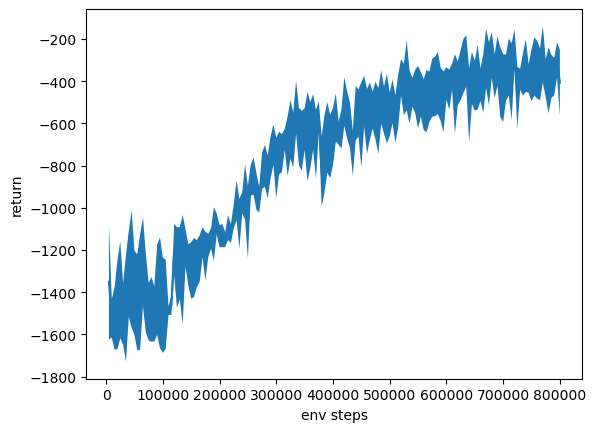

In [6]:
import matplotlib.pyplot as plt
print(learning_curve)
plt.plot(learning_curve["x"], learning_curve["y"])
plt.fill_between(np.array(learning_curve["x"]), np.array(learning_curve["y"])-np.array(learning_curve["z"]), np.array(learning_curve["y"])+np.array(learning_curve["z"]))
plt.xlabel("env steps")
plt.ylabel("return")
plt.show()

In [7]:
leaning_ncde_05= learning_curve

In [8]:
lr=np.array(learning_curve)


In [9]:
lr

array({'x': [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000, 480000, 485000, 490000, 495000, 500000, 505000, 510000, 515000, 520000, 525000, 530000, 535000, 540000, 545000, 550000, 555000, 560000, 565000, 570000, 575000, 580000, 585000, 590000, 595000, 600000, 605000, 610000, 615000, 620000, 625000, 630000,

In [10]:
timess=torch.linspace(0, 65-1, 65)

In [11]:
file1 = open('config.txt', 'w')
file1.write(str(conf))

file1.close()
file2 = open('results.txt', 'w')
file2.write(str(learning_curve))
file2.close()

In [12]:
import matplotlib.pyplot as plt
print(learning_curve)
plt.plot(leaning_lstm["x"], leaning_lstm["y"], label = "lstm_32d")
plt.legend(loc = "lower right", fontsize = "large")
plt.plot(leaning_ncde_32["x"], leaning_ncde_32["y"], label = "ncde_32d")
plt.legend(loc = "lower right", fontsize = "large")
plt.fill_between(np.array(leaning_lstm["x"]), np.array(leaning_lstm["y"])-np.array(leaning_lstm["z"]), np.array(leaning_lstm["y"])+np.array(leaning_lstm["z"]))
plt.fill_between(np.array(leaning_ncde_32["x"]), np.array(leaning_ncde_32["y"])-np.array(leaning_ncde_32["z"]), np.array(leaning_ncde_32["y"])+np.array(leaning_ncde_32["z"]))
plt.xlabel("env steps", fontsize = "x-large")
plt.ylabel("return", fontsize = "x-large")
plt.show()

{'x': [5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 45000, 50000, 55000, 60000, 65000, 70000, 75000, 80000, 85000, 90000, 95000, 100000, 105000, 110000, 115000, 120000, 125000, 130000, 135000, 140000, 145000, 150000, 155000, 160000, 165000, 170000, 175000, 180000, 185000, 190000, 195000, 200000, 205000, 210000, 215000, 220000, 225000, 230000, 235000, 240000, 245000, 250000, 255000, 260000, 265000, 270000, 275000, 280000, 285000, 290000, 295000, 300000, 305000, 310000, 315000, 320000, 325000, 330000, 335000, 340000, 345000, 350000, 355000, 360000, 365000, 370000, 375000, 380000, 385000, 390000, 395000, 400000, 405000, 410000, 415000, 420000, 425000, 430000, 435000, 440000, 445000, 450000, 455000, 460000, 465000, 470000, 475000, 480000, 485000, 490000, 495000, 500000, 505000, 510000, 515000, 520000, 525000, 530000, 535000, 540000, 545000, 550000, 555000, 560000, 565000, 570000, 575000, 580000, 585000, 590000, 595000, 600000, 605000, 610000, 615000, 620000, 625000, 630000, 63500

NameError: name 'leaning_lstm' is not defined

In [ ]:
import gym
import numpy as np
from gym import spaces
from tianshou.data import Batch
from gym import ActionWrapper